In [2]:
import string
import numpy as np
from PIL import Image
import os
from pickle import dump, load
import time
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical, plot_model, get_file
from keras.layers import add
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout

# For progress tracking
from tqdm import tqdm
tqdm().pandas()


0it [00:00, ?it/s]


In [15]:
# Set these paths according to your system
dataset_text = r"C:\Users\ASUS\Desktop\Jupyter Notebook\ML_Project\Flickr8k_text"
dataset_images = r"C:/Users/ASUS/Desktop/Jupyter Notebook/ML_Project/Flickr8k_Dataset/Flicker8k_Dataset"

# Create output directory for models if it doesn't exist
os.makedirs("models", exist_ok=True)

In [16]:
# Loading a text file into memory
def load_doc(filename):
    # Opening the file as read only
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

# Get all images with their captions
def all_img_captions(filename):
    file = load_doc(filename)
    captions = file.split('\n')
    descriptions = {}
    for caption in captions[:-1]:
        img, caption = caption.split('\t')
        if img[:-2] not in descriptions:
            descriptions[img[:-2]] = [caption]
        else:
            descriptions[img[:-2]].append(caption)
    return descriptions

# Data cleaning - lower casing, removing punctuation and words containing numbers
def cleaning_text(captions):
    table = str.maketrans('', '', string.punctuation)
    for img, caps in captions.items():
        for i, img_caption in enumerate(caps):
            img_caption = img_caption.replace("-", " ")
            desc = img_caption.split()
            
            # Convert to lowercase
            desc = [word.lower() for word in desc]
            # Remove punctuation from each token
            desc = [word.translate(table) for word in desc]
            # Remove hanging 's and a 
            desc = [word for word in desc if(len(word) > 1)]
            # Remove tokens with numbers in them
            desc = [word for word in desc if(word.isalpha())]
            # Convert back to string
            
            img_caption = ' '.join(desc)
            captions[img][i] = img_caption
    return captions

def text_vocabulary(descriptions):
    # Build vocabulary of all unique words
    vocab = set()
    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]
    return vocab

# Save all descriptions to one file 
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + '\t' + desc)
    data = "\n".join(lines)
    file = open(filename, "w")
    file.write(data)
    file.close()

In [17]:
# Load the file that contains all data
filename = os.path.join(dataset_text, "Flickr8k.token.txt")

# Map them into descriptions dictionary (img to 5 captions)
descriptions = all_img_captions(filename)
print("Length of descriptions =", len(descriptions))

# Clean the descriptions
clean_descriptions = cleaning_text(descriptions)

# Build vocabulary 
vocabulary = text_vocabulary(clean_descriptions)
print("Length of vocabulary =", len(vocabulary))

# Save each description to file 
save_descriptions(clean_descriptions, "descriptions.txt")

Length of descriptions = 8092
Length of vocabulary = 8422


In [18]:
def download_with_retry(url, filename, max_retries=3):
    for attempt in range(max_retries):
        try:
            return get_file(filename, url)
        except Exception as e:
            if attempt == max_retries - 1:
                raise e
            print(f"Download attempt {attempt + 1} failed. Retrying in 5 seconds...")
            time.sleep(5)

# Initialize the Xception model
weights_url = "https://storage.googleapis.com/tensorflow/keras-applications/xception/xception_weights_tf_dim_ordering_tf_kernels_notop.h5"
weights_path = download_with_retry(weights_url, 'xception_weights.h5')
model = Xception(include_top=False, pooling='avg', weights=weights_path)

def extract_features(directory):
    features = {}
    valid_images = ['.jpg', '.jpeg', '.png']  # Add other formats if needed
    
    # Use tqdm to show progress
    for img in tqdm(os.listdir(directory)):
        # Skip files that don't end with valid image extensions
        ext = os.path.splitext(img)[1].lower()
        if ext not in valid_images:
            continue
            
        filename = os.path.join(directory, img)
        image = Image.open(filename)
        image = image.resize((299, 299))
        image = np.expand_dims(image, axis=0)
        # Normalize the image (same as preprocess_input)
        image = image / 127.5
        image = image - 1.0
        
        feature = model.predict(image)
        features[img] = feature
    return features

In [19]:
2# Only run this cell if you need to extract features
# Comment it out if you've already extracted features
features = extract_features(dataset_images)
dump(features, open("features.p", "wb"))
print("Features extracted and saved!")

  0%|                                                                                         | 0/8091 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


  0%|                                                                               | 1/8091 [00:03<8:49:40,  3.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step


  0%|                                                                               | 2/8091 [00:04<4:24:05,  1.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


  0%|                                                                               | 3/8091 [00:05<2:57:40,  1.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


  0%|                                                                               | 4/8091 [00:05<2:21:26,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


  0%|                                                                               | 5/8091 [00:06<2:04:57,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


  0%|                                                                               | 6/8091 [00:07<2:02:29,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


  0%|                                                                               | 7/8091 [00:07<1:50:21,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


  0%|                                                                               | 8/8091 [00:08<1:39:46,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


  0%|                                                                               | 9/8091 [00:09<1:34:41,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


  0%|                                                                              | 10/8091 [00:09<1:30:07,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


  0%|                                                                              | 11/8091 [00:10<1:29:38,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


  0%|                                                                              | 12/8091 [00:10<1:26:30,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step


  0%|▏                                                                             | 13/8091 [00:11<1:26:27,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


  0%|▏                                                                             | 14/8091 [00:12<1:23:14,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


  0%|▏                                                                             | 15/8091 [00:12<1:19:18,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


  0%|▏                                                                             | 16/8091 [00:13<1:16:30,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


  0%|▏                                                                             | 17/8091 [00:13<1:15:26,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


  0%|▏                                                                             | 18/8091 [00:14<1:13:31,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


  0%|▏                                                                             | 19/8091 [00:14<1:14:56,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step


  0%|▏                                                                             | 20/8091 [00:15<1:17:55,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


  0%|▏                                                                             | 21/8091 [00:16<1:17:37,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


  0%|▏                                                                             | 22/8091 [00:16<1:31:11,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


  0%|▏                                                                             | 23/8091 [00:17<1:25:24,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


  0%|▏                                                                             | 24/8091 [00:18<1:21:20,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step


  0%|▏                                                                             | 25/8091 [00:18<1:21:13,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step


  0%|▎                                                                             | 26/8091 [00:19<1:32:40,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


  0%|▎                                                                             | 27/8091 [00:20<1:25:07,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


  0%|▎                                                                             | 28/8091 [00:20<1:21:03,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


  0%|▎                                                                             | 29/8091 [00:21<1:18:41,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


  0%|▎                                                                             | 30/8091 [00:21<1:16:20,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


  0%|▎                                                                             | 31/8091 [00:22<1:19:42,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


  0%|▎                                                                             | 32/8091 [00:22<1:18:54,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


  0%|▎                                                                             | 33/8091 [00:23<1:18:07,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


  0%|▎                                                                             | 34/8091 [00:24<1:18:52,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


  0%|▎                                                                             | 35/8091 [00:24<1:19:39,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step


  0%|▎                                                                             | 36/8091 [00:25<1:22:20,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


  0%|▎                                                                             | 37/8091 [00:25<1:20:19,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


  0%|▎                                                                             | 38/8091 [00:26<1:19:19,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


  0%|▍                                                                             | 39/8091 [00:26<1:17:58,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step


  0%|▍                                                                             | 40/8091 [00:27<1:21:01,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


  1%|▍                                                                             | 41/8091 [00:28<1:18:51,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


  1%|▍                                                                             | 42/8091 [00:28<1:16:41,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


  1%|▍                                                                             | 43/8091 [00:29<1:14:38,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


  1%|▍                                                                             | 44/8091 [00:29<1:14:06,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


  1%|▍                                                                             | 45/8091 [00:30<1:13:20,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


  1%|▍                                                                             | 46/8091 [00:30<1:14:34,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step


  1%|▍                                                                             | 47/8091 [00:31<1:17:13,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


  1%|▍                                                                             | 48/8091 [00:32<1:16:45,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


  1%|▍                                                                             | 49/8091 [00:32<1:15:52,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


  1%|▍                                                                             | 50/8091 [00:33<1:14:43,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


  1%|▍                                                                             | 51/8091 [00:33<1:12:54,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


  1%|▌                                                                             | 52/8091 [00:34<1:11:56,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


  1%|▌                                                                             | 53/8091 [00:34<1:10:58,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


  1%|▌                                                                             | 54/8091 [00:35<1:11:27,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


  1%|▌                                                                             | 55/8091 [00:35<1:12:03,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


  1%|▌                                                                             | 56/8091 [00:36<1:09:59,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


  1%|▌                                                                             | 57/8091 [00:36<1:10:54,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


  1%|▌                                                                             | 58/8091 [00:37<1:14:53,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


  1%|▌                                                                             | 59/8091 [00:37<1:13:05,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


  1%|▌                                                                             | 60/8091 [00:38<1:14:47,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


  1%|▌                                                                             | 61/8091 [00:39<1:19:45,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


  1%|▌                                                                             | 62/8091 [00:39<1:19:16,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


  1%|▌                                                                             | 63/8091 [00:40<1:21:47,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


  1%|▌                                                                             | 64/8091 [00:41<1:19:02,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


  1%|▋                                                                             | 65/8091 [00:41<1:20:43,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


  1%|▋                                                                             | 66/8091 [00:42<1:17:40,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step


  1%|▋                                                                             | 67/8091 [00:42<1:20:30,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


  1%|▋                                                                             | 68/8091 [00:43<1:18:28,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


  1%|▋                                                                             | 69/8091 [00:43<1:17:48,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


  1%|▋                                                                             | 70/8091 [00:44<1:15:50,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


  1%|▋                                                                             | 71/8091 [00:45<1:13:24,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


  1%|▋                                                                             | 72/8091 [00:45<1:14:07,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


  1%|▋                                                                             | 73/8091 [00:46<1:14:42,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step


  1%|▋                                                                             | 74/8091 [00:47<1:28:19,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


  1%|▋                                                                             | 75/8091 [00:47<1:21:45,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


  1%|▋                                                                             | 76/8091 [00:48<1:19:02,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


  1%|▋                                                                             | 77/8091 [00:48<1:15:25,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


  1%|▊                                                                             | 78/8091 [00:49<1:18:08,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


  1%|▊                                                                             | 79/8091 [00:49<1:17:48,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step


  1%|▊                                                                             | 80/8091 [00:50<1:22:23,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


  1%|▊                                                                             | 81/8091 [00:51<1:21:52,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step


  1%|▊                                                                             | 82/8091 [00:51<1:21:35,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


  1%|▊                                                                             | 83/8091 [00:52<1:19:21,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step


  1%|▊                                                                             | 84/8091 [00:52<1:21:04,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


  1%|▊                                                                             | 85/8091 [00:53<1:18:05,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


  1%|▊                                                                             | 86/8091 [00:54<1:21:07,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


  1%|▊                                                                             | 87/8091 [00:54<1:22:17,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


  1%|▊                                                                             | 88/8091 [00:55<1:22:53,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


  1%|▊                                                                             | 89/8091 [00:55<1:22:51,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


  1%|▊                                                                             | 90/8091 [00:56<1:20:50,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


  1%|▉                                                                             | 91/8091 [00:57<1:18:00,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


  1%|▉                                                                             | 92/8091 [00:57<1:17:33,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


  1%|▉                                                                             | 93/8091 [00:58<1:15:08,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


  1%|▉                                                                             | 94/8091 [00:58<1:13:28,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


  1%|▉                                                                             | 95/8091 [00:59<1:23:57,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


  1%|▉                                                                             | 96/8091 [01:00<1:20:54,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


  1%|▉                                                                             | 97/8091 [01:00<1:16:42,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


  1%|▉                                                                             | 98/8091 [01:01<1:31:45,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


  1%|▉                                                                             | 99/8091 [01:02<1:28:35,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


  1%|▉                                                                            | 100/8091 [01:02<1:27:01,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


  1%|▉                                                                            | 101/8091 [01:03<1:28:15,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


  1%|▉                                                                            | 102/8091 [01:04<1:28:51,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


  1%|▉                                                                            | 103/8091 [01:04<1:26:40,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


  1%|▉                                                                            | 104/8091 [01:05<1:22:54,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step


  1%|▉                                                                            | 105/8091 [01:05<1:24:19,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


  1%|█                                                                            | 106/8091 [01:06<1:21:00,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


  1%|█                                                                            | 107/8091 [01:07<1:19:05,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


  1%|█                                                                            | 108/8091 [01:07<1:17:43,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


  1%|█                                                                            | 109/8091 [01:08<1:15:41,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


  1%|█                                                                            | 110/8091 [01:08<1:13:03,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


  1%|█                                                                            | 111/8091 [01:09<1:12:55,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


  1%|█                                                                            | 112/8091 [01:09<1:11:59,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


  1%|█                                                                            | 113/8091 [01:10<1:15:04,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


  1%|█                                                                            | 114/8091 [01:11<1:19:50,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


  1%|█                                                                            | 115/8091 [01:11<1:22:16,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


  1%|█                                                                            | 116/8091 [01:12<1:24:56,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


  1%|█                                                                            | 117/8091 [01:13<1:24:18,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step


  1%|█                                                                            | 118/8091 [01:13<1:25:52,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step


  1%|█▏                                                                           | 119/8091 [01:14<1:24:44,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step


  1%|█▏                                                                           | 120/8091 [01:14<1:23:59,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


  1%|█▏                                                                           | 121/8091 [01:15<1:19:06,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step


  2%|█▏                                                                           | 122/8091 [01:16<1:17:53,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


  2%|█▏                                                                           | 123/8091 [01:16<1:15:35,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


  2%|█▏                                                                           | 124/8091 [01:17<1:14:57,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


  2%|█▏                                                                           | 125/8091 [01:17<1:13:32,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


  2%|█▏                                                                           | 126/8091 [01:18<1:11:30,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


  2%|█▏                                                                           | 127/8091 [01:18<1:11:01,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step


  2%|█▏                                                                           | 128/8091 [01:19<1:13:45,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step


  2%|█▏                                                                           | 129/8091 [01:19<1:14:20,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


  2%|█▏                                                                           | 130/8091 [01:20<1:13:49,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


  2%|█▏                                                                           | 131/8091 [01:20<1:12:14,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


  2%|█▎                                                                           | 132/8091 [01:21<1:12:09,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


  2%|█▎                                                                           | 133/8091 [01:21<1:11:03,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


  2%|█▎                                                                           | 134/8091 [01:22<1:09:54,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


  2%|█▎                                                                           | 135/8091 [01:22<1:08:43,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


  2%|█▎                                                                           | 136/8091 [01:23<1:08:59,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


  2%|█▎                                                                           | 137/8091 [01:23<1:08:45,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


  2%|█▎                                                                           | 138/8091 [01:24<1:11:37,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


  2%|█▎                                                                           | 139/8091 [01:25<1:12:06,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


  2%|█▎                                                                           | 140/8091 [01:25<1:12:18,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


  2%|█▎                                                                           | 141/8091 [01:26<1:13:25,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


  2%|█▎                                                                           | 142/8091 [01:26<1:16:17,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step


  2%|█▎                                                                           | 143/8091 [01:27<1:16:36,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


  2%|█▎                                                                           | 144/8091 [01:28<1:16:28,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


  2%|█▍                                                                           | 145/8091 [01:28<1:14:06,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


  2%|█▍                                                                           | 146/8091 [01:29<1:12:18,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


  2%|█▍                                                                           | 147/8091 [01:29<1:10:50,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


  2%|█▍                                                                           | 148/8091 [01:30<1:12:17,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


  2%|█▍                                                                           | 149/8091 [01:30<1:15:16,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


  2%|█▍                                                                           | 150/8091 [01:31<1:18:35,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step


  2%|█▍                                                                           | 151/8091 [01:32<1:23:14,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


  2%|█▍                                                                           | 152/8091 [01:32<1:20:38,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step


  2%|█▍                                                                           | 153/8091 [01:33<1:20:57,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


  2%|█▍                                                                           | 154/8091 [01:33<1:17:07,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


  2%|█▍                                                                           | 155/8091 [01:34<1:16:21,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


  2%|█▍                                                                           | 156/8091 [01:34<1:14:37,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


  2%|█▍                                                                           | 157/8091 [01:35<1:12:54,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


  2%|█▌                                                                           | 158/8091 [01:35<1:11:03,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


  2%|█▌                                                                           | 159/8091 [01:36<1:23:41,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


  2%|█▌                                                                           | 160/8091 [01:37<1:21:16,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


  2%|█▌                                                                           | 161/8091 [01:37<1:19:01,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


  2%|█▌                                                                           | 162/8091 [01:38<1:21:00,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step


  2%|█▌                                                                           | 163/8091 [01:39<1:24:00,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step


  2%|█▌                                                                           | 164/8091 [01:39<1:24:07,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step


  2%|█▌                                                                           | 165/8091 [01:40<1:24:51,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


  2%|█▌                                                                           | 166/8091 [01:41<1:17:56,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


  2%|█▌                                                                           | 167/8091 [01:41<1:31:48,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step


  2%|█▌                                                                           | 168/8091 [01:42<1:26:27,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


  2%|█▌                                                                           | 169/8091 [01:43<1:22:22,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


  2%|█▌                                                                           | 170/8091 [01:43<1:17:53,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


  2%|█▋                                                                           | 171/8091 [01:44<1:14:41,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


  2%|█▋                                                                           | 172/8091 [01:44<1:13:21,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


  2%|█▋                                                                           | 173/8091 [01:45<1:13:42,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


  2%|█▋                                                                           | 174/8091 [01:45<1:11:40,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


  2%|█▋                                                                           | 175/8091 [01:46<1:11:53,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


  2%|█▋                                                                           | 176/8091 [01:46<1:12:03,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


  2%|█▋                                                                           | 177/8091 [01:47<1:11:38,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


  2%|█▋                                                                           | 178/8091 [01:47<1:11:32,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


  2%|█▋                                                                           | 179/8091 [01:48<1:11:45,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


  2%|█▋                                                                           | 180/8091 [01:49<1:16:05,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step


  2%|█▋                                                                           | 181/8091 [01:49<1:18:35,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step


  2%|█▋                                                                           | 182/8091 [01:50<1:19:09,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


  2%|█▋                                                                           | 183/8091 [01:51<1:26:46,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


  2%|█▊                                                                           | 184/8091 [01:51<1:23:38,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


  2%|█▊                                                                           | 185/8091 [01:52<1:19:51,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


  2%|█▊                                                                           | 186/8091 [01:52<1:21:13,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


  2%|█▊                                                                           | 187/8091 [01:53<1:33:07,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


  2%|█▊                                                                           | 188/8091 [01:54<1:26:31,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


  2%|█▊                                                                           | 189/8091 [01:54<1:22:38,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


  2%|█▊                                                                           | 190/8091 [01:55<1:22:24,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step


  2%|█▊                                                                           | 191/8091 [01:56<1:22:29,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


  2%|█▊                                                                           | 192/8091 [01:56<1:20:49,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


  2%|█▊                                                                           | 193/8091 [01:57<1:23:36,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


  2%|█▊                                                                           | 194/8091 [01:58<1:26:41,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


  2%|█▊                                                                           | 195/8091 [01:58<1:23:02,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


  2%|█▊                                                                           | 196/8091 [01:59<1:24:51,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step


  2%|█▊                                                                           | 197/8091 [02:00<1:24:28,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step


  2%|█▉                                                                           | 198/8091 [02:00<1:22:56,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step


  2%|█▉                                                                           | 199/8091 [02:01<1:20:36,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


  2%|█▉                                                                           | 200/8091 [02:01<1:17:13,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step


  2%|█▉                                                                           | 201/8091 [02:02<1:19:23,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


  2%|█▉                                                                           | 202/8091 [02:02<1:17:41,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


  3%|█▉                                                                           | 203/8091 [02:03<1:16:54,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


  3%|█▉                                                                           | 204/8091 [02:04<1:19:03,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step


  3%|█▉                                                                           | 205/8091 [02:04<1:21:56,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step


  3%|█▉                                                                           | 206/8091 [02:05<1:20:50,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


  3%|█▉                                                                           | 207/8091 [02:05<1:17:06,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


  3%|█▉                                                                           | 208/8091 [02:06<1:14:18,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


  3%|█▉                                                                           | 209/8091 [02:07<1:14:50,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


  3%|█▉                                                                           | 210/8091 [02:07<1:10:10,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


  3%|██                                                                           | 211/8091 [02:07<1:09:00,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


  3%|██                                                                           | 212/8091 [02:08<1:25:51,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


  3%|██                                                                           | 213/8091 [02:09<1:23:29,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


  3%|██                                                                           | 214/8091 [02:10<1:23:26,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


  3%|██                                                                           | 215/8091 [02:10<1:24:01,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


  3%|██                                                                           | 216/8091 [02:11<1:22:03,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


  3%|██                                                                           | 217/8091 [02:12<1:22:03,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


  3%|██                                                                           | 218/8091 [02:12<1:23:01,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step


  3%|██                                                                           | 219/8091 [02:13<1:23:28,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


  3%|██                                                                           | 220/8091 [02:13<1:20:02,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


  3%|██                                                                           | 221/8091 [02:14<1:16:56,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step


  3%|██                                                                           | 222/8091 [02:15<1:18:13,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


  3%|██                                                                           | 223/8091 [02:15<1:16:35,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


  3%|██▏                                                                          | 224/8091 [02:16<1:25:02,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


  3%|██▏                                                                          | 225/8091 [02:17<1:24:08,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


  3%|██▏                                                                          | 226/8091 [02:17<1:20:55,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


  3%|██▏                                                                          | 227/8091 [02:18<1:22:43,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


  3%|██▏                                                                          | 228/8091 [02:18<1:23:14,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


  3%|██▏                                                                          | 229/8091 [02:19<1:22:06,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


  3%|██▏                                                                          | 230/8091 [02:20<1:20:46,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


  3%|██▏                                                                          | 231/8091 [02:20<1:20:42,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


  3%|██▏                                                                          | 232/8091 [02:21<1:23:15,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


  3%|██▏                                                                          | 233/8091 [02:22<1:23:59,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


  3%|██▏                                                                          | 234/8091 [02:22<1:19:29,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


  3%|██▏                                                                          | 235/8091 [02:23<1:22:00,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


  3%|██▏                                                                          | 236/8091 [02:23<1:21:16,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


  3%|██▎                                                                          | 237/8091 [02:24<1:23:42,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


  3%|██▎                                                                          | 238/8091 [02:25<1:24:19,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


  3%|██▎                                                                          | 239/8091 [02:25<1:20:46,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


  3%|██▎                                                                          | 240/8091 [02:26<1:19:11,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


  3%|██▎                                                                          | 241/8091 [02:26<1:15:35,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


  3%|██▎                                                                          | 242/8091 [02:27<1:13:09,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


  3%|██▎                                                                          | 243/8091 [02:27<1:11:48,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


  3%|██▎                                                                          | 244/8091 [02:28<1:10:52,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


  3%|██▎                                                                          | 245/8091 [02:28<1:10:12,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


  3%|██▎                                                                          | 246/8091 [02:29<1:10:05,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


  3%|██▎                                                                          | 247/8091 [02:30<1:10:35,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


  3%|██▎                                                                          | 248/8091 [02:30<1:11:52,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


  3%|██▎                                                                          | 249/8091 [02:31<1:27:45,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


  3%|██▍                                                                          | 250/8091 [02:31<1:19:15,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


  3%|██▍                                                                          | 251/8091 [02:32<1:19:04,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


  3%|██▍                                                                          | 252/8091 [02:33<1:21:54,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


  3%|██▍                                                                          | 253/8091 [02:33<1:21:56,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step


  3%|██▍                                                                          | 254/8091 [02:34<1:33:51,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


  3%|██▍                                                                          | 255/8091 [02:35<1:27:43,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


  3%|██▍                                                                          | 256/8091 [02:35<1:22:52,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


  3%|██▍                                                                          | 257/8091 [02:36<1:23:15,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


  3%|██▍                                                                          | 258/8091 [02:37<1:19:01,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


  3%|██▍                                                                          | 259/8091 [02:37<1:20:37,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step


  3%|██▍                                                                          | 260/8091 [02:38<1:22:01,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


  3%|██▍                                                                          | 261/8091 [02:38<1:18:37,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


  3%|██▍                                                                          | 262/8091 [02:39<1:15:51,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


  3%|██▌                                                                          | 263/8091 [02:40<1:14:03,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


  3%|██▌                                                                          | 264/8091 [02:40<1:12:19,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


  3%|██▌                                                                          | 265/8091 [02:41<1:11:57,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step


  3%|██▌                                                                          | 266/8091 [02:41<1:24:46,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


  3%|██▌                                                                          | 267/8091 [02:42<1:21:48,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


  3%|██▌                                                                          | 268/8091 [02:43<1:19:35,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


  3%|██▌                                                                          | 269/8091 [02:43<1:18:12,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step


  3%|██▌                                                                          | 270/8091 [02:44<1:31:44,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


  3%|██▌                                                                          | 271/8091 [02:45<1:24:27,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


  3%|██▌                                                                          | 272/8091 [02:45<1:19:20,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step


  3%|██▌                                                                          | 273/8091 [02:46<1:18:31,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


  3%|██▌                                                                          | 274/8091 [02:46<1:15:38,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


  3%|██▌                                                                          | 275/8091 [02:47<1:16:18,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


  3%|██▋                                                                          | 276/8091 [02:48<1:18:06,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


  3%|██▋                                                                          | 277/8091 [02:48<1:17:43,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


  3%|██▋                                                                          | 278/8091 [02:49<1:17:42,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


  3%|██▋                                                                          | 279/8091 [02:49<1:22:35,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


  3%|██▋                                                                          | 280/8091 [02:50<1:23:40,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


  3%|██▋                                                                          | 281/8091 [02:51<1:20:09,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


  3%|██▋                                                                          | 282/8091 [02:52<1:32:23,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


  3%|██▋                                                                          | 283/8091 [02:53<1:42:46,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step


  4%|██▋                                                                          | 284/8091 [02:53<1:34:59,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


  4%|██▋                                                                          | 285/8091 [02:54<1:43:15,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


  4%|██▋                                                                          | 286/8091 [02:55<1:31:51,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


  4%|██▋                                                                          | 287/8091 [02:55<1:36:34,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


  4%|██▋                                                                          | 288/8091 [02:56<1:39:01,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step


  4%|██▊                                                                          | 289/8091 [02:57<1:32:20,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


  4%|██▊                                                                          | 290/8091 [02:57<1:25:36,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


  4%|██▊                                                                          | 291/8091 [02:58<1:36:12,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


  4%|██▊                                                                          | 292/8091 [02:59<1:26:47,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


  4%|██▊                                                                          | 293/8091 [02:59<1:25:32,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


  4%|██▊                                                                          | 294/8091 [03:00<1:24:27,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


  4%|██▊                                                                          | 295/8091 [03:01<1:20:49,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


  4%|██▊                                                                          | 296/8091 [03:01<1:19:20,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


  4%|██▊                                                                          | 297/8091 [03:02<1:19:52,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


  4%|██▊                                                                          | 298/8091 [03:02<1:21:29,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


  4%|██▊                                                                          | 299/8091 [03:03<1:20:50,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step


  4%|██▊                                                                          | 300/8091 [03:04<1:21:52,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step


  4%|██▊                                                                          | 301/8091 [03:04<1:20:22,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


  4%|██▊                                                                          | 302/8091 [03:05<1:17:34,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


  4%|██▉                                                                          | 303/8091 [03:05<1:14:00,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


  4%|██▉                                                                          | 304/8091 [03:06<1:14:52,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


  4%|██▉                                                                          | 305/8091 [03:07<1:13:41,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


  4%|██▉                                                                          | 306/8091 [03:07<1:11:30,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


  4%|██▉                                                                          | 307/8091 [03:08<1:14:52,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


  4%|██▉                                                                          | 308/8091 [03:08<1:16:59,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


  4%|██▉                                                                          | 309/8091 [03:09<1:17:11,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


  4%|██▉                                                                          | 310/8091 [03:10<1:18:50,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


  4%|██▉                                                                          | 311/8091 [03:10<1:32:06,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


  4%|██▉                                                                          | 312/8091 [03:11<1:27:58,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


  4%|██▉                                                                          | 313/8091 [03:12<1:26:07,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


  4%|██▉                                                                          | 314/8091 [03:12<1:23:47,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step


  4%|██▉                                                                          | 315/8091 [03:13<1:26:50,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


  4%|███                                                                          | 316/8091 [03:14<1:22:05,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step


  4%|███                                                                          | 317/8091 [03:14<1:24:49,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


  4%|███                                                                          | 318/8091 [03:15<1:26:21,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


  4%|███                                                                          | 319/8091 [03:16<1:25:43,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


  4%|███                                                                          | 320/8091 [03:16<1:32:36,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


  4%|███                                                                          | 321/8091 [03:17<1:24:17,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


  4%|███                                                                          | 322/8091 [03:18<1:20:43,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


  4%|███                                                                          | 323/8091 [03:18<1:18:28,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


  4%|███                                                                          | 324/8091 [03:19<1:19:19,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


  4%|███                                                                          | 325/8091 [03:19<1:20:10,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


  4%|███                                                                          | 326/8091 [03:20<1:32:25,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


  4%|███                                                                          | 327/8091 [03:21<1:29:47,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


  4%|███                                                                          | 328/8091 [03:22<1:26:54,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


  4%|███▏                                                                         | 329/8091 [03:22<1:26:47,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


  4%|███▏                                                                         | 330/8091 [03:23<1:25:27,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


  4%|███▏                                                                         | 331/8091 [03:24<1:26:17,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step


  4%|███▏                                                                         | 332/8091 [03:24<1:26:51,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step


  4%|███▏                                                                         | 333/8091 [03:25<1:24:53,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step


  4%|███▏                                                                         | 334/8091 [03:25<1:23:45,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step


  4%|███▏                                                                         | 335/8091 [03:26<1:21:08,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step


  4%|███▏                                                                         | 336/8091 [03:27<1:19:58,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


  4%|███▏                                                                         | 337/8091 [03:27<1:16:54,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


  4%|███▏                                                                         | 338/8091 [03:28<1:13:13,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


  4%|███▏                                                                         | 339/8091 [03:28<1:11:45,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


  4%|███▏                                                                         | 340/8091 [03:29<1:10:01,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


  4%|███▏                                                                         | 341/8091 [03:29<1:08:20,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


  4%|███▎                                                                         | 342/8091 [03:30<1:07:14,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


  4%|███▎                                                                         | 343/8091 [03:30<1:06:14,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


  4%|███▎                                                                         | 344/8091 [03:31<1:05:27,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


  4%|███▎                                                                         | 345/8091 [03:31<1:05:37,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


  4%|███▎                                                                         | 346/8091 [03:32<1:05:42,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


  4%|███▎                                                                         | 347/8091 [03:32<1:05:49,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


  4%|███▎                                                                         | 348/8091 [03:33<1:08:27,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


  4%|███▎                                                                         | 349/8091 [03:33<1:11:50,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


  4%|███▎                                                                         | 350/8091 [03:34<1:16:07,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


  4%|███▎                                                                         | 351/8091 [03:35<1:16:54,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step


  4%|███▎                                                                         | 352/8091 [03:35<1:19:39,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step


  4%|███▎                                                                         | 353/8091 [03:36<1:20:44,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


  4%|███▎                                                                         | 354/8091 [03:37<1:16:49,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


  4%|███▍                                                                         | 355/8091 [03:37<1:14:03,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


  4%|███▍                                                                         | 356/8091 [03:38<1:14:00,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


  4%|███▍                                                                         | 357/8091 [03:38<1:14:08,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


  4%|███▍                                                                         | 358/8091 [03:39<1:15:12,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step


  4%|███▍                                                                         | 359/8091 [03:40<1:17:40,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


  4%|███▍                                                                         | 360/8091 [03:40<1:14:15,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


  4%|███▍                                                                         | 361/8091 [03:41<1:13:34,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


  4%|███▍                                                                         | 362/8091 [03:41<1:12:48,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


  4%|███▍                                                                         | 363/8091 [03:42<1:09:16,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


  4%|███▍                                                                         | 364/8091 [03:42<1:10:06,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


  5%|███▍                                                                         | 365/8091 [03:43<1:14:21,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


  5%|███▍                                                                         | 366/8091 [03:43<1:14:27,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


  5%|███▍                                                                         | 367/8091 [03:44<1:15:40,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


  5%|███▌                                                                         | 368/8091 [03:45<1:15:31,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


  5%|███▌                                                                         | 369/8091 [03:45<1:12:27,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


  5%|███▌                                                                         | 370/8091 [03:46<1:12:56,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


  5%|███▌                                                                         | 371/8091 [03:46<1:11:26,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


  5%|███▌                                                                         | 372/8091 [03:47<1:10:25,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


  5%|███▌                                                                         | 373/8091 [03:47<1:07:00,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


  5%|███▌                                                                         | 374/8091 [03:48<1:23:37,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


  5%|███▌                                                                         | 375/8091 [03:49<1:22:10,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


  5%|███▌                                                                         | 376/8091 [03:49<1:21:38,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


  5%|███▌                                                                         | 377/8091 [03:50<1:19:58,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


  5%|███▌                                                                         | 378/8091 [03:51<1:18:34,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


  5%|███▌                                                                         | 379/8091 [03:51<1:15:57,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


  5%|███▌                                                                         | 380/8091 [03:52<1:15:20,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


  5%|███▋                                                                         | 381/8091 [03:52<1:19:37,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


  5%|███▋                                                                         | 382/8091 [03:53<1:19:03,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


  5%|███▋                                                                         | 383/8091 [03:54<1:19:34,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


  5%|███▋                                                                         | 384/8091 [03:54<1:18:32,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


  5%|███▋                                                                         | 385/8091 [03:55<1:15:54,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


  5%|███▋                                                                         | 386/8091 [03:55<1:15:32,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


  5%|███▋                                                                         | 387/8091 [03:56<1:16:48,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


  5%|███▋                                                                         | 388/8091 [03:57<1:15:19,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


  5%|███▋                                                                         | 389/8091 [03:57<1:13:18,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


  5%|███▋                                                                         | 390/8091 [03:58<1:10:57,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


  5%|███▋                                                                         | 391/8091 [03:58<1:10:57,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


  5%|███▋                                                                         | 392/8091 [03:59<1:09:38,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


  5%|███▋                                                                         | 393/8091 [03:59<1:09:06,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


  5%|███▋                                                                         | 394/8091 [04:00<1:07:53,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


  5%|███▊                                                                         | 395/8091 [04:01<1:23:02,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


  5%|███▊                                                                         | 396/8091 [04:01<1:18:39,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


  5%|███▊                                                                         | 397/8091 [04:02<1:14:14,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


  5%|███▊                                                                         | 398/8091 [04:02<1:12:16,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


  5%|███▊                                                                         | 399/8091 [04:03<1:12:28,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


  5%|███▊                                                                         | 400/8091 [04:03<1:11:56,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


  5%|███▊                                                                         | 401/8091 [04:04<1:15:20,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


  5%|███▊                                                                         | 402/8091 [04:05<1:19:00,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


  5%|███▊                                                                         | 403/8091 [04:05<1:19:17,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


  5%|███▊                                                                         | 404/8091 [04:06<1:20:56,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step


  5%|███▊                                                                         | 405/8091 [04:07<1:20:55,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


  5%|███▊                                                                         | 406/8091 [04:07<1:19:19,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


  5%|███▊                                                                         | 407/8091 [04:08<1:18:03,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


  5%|███▉                                                                         | 408/8091 [04:08<1:15:51,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


  5%|███▉                                                                         | 409/8091 [04:09<1:13:45,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step


  5%|███▉                                                                         | 410/8091 [04:09<1:14:52,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


  5%|███▉                                                                         | 411/8091 [04:10<1:13:45,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step


  5%|███▉                                                                         | 412/8091 [04:11<1:16:18,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


  5%|███▉                                                                         | 413/8091 [04:11<1:15:28,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


  5%|███▉                                                                         | 414/8091 [04:12<1:13:58,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


  5%|███▉                                                                         | 415/8091 [04:12<1:16:32,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


  5%|███▉                                                                         | 416/8091 [04:13<1:14:17,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


  5%|███▉                                                                         | 417/8091 [04:14<1:15:17,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


  5%|███▉                                                                         | 418/8091 [04:14<1:18:25,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


  5%|███▉                                                                         | 419/8091 [04:15<1:19:30,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


  5%|███▉                                                                         | 420/8091 [04:15<1:16:45,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step


  5%|████                                                                         | 421/8091 [04:16<1:23:44,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step


  5%|████                                                                         | 422/8091 [04:17<1:27:21,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


  5%|████                                                                         | 423/8091 [04:18<1:24:56,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


  5%|████                                                                         | 424/8091 [04:18<1:30:41,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


  5%|████                                                                         | 425/8091 [04:19<1:28:25,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


  5%|████                                                                         | 426/8091 [04:20<1:38:31,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


  5%|████                                                                         | 427/8091 [04:20<1:28:07,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


  5%|████                                                                         | 428/8091 [04:21<1:32:46,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step


  5%|████                                                                         | 429/8091 [04:22<1:28:48,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step


  5%|████                                                                         | 430/8091 [04:23<1:27:00,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


  5%|████                                                                         | 431/8091 [04:23<1:21:26,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


  5%|████                                                                         | 432/8091 [04:24<1:16:57,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


  5%|████                                                                         | 433/8091 [04:24<1:24:01,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


  5%|████▏                                                                        | 434/8091 [04:25<1:20:06,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


  5%|████▏                                                                        | 435/8091 [04:26<1:20:34,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


  5%|████▏                                                                        | 436/8091 [04:26<1:28:57,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


  5%|████▏                                                                        | 437/8091 [04:27<1:23:53,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step


  5%|████▏                                                                        | 438/8091 [04:28<1:22:38,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


  5%|████▏                                                                        | 439/8091 [04:28<1:15:01,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


  5%|████▏                                                                        | 440/8091 [04:29<1:17:59,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


  5%|████▏                                                                        | 441/8091 [04:29<1:18:42,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


  5%|████▏                                                                        | 442/8091 [04:30<1:18:48,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


  5%|████▏                                                                        | 443/8091 [04:30<1:13:41,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


  5%|████▏                                                                        | 444/8091 [04:31<1:12:41,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


  5%|████▏                                                                        | 445/8091 [04:32<1:11:26,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step


  6%|████▏                                                                        | 446/8091 [04:32<1:10:13,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


  6%|████▎                                                                        | 447/8091 [04:33<1:09:23,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


  6%|████▎                                                                        | 448/8091 [04:33<1:11:27,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


  6%|████▎                                                                        | 449/8091 [04:34<1:13:40,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step


  6%|████▎                                                                        | 450/8091 [04:35<1:20:22,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


  6%|████▎                                                                        | 451/8091 [04:35<1:18:57,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step


  6%|████▎                                                                        | 452/8091 [04:36<1:19:25,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step


  6%|████▎                                                                        | 453/8091 [04:36<1:17:56,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


  6%|████▎                                                                        | 454/8091 [04:37<1:17:50,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


  6%|████▎                                                                        | 455/8091 [04:38<1:30:02,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


  6%|████▎                                                                        | 456/8091 [04:39<1:25:32,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


  6%|████▎                                                                        | 457/8091 [04:39<1:21:09,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


  6%|████▎                                                                        | 458/8091 [04:40<1:31:52,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


  6%|████▎                                                                        | 459/8091 [04:40<1:20:44,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


  6%|████▍                                                                        | 460/8091 [04:41<1:20:13,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


  6%|████▍                                                                        | 461/8091 [04:42<1:14:44,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


  6%|████▍                                                                        | 462/8091 [04:42<1:14:14,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


  6%|████▍                                                                        | 463/8091 [04:43<1:16:31,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


  6%|████▍                                                                        | 464/8091 [04:43<1:17:45,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


  6%|████▍                                                                        | 465/8091 [04:44<1:17:23,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


  6%|████▍                                                                        | 466/8091 [04:45<1:19:16,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


  6%|████▍                                                                        | 467/8091 [04:45<1:19:34,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


  6%|████▍                                                                        | 468/8091 [04:46<1:15:51,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step


  6%|████▍                                                                        | 469/8091 [04:46<1:15:56,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


  6%|████▍                                                                        | 470/8091 [04:47<1:15:28,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


  6%|████▍                                                                        | 471/8091 [04:48<1:28:03,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


  6%|████▍                                                                        | 472/8091 [04:49<1:23:50,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step


  6%|████▌                                                                        | 473/8091 [04:49<1:20:47,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


  6%|████▌                                                                        | 474/8091 [04:50<1:22:34,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


  6%|████▌                                                                        | 475/8091 [04:50<1:19:16,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


  6%|████▌                                                                        | 476/8091 [04:51<1:18:19,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


  6%|████▌                                                                        | 477/8091 [04:52<1:17:36,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


  6%|████▌                                                                        | 478/8091 [04:52<1:17:46,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step


  6%|████▌                                                                        | 479/8091 [04:53<1:19:55,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step


  6%|████▌                                                                        | 480/8091 [04:54<1:26:48,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


  6%|████▌                                                                        | 481/8091 [04:54<1:22:27,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step


  6%|████▌                                                                        | 482/8091 [04:55<1:25:22,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step


  6%|████▌                                                                        | 483/8091 [04:56<1:24:21,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


  6%|████▌                                                                        | 484/8091 [04:56<1:18:40,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


  6%|████▌                                                                        | 485/8091 [04:57<1:21:49,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


  6%|████▋                                                                        | 486/8091 [04:57<1:20:38,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step


  6%|████▋                                                                        | 487/8091 [04:58<1:22:59,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


  6%|████▋                                                                        | 488/8091 [04:59<1:15:40,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


  6%|████▋                                                                        | 489/8091 [05:00<1:27:51,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


  6%|████▋                                                                        | 490/8091 [05:00<1:32:02,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


  6%|████▋                                                                        | 491/8091 [05:01<1:24:51,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


  6%|████▋                                                                        | 492/8091 [05:01<1:20:07,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


  6%|████▋                                                                        | 493/8091 [05:02<1:16:47,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


  6%|████▋                                                                        | 494/8091 [05:02<1:14:18,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


  6%|████▋                                                                        | 495/8091 [05:03<1:13:42,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


  6%|████▋                                                                        | 496/8091 [05:04<1:14:41,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


  6%|████▋                                                                        | 497/8091 [05:04<1:10:02,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


  6%|████▋                                                                        | 498/8091 [05:05<1:11:33,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


  6%|████▋                                                                        | 499/8091 [05:05<1:11:52,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


  6%|████▊                                                                        | 500/8091 [05:06<1:12:04,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step


  6%|████▊                                                                        | 501/8091 [05:06<1:14:31,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step


  6%|████▊                                                                        | 502/8091 [05:07<1:16:33,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


  6%|████▊                                                                        | 503/8091 [05:08<1:23:52,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


  6%|████▊                                                                        | 504/8091 [05:09<1:20:30,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


  6%|████▊                                                                        | 505/8091 [05:09<1:19:15,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


  6%|████▊                                                                        | 506/8091 [05:10<1:15:38,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


  6%|████▊                                                                        | 507/8091 [05:10<1:14:59,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


  6%|████▊                                                                        | 508/8091 [05:11<1:13:06,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


  6%|████▊                                                                        | 509/8091 [05:12<1:21:35,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step


  6%|████▊                                                                        | 510/8091 [05:12<1:20:55,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step


  6%|████▊                                                                        | 511/8091 [05:13<1:20:33,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


  6%|████▊                                                                        | 512/8091 [05:13<1:16:26,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


  6%|████▉                                                                        | 513/8091 [05:14<1:17:28,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


  6%|████▉                                                                        | 514/8091 [05:15<1:16:45,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


  6%|████▉                                                                        | 515/8091 [05:15<1:17:18,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


  6%|████▉                                                                        | 516/8091 [05:16<1:20:27,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


  6%|████▉                                                                        | 517/8091 [05:17<1:20:23,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


  6%|████▉                                                                        | 518/8091 [05:17<1:17:37,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step


  6%|████▉                                                                        | 519/8091 [05:18<1:18:00,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


  6%|████▉                                                                        | 520/8091 [05:18<1:17:08,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


  6%|████▉                                                                        | 521/8091 [05:19<1:13:43,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


  6%|████▉                                                                        | 522/8091 [05:19<1:12:58,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


  6%|████▉                                                                        | 523/8091 [05:20<1:13:00,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


  6%|████▉                                                                        | 524/8091 [05:21<1:13:13,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


  6%|████▉                                                                        | 525/8091 [05:21<1:13:37,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


  7%|█████                                                                        | 526/8091 [05:22<1:12:07,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


  7%|█████                                                                        | 527/8091 [05:22<1:13:16,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


  7%|█████                                                                        | 528/8091 [05:23<1:11:39,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


  7%|█████                                                                        | 529/8091 [05:23<1:10:55,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step


  7%|█████                                                                        | 530/8091 [05:24<1:13:20,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


  7%|█████                                                                        | 531/8091 [05:25<1:13:12,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


  7%|█████                                                                        | 532/8091 [05:25<1:12:21,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


  7%|█████                                                                        | 533/8091 [05:26<1:14:36,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step


  7%|█████                                                                        | 534/8091 [05:27<1:20:20,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step


  7%|█████                                                                        | 535/8091 [05:27<1:20:21,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step


  7%|█████                                                                        | 536/8091 [05:28<1:20:11,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


  7%|█████                                                                        | 537/8091 [05:28<1:16:18,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


  7%|█████                                                                        | 538/8091 [05:29<1:13:12,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


  7%|█████▏                                                                       | 539/8091 [05:29<1:11:44,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


  7%|█████▏                                                                       | 540/8091 [05:30<1:20:00,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step


  7%|█████▏                                                                       | 541/8091 [05:31<1:21:58,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


  7%|█████▏                                                                       | 542/8091 [05:31<1:17:44,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


  7%|█████▏                                                                       | 543/8091 [05:32<1:16:32,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


  7%|█████▏                                                                       | 544/8091 [05:33<1:14:10,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


  7%|█████▏                                                                       | 545/8091 [05:33<1:10:56,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


  7%|█████▏                                                                       | 546/8091 [05:34<1:10:36,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


  7%|█████▏                                                                       | 547/8091 [05:34<1:10:42,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


  7%|█████▏                                                                       | 548/8091 [05:35<1:09:14,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


  7%|█████▏                                                                       | 549/8091 [05:35<1:06:27,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


  7%|█████▏                                                                       | 550/8091 [05:36<1:08:46,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


  7%|█████▏                                                                       | 551/8091 [05:36<1:10:19,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


  7%|█████▎                                                                       | 552/8091 [05:37<1:09:16,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


  7%|█████▎                                                                       | 553/8091 [05:38<1:11:24,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


  7%|█████▎                                                                       | 554/8091 [05:38<1:13:12,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


  7%|█████▎                                                                       | 555/8091 [05:39<1:24:10,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


  7%|█████▎                                                                       | 556/8091 [05:40<1:20:00,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


  7%|█████▎                                                                       | 557/8091 [05:40<1:17:54,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


  7%|█████▎                                                                       | 558/8091 [05:41<1:16:21,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


  7%|█████▎                                                                       | 559/8091 [05:41<1:13:27,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


  7%|█████▎                                                                       | 560/8091 [05:42<1:15:41,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


  7%|█████▎                                                                       | 561/8091 [05:42<1:10:53,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


  7%|█████▎                                                                       | 562/8091 [05:43<1:14:40,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


  7%|█████▎                                                                       | 563/8091 [05:44<1:09:49,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


  7%|█████▎                                                                       | 564/8091 [05:44<1:08:51,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


  7%|█████▍                                                                       | 565/8091 [05:45<1:06:33,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


  7%|█████▍                                                                       | 566/8091 [05:45<1:05:08,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


  7%|█████▍                                                                       | 567/8091 [05:46<1:04:42,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


  7%|█████▍                                                                       | 568/8091 [05:46<1:05:38,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


  7%|█████▍                                                                       | 569/8091 [05:47<1:05:34,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


  7%|█████▍                                                                       | 570/8091 [05:47<1:02:38,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


  7%|█████▍                                                                       | 571/8091 [05:48<1:06:05,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


  7%|█████▍                                                                       | 572/8091 [05:48<1:13:06,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


  7%|█████▍                                                                       | 573/8091 [05:49<1:13:05,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


  7%|█████▍                                                                       | 574/8091 [05:50<1:14:01,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


  7%|█████▍                                                                       | 575/8091 [05:50<1:15:18,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


  7%|█████▍                                                                       | 576/8091 [05:51<1:15:29,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


  7%|█████▍                                                                       | 577/8091 [05:51<1:14:14,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


  7%|█████▌                                                                       | 578/8091 [05:52<1:15:07,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


  7%|█████▌                                                                       | 579/8091 [05:52<1:11:18,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


  7%|█████▌                                                                       | 580/8091 [05:53<1:14:39,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


  7%|█████▌                                                                       | 581/8091 [05:54<1:12:33,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


  7%|█████▌                                                                       | 582/8091 [05:54<1:15:47,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step


  7%|█████▌                                                                       | 583/8091 [05:55<1:17:21,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


  7%|█████▌                                                                       | 584/8091 [05:55<1:12:04,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


  7%|█████▌                                                                       | 585/8091 [05:56<1:15:39,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


  7%|█████▌                                                                       | 586/8091 [05:57<1:18:23,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


  7%|█████▌                                                                       | 587/8091 [05:57<1:17:59,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


  7%|█████▌                                                                       | 588/8091 [05:58<1:26:43,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


  7%|█████▌                                                                       | 589/8091 [05:59<1:21:10,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


  7%|█████▌                                                                       | 590/8091 [05:59<1:18:35,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step


  7%|█████▌                                                                       | 591/8091 [06:00<1:17:40,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


  7%|█████▋                                                                       | 592/8091 [06:00<1:12:26,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


  7%|█████▋                                                                       | 593/8091 [06:01<1:13:14,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


  7%|█████▋                                                                       | 594/8091 [06:02<1:15:41,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


  7%|█████▋                                                                       | 595/8091 [06:02<1:16:07,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


  7%|█████▋                                                                       | 596/8091 [06:03<1:14:51,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


  7%|█████▋                                                                       | 597/8091 [06:03<1:13:13,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


  7%|█████▋                                                                       | 598/8091 [06:04<1:15:33,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


  7%|█████▋                                                                       | 599/8091 [06:05<1:16:27,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


  7%|█████▋                                                                       | 600/8091 [06:05<1:15:04,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


  7%|█████▋                                                                       | 601/8091 [06:06<1:13:02,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


  7%|█████▋                                                                       | 602/8091 [06:06<1:12:13,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


  7%|█████▋                                                                       | 603/8091 [06:07<1:12:07,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


  7%|█████▋                                                                       | 604/8091 [06:08<1:15:22,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


  7%|█████▊                                                                       | 605/8091 [06:08<1:16:09,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


  7%|█████▊                                                                       | 606/8091 [06:09<1:17:25,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


  8%|█████▊                                                                       | 607/8091 [06:10<1:16:53,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


  8%|█████▊                                                                       | 608/8091 [06:10<1:17:30,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


  8%|█████▊                                                                       | 609/8091 [06:11<1:18:48,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step


  8%|█████▊                                                                       | 610/8091 [06:11<1:16:41,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


  8%|█████▊                                                                       | 611/8091 [06:12<1:14:28,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


  8%|█████▊                                                                       | 612/8091 [06:13<1:14:31,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


  8%|█████▊                                                                       | 613/8091 [06:14<1:26:42,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


  8%|█████▊                                                                       | 614/8091 [06:14<1:22:15,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step


  8%|█████▊                                                                       | 615/8091 [06:15<1:28:08,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


  8%|█████▊                                                                       | 616/8091 [06:16<1:36:53,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


  8%|█████▊                                                                       | 617/8091 [06:16<1:29:32,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step


  8%|█████▉                                                                       | 618/8091 [06:17<1:25:52,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


  8%|█████▉                                                                       | 619/8091 [06:18<1:20:28,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step


  8%|█████▉                                                                       | 620/8091 [06:18<1:18:29,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


  8%|█████▉                                                                       | 621/8091 [06:19<1:15:50,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


  8%|█████▉                                                                       | 622/8091 [06:19<1:09:14,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


  8%|█████▉                                                                       | 623/8091 [06:20<1:09:41,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


  8%|█████▉                                                                       | 624/8091 [06:20<1:07:35,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


  8%|█████▉                                                                       | 625/8091 [06:21<1:06:39,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


  8%|█████▉                                                                       | 626/8091 [06:21<1:08:27,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


  8%|█████▉                                                                       | 627/8091 [06:22<1:12:59,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


  8%|█████▉                                                                       | 628/8091 [06:23<1:15:19,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


  8%|█████▉                                                                       | 629/8091 [06:23<1:15:35,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


  8%|█████▉                                                                       | 630/8091 [06:24<1:15:37,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


  8%|██████                                                                       | 631/8091 [06:25<1:16:51,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


  8%|██████                                                                       | 632/8091 [06:25<1:15:16,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


  8%|██████                                                                       | 633/8091 [06:26<1:13:05,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


  8%|██████                                                                       | 634/8091 [06:26<1:11:20,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step


  8%|██████                                                                       | 635/8091 [06:27<1:12:56,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step


  8%|██████                                                                       | 636/8091 [06:27<1:12:30,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


  8%|██████                                                                       | 637/8091 [06:28<1:11:11,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


  8%|██████                                                                       | 638/8091 [06:28<1:08:57,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


  8%|██████                                                                       | 639/8091 [06:29<1:06:54,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


  8%|██████                                                                       | 640/8091 [06:29<1:05:53,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


  8%|██████                                                                       | 641/8091 [06:30<1:06:02,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


  8%|██████                                                                       | 642/8091 [06:31<1:06:33,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


  8%|██████                                                                       | 643/8091 [06:31<1:10:37,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


  8%|██████▏                                                                      | 644/8091 [06:32<1:15:14,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


  8%|██████▏                                                                      | 645/8091 [06:33<1:29:20,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


  8%|██████▏                                                                      | 646/8091 [06:33<1:23:42,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


  8%|██████▏                                                                      | 647/8091 [06:34<1:19:16,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


  8%|██████▏                                                                      | 648/8091 [06:35<1:14:57,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


  8%|██████▏                                                                      | 649/8091 [06:35<1:11:55,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


  8%|██████▏                                                                      | 650/8091 [06:36<1:09:49,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


  8%|██████▏                                                                      | 651/8091 [06:36<1:08:38,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


  8%|██████▏                                                                      | 652/8091 [06:37<1:07:15,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


  8%|██████▏                                                                      | 653/8091 [06:37<1:07:11,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


  8%|██████▏                                                                      | 654/8091 [06:38<1:10:19,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


  8%|██████▏                                                                      | 655/8091 [06:38<1:13:04,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


  8%|██████▏                                                                      | 656/8091 [06:39<1:13:43,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


  8%|██████▎                                                                      | 657/8091 [06:40<1:13:09,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


  8%|██████▎                                                                      | 658/8091 [06:40<1:14:16,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


  8%|██████▎                                                                      | 659/8091 [06:41<1:12:02,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


  8%|██████▎                                                                      | 660/8091 [06:41<1:10:46,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


  8%|██████▎                                                                      | 661/8091 [06:42<1:11:29,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


  8%|██████▎                                                                      | 662/8091 [06:43<1:14:59,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


  8%|██████▎                                                                      | 663/8091 [06:43<1:16:14,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


  8%|██████▎                                                                      | 664/8091 [06:44<1:18:59,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


  8%|██████▎                                                                      | 665/8091 [06:45<1:17:12,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


  8%|██████▎                                                                      | 666/8091 [06:45<1:13:31,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


  8%|██████▎                                                                      | 667/8091 [06:46<1:12:51,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


  8%|██████▎                                                                      | 668/8091 [06:46<1:12:20,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


  8%|██████▎                                                                      | 669/8091 [06:47<1:11:15,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


  8%|██████▍                                                                      | 670/8091 [06:47<1:11:29,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


  8%|██████▍                                                                      | 671/8091 [06:48<1:12:54,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


  8%|██████▍                                                                      | 672/8091 [06:49<1:12:06,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step


  8%|██████▍                                                                      | 673/8091 [06:49<1:15:02,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step


  8%|██████▍                                                                      | 674/8091 [06:50<1:15:45,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step


  8%|██████▍                                                                      | 675/8091 [06:50<1:14:21,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


  8%|██████▍                                                                      | 676/8091 [06:51<1:15:15,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


  8%|██████▍                                                                      | 677/8091 [06:52<1:15:34,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


  8%|██████▍                                                                      | 678/8091 [06:52<1:10:23,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


  8%|██████▍                                                                      | 679/8091 [06:53<1:12:10,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


  8%|██████▍                                                                      | 680/8091 [06:53<1:13:22,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


  8%|██████▍                                                                      | 681/8091 [06:54<1:13:57,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


  8%|██████▍                                                                      | 682/8091 [06:55<1:14:45,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


  8%|██████▍                                                                      | 683/8091 [06:55<1:14:30,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


  8%|██████▌                                                                      | 684/8091 [06:56<1:16:22,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


  8%|██████▌                                                                      | 685/8091 [06:56<1:15:07,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


  8%|██████▌                                                                      | 686/8091 [06:57<1:16:10,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


  8%|██████▌                                                                      | 687/8091 [06:58<1:15:20,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


  9%|██████▌                                                                      | 688/8091 [06:58<1:14:39,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


  9%|██████▌                                                                      | 689/8091 [06:59<1:11:04,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


  9%|██████▌                                                                      | 690/8091 [06:59<1:13:34,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


  9%|██████▌                                                                      | 691/8091 [07:00<1:13:23,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


  9%|██████▌                                                                      | 692/8091 [07:01<1:23:11,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


  9%|██████▌                                                                      | 693/8091 [07:02<1:24:27,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


  9%|██████▌                                                                      | 694/8091 [07:02<1:19:59,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


  9%|██████▌                                                                      | 695/8091 [07:03<1:21:46,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step


  9%|██████▌                                                                      | 696/8091 [07:04<1:24:20,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


  9%|██████▋                                                                      | 697/8091 [07:04<1:22:17,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step


  9%|██████▋                                                                      | 698/8091 [07:05<1:22:03,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


  9%|██████▋                                                                      | 699/8091 [07:06<1:26:05,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


  9%|██████▋                                                                      | 700/8091 [07:06<1:17:36,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


  9%|██████▋                                                                      | 701/8091 [07:07<1:14:27,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


  9%|██████▋                                                                      | 702/8091 [07:07<1:12:48,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


  9%|██████▋                                                                      | 703/8091 [07:08<1:14:38,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


  9%|██████▋                                                                      | 704/8091 [07:08<1:15:06,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


  9%|██████▋                                                                      | 705/8091 [07:09<1:13:58,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


  9%|██████▋                                                                      | 706/8091 [07:10<1:14:00,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


  9%|██████▋                                                                      | 707/8091 [07:10<1:11:57,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


  9%|██████▋                                                                      | 708/8091 [07:11<1:10:42,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


  9%|██████▋                                                                      | 709/8091 [07:11<1:10:50,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


  9%|██████▊                                                                      | 710/8091 [07:12<1:12:04,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step


  9%|██████▊                                                                      | 711/8091 [07:13<1:15:32,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


  9%|██████▊                                                                      | 712/8091 [07:13<1:13:33,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


  9%|██████▊                                                                      | 713/8091 [07:14<1:20:55,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


  9%|██████▊                                                                      | 714/8091 [07:15<1:20:15,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


  9%|██████▊                                                                      | 715/8091 [07:15<1:17:01,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step


  9%|██████▊                                                                      | 716/8091 [07:16<1:16:40,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


  9%|██████▊                                                                      | 717/8091 [07:16<1:15:13,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


  9%|██████▊                                                                      | 718/8091 [07:17<1:13:26,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


  9%|██████▊                                                                      | 719/8091 [07:17<1:11:04,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


  9%|██████▊                                                                      | 720/8091 [07:18<1:09:11,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


  9%|██████▊                                                                      | 721/8091 [07:18<1:07:26,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


  9%|██████▊                                                                      | 722/8091 [07:19<1:08:53,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


  9%|██████▉                                                                      | 723/8091 [07:20<1:07:17,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


  9%|██████▉                                                                      | 724/8091 [07:20<1:06:06,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


  9%|██████▉                                                                      | 725/8091 [07:21<1:06:30,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step


  9%|██████▉                                                                      | 726/8091 [07:21<1:08:09,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


  9%|██████▉                                                                      | 727/8091 [07:22<1:10:49,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


  9%|██████▉                                                                      | 728/8091 [07:23<1:14:20,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


  9%|██████▉                                                                      | 729/8091 [07:23<1:16:41,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


  9%|██████▉                                                                      | 730/8091 [07:24<1:15:15,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step


  9%|██████▉                                                                      | 731/8091 [07:24<1:17:29,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step


  9%|██████▉                                                                      | 732/8091 [07:25<1:19:32,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


  9%|██████▉                                                                      | 733/8091 [07:26<1:14:54,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


  9%|██████▉                                                                      | 734/8091 [07:26<1:13:27,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


  9%|██████▉                                                                      | 735/8091 [07:27<1:16:05,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


  9%|███████                                                                      | 736/8091 [07:28<1:16:50,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


  9%|███████                                                                      | 737/8091 [07:28<1:18:20,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step


  9%|███████                                                                      | 738/8091 [07:29<1:27:22,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


  9%|███████                                                                      | 739/8091 [07:30<1:20:59,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


  9%|███████                                                                      | 740/8091 [07:30<1:15:38,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


  9%|███████                                                                      | 741/8091 [07:31<1:12:18,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step


  9%|███████                                                                      | 742/8091 [07:31<1:11:18,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


  9%|███████                                                                      | 743/8091 [07:32<1:14:09,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


  9%|███████                                                                      | 744/8091 [07:32<1:12:20,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


  9%|███████                                                                      | 745/8091 [07:33<1:13:22,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


  9%|███████                                                                      | 746/8091 [07:34<1:15:54,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


  9%|███████                                                                      | 747/8091 [07:34<1:18:15,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


  9%|███████                                                                      | 748/8091 [07:35<1:19:40,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


  9%|███████▏                                                                     | 749/8091 [07:36<1:16:10,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


  9%|███████▏                                                                     | 750/8091 [07:36<1:19:19,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


  9%|███████▏                                                                     | 751/8091 [07:37<1:20:03,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


  9%|███████▏                                                                     | 752/8091 [07:38<1:18:10,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


  9%|███████▏                                                                     | 753/8091 [07:38<1:16:39,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


  9%|███████▏                                                                     | 754/8091 [07:39<1:15:09,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


  9%|███████▏                                                                     | 755/8091 [07:39<1:13:16,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


  9%|███████▏                                                                     | 756/8091 [07:40<1:11:49,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


  9%|███████▏                                                                     | 757/8091 [07:41<1:11:38,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step


  9%|███████▏                                                                     | 758/8091 [07:41<1:15:00,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step


  9%|███████▏                                                                     | 759/8091 [07:42<1:15:31,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


  9%|███████▏                                                                     | 760/8091 [07:42<1:13:54,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step


  9%|███████▏                                                                     | 761/8091 [07:43<1:15:06,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


  9%|███████▎                                                                     | 762/8091 [07:44<1:14:32,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


  9%|███████▎                                                                     | 763/8091 [07:44<1:11:02,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


  9%|███████▎                                                                     | 764/8091 [07:45<1:07:51,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


  9%|███████▎                                                                     | 765/8091 [07:45<1:06:25,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


  9%|███████▎                                                                     | 766/8091 [07:46<1:04:53,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


  9%|███████▎                                                                     | 767/8091 [07:46<1:03:51,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


  9%|███████▎                                                                     | 768/8091 [07:47<1:02:51,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


 10%|███████▎                                                                     | 769/8091 [07:47<1:00:57,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


 10%|███████▎                                                                     | 770/8091 [07:48<1:02:15,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


 10%|███████▎                                                                     | 771/8091 [07:48<1:06:17,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


 10%|███████▎                                                                     | 772/8091 [07:49<1:07:25,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 10%|███████▎                                                                     | 773/8091 [07:49<1:07:06,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


 10%|███████▎                                                                     | 774/8091 [07:50<1:08:45,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 10%|███████▍                                                                     | 775/8091 [07:51<1:20:38,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 10%|███████▍                                                                     | 776/8091 [07:51<1:16:01,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


 10%|███████▍                                                                     | 777/8091 [07:52<1:23:18,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 10%|███████▍                                                                     | 778/8091 [07:53<1:18:10,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 10%|███████▍                                                                     | 779/8091 [07:53<1:14:07,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 10%|███████▍                                                                     | 780/8091 [07:54<1:12:10,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


 10%|███████▍                                                                     | 781/8091 [07:54<1:09:40,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 10%|███████▍                                                                     | 782/8091 [07:55<1:07:15,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 10%|███████▍                                                                     | 783/8091 [07:55<1:05:16,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 10%|███████▍                                                                     | 784/8091 [07:56<1:04:33,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 10%|███████▍                                                                     | 785/8091 [07:56<1:03:36,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


 10%|███████▍                                                                     | 786/8091 [07:57<1:04:51,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 10%|███████▍                                                                     | 787/8091 [07:58<1:05:49,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


 10%|███████▍                                                                     | 788/8091 [07:58<1:04:42,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


 10%|███████▌                                                                     | 789/8091 [07:59<1:07:18,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


 10%|███████▌                                                                     | 790/8091 [07:59<1:09:21,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


 10%|███████▌                                                                     | 791/8091 [08:00<1:08:37,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


 10%|███████▌                                                                     | 792/8091 [08:01<1:12:31,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


 10%|███████▌                                                                     | 793/8091 [08:01<1:10:14,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step


 10%|███████▌                                                                     | 794/8091 [08:02<1:09:10,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 10%|███████▌                                                                     | 795/8091 [08:02<1:09:36,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 10%|███████▌                                                                     | 796/8091 [08:03<1:08:07,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 10%|███████▌                                                                     | 797/8091 [08:03<1:06:51,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


 10%|███████▌                                                                     | 798/8091 [08:04<1:06:49,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 10%|███████▌                                                                     | 799/8091 [08:04<1:05:37,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 10%|███████▌                                                                     | 800/8091 [08:05<1:04:11,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 10%|███████▌                                                                     | 801/8091 [08:05<1:03:48,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


 10%|███████▋                                                                     | 802/8091 [08:06<1:04:11,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 10%|███████▋                                                                     | 803/8091 [08:06<1:03:35,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


 10%|███████▋                                                                     | 804/8091 [08:07<1:03:40,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


 10%|███████▋                                                                     | 805/8091 [08:07<1:03:28,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 10%|███████▋                                                                     | 806/8091 [08:08<1:04:21,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


 10%|███████▋                                                                     | 807/8091 [08:09<1:07:00,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


 10%|███████▋                                                                     | 808/8091 [08:09<1:07:43,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


 10%|███████▋                                                                     | 809/8091 [08:10<1:07:37,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 10%|███████▋                                                                     | 810/8091 [08:11<1:18:22,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 10%|███████▋                                                                     | 811/8091 [08:11<1:15:33,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 10%|███████▋                                                                     | 812/8091 [08:12<1:13:14,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 10%|███████▋                                                                     | 813/8091 [08:12<1:10:15,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


 10%|███████▋                                                                     | 814/8091 [08:13<1:21:02,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


 10%|███████▊                                                                     | 815/8091 [08:14<1:16:39,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


 10%|███████▊                                                                     | 816/8091 [08:14<1:08:29,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 10%|███████▊                                                                     | 817/8091 [08:15<1:21:18,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


 10%|███████▊                                                                     | 818/8091 [08:16<1:16:40,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 10%|███████▊                                                                     | 819/8091 [08:16<1:12:31,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 10%|███████▊                                                                     | 820/8091 [08:17<1:10:52,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 10%|███████▊                                                                     | 821/8091 [08:17<1:08:56,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 10%|███████▊                                                                     | 822/8091 [08:18<1:07:27,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step


 10%|███████▊                                                                     | 823/8091 [08:18<1:09:23,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


 10%|███████▊                                                                     | 824/8091 [08:19<1:08:53,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


 10%|███████▊                                                                     | 825/8091 [08:19<1:08:25,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 10%|███████▊                                                                     | 826/8091 [08:20<1:12:09,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


 10%|███████▊                                                                     | 827/8091 [08:21<1:12:19,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


 10%|███████▉                                                                     | 828/8091 [08:21<1:09:37,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


 10%|███████▉                                                                     | 829/8091 [08:22<1:07:37,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 10%|███████▉                                                                     | 830/8091 [08:22<1:07:56,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 10%|███████▉                                                                     | 831/8091 [08:23<1:11:17,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 10%|███████▉                                                                     | 832/8091 [08:24<1:12:15,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 10%|███████▉                                                                     | 833/8091 [08:24<1:16:51,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


 10%|███████▉                                                                     | 834/8091 [08:25<1:11:20,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


 10%|███████▉                                                                     | 835/8091 [08:25<1:10:46,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


 10%|███████▉                                                                     | 836/8091 [08:26<1:10:16,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 10%|███████▉                                                                     | 837/8091 [08:27<1:14:04,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 10%|███████▉                                                                     | 838/8091 [08:27<1:13:40,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


 10%|███████▉                                                                     | 839/8091 [08:28<1:13:10,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


 10%|███████▉                                                                     | 840/8091 [08:28<1:13:18,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 10%|████████                                                                     | 841/8091 [08:29<1:11:37,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 10%|████████                                                                     | 842/8091 [08:29<1:09:37,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 10%|████████                                                                     | 843/8091 [08:30<1:07:33,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 10%|████████                                                                     | 844/8091 [08:31<1:16:10,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step


 10%|████████                                                                     | 845/8091 [08:31<1:12:56,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


 10%|████████                                                                     | 846/8091 [08:32<1:10:31,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


 10%|████████                                                                     | 847/8091 [08:32<1:05:14,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


 10%|████████                                                                     | 848/8091 [08:33<1:05:24,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


 10%|████████                                                                     | 849/8091 [08:33<1:05:05,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


 11%|████████                                                                     | 850/8091 [08:34<1:05:48,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


 11%|████████                                                                     | 851/8091 [08:34<1:04:02,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 11%|████████                                                                     | 852/8091 [08:35<1:04:37,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 11%|████████                                                                     | 853/8091 [08:36<1:07:41,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


 11%|████████▏                                                                    | 854/8091 [08:36<1:07:23,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 11%|████████▏                                                                    | 855/8091 [08:37<1:08:04,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 11%|████████▏                                                                    | 856/8091 [08:37<1:07:19,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


 11%|████████▏                                                                    | 857/8091 [08:38<1:07:02,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 11%|████████▏                                                                    | 858/8091 [08:38<1:05:19,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 11%|████████▏                                                                    | 859/8091 [08:39<1:05:12,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 11%|████████▏                                                                    | 860/8091 [08:39<1:04:47,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step


 11%|████████▏                                                                    | 861/8091 [08:40<1:05:42,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 11%|████████▏                                                                    | 862/8091 [08:40<1:04:51,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


 11%|████████▏                                                                    | 863/8091 [08:41<1:03:53,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


 11%|████████▏                                                                    | 864/8091 [08:42<1:04:12,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 11%|████████▏                                                                    | 865/8091 [08:42<1:08:07,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


 11%|████████▏                                                                    | 866/8091 [08:43<1:08:57,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


 11%|████████▎                                                                    | 867/8091 [08:43<1:08:45,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 11%|████████▎                                                                    | 868/8091 [08:44<1:11:18,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


 11%|████████▎                                                                    | 869/8091 [08:45<1:09:16,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


 11%|████████▎                                                                    | 870/8091 [08:45<1:07:28,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


 11%|████████▎                                                                    | 871/8091 [08:46<1:07:07,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


 11%|████████▎                                                                    | 872/8091 [08:46<1:06:57,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


 11%|████████▎                                                                    | 873/8091 [08:47<1:05:08,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


 11%|████████▎                                                                    | 874/8091 [08:47<1:05:43,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


 11%|████████▎                                                                    | 875/8091 [08:48<1:06:40,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


 11%|████████▎                                                                    | 876/8091 [08:48<1:05:34,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


 11%|████████▎                                                                    | 877/8091 [08:49<1:04:25,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


 11%|████████▎                                                                    | 878/8091 [08:49<1:05:24,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


 11%|████████▎                                                                    | 879/8091 [08:50<1:06:30,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 11%|████████▎                                                                    | 880/8091 [08:51<1:09:59,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


 11%|████████▍                                                                    | 881/8091 [08:51<1:11:13,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


 11%|████████▍                                                                    | 882/8091 [08:52<1:11:36,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


 11%|████████▍                                                                    | 883/8091 [08:52<1:10:51,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


 11%|████████▍                                                                    | 884/8091 [08:53<1:08:34,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 11%|████████▍                                                                    | 885/8091 [08:53<1:07:06,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


 11%|████████▍                                                                    | 886/8091 [08:54<1:06:25,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 11%|████████▍                                                                    | 887/8091 [08:55<1:05:24,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 11%|████████▍                                                                    | 888/8091 [08:55<1:04:39,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 11%|████████▍                                                                    | 889/8091 [08:56<1:06:45,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 11%|████████▍                                                                    | 890/8091 [08:56<1:16:42,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


 11%|████████▍                                                                    | 891/8091 [08:57<1:13:22,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 11%|████████▍                                                                    | 892/8091 [08:58<1:11:12,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


 11%|████████▍                                                                    | 893/8091 [08:58<1:13:09,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 11%|████████▌                                                                    | 894/8091 [08:59<1:10:41,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 11%|████████▌                                                                    | 895/8091 [09:00<1:18:16,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


 11%|████████▌                                                                    | 896/8091 [09:00<1:15:30,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 11%|████████▌                                                                    | 897/8091 [09:01<1:12:56,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


 11%|████████▌                                                                    | 898/8091 [09:01<1:08:23,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 11%|████████▌                                                                    | 899/8091 [09:02<1:10:31,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


 11%|████████▌                                                                    | 900/8091 [09:02<1:10:48,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


 11%|████████▌                                                                    | 901/8091 [09:03<1:09:20,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 11%|████████▌                                                                    | 902/8091 [09:04<1:11:41,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


 11%|████████▌                                                                    | 903/8091 [09:04<1:10:10,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step


 11%|████████▌                                                                    | 904/8091 [09:05<1:14:14,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 11%|████████▌                                                                    | 905/8091 [09:05<1:12:25,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


 11%|████████▌                                                                    | 906/8091 [09:06<1:10:39,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


 11%|████████▋                                                                    | 907/8091 [09:06<1:07:35,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 11%|████████▋                                                                    | 908/8091 [09:07<1:06:55,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 11%|████████▋                                                                    | 909/8091 [09:08<1:05:21,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 11%|████████▋                                                                    | 910/8091 [09:08<1:04:51,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 11%|████████▋                                                                    | 911/8091 [09:09<1:03:41,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 11%|████████▋                                                                    | 912/8091 [09:09<1:03:05,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 11%|████████▋                                                                    | 913/8091 [09:10<1:02:03,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 11%|████████▋                                                                    | 914/8091 [09:10<1:01:47,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 11%|████████▋                                                                    | 915/8091 [09:11<1:01:46,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


 11%|████████▋                                                                    | 916/8091 [09:11<1:03:23,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


 11%|████████▋                                                                    | 917/8091 [09:12<1:03:51,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


 11%|████████▋                                                                    | 918/8091 [09:12<1:03:51,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


 11%|████████▋                                                                    | 919/8091 [09:13<1:03:59,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


 11%|████████▊                                                                    | 920/8091 [09:13<1:04:07,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


 11%|████████▊                                                                    | 921/8091 [09:14<1:04:31,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


 11%|████████▊                                                                    | 922/8091 [09:14<1:05:36,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


 11%|████████▊                                                                    | 923/8091 [09:15<1:04:43,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


 11%|████████▊                                                                    | 924/8091 [09:16<1:04:40,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


 11%|████████▊                                                                    | 925/8091 [09:16<1:04:40,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


 11%|████████▊                                                                    | 926/8091 [09:17<1:04:56,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


 11%|████████▊                                                                    | 927/8091 [09:17<1:04:00,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 11%|████████▊                                                                    | 928/8091 [09:18<1:08:18,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


 11%|████████▊                                                                    | 929/8091 [09:18<1:07:20,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 11%|████████▊                                                                    | 930/8091 [09:19<1:05:12,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


 12%|████████▊                                                                    | 931/8091 [09:19<1:02:52,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


 12%|████████▊                                                                    | 932/8091 [09:20<1:04:39,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 12%|████████▉                                                                    | 933/8091 [09:20<1:06:07,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


 12%|████████▉                                                                    | 934/8091 [09:21<1:06:42,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


 12%|████████▉                                                                    | 935/8091 [09:22<1:06:09,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 12%|████████▉                                                                    | 936/8091 [09:22<1:09:03,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


 12%|████████▉                                                                    | 937/8091 [09:23<1:09:09,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 12%|████████▉                                                                    | 938/8091 [09:23<1:09:13,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


 12%|████████▉                                                                    | 939/8091 [09:24<1:10:43,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step


 12%|████████▉                                                                    | 940/8091 [09:25<1:10:31,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 12%|████████▉                                                                    | 941/8091 [09:25<1:08:17,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 12%|████████▉                                                                    | 942/8091 [09:26<1:06:33,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 12%|████████▉                                                                    | 943/8091 [09:26<1:05:46,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 12%|████████▉                                                                    | 944/8091 [09:27<1:03:20,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 12%|████████▉                                                                    | 945/8091 [09:27<1:02:31,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 12%|█████████                                                                    | 946/8091 [09:28<1:01:55,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 12%|█████████                                                                    | 947/8091 [09:28<1:01:30,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 12%|█████████                                                                    | 948/8091 [09:29<1:00:54,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 12%|█████████                                                                    | 949/8091 [09:29<1:00:43,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


 12%|█████████                                                                    | 950/8091 [09:30<1:00:05,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 12%|█████████                                                                    | 951/8091 [09:30<1:00:52,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 12%|█████████                                                                    | 952/8091 [09:31<1:03:13,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


 12%|█████████                                                                    | 953/8091 [09:31<1:04:25,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


 12%|█████████                                                                    | 954/8091 [09:32<1:05:25,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


 12%|█████████                                                                    | 955/8091 [09:33<1:06:16,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


 12%|█████████                                                                    | 956/8091 [09:33<1:05:12,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 12%|█████████                                                                    | 957/8091 [09:34<1:05:29,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


 12%|█████████                                                                    | 958/8091 [09:34<1:06:31,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


 12%|█████████▏                                                                   | 959/8091 [09:35<1:07:52,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


 12%|█████████▏                                                                   | 960/8091 [09:35<1:06:43,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


 12%|█████████▏                                                                   | 961/8091 [09:36<1:07:19,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


 12%|█████████▏                                                                   | 962/8091 [09:36<1:05:27,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 12%|█████████▏                                                                   | 963/8091 [09:37<1:04:15,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 12%|█████████▏                                                                   | 964/8091 [09:37<1:03:52,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


 12%|█████████▏                                                                   | 965/8091 [09:38<1:03:20,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


 12%|█████████▏                                                                   | 966/8091 [09:39<1:05:36,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


 12%|█████████▏                                                                   | 967/8091 [09:39<1:05:01,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


 12%|█████████▏                                                                   | 968/8091 [09:40<1:09:19,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


 12%|█████████▏                                                                   | 969/8091 [09:40<1:08:15,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


 12%|█████████▏                                                                   | 970/8091 [09:41<1:07:56,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 12%|█████████▏                                                                   | 971/8091 [09:41<1:05:52,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


 12%|█████████▎                                                                   | 972/8091 [09:42<1:06:26,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


 12%|█████████▎                                                                   | 973/8091 [09:43<1:04:39,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


 12%|█████████▎                                                                   | 974/8091 [09:43<1:02:51,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 12%|█████████▎                                                                   | 975/8091 [09:44<1:05:55,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 12%|█████████▎                                                                   | 976/8091 [09:44<1:04:44,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 12%|█████████▎                                                                   | 977/8091 [09:45<1:01:14,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 12%|█████████▎                                                                   | 978/8091 [09:45<1:03:46,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


 12%|█████████▎                                                                   | 979/8091 [09:46<1:01:37,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


 12%|█████████▌                                                                     | 980/8091 [09:46<59:40,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 12%|█████████▎                                                                   | 981/8091 [09:47<1:00:40,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


 12%|█████████▎                                                                   | 982/8091 [09:47<1:01:01,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 12%|█████████▎                                                                   | 983/8091 [09:48<1:02:22,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step


 12%|█████████▎                                                                   | 984/8091 [09:48<1:05:57,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 12%|█████████▎                                                                   | 985/8091 [09:49<1:05:41,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


 12%|█████████▍                                                                   | 986/8091 [09:50<1:06:44,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 12%|█████████▍                                                                   | 987/8091 [09:50<1:04:45,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 12%|█████████▍                                                                   | 988/8091 [09:51<1:03:05,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 12%|█████████▍                                                                   | 989/8091 [09:51<1:02:14,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 12%|█████████▍                                                                   | 990/8091 [09:52<1:01:40,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


 12%|█████████▍                                                                   | 991/8091 [09:52<1:02:59,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


 12%|█████████▍                                                                   | 992/8091 [09:53<1:02:48,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 12%|█████████▍                                                                   | 993/8091 [09:53<1:01:06,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 12%|█████████▍                                                                   | 994/8091 [09:54<1:01:05,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 12%|█████████▍                                                                   | 995/8091 [09:54<1:01:45,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 12%|█████████▍                                                                   | 996/8091 [09:55<1:02:32,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


 12%|█████████▋                                                                     | 997/8091 [09:55<58:32,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 12%|█████████▍                                                                   | 998/8091 [09:56<1:14:24,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 12%|█████████▌                                                                   | 999/8091 [09:57<1:11:17,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


 12%|█████████▍                                                                  | 1000/8091 [09:57<1:07:20,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 12%|█████████▍                                                                  | 1001/8091 [09:58<1:05:39,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


 12%|█████████▍                                                                  | 1002/8091 [09:58<1:05:31,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


 12%|█████████▍                                                                  | 1003/8091 [09:59<1:06:51,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


 12%|█████████▍                                                                  | 1004/8091 [09:59<1:07:54,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 12%|█████████▍                                                                  | 1005/8091 [10:00<1:06:11,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


 12%|█████████▍                                                                  | 1006/8091 [10:00<1:05:41,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


 12%|█████████▍                                                                  | 1007/8091 [10:01<1:04:15,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


 12%|█████████▍                                                                  | 1008/8091 [10:01<1:04:35,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


 12%|█████████▍                                                                  | 1009/8091 [10:02<1:06:01,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 12%|█████████▍                                                                  | 1010/8091 [10:03<1:07:47,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


 12%|█████████▍                                                                  | 1011/8091 [10:03<1:06:29,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 13%|█████████▌                                                                  | 1012/8091 [10:04<1:04:45,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


 13%|█████████▌                                                                  | 1013/8091 [10:04<1:07:42,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


 13%|█████████▌                                                                  | 1014/8091 [10:05<1:09:19,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


 13%|█████████▌                                                                  | 1015/8091 [10:06<1:08:46,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 13%|█████████▌                                                                  | 1016/8091 [10:06<1:05:39,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


 13%|█████████▌                                                                  | 1017/8091 [10:07<1:06:23,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


 13%|█████████▌                                                                  | 1018/8091 [10:07<1:05:45,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 13%|█████████▌                                                                  | 1019/8091 [10:08<1:05:54,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 13%|█████████▌                                                                  | 1020/8091 [10:08<1:06:30,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 13%|█████████▌                                                                  | 1021/8091 [10:09<1:04:48,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


 13%|█████████▌                                                                  | 1022/8091 [10:09<1:03:25,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 13%|█████████▌                                                                  | 1023/8091 [10:10<1:02:57,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 13%|█████████▌                                                                  | 1024/8091 [10:11<1:06:49,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


 13%|█████████▋                                                                  | 1025/8091 [10:11<1:06:15,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


 13%|█████████▋                                                                  | 1026/8091 [10:12<1:07:19,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


 13%|█████████▋                                                                  | 1027/8091 [10:12<1:07:37,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


 13%|█████████▋                                                                  | 1028/8091 [10:13<1:08:15,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


 13%|█████████▋                                                                  | 1029/8091 [10:13<1:05:25,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


 13%|█████████▋                                                                  | 1030/8091 [10:14<1:08:41,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step


 13%|█████████▋                                                                  | 1031/8091 [10:15<1:11:15,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 13%|█████████▋                                                                  | 1032/8091 [10:15<1:09:47,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step


 13%|█████████▋                                                                  | 1033/8091 [10:16<1:09:25,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 13%|█████████▋                                                                  | 1034/8091 [10:16<1:06:43,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 13%|█████████▋                                                                  | 1035/8091 [10:17<1:15:01,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 13%|█████████▋                                                                  | 1036/8091 [10:18<1:12:53,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


 13%|█████████▋                                                                  | 1037/8091 [10:18<1:11:14,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 13%|█████████▊                                                                  | 1038/8091 [10:19<1:09:21,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 13%|█████████▊                                                                  | 1039/8091 [10:19<1:06:38,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 13%|█████████▊                                                                  | 1040/8091 [10:20<1:04:45,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 13%|█████████▊                                                                  | 1041/8091 [10:20<1:02:59,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 13%|█████████▊                                                                  | 1042/8091 [10:21<1:02:31,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 13%|█████████▊                                                                  | 1043/8091 [10:21<1:01:53,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


 13%|█████████▊                                                                  | 1044/8091 [10:22<1:03:15,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


 13%|█████████▊                                                                  | 1045/8091 [10:22<1:02:13,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 13%|█████████▊                                                                  | 1046/8091 [10:23<1:02:46,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


 13%|█████████▊                                                                  | 1047/8091 [10:24<1:01:56,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 13%|█████████▊                                                                  | 1048/8091 [10:24<1:06:09,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


 13%|█████████▊                                                                  | 1049/8091 [10:25<1:06:56,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


 13%|█████████▊                                                                  | 1050/8091 [10:25<1:05:56,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 13%|█████████▊                                                                  | 1051/8091 [10:26<1:08:11,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 13%|█████████▉                                                                  | 1052/8091 [10:27<1:09:22,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 13%|█████████▉                                                                  | 1053/8091 [10:27<1:05:57,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


 13%|█████████▉                                                                  | 1054/8091 [10:28<1:07:19,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 13%|█████████▉                                                                  | 1055/8091 [10:28<1:09:45,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 13%|█████████▉                                                                  | 1056/8091 [10:29<1:09:52,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


 13%|█████████▉                                                                  | 1057/8091 [10:30<1:16:40,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 13%|█████████▉                                                                  | 1058/8091 [10:30<1:16:01,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


 13%|█████████▉                                                                  | 1059/8091 [10:31<1:14:34,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


 13%|█████████▉                                                                  | 1060/8091 [10:31<1:11:43,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 13%|█████████▉                                                                  | 1061/8091 [10:32<1:12:39,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


 13%|█████████▉                                                                  | 1062/8091 [10:33<1:09:48,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 13%|█████████▉                                                                  | 1063/8091 [10:33<1:07:50,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


 13%|█████████▉                                                                  | 1064/8091 [10:34<1:08:32,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step


 13%|██████████                                                                  | 1065/8091 [10:34<1:10:03,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


 13%|██████████                                                                  | 1066/8091 [10:35<1:07:46,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 13%|██████████                                                                  | 1067/8091 [10:35<1:05:27,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 13%|██████████                                                                  | 1068/8091 [10:36<1:03:28,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 13%|██████████                                                                  | 1069/8091 [10:36<1:01:58,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 13%|██████████                                                                  | 1070/8091 [10:37<1:00:52,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


 13%|██████████                                                                  | 1071/8091 [10:37<1:00:34,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


 13%|██████████                                                                  | 1072/8091 [10:38<1:00:58,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 13%|██████████                                                                  | 1073/8091 [10:39<1:02:19,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


 13%|██████████                                                                  | 1074/8091 [10:39<1:03:23,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


 13%|██████████                                                                  | 1075/8091 [10:40<1:04:09,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


 13%|██████████                                                                  | 1076/8091 [10:40<1:03:16,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


 13%|██████████                                                                  | 1077/8091 [10:41<1:05:12,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


 13%|██████████▏                                                                 | 1078/8091 [10:41<1:02:45,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


 13%|██████████▏                                                                 | 1079/8091 [10:42<1:02:46,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


 13%|██████████▏                                                                 | 1080/8091 [10:42<1:01:54,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 13%|██████████▏                                                                 | 1081/8091 [10:43<1:02:10,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 13%|██████████▏                                                                 | 1082/8091 [10:43<1:01:27,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 13%|██████████▏                                                                 | 1083/8091 [10:44<1:01:07,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 13%|██████████▏                                                                 | 1084/8091 [10:44<1:00:40,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 13%|██████████▏                                                                 | 1085/8091 [10:45<1:00:20,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 13%|██████████▏                                                                 | 1086/8091 [10:46<1:03:00,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


 13%|██████████▏                                                                 | 1087/8091 [10:46<1:03:48,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


 13%|██████████▏                                                                 | 1088/8091 [10:47<1:05:08,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 13%|██████████▏                                                                 | 1089/8091 [10:47<1:07:14,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 13%|██████████▏                                                                 | 1090/8091 [10:48<1:07:30,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


 13%|██████████▏                                                                 | 1091/8091 [10:48<1:09:01,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


 13%|██████████▎                                                                 | 1092/8091 [10:49<1:05:30,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 14%|██████████▎                                                                 | 1093/8091 [10:50<1:04:22,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


 14%|██████████▎                                                                 | 1094/8091 [10:50<1:05:17,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 14%|██████████▎                                                                 | 1095/8091 [10:51<1:07:19,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


 14%|██████████▎                                                                 | 1096/8091 [10:51<1:06:55,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step


 14%|██████████▎                                                                 | 1097/8091 [10:52<1:11:40,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 14%|██████████▎                                                                 | 1098/8091 [10:53<1:11:31,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


 14%|██████████▎                                                                 | 1099/8091 [10:53<1:06:53,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 14%|██████████▎                                                                 | 1100/8091 [10:54<1:08:29,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


 14%|██████████▎                                                                 | 1101/8091 [10:54<1:09:21,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


 14%|██████████▎                                                                 | 1102/8091 [10:55<1:12:21,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


 14%|██████████▎                                                                 | 1103/8091 [10:56<1:10:31,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 14%|██████████▎                                                                 | 1104/8091 [10:56<1:09:12,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


 14%|██████████▍                                                                 | 1105/8091 [10:57<1:10:14,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 14%|██████████▍                                                                 | 1106/8091 [10:57<1:13:11,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 14%|██████████▍                                                                 | 1107/8091 [10:58<1:11:22,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 14%|██████████▍                                                                 | 1108/8091 [10:59<1:11:26,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


 14%|██████████▍                                                                 | 1109/8091 [10:59<1:10:23,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


 14%|██████████▍                                                                 | 1110/8091 [11:00<1:10:26,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


 14%|██████████▍                                                                 | 1111/8091 [11:00<1:11:45,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


 14%|██████████▍                                                                 | 1112/8091 [11:01<1:07:49,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 14%|██████████▍                                                                 | 1113/8091 [11:02<1:07:29,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 14%|██████████▍                                                                 | 1114/8091 [11:02<1:14:21,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


 14%|██████████▍                                                                 | 1115/8091 [11:03<1:11:21,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


 14%|██████████▍                                                                 | 1116/8091 [11:03<1:11:24,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


 14%|██████████▍                                                                 | 1117/8091 [11:04<1:10:38,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


 14%|██████████▌                                                                 | 1118/8091 [11:05<1:07:32,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


 14%|██████████▌                                                                 | 1119/8091 [11:05<1:05:33,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


 14%|██████████▌                                                                 | 1120/8091 [11:06<1:03:42,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


 14%|██████████▌                                                                 | 1121/8091 [11:06<1:05:35,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 14%|██████████▌                                                                 | 1122/8091 [11:07<1:06:34,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 14%|██████████▌                                                                 | 1123/8091 [11:07<1:06:18,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


 14%|██████████▌                                                                 | 1124/8091 [11:08<1:06:05,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


 14%|██████████▌                                                                 | 1125/8091 [11:09<1:05:41,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


 14%|██████████▌                                                                 | 1126/8091 [11:09<1:05:06,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


 14%|██████████▌                                                                 | 1127/8091 [11:10<1:05:22,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


 14%|██████████▌                                                                 | 1128/8091 [11:10<1:03:13,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


 14%|██████████▌                                                                 | 1129/8091 [11:11<1:02:40,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


 14%|██████████▌                                                                 | 1130/8091 [11:11<1:00:48,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 14%|██████████▌                                                                 | 1131/8091 [11:12<1:00:41,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


 14%|██████████▋                                                                 | 1132/8091 [11:12<1:02:51,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


 14%|██████████▋                                                                 | 1133/8091 [11:13<1:02:31,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


 14%|██████████▋                                                                 | 1134/8091 [11:13<1:01:00,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


 14%|██████████▋                                                                 | 1135/8091 [11:14<1:03:08,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 14%|██████████▋                                                                 | 1136/8091 [11:14<1:01:34,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


 14%|██████████▋                                                                 | 1137/8091 [11:15<1:01:27,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 14%|██████████▋                                                                 | 1138/8091 [11:15<1:01:02,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 14%|██████████▋                                                                 | 1139/8091 [11:16<1:02:03,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 14%|██████████▋                                                                 | 1140/8091 [11:17<1:01:48,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


 14%|██████████▋                                                                 | 1141/8091 [11:17<1:01:03,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 14%|██████████▋                                                                 | 1142/8091 [11:18<1:01:19,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


 14%|██████████▋                                                                 | 1143/8091 [11:18<1:01:14,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


 14%|██████████▋                                                                 | 1144/8091 [11:19<1:04:16,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


 14%|██████████▊                                                                 | 1145/8091 [11:19<1:01:57,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


 14%|██████████▊                                                                 | 1146/8091 [11:20<1:03:40,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 14%|██████████▊                                                                 | 1147/8091 [11:20<1:07:43,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 14%|██████████▊                                                                 | 1148/8091 [11:21<1:08:17,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 14%|██████████▊                                                                 | 1149/8091 [11:22<1:09:13,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


 14%|██████████▊                                                                 | 1150/8091 [11:22<1:10:19,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


 14%|██████████▊                                                                 | 1151/8091 [11:23<1:06:38,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


 14%|██████████▊                                                                 | 1152/8091 [11:23<1:08:07,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


 14%|██████████▊                                                                 | 1153/8091 [11:24<1:06:55,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


 14%|██████████▊                                                                 | 1154/8091 [11:25<1:07:27,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


 14%|██████████▊                                                                 | 1155/8091 [11:25<1:07:20,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 14%|██████████▊                                                                 | 1156/8091 [11:26<1:10:04,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


 14%|██████████▊                                                                 | 1157/8091 [11:26<1:10:06,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 14%|██████████▉                                                                 | 1158/8091 [11:27<1:11:16,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step


 14%|██████████▉                                                                 | 1159/8091 [11:28<1:12:22,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 14%|██████████▉                                                                 | 1160/8091 [11:28<1:09:58,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


 14%|██████████▉                                                                 | 1161/8091 [11:29<1:17:17,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 14%|██████████▉                                                                 | 1162/8091 [11:30<1:12:01,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


 14%|██████████▉                                                                 | 1163/8091 [11:30<1:07:36,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 14%|██████████▉                                                                 | 1164/8091 [11:31<1:06:18,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


 14%|██████████▉                                                                 | 1165/8091 [11:31<1:04:20,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 14%|██████████▉                                                                 | 1166/8091 [11:32<1:04:27,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 14%|██████████▉                                                                 | 1167/8091 [11:32<1:03:39,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 14%|██████████▉                                                                 | 1168/8091 [11:33<1:02:41,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 14%|██████████▉                                                                 | 1169/8091 [11:33<1:02:06,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


 14%|██████████▉                                                                 | 1170/8091 [11:34<1:00:15,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 14%|██████████▉                                                                 | 1171/8091 [11:34<1:00:11,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


 14%|███████████▎                                                                  | 1172/8091 [11:35<56:44,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


 14%|███████████                                                                 | 1173/8091 [11:35<1:00:06,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 15%|███████████                                                                 | 1174/8091 [11:36<1:01:03,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 15%|███████████                                                                 | 1175/8091 [11:36<1:04:02,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 15%|███████████                                                                 | 1176/8091 [11:37<1:03:53,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 15%|███████████                                                                 | 1177/8091 [11:38<1:02:59,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


 15%|███████████                                                                 | 1178/8091 [11:38<1:00:13,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


 15%|███████████▎                                                                  | 1179/8091 [11:38<57:14,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


 15%|███████████▍                                                                  | 1180/8091 [11:39<58:44,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


 15%|███████████                                                                 | 1181/8091 [11:40<1:00:24,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


 15%|███████████                                                                 | 1182/8091 [11:40<1:00:33,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


 15%|███████████                                                                 | 1183/8091 [11:41<1:00:31,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


 15%|███████████▍                                                                  | 1184/8091 [11:41<59:02,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


 15%|███████████▏                                                                | 1185/8091 [11:42<1:01:31,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 15%|███████████▏                                                                | 1186/8091 [11:42<1:02:57,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


 15%|███████████▏                                                                | 1187/8091 [11:43<1:02:54,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 15%|███████████▏                                                                | 1188/8091 [11:43<1:05:32,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 15%|███████████▏                                                                | 1189/8091 [11:44<1:06:18,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 15%|███████████▏                                                                | 1190/8091 [11:44<1:00:51,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


 15%|███████████▏                                                                | 1191/8091 [11:45<1:00:12,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


 15%|███████████▍                                                                  | 1192/8091 [11:45<59:57,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step


 15%|███████████▌                                                                  | 1193/8091 [11:46<59:26,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 15%|███████████▌                                                                  | 1194/8091 [11:47<59:58,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


 15%|███████████▌                                                                  | 1195/8091 [11:47<59:27,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 15%|███████████▏                                                                | 1196/8091 [11:48<1:02:27,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


 15%|███████████▏                                                                | 1197/8091 [11:49<1:16:21,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 15%|███████████▎                                                                | 1198/8091 [11:49<1:15:19,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 15%|███████████▎                                                                | 1199/8091 [11:50<1:14:33,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 15%|███████████▎                                                                | 1200/8091 [11:50<1:11:50,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


 15%|███████████▎                                                                | 1201/8091 [11:51<1:10:22,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 15%|███████████▎                                                                | 1202/8091 [11:52<1:11:54,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


 15%|███████████▎                                                                | 1203/8091 [11:52<1:09:37,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 15%|███████████▎                                                                | 1204/8091 [11:53<1:19:28,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 15%|███████████▎                                                                | 1205/8091 [11:54<1:12:42,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 15%|███████████▎                                                                | 1206/8091 [11:54<1:08:31,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 15%|███████████▎                                                                | 1207/8091 [11:55<1:14:45,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 15%|███████████▎                                                                | 1208/8091 [11:55<1:09:25,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 15%|███████████▎                                                                | 1209/8091 [11:56<1:06:12,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


 15%|███████████▎                                                                | 1210/8091 [11:56<1:05:31,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 15%|███████████▍                                                                | 1211/8091 [11:57<1:04:16,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


 15%|███████████▍                                                                | 1212/8091 [11:58<1:04:50,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


 15%|███████████▍                                                                | 1213/8091 [11:58<1:04:18,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step


 15%|███████████▍                                                                | 1214/8091 [11:59<1:08:13,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 15%|███████████▍                                                                | 1215/8091 [12:00<1:15:16,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 15%|███████████▍                                                                | 1216/8091 [12:00<1:12:02,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


 15%|███████████▍                                                                | 1217/8091 [12:01<1:10:11,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


 15%|███████████▍                                                                | 1218/8091 [12:01<1:09:10,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 15%|███████████▍                                                                | 1219/8091 [12:02<1:11:09,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step


 15%|███████████▍                                                                | 1220/8091 [12:03<1:20:45,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step


 15%|███████████▍                                                                | 1221/8091 [12:04<1:17:53,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


 15%|███████████▍                                                                | 1222/8091 [12:04<1:13:34,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


 15%|███████████▍                                                                | 1223/8091 [12:05<1:07:20,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 15%|███████████▍                                                                | 1224/8091 [12:05<1:06:03,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 15%|███████████▌                                                                | 1225/8091 [12:06<1:06:54,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 15%|███████████▌                                                                | 1226/8091 [12:07<1:15:23,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


 15%|███████████▌                                                                | 1227/8091 [12:07<1:12:25,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


 15%|███████████▌                                                                | 1228/8091 [12:08<1:11:23,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 15%|███████████▌                                                                | 1229/8091 [12:08<1:08:46,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 15%|███████████▌                                                                | 1230/8091 [12:09<1:09:32,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 15%|███████████▌                                                                | 1231/8091 [12:09<1:08:56,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step


 15%|███████████▌                                                                | 1232/8091 [12:10<1:10:52,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 15%|███████████▌                                                                | 1233/8091 [12:11<1:09:05,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 15%|███████████▌                                                                | 1234/8091 [12:11<1:08:30,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 15%|███████████▌                                                                | 1235/8091 [12:12<1:08:30,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


 15%|███████████▌                                                                | 1236/8091 [12:12<1:06:38,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


 15%|███████████▌                                                                | 1237/8091 [12:13<1:14:46,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


 15%|███████████▋                                                                | 1238/8091 [12:14<1:14:59,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


 15%|███████████▋                                                                | 1239/8091 [12:15<1:14:53,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


 15%|███████████▋                                                                | 1240/8091 [12:15<1:12:16,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


 15%|███████████▋                                                                | 1241/8091 [12:16<1:11:39,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 15%|███████████▋                                                                | 1242/8091 [12:16<1:11:41,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


 15%|███████████▋                                                                | 1243/8091 [12:17<1:09:34,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 15%|███████████▋                                                                | 1244/8091 [12:18<1:20:54,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


 15%|███████████▋                                                                | 1245/8091 [12:18<1:17:22,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


 15%|███████████▋                                                                | 1246/8091 [12:19<1:15:01,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


 15%|███████████▋                                                                | 1247/8091 [12:20<1:15:00,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


 15%|███████████▋                                                                | 1248/8091 [12:20<1:09:53,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


 15%|███████████▋                                                                | 1249/8091 [12:21<1:10:20,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


 15%|███████████▋                                                                | 1250/8091 [12:21<1:08:28,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


 15%|███████████▊                                                                | 1251/8091 [12:22<1:03:48,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


 15%|███████████▊                                                                | 1252/8091 [12:23<1:16:29,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


 15%|███████████▊                                                                | 1253/8091 [12:23<1:13:48,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 15%|███████████▊                                                                | 1254/8091 [12:24<1:13:03,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 16%|███████████▊                                                                | 1255/8091 [12:25<1:12:58,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


 16%|███████████▊                                                                | 1256/8091 [12:25<1:10:33,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 16%|███████████▊                                                                | 1257/8091 [12:26<1:10:54,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


 16%|███████████▊                                                                | 1258/8091 [12:26<1:06:39,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


 16%|███████████▊                                                                | 1259/8091 [12:27<1:06:10,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 16%|███████████▊                                                                | 1260/8091 [12:28<1:09:21,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


 16%|███████████▊                                                                | 1261/8091 [12:28<1:09:14,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step


 16%|███████████▊                                                                | 1262/8091 [12:29<1:11:19,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 16%|███████████▊                                                                | 1263/8091 [12:30<1:09:54,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step


 16%|███████████▊                                                                | 1264/8091 [12:30<1:09:28,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 16%|███████████▉                                                                | 1265/8091 [12:31<1:06:25,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


 16%|███████████▉                                                                | 1266/8091 [12:31<1:08:11,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 16%|███████████▉                                                                | 1267/8091 [12:32<1:08:03,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 16%|███████████▉                                                                | 1268/8091 [12:32<1:07:06,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


 16%|███████████▉                                                                | 1269/8091 [12:33<1:06:52,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


 16%|███████████▉                                                                | 1270/8091 [12:34<1:05:38,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 16%|███████████▉                                                                | 1271/8091 [12:34<1:03:24,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 16%|███████████▉                                                                | 1272/8091 [12:35<1:02:10,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 16%|███████████▉                                                                | 1273/8091 [12:35<1:00:41,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 16%|████████████▎                                                                 | 1274/8091 [12:36<59:38,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 16%|███████████▉                                                                | 1275/8091 [12:36<1:00:10,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


 16%|████████████▎                                                                 | 1276/8091 [12:37<59:59,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 16%|███████████▉                                                                | 1277/8091 [12:38<1:12:25,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


 16%|████████████                                                                | 1278/8091 [12:38<1:06:09,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


 16%|████████████                                                                | 1279/8091 [12:39<1:04:17,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


 16%|████████████                                                                | 1280/8091 [12:39<1:05:02,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


 16%|████████████                                                                | 1281/8091 [12:40<1:16:19,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 16%|████████████                                                                | 1282/8091 [12:41<1:11:48,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 16%|████████████                                                                | 1283/8091 [12:41<1:08:07,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 16%|████████████                                                                | 1284/8091 [12:42<1:05:06,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 16%|████████████                                                                | 1285/8091 [12:42<1:03:05,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 16%|████████████                                                                | 1286/8091 [12:43<1:01:17,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 16%|████████████                                                                | 1287/8091 [12:43<1:01:54,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 16%|████████████                                                                | 1288/8091 [12:44<1:01:09,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


 16%|████████████                                                                | 1289/8091 [12:44<1:01:27,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


 16%|████████████                                                                | 1290/8091 [12:45<1:03:20,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step


 16%|████████████▏                                                               | 1291/8091 [12:46<1:08:02,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


 16%|████████████▏                                                               | 1292/8091 [12:46<1:05:44,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 16%|████████████▏                                                               | 1293/8091 [12:47<1:05:38,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


 16%|████████████▏                                                               | 1294/8091 [12:47<1:05:15,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 16%|████████████▏                                                               | 1295/8091 [12:48<1:03:35,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 16%|████████████▏                                                               | 1296/8091 [12:48<1:01:41,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 16%|████████████▏                                                               | 1297/8091 [12:49<1:00:57,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 16%|████████████▌                                                                 | 1298/8091 [12:49<59:15,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 16%|████████████▌                                                                 | 1299/8091 [12:50<59:04,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


 16%|████████████▌                                                                 | 1300/8091 [12:50<58:13,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


 16%|████████████▌                                                                 | 1301/8091 [12:51<58:48,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


 16%|████████████▏                                                               | 1302/8091 [12:51<1:00:44,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


 16%|████████████▏                                                               | 1303/8091 [12:52<1:01:39,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


 16%|████████████▏                                                               | 1304/8091 [12:53<1:04:36,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


 16%|████████████▎                                                               | 1305/8091 [12:53<1:04:27,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


 16%|████████████▎                                                               | 1306/8091 [12:54<1:14:45,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


 16%|████████████▎                                                               | 1307/8091 [12:55<1:10:09,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


 16%|████████████▎                                                               | 1308/8091 [12:55<1:09:44,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


 16%|████████████▎                                                               | 1309/8091 [12:56<1:10:10,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


 16%|████████████▎                                                               | 1310/8091 [12:56<1:08:49,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


 16%|████████████▎                                                               | 1311/8091 [12:57<1:06:32,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


 16%|████████████▎                                                               | 1312/8091 [12:57<1:01:21,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


 16%|████████████▎                                                               | 1313/8091 [12:58<1:00:33,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 16%|████████████▎                                                               | 1314/8091 [12:59<1:05:04,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 16%|████████████▎                                                               | 1315/8091 [12:59<1:04:42,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


 16%|████████████▎                                                               | 1316/8091 [13:00<1:05:50,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 16%|████████████▎                                                               | 1317/8091 [13:00<1:05:01,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


 16%|████████████▍                                                               | 1318/8091 [13:01<1:02:33,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 16%|████████████▍                                                               | 1319/8091 [13:01<1:01:59,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 16%|████████████▍                                                               | 1320/8091 [13:02<1:00:28,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 16%|████████████▋                                                                 | 1321/8091 [13:02<59:27,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 16%|████████████▋                                                                 | 1322/8091 [13:03<58:52,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 16%|████████████▊                                                                 | 1323/8091 [13:03<57:53,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 16%|████████████▊                                                                 | 1324/8091 [13:04<58:08,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


 16%|████████████▊                                                                 | 1325/8091 [13:04<58:55,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


 16%|████████████▍                                                               | 1326/8091 [13:05<1:00:44,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


 16%|████████████▍                                                               | 1327/8091 [13:06<1:12:36,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 16%|████████████▍                                                               | 1328/8091 [13:06<1:08:49,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 16%|████████████▍                                                               | 1329/8091 [13:07<1:06:10,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 16%|████████████▍                                                               | 1330/8091 [13:07<1:03:25,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


 16%|████████████▌                                                               | 1331/8091 [13:08<1:03:39,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


 16%|████████████▌                                                               | 1332/8091 [13:09<1:04:04,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


 16%|████████████▌                                                               | 1333/8091 [13:09<1:05:03,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


 16%|████████████▌                                                               | 1334/8091 [13:10<1:03:31,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


 16%|████████████▌                                                               | 1335/8091 [13:10<1:01:10,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


 17%|████████████▌                                                               | 1336/8091 [13:11<1:01:16,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 17%|████████████▌                                                               | 1337/8091 [13:11<1:03:48,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


 17%|████████████▌                                                               | 1338/8091 [13:12<1:01:37,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


 17%|████████████▌                                                               | 1339/8091 [13:12<1:01:37,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


 17%|████████████▌                                                               | 1340/8091 [13:13<1:00:10,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


 17%|████████████▌                                                               | 1341/8091 [13:13<1:00:07,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 17%|████████████▌                                                               | 1342/8091 [13:14<1:01:39,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


 17%|████████████▌                                                               | 1343/8091 [13:15<1:00:19,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 17%|████████████▌                                                               | 1344/8091 [13:15<1:00:27,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


 17%|████████████▋                                                               | 1345/8091 [13:16<1:02:40,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 17%|████████████▋                                                               | 1346/8091 [13:16<1:02:25,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step


 17%|████████████▋                                                               | 1347/8091 [13:17<1:03:31,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


 17%|████████████▋                                                               | 1348/8091 [13:17<1:00:49,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


 17%|████████████▋                                                               | 1349/8091 [13:18<1:01:48,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


 17%|████████████▋                                                               | 1350/8091 [13:18<1:01:18,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 17%|████████████▋                                                               | 1351/8091 [13:19<1:02:31,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


 17%|████████████▋                                                               | 1352/8091 [13:20<1:04:04,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


 17%|████████████▋                                                               | 1353/8091 [13:20<1:03:51,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 17%|████████████▋                                                               | 1354/8091 [13:21<1:03:30,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


 17%|████████████▋                                                               | 1355/8091 [13:21<1:02:07,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


 17%|████████████▋                                                               | 1356/8091 [13:22<1:00:51,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


 17%|████████████▋                                                               | 1357/8091 [13:22<1:02:26,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step


 17%|████████████▊                                                               | 1358/8091 [13:23<1:04:05,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 17%|████████████▊                                                               | 1359/8091 [13:23<1:01:59,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 17%|████████████▊                                                               | 1360/8091 [13:24<1:01:03,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 17%|████████████▊                                                               | 1361/8091 [13:25<1:00:52,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 17%|████████████▊                                                               | 1362/8091 [13:25<1:00:04,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 17%|█████████████▏                                                                | 1363/8091 [13:26<59:13,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


 17%|█████████████▏                                                                | 1364/8091 [13:26<56:03,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


 17%|█████████████▏                                                                | 1365/8091 [13:27<59:01,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 17%|█████████████▏                                                                | 1366/8091 [13:27<59:57,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 17%|████████████▊                                                               | 1367/8091 [13:28<1:01:29,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 17%|████████████▊                                                               | 1368/8091 [13:28<1:03:37,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 17%|████████████▊                                                               | 1369/8091 [13:29<1:05:02,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


 17%|████████████▊                                                               | 1370/8091 [13:30<1:05:34,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


 17%|████████████▉                                                               | 1371/8091 [13:30<1:03:30,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


 17%|████████████▉                                                               | 1372/8091 [13:31<1:01:29,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


 17%|████████████▉                                                               | 1373/8091 [13:31<1:01:18,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


 17%|████████████▉                                                               | 1374/8091 [13:32<1:00:39,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


 17%|████████████▉                                                               | 1375/8091 [13:32<1:01:55,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


 17%|████████████▉                                                               | 1376/8091 [13:33<1:01:40,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 17%|████████████▉                                                               | 1377/8091 [13:33<1:00:43,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 17%|████████████▉                                                               | 1378/8091 [13:34<1:00:32,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 17%|█████████████▎                                                                | 1379/8091 [13:34<59:22,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 17%|█████████████▎                                                                | 1380/8091 [13:35<58:44,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 17%|█████████████▎                                                                | 1381/8091 [13:35<58:00,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 17%|█████████████▎                                                                | 1382/8091 [13:36<57:56,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


 17%|█████████████▎                                                                | 1383/8091 [13:36<59:33,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 17%|█████████████                                                               | 1384/8091 [13:37<1:00:40,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


 17%|█████████████                                                               | 1385/8091 [13:38<1:02:30,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


 17%|█████████████                                                               | 1386/8091 [13:38<1:02:47,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


 17%|█████████████                                                               | 1387/8091 [13:39<1:01:51,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


 17%|█████████████                                                               | 1388/8091 [13:39<1:00:43,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 17%|█████████████                                                               | 1389/8091 [13:40<1:03:21,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 17%|█████████████                                                               | 1390/8091 [13:41<1:06:14,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


 17%|█████████████                                                               | 1391/8091 [13:41<1:05:53,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 17%|█████████████                                                               | 1392/8091 [13:42<1:13:48,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


 17%|█████████████                                                               | 1393/8091 [13:43<1:11:59,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


 17%|█████████████                                                               | 1394/8091 [13:43<1:10:33,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 17%|█████████████                                                               | 1395/8091 [13:44<1:09:44,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


 17%|█████████████                                                               | 1396/8091 [13:44<1:06:11,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 17%|█████████████                                                               | 1397/8091 [13:45<1:05:02,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 17%|█████████████▏                                                              | 1398/8091 [13:45<1:03:17,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 17%|█████████████▏                                                              | 1399/8091 [13:46<1:01:39,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 17%|█████████████▏                                                              | 1400/8091 [13:46<1:00:03,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 17%|█████████████▌                                                                | 1401/8091 [13:47<59:08,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 17%|█████████████▌                                                                | 1402/8091 [13:47<58:43,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


 17%|█████████████▌                                                                | 1403/8091 [13:48<58:38,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


 17%|█████████████▌                                                                | 1404/8091 [13:49<59:50,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 17%|█████████████▏                                                              | 1405/8091 [13:49<1:01:13,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 17%|█████████████▏                                                              | 1406/8091 [13:50<1:04:20,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


 17%|█████████████▏                                                              | 1407/8091 [13:50<1:03:11,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


 17%|█████████████▏                                                              | 1408/8091 [13:51<1:02:44,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


 17%|█████████████▏                                                              | 1409/8091 [13:51<1:00:26,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 17%|█████████████▏                                                              | 1410/8091 [13:52<1:03:35,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 17%|█████████████▎                                                              | 1411/8091 [13:53<1:06:16,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 17%|█████████████▎                                                              | 1412/8091 [13:53<1:08:32,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step


 17%|█████████████▎                                                              | 1413/8091 [13:54<1:12:22,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


 17%|█████████████▎                                                              | 1414/8091 [13:55<1:07:44,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


 17%|█████████████▎                                                              | 1415/8091 [13:55<1:04:34,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


 18%|█████████████▎                                                              | 1416/8091 [13:56<1:04:27,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


 18%|█████████████▎                                                              | 1417/8091 [13:56<1:05:25,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


 18%|█████████████▎                                                              | 1418/8091 [13:57<1:04:31,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


 18%|█████████████▎                                                              | 1419/8091 [13:57<1:05:26,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


 18%|█████████████▎                                                              | 1420/8091 [13:58<1:02:41,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 18%|█████████████▎                                                              | 1421/8091 [13:59<1:05:45,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


 18%|█████████████▎                                                              | 1422/8091 [13:59<1:07:11,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


 18%|█████████████▎                                                              | 1423/8091 [14:00<1:08:53,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 500ms/step


 18%|█████████████▍                                                              | 1424/8091 [14:01<1:10:36,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 18%|█████████████▍                                                              | 1425/8091 [14:01<1:08:02,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 18%|█████████████▍                                                              | 1426/8091 [14:02<1:06:09,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step


 18%|█████████████▍                                                              | 1427/8091 [14:02<1:05:17,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step


 18%|█████████████▍                                                              | 1428/8091 [14:03<1:05:09,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 18%|█████████████▍                                                              | 1429/8091 [14:03<1:04:34,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 18%|█████████████▍                                                              | 1430/8091 [14:04<1:02:44,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 18%|█████████████▍                                                              | 1431/8091 [14:04<1:01:25,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 18%|█████████████▍                                                              | 1432/8091 [14:05<1:01:17,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


 18%|█████████████▍                                                              | 1433/8091 [14:06<1:03:27,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 18%|█████████████▍                                                              | 1434/8091 [14:06<1:03:21,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 18%|█████████████▍                                                              | 1435/8091 [14:07<1:02:58,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


 18%|█████████████▍                                                              | 1436/8091 [14:07<1:07:19,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


 18%|█████████████▍                                                              | 1437/8091 [14:08<1:05:18,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step


 18%|█████████████▌                                                              | 1438/8091 [14:09<1:07:45,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


 18%|█████████████▌                                                              | 1439/8091 [14:09<1:07:38,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step


 18%|█████████████▌                                                              | 1440/8091 [14:10<1:07:30,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step


 18%|█████████████▌                                                              | 1441/8091 [14:10<1:08:00,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 18%|█████████████▌                                                              | 1442/8091 [14:11<1:06:00,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 18%|█████████████▌                                                              | 1443/8091 [14:12<1:03:51,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 18%|█████████████▌                                                              | 1444/8091 [14:12<1:01:52,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 18%|█████████████▌                                                              | 1445/8091 [14:13<1:00:40,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 18%|█████████████▌                                                              | 1446/8091 [14:13<1:00:22,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 18%|█████████████▌                                                              | 1447/8091 [14:14<1:00:55,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step


 18%|█████████████▌                                                              | 1448/8091 [14:14<1:02:03,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 18%|█████████████▌                                                              | 1449/8091 [14:15<1:04:30,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step


 18%|█████████████▌                                                              | 1450/8091 [14:16<1:11:40,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step


 18%|█████████████▋                                                              | 1451/8091 [14:16<1:12:32,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 18%|█████████████▋                                                              | 1452/8091 [14:17<1:09:19,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


 18%|█████████████▋                                                              | 1453/8091 [14:18<1:08:06,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


 18%|█████████████▋                                                              | 1454/8091 [14:18<1:06:25,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


 18%|█████████████▋                                                              | 1455/8091 [14:19<1:05:31,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


 18%|█████████████▋                                                              | 1456/8091 [14:19<1:03:46,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 18%|█████████████▋                                                              | 1457/8091 [14:20<1:02:07,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 18%|█████████████▋                                                              | 1458/8091 [14:20<1:00:25,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 18%|██████████████                                                                | 1459/8091 [14:21<59:32,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 18%|██████████████                                                                | 1460/8091 [14:21<58:12,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 18%|██████████████                                                                | 1461/8091 [14:22<58:54,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 18%|█████████████▋                                                              | 1462/8091 [14:22<1:00:44,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


 18%|█████████████▋                                                              | 1463/8091 [14:23<1:01:38,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


 18%|█████████████▊                                                              | 1464/8091 [14:24<1:03:05,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 18%|█████████████▊                                                              | 1465/8091 [14:24<1:13:10,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 18%|█████████████▊                                                              | 1466/8091 [14:25<1:09:44,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 18%|█████████████▊                                                              | 1467/8091 [14:26<1:06:34,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


 18%|█████████████▊                                                              | 1468/8091 [14:26<1:02:31,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


 18%|█████████████▊                                                              | 1469/8091 [14:27<1:03:20,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


 18%|█████████████▊                                                              | 1470/8091 [14:27<1:03:43,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


 18%|█████████████▊                                                              | 1471/8091 [14:28<1:03:05,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 18%|█████████████▊                                                              | 1472/8091 [14:28<1:03:44,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 18%|█████████████▊                                                              | 1473/8091 [14:29<1:03:15,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 18%|█████████████▊                                                              | 1474/8091 [14:29<1:03:04,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 18%|█████████████▊                                                              | 1475/8091 [14:30<1:01:52,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 18%|█████████████▊                                                              | 1476/8091 [14:31<1:01:16,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 18%|█████████████▊                                                              | 1477/8091 [14:31<1:00:13,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step


 18%|█████████████▉                                                              | 1478/8091 [14:32<1:01:22,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


 18%|█████████████▉                                                              | 1479/8091 [14:32<1:00:53,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 18%|█████████████▉                                                              | 1480/8091 [14:33<1:00:22,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 18%|██████████████▎                                                               | 1481/8091 [14:33<59:14,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 18%|██████████████▎                                                               | 1482/8091 [14:34<59:04,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 18%|██████████████▎                                                               | 1483/8091 [14:34<59:17,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 18%|██████████████▎                                                               | 1484/8091 [14:35<58:09,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


 18%|██████████████▎                                                               | 1485/8091 [14:35<58:05,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


 18%|██████████████▎                                                               | 1486/8091 [14:36<59:18,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 18%|█████████████▉                                                              | 1487/8091 [14:37<1:01:55,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


 18%|█████████████▉                                                              | 1488/8091 [14:37<1:01:25,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 18%|█████████████▉                                                              | 1489/8091 [14:38<1:03:53,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 18%|█████████████▉                                                              | 1490/8091 [14:38<1:03:37,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 18%|██████████████                                                              | 1491/8091 [14:39<1:02:57,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


 18%|██████████████                                                              | 1492/8091 [14:39<1:01:24,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


 18%|██████████████                                                              | 1493/8091 [14:40<1:03:23,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


 18%|██████████████                                                              | 1494/8091 [14:40<1:00:22,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 18%|██████████████                                                              | 1495/8091 [14:41<1:00:21,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


 18%|██████████████                                                              | 1496/8091 [14:42<1:02:21,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 19%|██████████████                                                              | 1497/8091 [14:42<1:01:38,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 19%|██████████████                                                              | 1498/8091 [14:43<1:02:36,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


 19%|██████████████                                                              | 1499/8091 [14:43<1:05:59,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 19%|██████████████                                                              | 1500/8091 [14:44<1:05:39,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 19%|██████████████                                                              | 1501/8091 [14:45<1:04:39,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


 19%|██████████████                                                              | 1502/8091 [14:45<1:02:34,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 19%|██████████████                                                              | 1503/8091 [14:46<1:00:14,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


 19%|██████████████▏                                                             | 1504/8091 [14:46<1:00:19,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 19%|██████████████▌                                                               | 1505/8091 [14:47<59:07,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 19%|██████████████▌                                                               | 1506/8091 [14:47<58:01,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 19%|██████████████▌                                                               | 1507/8091 [14:48<56:52,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 19%|██████████████▌                                                               | 1508/8091 [14:48<56:43,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


 19%|██████████████▌                                                               | 1509/8091 [14:49<57:50,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 19%|██████████████▌                                                               | 1510/8091 [14:49<58:11,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


 19%|██████████████▏                                                             | 1511/8091 [14:50<1:01:06,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


 19%|██████████████▏                                                             | 1512/8091 [14:51<1:02:05,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


 19%|██████████████▏                                                             | 1513/8091 [14:51<1:00:57,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


 19%|██████████████▌                                                               | 1514/8091 [14:52<59:32,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


 19%|██████████████▌                                                               | 1515/8091 [14:52<59:56,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


 19%|██████████████▌                                                               | 1516/8091 [14:53<59:07,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


 19%|██████████████▏                                                             | 1517/8091 [14:53<1:09:40,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


 19%|██████████████▎                                                             | 1518/8091 [14:54<1:07:14,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


 19%|██████████████▎                                                             | 1519/8091 [14:55<1:07:06,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 19%|██████████████▎                                                             | 1520/8091 [14:55<1:05:41,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


 19%|██████████████▎                                                             | 1521/8091 [14:56<1:04:52,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 19%|██████████████▎                                                             | 1522/8091 [14:56<1:05:38,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


 19%|██████████████▎                                                             | 1523/8091 [14:57<1:02:55,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step


 19%|██████████████▎                                                             | 1524/8091 [14:58<1:06:05,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


 19%|██████████████▎                                                             | 1525/8091 [14:58<1:04:04,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


 19%|██████████████▎                                                             | 1526/8091 [14:59<1:02:45,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


 19%|██████████████▎                                                             | 1527/8091 [14:59<1:03:18,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


 19%|██████████████▎                                                             | 1528/8091 [15:00<1:02:22,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 19%|██████████████▎                                                             | 1529/8091 [15:01<1:05:31,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 19%|██████████████▎                                                             | 1530/8091 [15:01<1:04:19,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step


 19%|██████████████▍                                                             | 1531/8091 [15:02<1:05:53,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


 19%|██████████████▍                                                             | 1532/8091 [15:02<1:03:06,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


 19%|██████████████▊                                                               | 1533/8091 [15:03<59:07,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


 19%|██████████████▊                                                               | 1534/8091 [15:03<58:28,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 19%|██████████████▊                                                               | 1535/8091 [15:04<57:59,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step


 19%|██████████████▊                                                               | 1536/8091 [15:04<58:50,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


 19%|██████████████▊                                                               | 1537/8091 [15:05<59:19,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 19%|██████████████▊                                                               | 1538/8091 [15:05<58:38,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 19%|██████████████▊                                                               | 1539/8091 [15:06<57:56,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 19%|██████████████▊                                                               | 1540/8091 [15:06<56:50,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 19%|██████████████▊                                                               | 1541/8091 [15:07<56:39,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


 19%|██████████████▊                                                               | 1542/8091 [15:07<57:26,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


 19%|██████████████▉                                                               | 1543/8091 [15:08<57:50,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


 19%|██████████████▉                                                               | 1544/8091 [15:09<59:38,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 19%|██████████████▉                                                               | 1545/8091 [15:09<58:36,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 19%|██████████████▉                                                               | 1546/8091 [15:10<58:02,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


 19%|██████████████▉                                                               | 1547/8091 [15:10<58:05,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


 19%|██████████████▉                                                               | 1548/8091 [15:11<57:28,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


 19%|██████████████▉                                                               | 1549/8091 [15:11<56:37,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 19%|██████████████▉                                                               | 1550/8091 [15:12<55:47,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


 19%|██████████████▉                                                               | 1551/8091 [15:12<54:38,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 19%|██████████████▌                                                             | 1552/8091 [15:13<1:02:34,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 19%|██████████████▉                                                               | 1553/8091 [15:13<57:57,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


 19%|██████████████▉                                                               | 1554/8091 [15:14<59:14,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


 19%|██████████████▉                                                               | 1555/8091 [15:14<59:10,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


 19%|██████████████▌                                                             | 1556/8091 [15:15<1:00:02,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


 19%|██████████████▋                                                             | 1557/8091 [15:16<1:01:42,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


 19%|██████████████▋                                                             | 1558/8091 [15:16<1:00:49,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


 19%|██████████████▋                                                             | 1559/8091 [15:17<1:02:42,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


 19%|███████████████                                                               | 1560/8091 [15:17<58:49,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


 19%|███████████████                                                               | 1561/8091 [15:18<58:04,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


 19%|███████████████                                                               | 1562/8091 [15:18<59:30,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


 19%|███████████████                                                               | 1563/8091 [15:19<59:39,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


 19%|███████████████                                                               | 1564/8091 [15:19<59:46,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 19%|██████████████▋                                                             | 1565/8091 [15:20<1:00:54,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 19%|███████████████                                                               | 1566/8091 [15:20<59:26,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 19%|███████████████                                                               | 1567/8091 [15:21<59:15,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 19%|███████████████                                                               | 1568/8091 [15:22<57:56,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 19%|███████████████▏                                                              | 1569/8091 [15:22<57:04,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 19%|███████████████▏                                                              | 1570/8091 [15:23<56:13,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 19%|███████████████▏                                                              | 1571/8091 [15:23<56:50,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


 19%|███████████████▏                                                              | 1572/8091 [15:24<54:24,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


 19%|███████████████▏                                                              | 1573/8091 [15:24<55:13,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


 19%|███████████████▏                                                              | 1574/8091 [15:25<58:14,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


 19%|███████████████▏                                                              | 1575/8091 [15:25<58:45,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 19%|███████████████▏                                                              | 1576/8091 [15:26<57:56,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 19%|██████████████▊                                                             | 1577/8091 [15:26<1:00:08,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


 20%|███████████████▏                                                              | 1578/8091 [15:27<59:43,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 20%|██████████████▊                                                             | 1579/8091 [15:27<1:00:08,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


 20%|███████████████▏                                                              | 1580/8091 [15:28<57:16,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


 20%|███████████████▏                                                              | 1581/8091 [15:28<57:01,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


 20%|███████████████▎                                                              | 1582/8091 [15:29<58:17,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


 20%|███████████████▎                                                              | 1583/8091 [15:29<57:32,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


 20%|███████████████▎                                                              | 1584/8091 [15:30<55:40,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 20%|███████████████▎                                                              | 1585/8091 [15:30<56:04,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 20%|███████████████▎                                                              | 1586/8091 [15:31<55:02,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


 20%|███████████████▎                                                              | 1587/8091 [15:32<57:38,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


 20%|███████████████▎                                                              | 1588/8091 [15:32<58:15,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


 20%|███████████████▎                                                              | 1589/8091 [15:33<58:46,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 20%|███████████████▎                                                              | 1590/8091 [15:33<58:06,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 20%|███████████████▎                                                              | 1591/8091 [15:34<56:47,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 20%|███████████████▎                                                              | 1592/8091 [15:34<55:34,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 20%|███████████████▎                                                              | 1593/8091 [15:35<56:01,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 20%|███████████████▎                                                              | 1594/8091 [15:35<56:56,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


 20%|███████████████▍                                                              | 1595/8091 [15:36<56:42,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 20%|███████████████▍                                                              | 1596/8091 [15:36<56:00,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


 20%|███████████████▍                                                              | 1597/8091 [15:37<59:17,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


 20%|███████████████▍                                                              | 1598/8091 [15:37<59:38,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


 20%|███████████████                                                             | 1599/8091 [15:38<1:03:21,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


 20%|███████████████                                                             | 1600/8091 [15:39<1:01:49,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


 20%|███████████████▍                                                              | 1601/8091 [15:39<59:56,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 20%|███████████████▍                                                              | 1602/8091 [15:40<59:10,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


 20%|███████████████▍                                                              | 1603/8091 [15:40<55:42,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


 20%|███████████████▍                                                              | 1604/8091 [15:41<56:47,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 20%|███████████████▍                                                              | 1605/8091 [15:41<58:47,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step


 20%|███████████████                                                             | 1606/8091 [15:42<1:01:54,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


 20%|███████████████                                                             | 1607/8091 [15:42<1:00:33,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


 20%|███████████████▌                                                              | 1608/8091 [15:43<58:44,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 20%|███████████████▌                                                              | 1609/8091 [15:44<59:01,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 20%|███████████████▌                                                              | 1610/8091 [15:44<59:45,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


 20%|███████████████▌                                                              | 1611/8091 [15:45<57:53,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


 20%|███████████████▌                                                              | 1612/8091 [15:45<55:51,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


 20%|███████████████▌                                                              | 1613/8091 [15:46<54:36,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


 20%|███████████████▌                                                              | 1614/8091 [15:46<53:55,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


 20%|███████████████▌                                                              | 1615/8091 [15:46<53:36,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


 20%|███████████████▌                                                              | 1616/8091 [15:47<53:45,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 20%|███████████████▌                                                              | 1617/8091 [15:48<58:56,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


 20%|███████████████▌                                                              | 1618/8091 [15:48<56:43,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 20%|███████████████▌                                                              | 1619/8091 [15:49<56:23,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 20%|███████████████▌                                                              | 1620/8091 [15:49<56:54,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


 20%|███████████████▋                                                              | 1621/8091 [15:50<57:39,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


 20%|███████████████▏                                                            | 1622/8091 [15:51<1:06:37,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 20%|███████████████▏                                                            | 1623/8091 [15:51<1:02:47,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


 20%|███████████████▎                                                            | 1624/8091 [15:52<1:02:17,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 20%|███████████████▎                                                            | 1625/8091 [15:52<1:00:25,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 20%|███████████████▋                                                              | 1626/8091 [15:53<59:09,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 20%|███████████████▋                                                              | 1627/8091 [15:53<56:46,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


 20%|███████████████▋                                                              | 1628/8091 [15:54<55:05,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 20%|███████████████▋                                                              | 1629/8091 [15:54<55:19,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


 20%|███████████████▋                                                              | 1630/8091 [15:55<58:19,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


 20%|███████████████▋                                                              | 1631/8091 [15:55<57:59,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


 20%|███████████████▋                                                              | 1632/8091 [15:56<58:19,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


 20%|███████████████▎                                                            | 1633/8091 [15:56<1:01:12,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


 20%|███████████████▎                                                            | 1634/8091 [15:57<1:02:40,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step


 20%|███████████████▎                                                            | 1635/8091 [15:58<1:03:14,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 20%|███████████████▎                                                            | 1636/8091 [15:58<1:01:05,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 20%|███████████████▊                                                              | 1637/8091 [15:59<59:14,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 20%|███████████████▊                                                              | 1638/8091 [15:59<56:08,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 20%|███████████████▊                                                              | 1639/8091 [16:00<56:21,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 20%|███████████████▊                                                              | 1640/8091 [16:00<55:05,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 20%|███████████████▊                                                              | 1641/8091 [16:01<53:39,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 20%|███████████████▊                                                              | 1642/8091 [16:01<53:35,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


 20%|███████████████▊                                                              | 1643/8091 [16:02<53:58,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 20%|███████████████▊                                                              | 1644/8091 [16:02<53:45,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step


 20%|███████████████▊                                                              | 1645/8091 [16:03<51:53,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


 20%|███████████████▊                                                              | 1646/8091 [16:03<50:37,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


 20%|███████████████▉                                                              | 1647/8091 [16:03<50:33,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


 20%|███████████████▉                                                              | 1648/8091 [16:04<51:14,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


 20%|███████████████▉                                                              | 1649/8091 [16:05<54:14,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 20%|███████████████▉                                                              | 1650/8091 [16:05<55:04,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


 20%|███████████████▉                                                              | 1651/8091 [16:06<56:53,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


 20%|███████████████▉                                                              | 1652/8091 [16:06<54:50,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


 20%|███████████████▉                                                              | 1653/8091 [16:07<52:10,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 20%|███████████████▉                                                              | 1654/8091 [16:07<50:23,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 20%|███████████████▉                                                              | 1655/8091 [16:08<53:39,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


 20%|███████████████▉                                                              | 1656/8091 [16:08<53:18,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


 20%|███████████████▉                                                              | 1657/8091 [16:09<52:28,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


 20%|███████████████▉                                                              | 1658/8091 [16:09<51:11,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 21%|███████████████▉                                                              | 1659/8091 [16:10<53:08,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 21%|████████████████                                                              | 1660/8091 [16:10<54:40,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step


 21%|████████████████                                                              | 1661/8091 [16:11<57:24,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 21%|████████████████                                                              | 1662/8091 [16:11<56:15,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 21%|████████████████                                                              | 1663/8091 [16:12<55:22,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 21%|████████████████                                                              | 1664/8091 [16:12<54:20,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 21%|████████████████                                                              | 1665/8091 [16:13<53:17,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


 21%|████████████████                                                              | 1666/8091 [16:13<52:24,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


 21%|████████████████                                                              | 1667/8091 [16:14<51:55,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


 21%|████████████████                                                              | 1668/8091 [16:14<52:02,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 21%|████████████████                                                              | 1669/8091 [16:15<52:30,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


 21%|████████████████                                                              | 1670/8091 [16:15<52:22,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


 21%|████████████████                                                              | 1671/8091 [16:15<51:43,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 21%|████████████████                                                              | 1672/8091 [16:16<51:10,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


 21%|████████████████▏                                                             | 1673/8091 [16:16<51:43,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 21%|████████████████▏                                                             | 1674/8091 [16:17<51:41,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


 21%|████████████████▏                                                             | 1675/8091 [16:17<53:15,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 21%|████████████████▏                                                             | 1676/8091 [16:18<51:57,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


 21%|████████████████▏                                                             | 1677/8091 [16:18<49:51,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


 21%|████████████████▏                                                             | 1678/8091 [16:19<48:43,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 21%|████████████████▏                                                             | 1679/8091 [16:19<49:29,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


 21%|████████████████▏                                                             | 1680/8091 [16:20<50:31,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


 21%|████████████████▏                                                             | 1681/8091 [16:20<51:50,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


 21%|████████████████▏                                                             | 1682/8091 [16:21<52:14,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


 21%|████████████████▏                                                             | 1683/8091 [16:21<52:50,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


 21%|████████████████▏                                                             | 1684/8091 [16:22<52:26,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


 21%|████████████████▏                                                             | 1685/8091 [16:22<52:14,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


 21%|████████████████▎                                                             | 1686/8091 [16:23<51:36,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 21%|████████████████▎                                                             | 1687/8091 [16:23<51:42,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


 21%|████████████████▎                                                             | 1688/8091 [16:24<51:43,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 21%|████████████████▎                                                             | 1689/8091 [16:24<52:00,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 21%|████████████████▎                                                             | 1690/8091 [16:25<51:59,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


 21%|████████████████▎                                                             | 1691/8091 [16:25<51:48,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


 21%|████████████████▎                                                             | 1692/8091 [16:26<51:14,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


 21%|████████████████▎                                                             | 1693/8091 [16:26<51:14,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


 21%|████████████████▎                                                             | 1694/8091 [16:27<52:02,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


 21%|████████████████▎                                                             | 1695/8091 [16:27<51:23,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


 21%|████████████████▎                                                             | 1696/8091 [16:28<51:42,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 21%|████████████████▎                                                             | 1697/8091 [16:28<51:46,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


 21%|████████████████▎                                                             | 1698/8091 [16:29<51:16,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


 21%|████████████████▍                                                             | 1699/8091 [16:29<50:41,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


 21%|████████████████▍                                                             | 1700/8091 [16:29<50:52,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


 21%|████████████████▍                                                             | 1701/8091 [16:30<52:45,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


 21%|████████████████▍                                                             | 1702/8091 [16:31<52:56,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


 21%|████████████████▍                                                             | 1703/8091 [16:31<51:50,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


 21%|████████████████▍                                                             | 1704/8091 [16:31<52:03,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


 21%|████████████████▍                                                             | 1705/8091 [16:32<54:47,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


 21%|████████████████▍                                                             | 1706/8091 [16:33<54:47,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


 21%|████████████████▍                                                             | 1707/8091 [16:33<54:28,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


 21%|████████████████▍                                                             | 1708/8091 [16:34<53:35,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


 21%|████████████████▍                                                             | 1709/8091 [16:34<57:38,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


 21%|████████████████▍                                                             | 1710/8091 [16:35<55:20,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


 21%|████████████████▍                                                             | 1711/8091 [16:35<53:08,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


 21%|████████████████▌                                                             | 1712/8091 [16:36<52:24,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 21%|████████████████▌                                                             | 1713/8091 [16:36<53:05,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


 21%|████████████████▌                                                             | 1714/8091 [16:37<52:47,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 21%|████████████████▌                                                             | 1715/8091 [16:37<53:13,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 21%|████████████████▌                                                             | 1716/8091 [16:38<52:18,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


 21%|████████████████▏                                                           | 1717/8091 [16:38<1:01:21,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


 21%|████████████████▌                                                             | 1718/8091 [16:39<57:47,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


 21%|████████████████▌                                                             | 1719/8091 [16:39<55:05,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


 21%|████████████████▌                                                             | 1720/8091 [16:40<54:07,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 21%|████████████████▌                                                             | 1721/8091 [16:40<54:51,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


 21%|████████████████▌                                                             | 1722/8091 [16:41<53:36,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 21%|████████████████▌                                                             | 1723/8091 [16:41<52:46,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 21%|████████████████▌                                                             | 1724/8091 [16:42<51:57,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


 21%|████████████████▋                                                             | 1725/8091 [16:42<52:02,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 21%|████████████████▋                                                             | 1726/8091 [16:43<53:03,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 21%|████████████████▋                                                             | 1727/8091 [16:43<54:23,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 21%|████████████████▋                                                             | 1728/8091 [16:44<53:51,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


 21%|████████████████▋                                                             | 1729/8091 [16:44<51:39,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


 21%|████████████████▋                                                             | 1730/8091 [16:45<54:35,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


 21%|████████████████▋                                                             | 1731/8091 [16:45<55:09,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 21%|████████████████▋                                                             | 1732/8091 [16:46<55:19,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 21%|████████████████▋                                                             | 1733/8091 [16:46<54:43,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 21%|████████████████▋                                                             | 1734/8091 [16:47<54:28,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 21%|████████████████▋                                                             | 1735/8091 [16:47<54:09,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 21%|████████████████▋                                                             | 1736/8091 [16:48<53:47,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 21%|████████████████▋                                                             | 1737/8091 [16:48<53:01,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 21%|████████████████▊                                                             | 1738/8091 [16:49<52:42,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


 21%|████████████████▊                                                             | 1739/8091 [16:49<51:09,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


 22%|████████████████▊                                                             | 1740/8091 [16:50<50:30,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


 22%|████████████████▊                                                             | 1741/8091 [16:50<49:16,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 22%|████████████████▊                                                             | 1742/8091 [16:51<49:18,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 22%|████████████████▊                                                             | 1743/8091 [16:51<50:20,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 22%|████████████████▊                                                             | 1744/8091 [16:52<50:41,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


 22%|████████████████▊                                                             | 1745/8091 [16:52<49:56,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


 22%|████████████████▊                                                             | 1746/8091 [16:53<50:28,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


 22%|████████████████▊                                                             | 1747/8091 [16:53<51:11,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 22%|████████████████▊                                                             | 1748/8091 [16:54<52:19,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


 22%|████████████████▊                                                             | 1749/8091 [16:54<53:12,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 22%|████████████████▊                                                             | 1750/8091 [16:55<53:48,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


 22%|████████████████▉                                                             | 1751/8091 [16:55<54:12,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


 22%|████████████████▉                                                             | 1752/8091 [16:56<54:17,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


 22%|████████████████▉                                                             | 1753/8091 [16:56<53:52,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


 22%|████████████████▉                                                             | 1754/8091 [16:57<53:45,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


 22%|████████████████▉                                                             | 1755/8091 [16:57<53:07,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


 22%|████████████████▉                                                             | 1756/8091 [16:58<52:10,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 22%|████████████████▉                                                             | 1757/8091 [16:58<50:34,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 22%|████████████████▌                                                           | 1758/8091 [16:59<1:01:16,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


 22%|████████████████▉                                                             | 1759/8091 [16:59<59:58,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 22%|████████████████▉                                                             | 1760/8091 [17:00<55:13,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


 22%|████████████████▉                                                             | 1761/8091 [17:00<53:22,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 22%|████████████████▉                                                             | 1762/8091 [17:01<52:09,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


 22%|████████████████▉                                                             | 1763/8091 [17:01<52:06,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


 22%|█████████████████                                                             | 1764/8091 [17:02<51:00,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


 22%|█████████████████                                                             | 1765/8091 [17:02<51:55,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


 22%|█████████████████                                                             | 1766/8091 [17:03<54:06,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 22%|█████████████████                                                             | 1767/8091 [17:03<54:33,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


 22%|█████████████████                                                             | 1768/8091 [17:04<52:29,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


 22%|█████████████████                                                             | 1769/8091 [17:04<53:36,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step


 22%|█████████████████                                                             | 1770/8091 [17:05<51:20,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 22%|█████████████████                                                             | 1771/8091 [17:05<48:54,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 22%|█████████████████                                                             | 1772/8091 [17:06<49:25,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step


 22%|█████████████████                                                             | 1773/8091 [17:06<49:56,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


 22%|█████████████████                                                             | 1774/8091 [17:07<51:32,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


 22%|█████████████████                                                             | 1775/8091 [17:07<50:20,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


 22%|█████████████████                                                             | 1776/8091 [17:08<49:36,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 22%|█████████████████▏                                                            | 1777/8091 [17:08<52:00,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 22%|█████████████████▏                                                            | 1778/8091 [17:09<52:07,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


 22%|█████████████████▏                                                            | 1779/8091 [17:09<51:30,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 22%|█████████████████▏                                                            | 1780/8091 [17:10<49:39,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 22%|█████████████████▏                                                            | 1781/8091 [17:10<49:48,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 22%|█████████████████▏                                                            | 1782/8091 [17:11<52:23,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 22%|█████████████████▏                                                            | 1783/8091 [17:11<52:05,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


 22%|█████████████████▏                                                            | 1784/8091 [17:12<52:14,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


 22%|█████████████████▏                                                            | 1785/8091 [17:12<54:49,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


 22%|█████████████████▏                                                            | 1786/8091 [17:13<54:36,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


 22%|█████████████████▏                                                            | 1787/8091 [17:13<54:33,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 22%|█████████████████▏                                                            | 1788/8091 [17:14<54:01,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 22%|█████████████████▏                                                            | 1789/8091 [17:14<53:33,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


 22%|█████████████████▎                                                            | 1790/8091 [17:15<52:01,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 22%|█████████████████▎                                                            | 1791/8091 [17:15<50:46,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 22%|█████████████████▎                                                            | 1792/8091 [17:16<51:11,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


 22%|█████████████████▎                                                            | 1793/8091 [17:16<50:33,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


 22%|█████████████████▎                                                            | 1794/8091 [17:17<50:33,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


 22%|█████████████████▎                                                            | 1795/8091 [17:17<51:08,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


 22%|█████████████████▎                                                            | 1796/8091 [17:18<51:46,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


 22%|█████████████████▎                                                            | 1797/8091 [17:18<51:15,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


 22%|█████████████████▎                                                            | 1798/8091 [17:19<51:06,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


 22%|█████████████████▎                                                            | 1799/8091 [17:19<49:28,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


 22%|█████████████████▎                                                            | 1800/8091 [17:19<50:04,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 22%|█████████████████▎                                                            | 1801/8091 [17:20<49:58,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


 22%|█████████████████▎                                                            | 1802/8091 [17:20<49:53,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


 22%|█████████████████▍                                                            | 1803/8091 [17:21<49:58,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


 22%|█████████████████▍                                                            | 1804/8091 [17:21<48:01,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 22%|█████████████████▍                                                            | 1805/8091 [17:22<49:52,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


 22%|█████████████████▍                                                            | 1806/8091 [17:22<50:32,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


 22%|█████████████████▍                                                            | 1807/8091 [17:23<50:16,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


 22%|█████████████████▍                                                            | 1808/8091 [17:23<49:05,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


 22%|█████████████████▍                                                            | 1809/8091 [17:24<48:41,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


 22%|█████████████████▍                                                            | 1810/8091 [17:24<48:24,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


 22%|█████████████████▍                                                            | 1811/8091 [17:25<48:55,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


 22%|█████████████████▍                                                            | 1812/8091 [17:25<48:55,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


 22%|█████████████████▍                                                            | 1813/8091 [17:26<49:26,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


 22%|█████████████████▍                                                            | 1814/8091 [17:26<52:01,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


 22%|█████████████████▍                                                            | 1815/8091 [17:27<52:33,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


 22%|█████████████████▌                                                            | 1816/8091 [17:27<52:32,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


 22%|█████████████████▌                                                            | 1817/8091 [17:28<52:37,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


 22%|█████████████████▌                                                            | 1818/8091 [17:28<52:05,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


 22%|█████████████████▌                                                            | 1819/8091 [17:29<51:12,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


 22%|█████████████████▌                                                            | 1820/8091 [17:29<50:51,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


 23%|█████████████████▌                                                            | 1821/8091 [17:30<50:10,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


 23%|█████████████████▌                                                            | 1822/8091 [17:30<52:32,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 23%|█████████████████▌                                                            | 1823/8091 [17:31<51:07,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


 23%|█████████████████▌                                                            | 1824/8091 [17:31<51:35,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


 23%|█████████████████▌                                                            | 1825/8091 [17:32<51:46,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


 23%|█████████████████▌                                                            | 1826/8091 [17:32<52:50,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


 23%|█████████████████▌                                                            | 1827/8091 [17:33<51:53,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


 23%|█████████████████▌                                                            | 1828/8091 [17:33<50:20,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


 23%|█████████████████▋                                                            | 1829/8091 [17:34<50:27,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 23%|█████████████████▋                                                            | 1830/8091 [17:34<50:25,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 23%|█████████████████▋                                                            | 1831/8091 [17:34<50:31,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


 23%|█████████████████▋                                                            | 1832/8091 [17:35<47:09,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


 23%|█████████████████▋                                                            | 1833/8091 [17:35<48:25,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


 23%|█████████████████▋                                                            | 1834/8091 [17:36<49:08,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


 23%|█████████████████▋                                                            | 1835/8091 [17:36<50:02,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


 23%|█████████████████▋                                                            | 1836/8091 [17:37<50:30,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


 23%|█████████████████▋                                                            | 1837/8091 [17:37<50:20,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


 23%|█████████████████▋                                                            | 1838/8091 [17:38<50:16,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 23%|█████████████████▋                                                            | 1839/8091 [17:38<50:58,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


 23%|█████████████████▋                                                            | 1840/8091 [17:39<51:38,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


 23%|█████████████████▋                                                            | 1841/8091 [17:39<51:11,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


 23%|█████████████████▊                                                            | 1842/8091 [17:40<49:18,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


 23%|█████████████████▊                                                            | 1843/8091 [17:40<49:03,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


 23%|█████████████████▊                                                            | 1844/8091 [17:41<49:22,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


 23%|█████████████████▊                                                            | 1845/8091 [17:41<49:35,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


 23%|█████████████████▊                                                            | 1846/8091 [17:42<49:25,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


 23%|█████████████████▊                                                            | 1847/8091 [17:42<49:26,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 23%|█████████████████▊                                                            | 1848/8091 [17:43<50:40,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


 23%|█████████████████▊                                                            | 1849/8091 [17:43<51:28,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


 23%|█████████████████▊                                                            | 1850/8091 [17:44<51:11,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 23%|█████████████████▊                                                            | 1851/8091 [17:44<50:38,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


 23%|█████████████████▊                                                            | 1852/8091 [17:45<49:15,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 23%|█████████████████▊                                                            | 1853/8091 [17:45<48:53,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 23%|█████████████████▊                                                            | 1854/8091 [17:45<49:54,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


 23%|█████████████████▉                                                            | 1855/8091 [17:46<49:16,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


 23%|█████████████████▉                                                            | 1856/8091 [17:46<49:35,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


 23%|█████████████████▉                                                            | 1857/8091 [17:47<49:54,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 23%|█████████████████▉                                                            | 1858/8091 [17:47<51:25,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


 23%|█████████████████▉                                                            | 1859/8091 [17:48<51:15,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


 23%|█████████████████▉                                                            | 1860/8091 [17:48<47:59,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 971ms/step


 23%|█████████████████▍                                                          | 1861/8091 [17:50<1:12:33,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 23%|█████████████████▍                                                          | 1862/8091 [17:50<1:05:17,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 23%|█████████████████▉                                                            | 1863/8091 [17:50<59:38,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 23%|█████████████████▉                                                            | 1864/8091 [17:51<51:55,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 23%|█████████████████▉                                                            | 1865/8091 [17:51<48:00,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 23%|█████████████████▉                                                            | 1866/8091 [17:52<50:30,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 23%|█████████████████▉                                                            | 1867/8091 [17:52<48:05,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 23%|██████████████████                                                            | 1868/8091 [17:53<45:42,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 23%|██████████████████                                                            | 1869/8091 [17:53<42:25,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 23%|██████████████████                                                            | 1870/8091 [17:53<39:29,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 23%|██████████████████                                                            | 1871/8091 [17:53<36:44,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 23%|██████████████████                                                            | 1872/8091 [17:54<34:26,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 23%|██████████████████                                                            | 1873/8091 [17:54<33:46,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 23%|██████████████████                                                            | 1874/8091 [17:54<33:47,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


 23%|██████████████████                                                            | 1875/8091 [17:55<37:47,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


 23%|██████████████████                                                            | 1876/8091 [17:55<41:56,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 23%|██████████████████                                                            | 1877/8091 [17:56<44:37,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 23%|██████████████████                                                            | 1878/8091 [17:56<46:13,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 23%|██████████████████                                                            | 1879/8091 [17:57<49:38,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 23%|██████████████████                                                            | 1880/8091 [17:57<50:08,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


 23%|██████████████████▏                                                           | 1881/8091 [17:58<49:52,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


 23%|██████████████████▏                                                           | 1882/8091 [17:58<51:21,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


 23%|██████████████████▏                                                           | 1883/8091 [17:59<51:49,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


 23%|██████████████████▏                                                           | 1884/8091 [17:59<54:07,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


 23%|██████████████████▏                                                           | 1885/8091 [18:00<54:03,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 23%|██████████████████▏                                                           | 1886/8091 [18:01<54:17,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


 23%|██████████████████▏                                                           | 1887/8091 [18:01<53:26,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 23%|██████████████████▏                                                           | 1888/8091 [18:02<54:38,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


 23%|██████████████████▏                                                           | 1889/8091 [18:02<55:05,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


 23%|██████████████████▏                                                           | 1890/8091 [18:03<56:13,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


 23%|██████████████████▏                                                           | 1891/8091 [18:03<57:10,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


 23%|██████████████████▏                                                           | 1892/8091 [18:04<53:52,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


 23%|██████████████████▏                                                           | 1893/8091 [18:04<50:33,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


 23%|██████████████████▎                                                           | 1894/8091 [18:05<50:10,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 23%|██████████████████▎                                                           | 1895/8091 [18:05<49:28,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


 23%|██████████████████▎                                                           | 1896/8091 [18:06<49:23,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 23%|██████████████████▎                                                           | 1897/8091 [18:06<50:10,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


 23%|██████████████████▎                                                           | 1898/8091 [18:07<49:39,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


 23%|██████████████████▎                                                           | 1899/8091 [18:07<49:11,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 23%|██████████████████▎                                                           | 1900/8091 [18:07<49:06,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


 23%|██████████████████▎                                                           | 1901/8091 [18:08<49:11,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


 24%|██████████████████▎                                                           | 1902/8091 [18:08<49:07,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


 24%|██████████████████▎                                                           | 1903/8091 [18:09<48:39,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


 24%|██████████████████▎                                                           | 1904/8091 [18:09<48:39,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


 24%|██████████████████▎                                                           | 1905/8091 [18:10<48:23,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


 24%|██████████████████▎                                                           | 1906/8091 [18:10<48:12,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


 24%|██████████████████▍                                                           | 1907/8091 [18:11<48:43,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 24%|██████████████████▍                                                           | 1908/8091 [18:11<48:58,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


 24%|██████████████████▍                                                           | 1909/8091 [18:12<49:48,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


 24%|██████████████████▍                                                           | 1910/8091 [18:12<49:53,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


 24%|██████████████████▍                                                           | 1911/8091 [18:13<49:53,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 24%|██████████████████▍                                                           | 1912/8091 [18:13<51:27,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 24%|██████████████████▍                                                           | 1913/8091 [18:14<51:36,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 24%|██████████████████▍                                                           | 1914/8091 [18:14<51:24,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


 24%|██████████████████▍                                                           | 1915/8091 [18:15<50:20,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


 24%|██████████████████▍                                                           | 1916/8091 [18:15<49:54,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


 24%|██████████████████▍                                                           | 1917/8091 [18:16<49:48,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


 24%|██████████████████▍                                                           | 1918/8091 [18:16<48:46,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


 24%|██████████████████▍                                                           | 1919/8091 [18:17<48:44,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 24%|██████████████████▌                                                           | 1920/8091 [18:17<48:53,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


 24%|██████████████████▌                                                           | 1921/8091 [18:18<49:07,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


 24%|██████████████████▌                                                           | 1922/8091 [18:18<49:23,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


 24%|██████████████████▌                                                           | 1923/8091 [18:19<49:46,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


 24%|██████████████████▌                                                           | 1924/8091 [18:19<49:55,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 24%|██████████████████▌                                                           | 1925/8091 [18:19<49:14,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


 24%|██████████████████▌                                                           | 1926/8091 [18:20<49:21,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


 24%|██████████████████▌                                                           | 1927/8091 [18:20<50:19,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


 24%|██████████████████▌                                                           | 1928/8091 [18:21<50:25,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


 24%|██████████████████▌                                                           | 1929/8091 [18:21<50:39,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


 24%|██████████████████▌                                                           | 1930/8091 [18:22<50:05,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


 24%|██████████████████▌                                                           | 1931/8091 [18:22<50:24,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


 24%|██████████████████▋                                                           | 1932/8091 [18:23<50:54,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


 24%|██████████████████▋                                                           | 1933/8091 [18:23<49:45,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


 24%|██████████████████▋                                                           | 1934/8091 [18:24<49:50,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


 24%|██████████████████▋                                                           | 1935/8091 [18:24<52:19,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


 24%|██████████████████▋                                                           | 1936/8091 [18:25<52:49,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


 24%|██████████████████▋                                                           | 1937/8091 [18:25<52:11,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


 24%|██████████████████▋                                                           | 1938/8091 [18:26<51:43,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


 24%|██████████████████▋                                                           | 1939/8091 [18:26<51:08,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


 24%|██████████████████▋                                                           | 1940/8091 [18:27<50:39,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


 24%|██████████████████▋                                                           | 1941/8091 [18:27<50:14,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


 24%|██████████████████▋                                                           | 1942/8091 [18:28<49:41,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 24%|██████████████████▋                                                           | 1943/8091 [18:28<49:43,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


 24%|██████████████████▋                                                           | 1944/8091 [18:29<49:23,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 24%|██████████████████▊                                                           | 1945/8091 [18:29<49:15,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


 24%|██████████████████▊                                                           | 1946/8091 [18:30<49:15,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


 24%|██████████████████▊                                                           | 1947/8091 [18:30<49:37,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


 24%|██████████████████▊                                                           | 1948/8091 [18:31<51:33,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


 24%|██████████████████▊                                                           | 1949/8091 [18:31<50:40,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 24%|██████████████████▊                                                           | 1950/8091 [18:32<50:20,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


 24%|██████████████████▊                                                           | 1951/8091 [18:32<50:03,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


 24%|██████████████████▊                                                           | 1952/8091 [18:33<50:27,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


 24%|██████████████████▊                                                           | 1953/8091 [18:33<49:30,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


 24%|██████████████████▊                                                           | 1954/8091 [18:34<52:05,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 24%|██████████████████▊                                                           | 1955/8091 [18:34<53:06,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


 24%|██████████████████▊                                                           | 1956/8091 [18:35<52:09,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


 24%|██████████████████▊                                                           | 1957/8091 [18:35<52:43,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 24%|██████████████████▉                                                           | 1958/8091 [18:36<51:43,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


 24%|██████████████████▉                                                           | 1959/8091 [18:36<50:51,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 24%|██████████████████▉                                                           | 1960/8091 [18:37<50:28,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


 24%|██████████████████▉                                                           | 1961/8091 [18:37<49:31,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


 24%|██████████████████▉                                                           | 1962/8091 [18:38<49:10,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 24%|██████████████████▉                                                           | 1963/8091 [18:38<48:28,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


 24%|██████████████████▉                                                           | 1964/8091 [18:39<48:34,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 24%|██████████████████▉                                                           | 1965/8091 [18:39<49:40,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 24%|██████████████████▉                                                           | 1966/8091 [18:40<49:28,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


 24%|██████████████████▉                                                           | 1967/8091 [18:40<49:18,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


 24%|██████████████████▉                                                           | 1968/8091 [18:41<50:38,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


 24%|██████████████████▉                                                           | 1969/8091 [18:41<48:42,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 24%|██████████████████▉                                                           | 1970/8091 [18:42<48:36,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


 24%|███████████████████                                                           | 1971/8091 [18:42<49:32,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


 24%|███████████████████                                                           | 1972/8091 [18:43<50:30,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


 24%|███████████████████                                                           | 1973/8091 [18:43<50:51,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


 24%|███████████████████                                                           | 1974/8091 [18:44<49:37,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


 24%|███████████████████                                                           | 1975/8091 [18:44<50:37,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


 24%|███████████████████                                                           | 1976/8091 [18:45<49:13,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 24%|███████████████████                                                           | 1977/8091 [18:45<49:03,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


 24%|███████████████████                                                           | 1978/8091 [18:46<49:36,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


 24%|███████████████████                                                           | 1979/8091 [18:46<51:12,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 24%|███████████████████                                                           | 1980/8091 [18:47<52:10,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 24%|███████████████████                                                           | 1981/8091 [18:47<51:03,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


 24%|███████████████████                                                           | 1982/8091 [18:48<50:00,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 25%|███████████████████                                                           | 1983/8091 [18:48<50:02,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 25%|███████████████████▏                                                          | 1984/8091 [18:49<49:22,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


 25%|███████████████████▏                                                          | 1985/8091 [18:49<49:08,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


 25%|███████████████████▏                                                          | 1986/8091 [18:49<48:21,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 25%|███████████████████▏                                                          | 1987/8091 [18:50<48:19,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 25%|███████████████████▏                                                          | 1988/8091 [18:50<48:46,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


 25%|███████████████████▏                                                          | 1989/8091 [18:51<49:13,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


 25%|███████████████████▏                                                          | 1990/8091 [18:51<49:08,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


 25%|███████████████████▏                                                          | 1991/8091 [18:52<48:26,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


 25%|███████████████████▏                                                          | 1992/8091 [18:52<48:29,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


 25%|███████████████████▏                                                          | 1993/8091 [18:53<48:33,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


 25%|███████████████████▏                                                          | 1994/8091 [18:53<48:26,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


 25%|███████████████████▏                                                          | 1995/8091 [18:54<48:11,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 25%|███████████████████▏                                                          | 1996/8091 [18:54<47:55,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


 25%|███████████████████▎                                                          | 1997/8091 [18:55<49:44,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


 25%|███████████████████▎                                                          | 1998/8091 [18:55<49:24,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


 25%|███████████████████▎                                                          | 1999/8091 [18:56<47:42,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


 25%|███████████████████▎                                                          | 2000/8091 [18:56<49:11,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


 25%|███████████████████▎                                                          | 2001/8091 [18:57<49:21,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


 25%|███████████████████▎                                                          | 2002/8091 [18:57<48:40,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


 25%|███████████████████▎                                                          | 2003/8091 [18:58<51:23,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 25%|███████████████████▎                                                          | 2004/8091 [18:58<53:26,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


 25%|███████████████████▎                                                          | 2005/8091 [18:59<55:17,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 25%|███████████████████▎                                                          | 2006/8091 [18:59<53:48,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


 25%|███████████████████▎                                                          | 2007/8091 [19:00<50:41,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


 25%|███████████████████▎                                                          | 2008/8091 [19:00<50:01,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


 25%|███████████████████▎                                                          | 2009/8091 [19:01<49:57,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 25%|███████████████████▍                                                          | 2010/8091 [19:01<50:39,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


 25%|███████████████████▍                                                          | 2011/8091 [19:02<48:52,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


 25%|███████████████████▍                                                          | 2012/8091 [19:02<49:36,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


 25%|███████████████████▍                                                          | 2013/8091 [19:03<52:06,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


 25%|███████████████████▍                                                          | 2014/8091 [19:03<53:15,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


 25%|███████████████████▍                                                          | 2015/8091 [19:04<53:26,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


 25%|███████████████████▍                                                          | 2016/8091 [19:04<54:28,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


 25%|███████████████████▍                                                          | 2017/8091 [19:05<54:25,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


 25%|███████████████████▍                                                          | 2018/8091 [19:06<53:46,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


 25%|███████████████████▍                                                          | 2019/8091 [19:06<52:20,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


 25%|███████████████████▍                                                          | 2020/8091 [19:07<52:04,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 25%|███████████████████▍                                                          | 2021/8091 [19:07<51:01,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


 25%|███████████████████▍                                                          | 2022/8091 [19:07<50:35,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


 25%|███████████████████▌                                                          | 2023/8091 [19:08<50:20,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


 25%|███████████████████▌                                                          | 2024/8091 [19:08<50:02,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


 25%|███████████████████▌                                                          | 2025/8091 [19:09<47:59,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


 25%|███████████████████▌                                                          | 2026/8091 [19:09<49:57,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


 25%|███████████████████▌                                                          | 2027/8091 [19:10<50:24,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


 25%|███████████████████▌                                                          | 2028/8091 [19:10<51:40,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 25%|███████████████████▌                                                          | 2029/8091 [19:11<51:19,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


 25%|███████████████████▌                                                          | 2030/8091 [19:12<52:26,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


 25%|███████████████████▌                                                          | 2031/8091 [19:12<52:30,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


 25%|███████████████████▌                                                          | 2032/8091 [19:13<51:08,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


 25%|███████████████████▌                                                          | 2033/8091 [19:13<52:46,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


 25%|███████████████████▌                                                          | 2034/8091 [19:14<50:59,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


 25%|███████████████████▌                                                          | 2035/8091 [19:14<51:23,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


 25%|███████████████████▋                                                          | 2036/8091 [19:15<50:49,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


 25%|███████████████████▋                                                          | 2037/8091 [19:15<49:41,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


 25%|███████████████████▋                                                          | 2038/8091 [19:16<51:44,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


 25%|███████████████████▋                                                          | 2039/8091 [19:16<52:16,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


 25%|███████████████████▋                                                          | 2040/8091 [19:17<53:47,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


 25%|███████████████████▏                                                        | 2041/8091 [19:18<1:03:54,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


 25%|███████████████████▋                                                          | 2042/8091 [19:18<58:54,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 25%|███████████████████▋                                                          | 2043/8091 [19:19<55:54,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 25%|███████████████████▋                                                          | 2044/8091 [19:19<53:49,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


 25%|███████████████████▋                                                          | 2045/8091 [19:19<51:54,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 25%|███████████████████▋                                                          | 2046/8091 [19:20<52:43,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


 25%|███████████████████▋                                                          | 2047/8091 [19:20<51:01,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


 25%|███████████████████▋                                                          | 2048/8091 [19:21<50:41,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


 25%|███████████████████▊                                                          | 2049/8091 [19:21<49:28,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 25%|███████████████████▊                                                          | 2050/8091 [19:22<52:03,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 25%|███████████████████▊                                                          | 2051/8091 [19:23<51:16,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


 25%|███████████████████▊                                                          | 2052/8091 [19:23<49:32,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


 25%|███████████████████▊                                                          | 2053/8091 [19:23<50:27,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 25%|███████████████████▊                                                          | 2054/8091 [19:24<51:21,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 25%|███████████████████▊                                                          | 2055/8091 [19:25<52:28,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 25%|███████████████████▊                                                          | 2056/8091 [19:25<50:59,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


 25%|███████████████████▊                                                          | 2057/8091 [19:26<50:27,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 25%|███████████████████▊                                                          | 2058/8091 [19:26<52:35,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


 25%|███████████████████▊                                                          | 2059/8091 [19:27<50:59,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 25%|███████████████████▊                                                          | 2060/8091 [19:27<50:56,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


 25%|███████████████████▊                                                          | 2061/8091 [19:28<50:06,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


 25%|███████████████████▉                                                          | 2062/8091 [19:28<51:06,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


 25%|███████████████████▉                                                          | 2063/8091 [19:29<53:34,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


 26%|███████████████████▉                                                          | 2064/8091 [19:29<54:01,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


 26%|███████████████████▉                                                          | 2065/8091 [19:30<53:47,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


 26%|███████████████████▉                                                          | 2066/8091 [19:30<52:57,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


 26%|███████████████████▉                                                          | 2067/8091 [19:31<52:12,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


 26%|███████████████████▉                                                          | 2068/8091 [19:31<51:38,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


 26%|███████████████████▉                                                          | 2069/8091 [19:32<51:08,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 26%|███████████████████▍                                                        | 2070/8091 [19:33<1:00:22,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


 26%|███████████████████▉                                                          | 2071/8091 [19:33<57:04,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


 26%|███████████████████▉                                                          | 2072/8091 [19:34<54:30,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


 26%|███████████████████▉                                                          | 2073/8091 [19:34<54:35,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


 26%|███████████████████▉                                                          | 2074/8091 [19:35<54:46,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


 26%|████████████████████                                                          | 2075/8091 [19:35<53:09,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


 26%|████████████████████                                                          | 2076/8091 [19:36<52:40,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


 26%|████████████████████                                                          | 2077/8091 [19:36<50:02,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


 26%|████████████████████                                                          | 2078/8091 [19:37<49:57,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 26%|████████████████████                                                          | 2079/8091 [19:37<48:47,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


 26%|████████████████████                                                          | 2080/8091 [19:38<51:48,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


 26%|████████████████████                                                          | 2081/8091 [19:38<52:32,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


 26%|████████████████████                                                          | 2082/8091 [19:39<51:55,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 26%|████████████████████                                                          | 2083/8091 [19:39<51:57,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


 26%|████████████████████                                                          | 2084/8091 [19:40<51:16,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


 26%|████████████████████                                                          | 2085/8091 [19:40<50:55,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


 26%|████████████████████                                                          | 2086/8091 [19:41<49:51,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


 26%|████████████████████                                                          | 2087/8091 [19:41<48:46,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


 26%|████████████████████▏                                                         | 2088/8091 [19:42<48:49,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


 26%|████████████████████▏                                                         | 2089/8091 [19:42<46:53,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


 26%|████████████████████▏                                                         | 2090/8091 [19:43<47:05,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


 26%|████████████████████▏                                                         | 2091/8091 [19:43<47:16,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


 26%|████████████████████▏                                                         | 2092/8091 [19:43<47:23,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


 26%|████████████████████▏                                                         | 2093/8091 [19:44<47:41,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


 26%|████████████████████▏                                                         | 2094/8091 [19:44<46:42,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 26%|████████████████████▏                                                         | 2095/8091 [19:45<46:50,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


 26%|████████████████████▏                                                         | 2096/8091 [19:45<49:41,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


 26%|████████████████████▏                                                         | 2097/8091 [19:46<48:22,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


 26%|████████████████████▏                                                         | 2098/8091 [19:46<48:01,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


 26%|████████████████████▏                                                         | 2099/8091 [19:47<48:13,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


 26%|████████████████████▏                                                         | 2100/8091 [19:47<48:06,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 26%|████████████████████▎                                                         | 2101/8091 [19:48<59:56,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 26%|███████████████████▋                                                        | 2102/8091 [19:49<1:01:09,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


 26%|████████████████████▎                                                         | 2103/8091 [19:49<56:58,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


 26%|████████████████████▎                                                         | 2104/8091 [19:50<55:10,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


 26%|████████████████████▎                                                         | 2105/8091 [19:50<53:36,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


 26%|████████████████████▎                                                         | 2106/8091 [19:51<52:55,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


 26%|████████████████████▎                                                         | 2107/8091 [19:51<51:45,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


 26%|███████████████████▊                                                        | 2108/8091 [19:52<1:01:21,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 26%|████████████████████▎                                                         | 2109/8091 [19:53<59:03,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


 26%|████████████████████▎                                                         | 2110/8091 [19:53<56:58,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


 26%|████████████████████▎                                                         | 2111/8091 [19:54<55:00,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


 26%|████████████████████▎                                                         | 2112/8091 [19:54<51:40,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


 26%|████████████████████▎                                                         | 2113/8091 [19:55<50:51,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


 26%|████████████████████▍                                                         | 2114/8091 [19:55<51:13,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


 26%|████████████████████▍                                                         | 2115/8091 [19:56<49:48,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


 26%|████████████████████▍                                                         | 2116/8091 [19:56<51:08,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 26%|████████████████████▍                                                         | 2117/8091 [19:57<50:29,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 26%|████████████████████▍                                                         | 2118/8091 [19:57<47:46,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 26%|████████████████████▍                                                         | 2119/8091 [19:58<47:33,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


 26%|████████████████████▍                                                         | 2120/8091 [19:58<47:18,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


 26%|████████████████████▍                                                         | 2121/8091 [19:59<47:08,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


 26%|████████████████████▍                                                         | 2122/8091 [19:59<45:45,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 26%|████████████████████▍                                                         | 2123/8091 [20:00<48:24,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


 26%|████████████████████▍                                                         | 2124/8091 [20:00<47:28,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


 26%|████████████████████▍                                                         | 2125/8091 [20:01<48:55,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


 26%|████████████████████▍                                                         | 2126/8091 [20:01<48:06,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


 26%|████████████████████▌                                                         | 2127/8091 [20:01<48:10,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


 26%|████████████████████▌                                                         | 2128/8091 [20:02<48:44,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


 26%|████████████████████▌                                                         | 2129/8091 [20:03<50:11,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


 26%|████████████████████▌                                                         | 2130/8091 [20:03<49:02,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


 26%|████████████████████▌                                                         | 2131/8091 [20:03<48:28,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


 26%|████████████████████▌                                                         | 2132/8091 [20:04<48:09,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 26%|████████████████████▌                                                         | 2133/8091 [20:04<48:19,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


 26%|████████████████████▌                                                         | 2134/8091 [20:05<49:59,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


 26%|████████████████████▌                                                         | 2135/8091 [20:05<49:25,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


 26%|████████████████████▌                                                         | 2136/8091 [20:06<49:41,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


 26%|████████████████████▌                                                         | 2137/8091 [20:06<50:34,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


 26%|████████████████████▌                                                         | 2138/8091 [20:07<49:29,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


 26%|████████████████████▌                                                         | 2139/8091 [20:07<49:06,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 26%|████████████████████▋                                                         | 2140/8091 [20:08<50:15,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


 26%|████████████████████▋                                                         | 2141/8091 [20:09<59:21,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 26%|████████████████████▋                                                         | 2142/8091 [20:09<57:31,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 26%|████████████████████▋                                                         | 2143/8091 [20:10<56:13,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 26%|████████████████████▋                                                         | 2144/8091 [20:10<55:13,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


 27%|████████████████████▋                                                         | 2145/8091 [20:11<52:54,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 27%|████████████████████▋                                                         | 2146/8091 [20:11<52:16,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


 27%|████████████████████▋                                                         | 2147/8091 [20:12<50:06,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 27%|████████████████████▋                                                         | 2148/8091 [20:12<49:07,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


 27%|████████████████████▋                                                         | 2149/8091 [20:13<46:43,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


 27%|████████████████████▋                                                         | 2150/8091 [20:13<48:39,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 27%|████████████████████▋                                                         | 2151/8091 [20:14<51:13,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


 27%|████████████████████▋                                                         | 2152/8091 [20:14<50:07,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


 27%|████████████████████▊                                                         | 2153/8091 [20:15<48:55,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


 27%|████████████████████▊                                                         | 2154/8091 [20:15<49:30,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


 27%|████████████████████▊                                                         | 2155/8091 [20:16<49:56,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 27%|████████████████████▊                                                         | 2156/8091 [20:16<49:10,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


 27%|████████████████████▊                                                         | 2157/8091 [20:17<50:50,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


 27%|████████████████████▊                                                         | 2158/8091 [20:17<49:15,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 27%|████████████████████▊                                                         | 2159/8091 [20:18<49:41,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


 27%|████████████████████▊                                                         | 2160/8091 [20:18<48:29,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 27%|████████████████████▊                                                         | 2161/8091 [20:19<47:37,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


 27%|████████████████████▊                                                         | 2162/8091 [20:19<50:03,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 27%|████████████████████▊                                                         | 2163/8091 [20:20<51:30,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


 27%|████████████████████▊                                                         | 2164/8091 [20:20<49:21,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 27%|████████████████████▊                                                         | 2165/8091 [20:21<50:14,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


 27%|████████████████████▉                                                         | 2166/8091 [20:21<50:50,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 27%|████████████████████▉                                                         | 2167/8091 [20:22<50:55,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


 27%|████████████████████▉                                                         | 2168/8091 [20:22<50:49,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 27%|████████████████████▉                                                         | 2169/8091 [20:23<53:18,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


 27%|████████████████████▉                                                         | 2170/8091 [20:24<52:21,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 27%|████████████████████▉                                                         | 2171/8091 [20:24<52:31,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 27%|████████████████████▉                                                         | 2172/8091 [20:25<52:01,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 27%|████████████████████▉                                                         | 2173/8091 [20:25<50:55,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


 27%|████████████████████▉                                                         | 2174/8091 [20:26<49:55,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 27%|████████████████████▉                                                         | 2175/8091 [20:26<49:32,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 27%|████████████████████▉                                                         | 2176/8091 [20:27<49:17,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 27%|████████████████████▉                                                         | 2177/8091 [20:27<49:05,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 27%|████████████████████▉                                                         | 2178/8091 [20:28<49:43,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 27%|█████████████████████                                                         | 2179/8091 [20:28<49:48,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 27%|█████████████████████                                                         | 2180/8091 [20:29<48:44,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 27%|█████████████████████                                                         | 2181/8091 [20:29<48:08,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


 27%|█████████████████████                                                         | 2182/8091 [20:29<47:36,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


 27%|█████████████████████                                                         | 2183/8091 [20:30<49:25,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


 27%|█████████████████████                                                         | 2184/8091 [20:31<50:33,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


 27%|█████████████████████                                                         | 2185/8091 [20:31<51:23,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


 27%|█████████████████████                                                         | 2186/8091 [20:32<52:07,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


 27%|█████████████████████                                                         | 2187/8091 [20:32<51:06,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


 27%|█████████████████████                                                         | 2188/8091 [20:33<50:30,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 27%|█████████████████████                                                         | 2189/8091 [20:33<49:57,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


 27%|█████████████████████                                                         | 2190/8091 [20:34<51:38,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 27%|█████████████████████                                                         | 2191/8091 [20:34<50:43,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


 27%|█████████████████████▏                                                        | 2192/8091 [20:35<49:50,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


 27%|█████████████████████▏                                                        | 2193/8091 [20:35<49:02,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


 27%|█████████████████████▏                                                        | 2194/8091 [20:36<48:24,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


 27%|█████████████████████▏                                                        | 2195/8091 [20:36<47:58,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


 27%|█████████████████████▏                                                        | 2196/8091 [20:36<44:27,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


 27%|█████████████████████▏                                                        | 2197/8091 [20:37<45:33,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


 27%|█████████████████████▏                                                        | 2198/8091 [20:38<48:03,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


 27%|█████████████████████▏                                                        | 2199/8091 [20:38<49:15,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 27%|█████████████████████▏                                                        | 2200/8091 [20:39<50:51,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 27%|█████████████████████▏                                                        | 2201/8091 [20:39<50:32,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 27%|█████████████████████▏                                                        | 2202/8091 [20:40<50:28,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 27%|█████████████████████▏                                                        | 2203/8091 [20:40<49:34,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 27%|█████████████████████▏                                                        | 2204/8091 [20:41<48:20,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


 27%|█████████████████████▎                                                        | 2205/8091 [20:41<47:22,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 27%|█████████████████████▎                                                        | 2206/8091 [20:42<46:59,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 27%|█████████████████████▎                                                        | 2207/8091 [20:42<47:13,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step


 27%|█████████████████████▎                                                        | 2208/8091 [20:43<49:42,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


 27%|█████████████████████▎                                                        | 2209/8091 [20:43<49:39,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


 27%|█████████████████████▎                                                        | 2210/8091 [20:44<49:04,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


 27%|█████████████████████▎                                                        | 2211/8091 [20:44<48:36,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


 27%|█████████████████████▎                                                        | 2212/8091 [20:45<48:55,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


 27%|█████████████████████▎                                                        | 2213/8091 [20:45<49:18,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


 27%|█████████████████████▎                                                        | 2214/8091 [20:46<48:54,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 27%|█████████████████████▎                                                        | 2215/8091 [20:46<48:38,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


 27%|█████████████████████▎                                                        | 2216/8091 [20:47<48:18,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


 27%|█████████████████████▎                                                        | 2217/8091 [20:47<49:22,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


 27%|█████████████████████▍                                                        | 2218/8091 [20:48<48:31,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 27%|█████████████████████▍                                                        | 2219/8091 [20:48<48:35,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


 27%|█████████████████████▍                                                        | 2220/8091 [20:49<50:23,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 27%|█████████████████████▍                                                        | 2221/8091 [20:49<50:02,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 27%|█████████████████████▍                                                        | 2222/8091 [20:50<50:44,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step


 27%|█████████████████████▍                                                        | 2223/8091 [20:50<50:19,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


 27%|█████████████████████▍                                                        | 2224/8091 [20:51<49:54,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


 27%|█████████████████████▍                                                        | 2225/8091 [20:51<49:34,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 28%|█████████████████████▍                                                        | 2226/8091 [20:52<48:51,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


 28%|█████████████████████▍                                                        | 2227/8091 [20:52<48:00,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 28%|█████████████████████▍                                                        | 2228/8091 [20:53<46:44,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


 28%|█████████████████████▍                                                        | 2229/8091 [20:53<46:04,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 28%|█████████████████████▍                                                        | 2230/8091 [20:53<45:41,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 28%|█████████████████████▌                                                        | 2231/8091 [20:54<46:24,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


 28%|█████████████████████▌                                                        | 2232/8091 [20:54<46:40,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


 28%|█████████████████████▌                                                        | 2233/8091 [20:55<46:22,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


 28%|█████████████████████▌                                                        | 2234/8091 [20:55<46:00,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


 28%|█████████████████████▌                                                        | 2235/8091 [20:56<48:35,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


 28%|█████████████████████▌                                                        | 2236/8091 [20:56<46:48,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 28%|█████████████████████▌                                                        | 2237/8091 [20:57<45:28,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 28%|█████████████████████▌                                                        | 2238/8091 [20:57<45:07,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


 28%|█████████████████████▌                                                        | 2239/8091 [20:58<45:06,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 28%|█████████████████████▌                                                        | 2240/8091 [20:58<44:51,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


 28%|█████████████████████▌                                                        | 2241/8091 [20:59<46:25,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


 28%|█████████████████████▌                                                        | 2242/8091 [20:59<46:08,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 28%|█████████████████████▌                                                        | 2243/8091 [21:00<46:29,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


 28%|█████████████████████▋                                                        | 2244/8091 [21:00<47:07,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


 28%|█████████████████████▋                                                        | 2245/8091 [21:01<46:40,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 28%|█████████████████████▋                                                        | 2246/8091 [21:01<47:24,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 28%|█████████████████████▋                                                        | 2247/8091 [21:02<47:37,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


 28%|█████████████████████▋                                                        | 2248/8091 [21:02<46:44,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


 28%|█████████████████████▋                                                        | 2249/8091 [21:03<46:39,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 28%|█████████████████████▋                                                        | 2250/8091 [21:03<47:21,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 28%|█████████████████████▋                                                        | 2251/8091 [21:04<47:28,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


 28%|█████████████████████▋                                                        | 2252/8091 [21:04<47:27,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


 28%|█████████████████████▋                                                        | 2253/8091 [21:04<47:12,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


 28%|█████████████████████▋                                                        | 2254/8091 [21:05<47:15,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


 28%|█████████████████████▋                                                        | 2255/8091 [21:05<47:57,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


 28%|█████████████████████▋                                                        | 2256/8091 [21:06<48:40,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 28%|█████████████████████▊                                                        | 2257/8091 [21:07<48:49,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


 28%|█████████████████████▊                                                        | 2258/8091 [21:07<48:59,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 28%|█████████████████████▊                                                        | 2259/8091 [21:08<50:29,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


 28%|█████████████████████▊                                                        | 2260/8091 [21:08<51:55,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


 28%|█████████████████████▊                                                        | 2261/8091 [21:09<52:02,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


 28%|█████████████████████▊                                                        | 2262/8091 [21:09<51:02,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 28%|█████████████████████▊                                                        | 2263/8091 [21:10<52:05,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 28%|█████████████████████▊                                                        | 2264/8091 [21:10<51:26,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 28%|█████████████████████▊                                                        | 2265/8091 [21:11<50:52,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 28%|█████████████████████▊                                                        | 2266/8091 [21:11<50:20,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


 28%|█████████████████████▊                                                        | 2267/8091 [21:12<49:25,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


 28%|█████████████████████▊                                                        | 2268/8091 [21:12<48:42,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 28%|█████████████████████▊                                                        | 2269/8091 [21:13<48:19,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 28%|█████████████████████▉                                                        | 2270/8091 [21:13<47:55,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


 28%|█████████████████████▉                                                        | 2271/8091 [21:14<47:39,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


 28%|█████████████████████▉                                                        | 2272/8091 [21:14<47:56,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


 28%|█████████████████████▉                                                        | 2273/8091 [21:15<48:13,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


 28%|█████████████████████▉                                                        | 2274/8091 [21:15<50:04,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


 28%|█████████████████████▉                                                        | 2275/8091 [21:16<50:24,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


 28%|█████████████████████▉                                                        | 2276/8091 [21:16<49:18,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


 28%|█████████████████████▉                                                        | 2277/8091 [21:17<49:00,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


 28%|█████████████████████▉                                                        | 2278/8091 [21:17<49:58,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


 28%|█████████████████████▉                                                        | 2279/8091 [21:18<48:22,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 28%|█████████████████████▉                                                        | 2280/8091 [21:18<50:59,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 28%|█████████████████████▉                                                        | 2281/8091 [21:19<51:17,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


 28%|█████████████████████▉                                                        | 2282/8091 [21:19<51:03,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 28%|██████████████████████                                                        | 2283/8091 [21:20<50:55,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 28%|██████████████████████                                                        | 2284/8091 [21:20<50:24,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 28%|██████████████████████                                                        | 2285/8091 [21:21<50:23,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 28%|██████████████████████                                                        | 2286/8091 [21:21<49:58,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


 28%|██████████████████████                                                        | 2287/8091 [21:22<49:11,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


 28%|██████████████████████                                                        | 2288/8091 [21:22<48:26,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 28%|██████████████████████                                                        | 2289/8091 [21:23<48:34,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


 28%|██████████████████████                                                        | 2290/8091 [21:23<48:24,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 28%|██████████████████████                                                        | 2291/8091 [21:24<49:10,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


 28%|██████████████████████                                                        | 2292/8091 [21:24<48:31,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 28%|██████████████████████                                                        | 2293/8091 [21:25<48:27,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


 28%|██████████████████████                                                        | 2294/8091 [21:25<46:13,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


 28%|██████████████████████                                                        | 2295/8091 [21:26<48:54,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 28%|██████████████████████▏                                                       | 2296/8091 [21:26<48:28,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


 28%|██████████████████████▏                                                       | 2297/8091 [21:27<48:53,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 28%|██████████████████████▏                                                       | 2298/8091 [21:27<48:23,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


 28%|██████████████████████▏                                                       | 2299/8091 [21:28<47:41,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


 28%|██████████████████████▏                                                       | 2300/8091 [21:28<47:22,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


 28%|██████████████████████▏                                                       | 2301/8091 [21:29<49:16,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


 28%|██████████████████████▏                                                       | 2302/8091 [21:29<48:45,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 28%|██████████████████████▏                                                       | 2303/8091 [21:30<51:03,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 28%|██████████████████████▏                                                       | 2304/8091 [21:31<52:11,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


 28%|██████████████████████▏                                                       | 2305/8091 [21:31<51:19,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


 29%|██████████████████████▏                                                       | 2306/8091 [21:32<50:52,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 29%|██████████████████████▏                                                       | 2307/8091 [21:32<50:51,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 29%|██████████████████████▏                                                       | 2308/8091 [21:33<50:23,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 29%|██████████████████████▎                                                       | 2309/8091 [21:33<50:10,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 29%|██████████████████████▎                                                       | 2310/8091 [21:34<49:33,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


 29%|██████████████████████▎                                                       | 2311/8091 [21:34<48:48,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 29%|██████████████████████▎                                                       | 2312/8091 [21:35<48:18,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 29%|██████████████████████▎                                                       | 2313/8091 [21:35<48:30,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 29%|██████████████████████▎                                                       | 2314/8091 [21:36<50:39,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


 29%|██████████████████████▎                                                       | 2315/8091 [21:36<49:39,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


 29%|██████████████████████▎                                                       | 2316/8091 [21:37<51:43,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


 29%|██████████████████████▎                                                       | 2317/8091 [21:37<53:17,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 29%|██████████████████████▎                                                       | 2318/8091 [21:38<54:44,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


 29%|██████████████████████▎                                                       | 2319/8091 [21:39<53:23,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 29%|██████████████████████▎                                                       | 2320/8091 [21:39<51:58,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 29%|██████████████████████▍                                                       | 2321/8091 [21:40<50:46,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 29%|██████████████████████▍                                                       | 2322/8091 [21:40<49:37,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 29%|██████████████████████▍                                                       | 2323/8091 [21:41<49:08,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


 29%|██████████████████████▍                                                       | 2324/8091 [21:41<48:29,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


 29%|██████████████████████▍                                                       | 2325/8091 [21:42<48:02,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 29%|██████████████████████▍                                                       | 2326/8091 [21:42<47:21,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


 29%|██████████████████████▍                                                       | 2327/8091 [21:43<47:26,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


 29%|██████████████████████▍                                                       | 2328/8091 [21:43<47:27,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 29%|██████████████████████▍                                                       | 2329/8091 [21:44<47:53,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 29%|██████████████████████▍                                                       | 2330/8091 [21:44<47:55,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


 29%|██████████████████████▍                                                       | 2331/8091 [21:45<47:43,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


 29%|██████████████████████▍                                                       | 2332/8091 [21:45<47:42,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


 29%|██████████████████████▍                                                       | 2333/8091 [21:46<47:11,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


 29%|██████████████████████▌                                                       | 2334/8091 [21:46<45:49,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


 29%|██████████████████████▌                                                       | 2335/8091 [21:46<46:13,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


 29%|██████████████████████▌                                                       | 2336/8091 [21:47<48:12,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


 29%|██████████████████████▌                                                       | 2337/8091 [21:48<49:45,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


 29%|██████████████████████▌                                                       | 2338/8091 [21:48<49:52,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


 29%|██████████████████████▌                                                       | 2339/8091 [21:49<49:22,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


 29%|██████████████████████▌                                                       | 2340/8091 [21:49<47:51,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


 29%|██████████████████████▌                                                       | 2341/8091 [21:50<47:31,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


 29%|██████████████████████▌                                                       | 2342/8091 [21:50<49:04,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


 29%|██████████████████████▌                                                       | 2343/8091 [21:51<50:15,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


 29%|██████████████████████▌                                                       | 2344/8091 [21:51<48:36,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 29%|██████████████████████▌                                                       | 2345/8091 [21:52<50:09,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


 29%|██████████████████████▌                                                       | 2346/8091 [21:52<50:12,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


 29%|██████████████████████▋                                                       | 2347/8091 [21:53<50:48,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


 29%|██████████████████████▋                                                       | 2348/8091 [21:53<51:07,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 29%|██████████████████████▋                                                       | 2349/8091 [21:54<52:50,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


 29%|██████████████████████▋                                                       | 2350/8091 [21:54<53:44,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


 29%|██████████████████████▋                                                       | 2351/8091 [21:55<51:28,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 29%|██████████████████████▋                                                       | 2352/8091 [21:55<51:39,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 29%|██████████████████████▋                                                       | 2353/8091 [21:56<50:45,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 29%|██████████████████████▋                                                       | 2354/8091 [21:56<49:34,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 29%|██████████████████████▋                                                       | 2355/8091 [21:57<48:47,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 29%|██████████████████████▋                                                       | 2356/8091 [21:57<48:14,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 29%|██████████████████████▋                                                       | 2357/8091 [21:58<47:42,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


 29%|██████████████████████▋                                                       | 2358/8091 [21:58<47:39,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


 29%|██████████████████████▋                                                       | 2359/8091 [21:59<47:41,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 29%|██████████████████████▊                                                       | 2360/8091 [21:59<47:29,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


 29%|██████████████████████▊                                                       | 2361/8091 [22:00<47:47,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


 29%|██████████████████████▊                                                       | 2362/8091 [22:00<49:11,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


 29%|██████████████████████▊                                                       | 2363/8091 [22:01<50:01,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


 29%|██████████████████████▊                                                       | 2364/8091 [22:02<49:40,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


 29%|██████████████████████▊                                                       | 2365/8091 [22:02<50:19,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 29%|██████████████████████▊                                                       | 2366/8091 [22:03<51:08,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


 29%|██████████████████████▊                                                       | 2367/8091 [22:03<49:38,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 29%|██████████████████████▊                                                       | 2368/8091 [22:04<49:44,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


 29%|██████████████████████▊                                                       | 2369/8091 [22:04<49:00,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 29%|██████████████████████▊                                                       | 2370/8091 [22:05<48:38,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 29%|██████████████████████▊                                                       | 2371/8091 [22:05<48:36,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 29%|██████████████████████▊                                                       | 2372/8091 [22:06<47:52,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 29%|██████████████████████▉                                                       | 2373/8091 [22:06<47:29,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 29%|██████████████████████▉                                                       | 2374/8091 [22:07<47:32,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 29%|██████████████████████▉                                                       | 2375/8091 [22:07<47:26,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


 29%|██████████████████████▉                                                       | 2376/8091 [22:08<48:10,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


 29%|██████████████████████▉                                                       | 2377/8091 [22:08<48:13,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 29%|██████████████████████▉                                                       | 2378/8091 [22:09<50:12,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 29%|██████████████████████▉                                                       | 2379/8091 [22:09<50:01,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


 29%|██████████████████████▉                                                       | 2380/8091 [22:10<49:19,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


 29%|██████████████████████▉                                                       | 2381/8091 [22:10<50:27,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


 29%|██████████████████████▉                                                       | 2382/8091 [22:11<49:57,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


 29%|██████████████████████▉                                                       | 2383/8091 [22:11<48:53,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


 29%|██████████████████████▉                                                       | 2384/8091 [22:12<47:07,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


 29%|██████████████████████▉                                                       | 2385/8091 [22:12<47:08,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 29%|███████████████████████                                                       | 2386/8091 [22:13<51:15,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 30%|███████████████████████                                                       | 2387/8091 [22:13<50:02,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step


 30%|███████████████████████                                                       | 2388/8091 [22:14<49:34,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


 30%|███████████████████████                                                       | 2389/8091 [22:14<48:48,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


 30%|███████████████████████                                                       | 2390/8091 [22:15<48:26,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


 30%|███████████████████████                                                       | 2391/8091 [22:15<48:12,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 30%|███████████████████████                                                       | 2392/8091 [22:16<48:26,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 30%|███████████████████████                                                       | 2393/8091 [22:16<49:35,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


 30%|███████████████████████                                                       | 2394/8091 [22:17<48:13,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


 30%|███████████████████████                                                       | 2395/8091 [22:17<47:36,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 30%|███████████████████████                                                       | 2396/8091 [22:18<47:49,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 30%|███████████████████████                                                       | 2397/8091 [22:19<49:05,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 30%|███████████████████████                                                       | 2398/8091 [22:19<48:34,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


 30%|███████████████████████▏                                                      | 2399/8091 [22:19<47:54,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 30%|███████████████████████▏                                                      | 2400/8091 [22:20<47:28,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


 30%|███████████████████████▏                                                      | 2401/8091 [22:20<47:03,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 30%|███████████████████████▏                                                      | 2402/8091 [22:21<47:25,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 30%|███████████████████████▏                                                      | 2403/8091 [22:22<48:01,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


 30%|███████████████████████▏                                                      | 2404/8091 [22:22<47:17,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


 30%|███████████████████████▏                                                      | 2405/8091 [22:22<47:29,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


 30%|███████████████████████▏                                                      | 2406/8091 [22:23<47:13,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


 30%|███████████████████████▏                                                      | 2407/8091 [22:23<47:07,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


 30%|███████████████████████▏                                                      | 2408/8091 [22:24<48:27,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


 30%|███████████████████████▏                                                      | 2409/8091 [22:25<49:10,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step


 30%|███████████████████████▏                                                      | 2410/8091 [22:25<49:04,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


 30%|███████████████████████▏                                                      | 2411/8091 [22:26<47:58,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


 30%|███████████████████████▎                                                      | 2412/8091 [22:26<48:12,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


 30%|███████████████████████▎                                                      | 2413/8091 [22:27<49:43,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


 30%|███████████████████████▎                                                      | 2414/8091 [22:27<49:43,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


 30%|███████████████████████▎                                                      | 2415/8091 [22:28<51:34,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


 30%|███████████████████████▎                                                      | 2416/8091 [22:28<50:56,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


 30%|███████████████████████▎                                                      | 2417/8091 [22:29<49:32,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


 30%|███████████████████████▎                                                      | 2418/8091 [22:29<48:45,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 30%|███████████████████████▎                                                      | 2419/8091 [22:30<48:09,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


 30%|███████████████████████▎                                                      | 2420/8091 [22:30<47:30,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


 30%|███████████████████████▎                                                      | 2421/8091 [22:31<47:05,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 30%|███████████████████████▎                                                      | 2422/8091 [22:31<46:56,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 30%|███████████████████████▎                                                      | 2423/8091 [22:32<47:15,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 30%|███████████████████████▎                                                      | 2424/8091 [22:32<47:56,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 30%|███████████████████████▍                                                      | 2425/8091 [22:33<48:20,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 30%|███████████████████████▍                                                      | 2426/8091 [22:33<48:13,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 30%|███████████████████████▍                                                      | 2427/8091 [22:34<48:09,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


 30%|███████████████████████▍                                                      | 2428/8091 [22:34<49:02,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


 30%|███████████████████████▍                                                      | 2429/8091 [22:35<49:49,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


 30%|███████████████████████▍                                                      | 2430/8091 [22:35<49:37,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 30%|███████████████████████▍                                                      | 2431/8091 [22:36<48:54,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


 30%|███████████████████████▍                                                      | 2432/8091 [22:36<48:04,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


 30%|███████████████████████▍                                                      | 2433/8091 [22:37<48:30,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 30%|███████████████████████▍                                                      | 2434/8091 [22:37<48:35,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 30%|███████████████████████▍                                                      | 2435/8091 [22:38<47:50,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


 30%|███████████████████████▍                                                      | 2436/8091 [22:38<48:01,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 30%|███████████████████████▍                                                      | 2437/8091 [22:39<47:16,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


 30%|███████████████████████▌                                                      | 2438/8091 [22:39<47:56,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 30%|███████████████████████▌                                                      | 2439/8091 [22:40<48:50,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 30%|███████████████████████▌                                                      | 2440/8091 [22:40<48:13,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


 30%|███████████████████████▌                                                      | 2441/8091 [22:41<48:04,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 30%|███████████████████████▌                                                      | 2442/8091 [22:42<48:15,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


 30%|███████████████████████▌                                                      | 2443/8091 [22:42<47:40,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 30%|███████████████████████▌                                                      | 2444/8091 [22:43<47:21,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


 30%|███████████████████████▌                                                      | 2445/8091 [22:43<46:50,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 30%|███████████████████████▌                                                      | 2446/8091 [22:43<46:54,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


 30%|███████████████████████▌                                                      | 2447/8091 [22:44<46:36,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 30%|███████████████████████▌                                                      | 2448/8091 [22:44<46:19,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 30%|███████████████████████▌                                                      | 2449/8091 [22:45<46:34,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


 30%|███████████████████████▌                                                      | 2450/8091 [22:45<46:43,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


 30%|███████████████████████▋                                                      | 2451/8091 [22:46<46:38,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 30%|███████████████████████▋                                                      | 2452/8091 [22:46<46:12,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


 30%|███████████████████████▋                                                      | 2453/8091 [22:47<47:26,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


 30%|███████████████████████▋                                                      | 2454/8091 [22:47<47:11,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


 30%|███████████████████████▋                                                      | 2455/8091 [22:48<48:44,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


 30%|███████████████████████▋                                                      | 2456/8091 [22:49<48:54,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 30%|███████████████████████▋                                                      | 2457/8091 [22:49<48:45,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


 30%|███████████████████████▋                                                      | 2458/8091 [22:50<48:31,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


 30%|███████████████████████▋                                                      | 2459/8091 [22:50<48:03,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 30%|███████████████████████▋                                                      | 2460/8091 [22:51<48:18,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


 30%|███████████████████████▋                                                      | 2461/8091 [22:51<48:27,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


 30%|███████████████████████▋                                                      | 2462/8091 [22:52<49:11,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


 30%|███████████████████████▋                                                      | 2463/8091 [22:52<50:03,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


 30%|███████████████████████▊                                                      | 2464/8091 [22:53<52:03,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 30%|███████████████████████▊                                                      | 2465/8091 [22:53<48:52,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


 30%|███████████████████████▊                                                      | 2466/8091 [22:54<48:56,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


 30%|███████████████████████▊                                                      | 2467/8091 [22:54<49:44,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


 31%|███████████████████████▊                                                      | 2468/8091 [22:55<50:51,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


 31%|███████████████████████▊                                                      | 2469/8091 [22:55<50:00,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


 31%|███████████████████████▊                                                      | 2470/8091 [22:56<51:07,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


 31%|███████████████████████▊                                                      | 2471/8091 [22:57<51:33,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 31%|███████████████████████▊                                                      | 2472/8091 [22:57<51:44,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


 31%|███████████████████████▊                                                      | 2473/8091 [22:58<49:46,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


 31%|███████████████████████▊                                                      | 2474/8091 [22:58<48:49,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


 31%|███████████████████████▊                                                      | 2475/8091 [22:59<47:23,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


 31%|███████████████████████▊                                                      | 2476/8091 [22:59<45:16,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


 31%|███████████████████████▉                                                      | 2477/8091 [23:00<45:50,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


 31%|███████████████████████▉                                                      | 2478/8091 [23:00<45:35,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


 31%|███████████████████████▉                                                      | 2479/8091 [23:01<47:21,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


 31%|███████████████████████▉                                                      | 2480/8091 [23:01<48:00,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 31%|███████████████████████▉                                                      | 2481/8091 [23:02<48:19,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


 31%|███████████████████████▉                                                      | 2482/8091 [23:02<50:01,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


 31%|███████████████████████▉                                                      | 2483/8091 [23:03<50:38,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


 31%|███████████████████████▉                                                      | 2484/8091 [23:03<51:28,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


 31%|███████████████████████▉                                                      | 2485/8091 [23:04<50:15,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 31%|███████████████████████▉                                                      | 2486/8091 [23:04<51:42,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 31%|███████████████████████▉                                                      | 2487/8091 [23:05<59:06,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


 31%|███████████████████████▉                                                      | 2488/8091 [23:06<56:22,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 31%|███████████████████████▉                                                      | 2489/8091 [23:06<55:39,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 31%|████████████████████████                                                      | 2490/8091 [23:07<52:33,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 31%|████████████████████████                                                      | 2491/8091 [23:07<52:52,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


 31%|████████████████████████                                                      | 2492/8091 [23:08<51:20,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 31%|████████████████████████                                                      | 2493/8091 [23:08<51:50,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 31%|████████████████████████                                                      | 2494/8091 [23:09<51:04,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


 31%|████████████████████████                                                      | 2495/8091 [23:09<47:48,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 31%|████████████████████████                                                      | 2496/8091 [23:10<47:19,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


 31%|████████████████████████                                                      | 2497/8091 [23:10<47:20,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


 31%|████████████████████████                                                      | 2498/8091 [23:11<46:27,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


 31%|████████████████████████                                                      | 2499/8091 [23:11<46:47,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


 31%|████████████████████████                                                      | 2500/8091 [23:12<46:17,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


 31%|████████████████████████                                                      | 2501/8091 [23:12<46:13,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 31%|████████████████████████                                                      | 2502/8091 [23:13<46:34,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 31%|████████████████████████▏                                                     | 2503/8091 [23:13<46:41,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


 31%|████████████████████████▏                                                     | 2504/8091 [23:14<46:22,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 31%|████████████████████████▏                                                     | 2505/8091 [23:14<45:59,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 31%|████████████████████████▏                                                     | 2506/8091 [23:15<46:43,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


 31%|████████████████████████▏                                                     | 2507/8091 [23:15<47:18,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 31%|████████████████████████▏                                                     | 2508/8091 [23:16<47:02,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


 31%|████████████████████████▏                                                     | 2509/8091 [23:16<48:03,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


 31%|████████████████████████▏                                                     | 2510/8091 [23:17<47:37,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


 31%|████████████████████████▏                                                     | 2511/8091 [23:18<48:08,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


 31%|████████████████████████▏                                                     | 2512/8091 [23:18<48:26,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


 31%|████████████████████████▏                                                     | 2513/8091 [23:19<50:13,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 31%|████████████████████████▏                                                     | 2514/8091 [23:19<50:15,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


 31%|████████████████████████▏                                                     | 2515/8091 [23:20<50:03,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 31%|████████████████████████▎                                                     | 2516/8091 [23:20<50:16,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


 31%|████████████████████████▎                                                     | 2517/8091 [23:21<45:54,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 31%|████████████████████████▎                                                     | 2518/8091 [23:21<49:02,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


 31%|████████████████████████▎                                                     | 2519/8091 [23:22<49:36,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 31%|████████████████████████▎                                                     | 2520/8091 [23:22<49:44,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


 31%|████████████████████████▎                                                     | 2521/8091 [23:23<50:02,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


 31%|████████████████████████▎                                                     | 2522/8091 [23:23<49:04,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


 31%|████████████████████████▎                                                     | 2523/8091 [23:24<47:53,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


 31%|████████████████████████▎                                                     | 2524/8091 [23:24<46:57,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


 31%|████████████████████████▎                                                     | 2525/8091 [23:25<46:51,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


 31%|████████████████████████▎                                                     | 2526/8091 [23:25<47:34,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


 31%|████████████████████████▎                                                     | 2527/8091 [23:26<47:20,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


 31%|████████████████████████▎                                                     | 2528/8091 [23:26<47:04,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


 31%|████████████████████████▍                                                     | 2529/8091 [23:27<47:12,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 31%|████████████████████████▍                                                     | 2530/8091 [23:27<46:33,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


 31%|████████████████████████▍                                                     | 2531/8091 [23:28<46:08,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 31%|████████████████████████▍                                                     | 2532/8091 [23:28<46:04,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 31%|████████████████████████▍                                                     | 2533/8091 [23:29<46:17,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 31%|████████████████████████▍                                                     | 2534/8091 [23:29<46:47,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 31%|████████████████████████▍                                                     | 2535/8091 [23:30<46:51,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


 31%|████████████████████████▍                                                     | 2536/8091 [23:30<47:31,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


 31%|████████████████████████▍                                                     | 2537/8091 [23:31<47:47,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


 31%|████████████████████████▍                                                     | 2538/8091 [23:32<49:07,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 31%|████████████████████████▍                                                     | 2539/8091 [23:32<48:53,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


 31%|████████████████████████▍                                                     | 2540/8091 [23:33<48:32,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


 31%|████████████████████████▍                                                     | 2541/8091 [23:33<48:13,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


 31%|████████████████████████▌                                                     | 2542/8091 [23:34<47:10,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


 31%|████████████████████████▌                                                     | 2543/8091 [23:34<48:21,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 31%|████████████████████████▌                                                     | 2544/8091 [23:35<50:22,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


 31%|████████████████████████▌                                                     | 2545/8091 [23:35<49:39,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


 31%|████████████████████████▌                                                     | 2546/8091 [23:36<49:15,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


 31%|████████████████████████▌                                                     | 2547/8091 [23:36<48:37,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


 31%|████████████████████████▌                                                     | 2548/8091 [23:37<47:07,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


 32%|████████████████████████▌                                                     | 2549/8091 [23:37<47:34,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


 32%|████████████████████████▌                                                     | 2550/8091 [23:38<47:34,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 32%|████████████████████████▌                                                     | 2551/8091 [23:38<48:08,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 32%|████████████████████████▌                                                     | 2552/8091 [23:39<47:58,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 32%|████████████████████████▌                                                     | 2553/8091 [23:39<47:45,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


 32%|████████████████████████▌                                                     | 2554/8091 [23:40<46:41,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 32%|████████████████████████▋                                                     | 2555/8091 [23:40<46:44,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


 32%|████████████████████████▋                                                     | 2556/8091 [23:41<45:56,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


 32%|████████████████████████▋                                                     | 2557/8091 [23:41<45:32,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step


 32%|████████████████████████▋                                                     | 2558/8091 [23:42<45:25,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


 32%|████████████████████████▋                                                     | 2559/8091 [23:42<44:50,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


 32%|████████████████████████▋                                                     | 2560/8091 [23:43<44:56,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


 32%|████████████████████████▋                                                     | 2561/8091 [23:43<45:29,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 32%|████████████████████████▋                                                     | 2562/8091 [23:44<45:36,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


 32%|████████████████████████▋                                                     | 2563/8091 [23:44<45:16,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


 32%|████████████████████████▋                                                     | 2564/8091 [23:45<46:14,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step


 32%|████████████████████████▋                                                     | 2565/8091 [23:45<45:00,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


 32%|████████████████████████▋                                                     | 2566/8091 [23:46<45:02,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 32%|████████████████████████▋                                                     | 2567/8091 [23:46<44:52,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


 32%|████████████████████████▊                                                     | 2568/8091 [23:47<46:12,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


 32%|████████████████████████▊                                                     | 2569/8091 [23:47<46:29,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


 32%|████████████████████████▊                                                     | 2570/8091 [23:48<46:29,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


 32%|████████████████████████▊                                                     | 2571/8091 [23:48<46:14,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


 32%|████████████████████████▊                                                     | 2572/8091 [23:49<45:58,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 32%|████████████████████████▊                                                     | 2573/8091 [23:49<46:02,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 32%|████████████████████████▊                                                     | 2574/8091 [23:50<45:43,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 32%|████████████████████████▊                                                     | 2575/8091 [23:50<46:10,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


 32%|████████████████████████▊                                                     | 2576/8091 [23:51<45:27,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 32%|████████████████████████▊                                                     | 2577/8091 [23:51<45:35,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


 32%|████████████████████████▊                                                     | 2578/8091 [23:52<45:09,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 32%|████████████████████████▊                                                     | 2579/8091 [23:52<44:30,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 32%|████████████████████████▊                                                     | 2580/8091 [23:53<45:16,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


 32%|████████████████████████▉                                                     | 2581/8091 [23:53<46:20,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step


 32%|████████████████████████▉                                                     | 2582/8091 [23:54<45:44,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 32%|████████████████████████▉                                                     | 2583/8091 [23:54<45:24,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


 32%|████████████████████████▉                                                     | 2584/8091 [23:55<45:13,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


 32%|████████████████████████▉                                                     | 2585/8091 [23:55<48:13,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


 32%|████████████████████████▉                                                     | 2586/8091 [23:56<48:08,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


 32%|████████████████████████▉                                                     | 2587/8091 [23:56<48:01,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


 32%|████████████████████████▉                                                     | 2588/8091 [23:57<46:00,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


 32%|████████████████████████▉                                                     | 2589/8091 [23:57<46:40,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 32%|████████████████████████▉                                                     | 2590/8091 [23:58<44:50,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


 32%|████████████████████████▉                                                     | 2591/8091 [23:58<45:38,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 32%|████████████████████████▉                                                     | 2592/8091 [23:59<47:20,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 32%|████████████████████████▉                                                     | 2593/8091 [23:59<48:22,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


 32%|█████████████████████████                                                     | 2594/8091 [24:00<49:28,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


 32%|█████████████████████████                                                     | 2595/8091 [24:00<46:26,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


 32%|█████████████████████████                                                     | 2596/8091 [24:01<46:52,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


 32%|█████████████████████████                                                     | 2597/8091 [24:01<47:57,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


 32%|█████████████████████████                                                     | 2598/8091 [24:02<48:59,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 32%|█████████████████████████                                                     | 2599/8091 [24:02<47:54,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


 32%|█████████████████████████                                                     | 2600/8091 [24:03<47:36,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step


 32%|█████████████████████████                                                     | 2601/8091 [24:04<49:35,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


 32%|█████████████████████████                                                     | 2602/8091 [24:04<48:30,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


 32%|█████████████████████████                                                     | 2603/8091 [24:05<48:25,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


 32%|█████████████████████████                                                     | 2604/8091 [24:05<48:26,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 32%|█████████████████████████                                                     | 2605/8091 [24:06<48:02,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 32%|█████████████████████████                                                     | 2606/8091 [24:06<46:54,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 32%|█████████████████████████▏                                                    | 2607/8091 [24:07<46:01,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


 32%|█████████████████████████▏                                                    | 2608/8091 [24:07<44:54,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 32%|█████████████████████████▏                                                    | 2609/8091 [24:08<45:03,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


 32%|█████████████████████████▏                                                    | 2610/8091 [24:08<44:15,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 32%|█████████████████████████▏                                                    | 2611/8091 [24:09<43:26,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


 32%|█████████████████████████▏                                                    | 2612/8091 [24:09<43:14,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


 32%|█████████████████████████▏                                                    | 2613/8091 [24:09<43:21,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 32%|█████████████████████████▏                                                    | 2614/8091 [24:10<43:47,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 32%|█████████████████████████▏                                                    | 2615/8091 [24:10<44:33,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


 32%|█████████████████████████▏                                                    | 2616/8091 [24:11<45:28,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


 32%|█████████████████████████▏                                                    | 2617/8091 [24:11<44:54,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


 32%|█████████████████████████▏                                                    | 2618/8091 [24:12<45:29,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 32%|█████████████████████████▏                                                    | 2619/8091 [24:12<44:55,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


 32%|█████████████████████████▎                                                    | 2620/8091 [24:13<44:38,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


 32%|█████████████████████████▎                                                    | 2621/8091 [24:13<44:54,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


 32%|█████████████████████████▎                                                    | 2622/8091 [24:14<45:30,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 32%|█████████████████████████▎                                                    | 2623/8091 [24:14<44:11,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 32%|█████████████████████████▎                                                    | 2624/8091 [24:15<47:25,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 32%|█████████████████████████▎                                                    | 2625/8091 [24:16<47:45,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 32%|█████████████████████████▎                                                    | 2626/8091 [24:16<48:37,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 32%|█████████████████████████▎                                                    | 2627/8091 [24:17<48:37,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 32%|█████████████████████████▎                                                    | 2628/8091 [24:17<47:38,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


 32%|█████████████████████████▎                                                    | 2629/8091 [24:18<45:46,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


 33%|█████████████████████████▎                                                    | 2630/8091 [24:18<45:07,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


 33%|█████████████████████████▎                                                    | 2631/8091 [24:19<43:43,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


 33%|█████████████████████████▎                                                    | 2632/8091 [24:19<42:52,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 33%|█████████████████████████▍                                                    | 2633/8091 [24:19<41:54,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 33%|█████████████████████████▍                                                    | 2634/8091 [24:20<42:53,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 33%|█████████████████████████▍                                                    | 2635/8091 [24:20<44:08,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 33%|█████████████████████████▍                                                    | 2636/8091 [24:21<45:39,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


 33%|█████████████████████████▍                                                    | 2637/8091 [24:21<45:34,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


 33%|█████████████████████████▍                                                    | 2638/8091 [24:22<45:36,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 33%|█████████████████████████▍                                                    | 2639/8091 [24:22<46:07,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


 33%|█████████████████████████▍                                                    | 2640/8091 [24:23<46:08,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 33%|█████████████████████████▍                                                    | 2641/8091 [24:23<46:33,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 33%|█████████████████████████▍                                                    | 2642/8091 [24:24<45:12,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


 33%|█████████████████████████▍                                                    | 2643/8091 [24:25<46:29,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


 33%|█████████████████████████▍                                                    | 2644/8091 [24:25<46:41,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


 33%|█████████████████████████▍                                                    | 2645/8091 [24:25<45:29,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


 33%|█████████████████████████▌                                                    | 2646/8091 [24:26<45:29,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 33%|█████████████████████████▌                                                    | 2647/8091 [24:26<43:34,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


 33%|█████████████████████████▌                                                    | 2648/8091 [24:27<45:30,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


 33%|█████████████████████████▌                                                    | 2649/8091 [24:28<46:09,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 33%|█████████████████████████▌                                                    | 2650/8091 [24:28<48:27,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 33%|█████████████████████████▌                                                    | 2651/8091 [24:29<56:37,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 33%|█████████████████████████▌                                                    | 2652/8091 [24:30<55:06,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 33%|█████████████████████████▌                                                    | 2653/8091 [24:30<54:29,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


 33%|█████████████████████████▌                                                    | 2654/8091 [24:31<52:11,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 33%|█████████████████████████▌                                                    | 2655/8091 [24:31<52:02,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


 33%|█████████████████████████▌                                                    | 2656/8091 [24:32<50:41,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 33%|█████████████████████████▌                                                    | 2657/8091 [24:32<49:08,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


 33%|█████████████████████████▌                                                    | 2658/8091 [24:33<48:14,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


 33%|█████████████████████████▋                                                    | 2659/8091 [24:33<46:41,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


 33%|█████████████████████████▋                                                    | 2660/8091 [24:34<45:29,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


 33%|█████████████████████████▋                                                    | 2661/8091 [24:34<44:13,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 33%|█████████████████████████▋                                                    | 2662/8091 [24:35<44:15,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 33%|█████████████████████████▋                                                    | 2663/8091 [24:35<45:02,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 33%|█████████████████████████▋                                                    | 2664/8091 [24:36<46:18,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 33%|█████████████████████████▋                                                    | 2665/8091 [24:36<46:01,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


 33%|█████████████████████████▋                                                    | 2666/8091 [24:37<45:33,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


 33%|█████████████████████████▋                                                    | 2667/8091 [24:37<46:06,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


 33%|█████████████████████████▋                                                    | 2668/8091 [24:38<46:30,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


 33%|█████████████████████████▋                                                    | 2669/8091 [24:38<48:40,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


 33%|█████████████████████████▋                                                    | 2670/8091 [24:39<48:01,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 33%|█████████████████████████▋                                                    | 2671/8091 [24:39<49:32,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


 33%|█████████████████████████▊                                                    | 2672/8091 [24:40<48:03,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


 33%|█████████████████████████▊                                                    | 2673/8091 [24:40<47:29,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


 33%|█████████████████████████▊                                                    | 2674/8091 [24:41<46:17,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


 33%|█████████████████████████▊                                                    | 2675/8091 [24:41<45:45,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


 33%|█████████████████████████▊                                                    | 2676/8091 [24:42<45:29,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


 33%|█████████████████████████▊                                                    | 2677/8091 [24:42<46:39,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


 33%|█████████████████████████▊                                                    | 2678/8091 [24:43<47:06,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 33%|█████████████████████████▊                                                    | 2679/8091 [24:44<47:47,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


 33%|█████████████████████████▊                                                    | 2680/8091 [24:44<46:25,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


 33%|█████████████████████████▊                                                    | 2681/8091 [24:44<44:48,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


 33%|█████████████████████████▊                                                    | 2682/8091 [24:45<45:56,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 33%|█████████████████████████▊                                                    | 2683/8091 [24:45<45:28,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 33%|█████████████████████████▊                                                    | 2684/8091 [24:46<45:11,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 33%|█████████████████████████▉                                                    | 2685/8091 [24:46<44:42,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


 33%|█████████████████████████▉                                                    | 2686/8091 [24:47<43:38,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


 33%|█████████████████████████▉                                                    | 2687/8091 [24:47<43:25,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


 33%|█████████████████████████▉                                                    | 2688/8091 [24:48<43:12,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


 33%|█████████████████████████▉                                                    | 2689/8091 [24:48<43:50,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


 33%|█████████████████████████▉                                                    | 2690/8091 [24:49<44:39,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 33%|█████████████████████████▉                                                    | 2691/8091 [24:49<44:52,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


 33%|█████████████████████████▉                                                    | 2692/8091 [24:50<44:48,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


 33%|█████████████████████████▉                                                    | 2693/8091 [24:50<45:12,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


 33%|█████████████████████████▉                                                    | 2694/8091 [24:51<44:25,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


 33%|█████████████████████████▉                                                    | 2695/8091 [24:51<44:22,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


 33%|█████████████████████████▉                                                    | 2696/8091 [24:52<46:56,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


 33%|██████████████████████████                                                    | 2697/8091 [24:52<45:30,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


 33%|██████████████████████████                                                    | 2698/8091 [24:53<44:35,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


 33%|██████████████████████████                                                    | 2699/8091 [24:53<45:45,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


 33%|██████████████████████████                                                    | 2700/8091 [24:54<46:36,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


 33%|██████████████████████████                                                    | 2701/8091 [24:55<46:51,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 33%|██████████████████████████                                                    | 2702/8091 [24:55<47:37,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


 33%|██████████████████████████                                                    | 2703/8091 [24:56<46:43,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 33%|██████████████████████████                                                    | 2704/8091 [24:56<47:38,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 33%|██████████████████████████                                                    | 2705/8091 [24:57<48:24,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


 33%|██████████████████████████                                                    | 2706/8091 [24:57<45:53,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 33%|██████████████████████████                                                    | 2707/8091 [24:58<45:52,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 33%|██████████████████████████                                                    | 2708/8091 [24:58<45:59,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 33%|██████████████████████████                                                    | 2709/8091 [24:59<45:21,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 33%|██████████████████████████▏                                                   | 2710/8091 [24:59<45:19,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


 34%|██████████████████████████▏                                                   | 2711/8091 [25:00<44:30,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


 34%|██████████████████████████▏                                                   | 2712/8091 [25:00<43:42,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


 34%|██████████████████████████▏                                                   | 2713/8091 [25:01<43:27,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 34%|██████████████████████████▏                                                   | 2714/8091 [25:01<43:53,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 34%|██████████████████████████▏                                                   | 2715/8091 [25:02<43:49,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 34%|██████████████████████████▏                                                   | 2716/8091 [25:02<45:01,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


 34%|██████████████████████████▏                                                   | 2717/8091 [25:03<46:59,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


 34%|██████████████████████████▏                                                   | 2718/8091 [25:03<46:29,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


 34%|██████████████████████████▏                                                   | 2719/8091 [25:04<47:46,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


 34%|██████████████████████████▏                                                   | 2720/8091 [25:04<49:27,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 34%|██████████████████████████▏                                                   | 2721/8091 [25:05<51:11,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 34%|██████████████████████████▏                                                   | 2722/8091 [25:05<47:02,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


 34%|██████████████████████████▎                                                   | 2723/8091 [25:06<45:27,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


 34%|██████████████████████████▎                                                   | 2724/8091 [25:06<46:00,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


 34%|██████████████████████████▎                                                   | 2725/8091 [25:07<45:53,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 34%|██████████████████████████▎                                                   | 2726/8091 [25:07<47:56,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


 34%|██████████████████████████▎                                                   | 2727/8091 [25:08<48:51,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


 34%|██████████████████████████▎                                                   | 2728/8091 [25:09<48:01,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


 34%|██████████████████████████▎                                                   | 2729/8091 [25:09<48:00,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


 34%|██████████████████████████▎                                                   | 2730/8091 [25:10<46:38,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


 34%|██████████████████████████▎                                                   | 2731/8091 [25:10<45:32,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 34%|██████████████████████████▎                                                   | 2732/8091 [25:11<45:09,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 34%|██████████████████████████▎                                                   | 2733/8091 [25:11<44:26,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


 34%|██████████████████████████▎                                                   | 2734/8091 [25:12<43:50,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


 34%|██████████████████████████▎                                                   | 2735/8091 [25:12<43:19,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


 34%|██████████████████████████▍                                                   | 2736/8091 [25:12<43:04,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


 34%|██████████████████████████▍                                                   | 2737/8091 [25:13<42:47,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 34%|██████████████████████████▍                                                   | 2738/8091 [25:13<42:56,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 34%|██████████████████████████▍                                                   | 2739/8091 [25:14<42:57,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


 34%|██████████████████████████▍                                                   | 2740/8091 [25:14<43:57,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 34%|██████████████████████████▍                                                   | 2741/8091 [25:15<44:37,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 34%|██████████████████████████▍                                                   | 2742/8091 [25:16<52:08,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 34%|██████████████████████████▍                                                   | 2743/8091 [25:16<52:01,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


 34%|██████████████████████████▍                                                   | 2744/8091 [25:17<47:55,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 34%|██████████████████████████▍                                                   | 2745/8091 [25:17<46:28,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 34%|██████████████████████████▍                                                   | 2746/8091 [25:18<45:19,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 34%|██████████████████████████▍                                                   | 2747/8091 [25:18<44:18,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 34%|██████████████████████████▍                                                   | 2748/8091 [25:19<43:35,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 34%|██████████████████████████▌                                                   | 2749/8091 [25:19<43:04,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 34%|██████████████████████████▌                                                   | 2750/8091 [25:20<43:23,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


 34%|██████████████████████████▌                                                   | 2751/8091 [25:20<43:14,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


 34%|██████████████████████████▌                                                   | 2752/8091 [25:21<43:00,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 34%|██████████████████████████▌                                                   | 2753/8091 [25:21<42:58,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


 34%|██████████████████████████▌                                                   | 2754/8091 [25:22<43:40,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 34%|██████████████████████████▌                                                   | 2755/8091 [25:22<44:43,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 34%|██████████████████████████▌                                                   | 2756/8091 [25:23<44:05,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


 34%|██████████████████████████▌                                                   | 2757/8091 [25:23<44:08,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 34%|██████████████████████████▌                                                   | 2758/8091 [25:24<44:10,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 34%|██████████████████████████▌                                                   | 2759/8091 [25:24<44:33,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 34%|██████████████████████████▌                                                   | 2760/8091 [25:25<45:11,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


 34%|██████████████████████████▌                                                   | 2761/8091 [25:25<45:47,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 34%|██████████████████████████▋                                                   | 2762/8091 [25:26<55:39,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


 34%|██████████████████████████▋                                                   | 2763/8091 [25:27<52:01,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


 34%|██████████████████████████▋                                                   | 2764/8091 [25:27<50:20,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


 34%|██████████████████████████▋                                                   | 2765/8091 [25:28<50:41,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


 34%|██████████████████████████▋                                                   | 2766/8091 [25:28<48:06,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


 34%|██████████████████████████▋                                                   | 2767/8091 [25:29<46:07,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


 34%|██████████████████████████▋                                                   | 2768/8091 [25:29<45:40,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


 34%|██████████████████████████▋                                                   | 2769/8091 [25:30<45:01,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


 34%|██████████████████████████▋                                                   | 2770/8091 [25:30<45:12,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


 34%|██████████████████████████▋                                                   | 2771/8091 [25:31<47:06,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


 34%|██████████████████████████▋                                                   | 2772/8091 [25:31<46:37,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


 34%|██████████████████████████▋                                                   | 2773/8091 [25:32<46:43,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


 34%|██████████████████████████▋                                                   | 2774/8091 [25:32<47:27,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


 34%|██████████████████████████▊                                                   | 2775/8091 [25:33<47:29,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


 34%|██████████████████████████▊                                                   | 2776/8091 [25:33<48:04,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


 34%|██████████████████████████▊                                                   | 2777/8091 [25:34<47:03,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


 34%|██████████████████████████▊                                                   | 2778/8091 [25:34<46:14,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 34%|██████████████████████████▊                                                   | 2779/8091 [25:35<45:34,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 34%|██████████████████████████▊                                                   | 2780/8091 [25:35<44:45,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


 34%|██████████████████████████▊                                                   | 2781/8091 [25:36<46:33,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 34%|██████████████████████████▊                                                   | 2782/8091 [25:36<44:49,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


 34%|██████████████████████████▊                                                   | 2783/8091 [25:37<46:29,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


 34%|██████████████████████████▊                                                   | 2784/8091 [25:37<46:23,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 34%|██████████████████████████▊                                                   | 2785/8091 [25:38<47:16,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


 34%|██████████████████████████▊                                                   | 2786/8091 [25:39<47:42,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


 34%|██████████████████████████▊                                                   | 2787/8091 [25:39<46:05,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


 34%|██████████████████████████▉                                                   | 2788/8091 [25:40<47:01,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 34%|██████████████████████████▉                                                   | 2789/8091 [25:40<46:55,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 34%|██████████████████████████▉                                                   | 2790/8091 [25:41<46:37,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


 34%|██████████████████████████▉                                                   | 2791/8091 [25:41<42:54,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


 35%|██████████████████████████▉                                                   | 2792/8091 [25:42<42:37,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


 35%|██████████████████████████▉                                                   | 2793/8091 [25:42<44:41,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


 35%|██████████████████████████▉                                                   | 2794/8091 [25:43<44:46,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


 35%|██████████████████████████▉                                                   | 2795/8091 [25:43<45:34,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


 35%|██████████████████████████▉                                                   | 2796/8091 [25:44<45:33,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 35%|██████████████████████████▉                                                   | 2797/8091 [25:44<45:11,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 35%|██████████████████████████▉                                                   | 2798/8091 [25:45<44:58,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


 35%|██████████████████████████▉                                                   | 2799/8091 [25:45<44:50,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


 35%|██████████████████████████▉                                                   | 2800/8091 [25:46<43:49,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


 35%|███████████████████████████                                                   | 2801/8091 [25:46<43:22,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 35%|███████████████████████████                                                   | 2802/8091 [25:47<42:28,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


 35%|███████████████████████████                                                   | 2803/8091 [25:47<42:02,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


 35%|███████████████████████████                                                   | 2804/8091 [25:47<41:57,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 35%|███████████████████████████                                                   | 2805/8091 [25:48<42:24,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 35%|███████████████████████████                                                   | 2806/8091 [25:48<42:43,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


 35%|███████████████████████████                                                   | 2807/8091 [25:49<42:42,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 35%|███████████████████████████                                                   | 2808/8091 [25:49<43:23,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 35%|███████████████████████████                                                   | 2809/8091 [25:50<43:21,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 35%|███████████████████████████                                                   | 2810/8091 [25:50<43:51,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


 35%|███████████████████████████                                                   | 2811/8091 [25:51<43:44,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 35%|███████████████████████████                                                   | 2812/8091 [25:51<43:47,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


 35%|███████████████████████████                                                   | 2813/8091 [25:52<45:23,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


 35%|███████████████████████████▏                                                  | 2814/8091 [25:53<46:35,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 35%|███████████████████████████▏                                                  | 2815/8091 [25:53<45:20,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


 35%|███████████████████████████▏                                                  | 2816/8091 [25:54<45:15,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 35%|███████████████████████████▏                                                  | 2817/8091 [25:54<45:09,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 35%|███████████████████████████▏                                                  | 2818/8091 [25:55<45:06,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


 35%|███████████████████████████▏                                                  | 2819/8091 [25:55<46:10,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


 35%|███████████████████████████▏                                                  | 2820/8091 [25:56<45:34,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


 35%|███████████████████████████▏                                                  | 2821/8091 [25:56<43:04,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 35%|███████████████████████████▏                                                  | 2822/8091 [25:57<43:36,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


 35%|███████████████████████████▏                                                  | 2823/8091 [25:57<45:39,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


 35%|███████████████████████████▏                                                  | 2824/8091 [25:58<45:08,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


 35%|███████████████████████████▏                                                  | 2825/8091 [25:58<46:10,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


 35%|███████████████████████████▏                                                  | 2826/8091 [25:59<46:06,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


 35%|███████████████████████████▎                                                  | 2827/8091 [25:59<45:52,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 35%|███████████████████████████▎                                                  | 2828/8091 [26:00<46:14,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


 35%|███████████████████████████▎                                                  | 2829/8091 [26:00<44:52,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


 35%|███████████████████████████▎                                                  | 2830/8091 [26:01<44:18,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 35%|███████████████████████████▎                                                  | 2831/8091 [26:01<44:19,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


 35%|███████████████████████████▎                                                  | 2832/8091 [26:02<53:51,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 35%|███████████████████████████▎                                                  | 2833/8091 [26:03<51:42,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


 35%|███████████████████████████▎                                                  | 2834/8091 [26:03<49:38,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


 35%|███████████████████████████▎                                                  | 2835/8091 [26:04<48:29,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


 35%|███████████████████████████▎                                                  | 2836/8091 [26:05<55:35,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


 35%|███████████████████████████▎                                                  | 2837/8091 [26:05<52:23,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


 35%|███████████████████████████▎                                                  | 2838/8091 [26:06<51:13,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


 35%|███████████████████████████▎                                                  | 2839/8091 [26:06<50:07,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 35%|███████████████████████████▍                                                  | 2840/8091 [26:07<47:36,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


 35%|███████████████████████████▍                                                  | 2841/8091 [26:07<46:44,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


 35%|███████████████████████████▍                                                  | 2842/8091 [26:08<45:53,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 35%|███████████████████████████▍                                                  | 2843/8091 [26:08<46:14,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


 35%|███████████████████████████▍                                                  | 2844/8091 [26:09<46:03,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


 35%|███████████████████████████▍                                                  | 2845/8091 [26:09<44:14,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


 35%|███████████████████████████▍                                                  | 2846/8091 [26:10<43:54,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


 35%|███████████████████████████▍                                                  | 2847/8091 [26:10<44:30,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step


 35%|███████████████████████████▍                                                  | 2848/8091 [26:11<49:19,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


 35%|███████████████████████████▍                                                  | 2849/8091 [26:11<47:23,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


 35%|███████████████████████████▍                                                  | 2850/8091 [26:12<46:23,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


 35%|███████████████████████████▍                                                  | 2851/8091 [26:12<46:55,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


 35%|███████████████████████████▍                                                  | 2852/8091 [26:13<48:46,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 35%|███████████████████████████▌                                                  | 2853/8091 [26:14<46:26,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


 35%|███████████████████████████▌                                                  | 2854/8091 [26:14<45:16,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


 35%|███████████████████████████▌                                                  | 2855/8091 [26:14<43:52,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


 35%|███████████████████████████▌                                                  | 2856/8091 [26:15<42:46,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


 35%|███████████████████████████▌                                                  | 2857/8091 [26:15<41:49,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 35%|███████████████████████████▌                                                  | 2858/8091 [26:16<42:00,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


 35%|███████████████████████████▌                                                  | 2859/8091 [26:16<41:37,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


 35%|███████████████████████████▌                                                  | 2860/8091 [26:17<40:48,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 35%|███████████████████████████▌                                                  | 2861/8091 [26:17<42:01,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


 35%|███████████████████████████▌                                                  | 2862/8091 [26:18<40:35,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


 35%|███████████████████████████▌                                                  | 2863/8091 [26:18<40:57,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


 35%|███████████████████████████▌                                                  | 2864/8091 [26:19<40:37,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 35%|███████████████████████████▌                                                  | 2865/8091 [26:19<41:21,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


 35%|███████████████████████████▋                                                  | 2866/8091 [26:20<42:04,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


 35%|███████████████████████████▋                                                  | 2867/8091 [26:20<42:08,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


 35%|███████████████████████████▋                                                  | 2868/8091 [26:21<42:46,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


 35%|███████████████████████████▋                                                  | 2869/8091 [26:21<43:33,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


 35%|███████████████████████████▋                                                  | 2870/8091 [26:22<43:01,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


 35%|███████████████████████████▋                                                  | 2871/8091 [26:22<42:55,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


 35%|███████████████████████████▋                                                  | 2872/8091 [26:23<42:00,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


 36%|███████████████████████████▋                                                  | 2873/8091 [26:23<41:33,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


 36%|███████████████████████████▋                                                  | 2874/8091 [26:24<42:07,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


 36%|███████████████████████████▋                                                  | 2875/8091 [26:24<41:59,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


 36%|███████████████████████████▋                                                  | 2876/8091 [26:25<41:52,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


 36%|███████████████████████████▋                                                  | 2877/8091 [26:25<41:44,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


 36%|███████████████████████████▋                                                  | 2878/8091 [26:25<41:38,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 36%|███████████████████████████▊                                                  | 2879/8091 [26:26<41:27,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 36%|███████████████████████████▊                                                  | 2880/8091 [26:26<40:55,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


 36%|███████████████████████████▊                                                  | 2881/8091 [26:27<41:15,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


 36%|███████████████████████████▊                                                  | 2882/8091 [26:27<41:03,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


 36%|███████████████████████████▊                                                  | 2883/8091 [26:28<41:15,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


 36%|███████████████████████████▊                                                  | 2884/8091 [26:28<41:02,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


 36%|███████████████████████████▊                                                  | 2885/8091 [26:29<40:51,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


 36%|███████████████████████████▊                                                  | 2886/8091 [26:29<40:39,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


 36%|███████████████████████████▊                                                  | 2887/8091 [26:30<40:53,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


 36%|███████████████████████████▊                                                  | 2888/8091 [26:30<40:54,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


 36%|███████████████████████████▊                                                  | 2889/8091 [26:31<40:10,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


 36%|███████████████████████████▊                                                  | 2890/8091 [26:31<40:22,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


 36%|███████████████████████████▊                                                  | 2891/8091 [26:32<41:07,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


 36%|███████████████████████████▉                                                  | 2892/8091 [26:32<41:03,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


 36%|███████████████████████████▉                                                  | 2893/8091 [26:33<41:21,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 36%|███████████████████████████▉                                                  | 2894/8091 [26:33<42:14,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


 36%|███████████████████████████▉                                                  | 2895/8091 [26:34<41:47,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


 36%|███████████████████████████▉                                                  | 2896/8091 [26:34<42:23,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


 36%|███████████████████████████▉                                                  | 2897/8091 [26:35<42:46,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 36%|███████████████████████████▉                                                  | 2898/8091 [26:35<42:53,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 36%|███████████████████████████▉                                                  | 2899/8091 [26:36<43:27,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


 36%|███████████████████████████▉                                                  | 2900/8091 [26:36<43:16,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 36%|███████████████████████████▉                                                  | 2901/8091 [26:37<42:37,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


 36%|███████████████████████████▉                                                  | 2902/8091 [26:37<43:16,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


 36%|███████████████████████████▉                                                  | 2903/8091 [26:38<44:40,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


 36%|███████████████████████████▉                                                  | 2904/8091 [26:38<46:39,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


 36%|████████████████████████████                                                  | 2905/8091 [26:39<47:29,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 36%|████████████████████████████                                                  | 2906/8091 [26:39<47:10,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


 36%|████████████████████████████                                                  | 2907/8091 [26:40<46:26,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


 36%|████████████████████████████                                                  | 2908/8091 [26:40<45:11,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 36%|████████████████████████████                                                  | 2909/8091 [26:41<45:41,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 36%|████████████████████████████                                                  | 2910/8091 [26:41<45:14,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 36%|████████████████████████████                                                  | 2911/8091 [26:42<44:42,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 36%|████████████████████████████                                                  | 2912/8091 [26:42<44:04,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 36%|████████████████████████████                                                  | 2913/8091 [26:43<43:55,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 36%|████████████████████████████                                                  | 2914/8091 [26:43<42:59,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


 36%|████████████████████████████                                                  | 2915/8091 [26:44<41:59,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


 36%|████████████████████████████                                                  | 2916/8091 [26:44<41:25,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 36%|████████████████████████████                                                  | 2917/8091 [26:45<41:33,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 36%|████████████████████████████▏                                                 | 2918/8091 [26:45<41:53,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 36%|████████████████████████████▏                                                 | 2919/8091 [26:46<42:28,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


 36%|████████████████████████████▏                                                 | 2920/8091 [26:46<41:42,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


 36%|████████████████████████████▏                                                 | 2921/8091 [26:47<42:55,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 36%|████████████████████████████▏                                                 | 2922/8091 [26:47<43:55,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


 36%|████████████████████████████▏                                                 | 2923/8091 [26:48<46:11,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


 36%|████████████████████████████▏                                                 | 2924/8091 [26:48<46:45,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


 36%|████████████████████████████▏                                                 | 2925/8091 [26:49<45:30,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


 36%|████████████████████████████▏                                                 | 2926/8091 [26:49<45:18,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


 36%|████████████████████████████▏                                                 | 2927/8091 [26:50<45:08,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


 36%|████████████████████████████▏                                                 | 2928/8091 [26:50<44:02,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


 36%|████████████████████████████▏                                                 | 2929/8091 [26:51<42:50,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 36%|████████████████████████████▏                                                 | 2930/8091 [26:51<42:04,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 36%|████████████████████████████▎                                                 | 2931/8091 [26:52<42:28,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


 36%|████████████████████████████▎                                                 | 2932/8091 [26:52<43:49,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


 36%|████████████████████████████▎                                                 | 2933/8091 [26:53<45:10,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


 36%|████████████████████████████▎                                                 | 2934/8091 [26:54<46:29,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


 36%|████████████████████████████▎                                                 | 2935/8091 [26:54<45:57,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


 36%|████████████████████████████▎                                                 | 2936/8091 [26:55<45:25,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


 36%|████████████████████████████▎                                                 | 2937/8091 [26:55<44:27,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


 36%|████████████████████████████▎                                                 | 2938/8091 [26:56<47:04,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


 36%|████████████████████████████▎                                                 | 2939/8091 [26:56<47:18,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


 36%|████████████████████████████▎                                                 | 2940/8091 [26:57<46:32,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


 36%|████████████████████████████▎                                                 | 2941/8091 [26:57<46:18,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 36%|████████████████████████████▎                                                 | 2942/8091 [26:58<46:42,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


 36%|████████████████████████████▎                                                 | 2943/8091 [26:58<45:35,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 36%|████████████████████████████▍                                                 | 2944/8091 [26:59<45:01,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


 36%|████████████████████████████▍                                                 | 2945/8091 [26:59<44:44,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


 36%|████████████████████████████▍                                                 | 2946/8091 [27:00<44:02,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


 36%|████████████████████████████▍                                                 | 2947/8091 [27:00<43:49,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


 36%|████████████████████████████▍                                                 | 2948/8091 [27:01<43:37,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


 36%|████████████████████████████▍                                                 | 2949/8091 [27:01<43:10,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


 36%|████████████████████████████▍                                                 | 2950/8091 [27:02<43:02,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 36%|████████████████████████████▍                                                 | 2951/8091 [27:02<43:16,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 36%|████████████████████████████▍                                                 | 2952/8091 [27:03<43:07,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


 36%|████████████████████████████▍                                                 | 2953/8091 [27:03<44:04,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 37%|████████████████████████████▍                                                 | 2954/8091 [27:04<43:41,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 37%|████████████████████████████▍                                                 | 2955/8091 [27:04<43:21,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 37%|████████████████████████████▍                                                 | 2956/8091 [27:05<43:21,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 37%|████████████████████████████▌                                                 | 2957/8091 [27:05<42:35,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 37%|████████████████████████████▌                                                 | 2958/8091 [27:06<42:49,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 37%|████████████████████████████▌                                                 | 2959/8091 [27:06<41:25,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 37%|████████████████████████████▌                                                 | 2960/8091 [27:07<41:34,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 37%|████████████████████████████▌                                                 | 2961/8091 [27:07<41:32,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 37%|████████████████████████████▌                                                 | 2962/8091 [27:08<41:51,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 37%|████████████████████████████▌                                                 | 2963/8091 [27:08<42:00,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 37%|████████████████████████████▌                                                 | 2964/8091 [27:09<43:11,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


 37%|████████████████████████████▌                                                 | 2965/8091 [27:09<43:06,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 37%|████████████████████████████▌                                                 | 2966/8091 [27:10<42:19,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


 37%|████████████████████████████▌                                                 | 2967/8091 [27:10<43:14,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 37%|████████████████████████████▌                                                 | 2968/8091 [27:11<43:20,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


 37%|████████████████████████████▌                                                 | 2969/8091 [27:11<44:11,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 37%|████████████████████████████▋                                                 | 2970/8091 [27:12<44:30,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


 37%|████████████████████████████▋                                                 | 2971/8091 [27:13<44:02,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 37%|████████████████████████████▋                                                 | 2972/8091 [27:13<43:15,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


 37%|████████████████████████████▋                                                 | 2973/8091 [27:13<42:47,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


 37%|████████████████████████████▋                                                 | 2974/8091 [27:14<44:58,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 37%|████████████████████████████▋                                                 | 2975/8091 [27:15<44:54,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


 37%|████████████████████████████▋                                                 | 2976/8091 [27:15<44:41,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


 37%|████████████████████████████▋                                                 | 2977/8091 [27:16<44:26,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 37%|████████████████████████████▋                                                 | 2978/8091 [27:16<43:45,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


 37%|████████████████████████████▋                                                 | 2979/8091 [27:17<43:34,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


 37%|████████████████████████████▋                                                 | 2980/8091 [27:17<41:50,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


 37%|████████████████████████████▋                                                 | 2981/8091 [27:18<43:23,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


 37%|████████████████████████████▋                                                 | 2982/8091 [27:18<45:52,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


 37%|████████████████████████████▊                                                 | 2983/8091 [27:19<45:18,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 37%|████████████████████████████▊                                                 | 2984/8091 [27:19<45:54,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 37%|████████████████████████████▊                                                 | 2985/8091 [27:20<46:03,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 37%|████████████████████████████▊                                                 | 2986/8091 [27:20<46:10,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


 37%|████████████████████████████▊                                                 | 2987/8091 [27:21<44:41,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


 37%|████████████████████████████▊                                                 | 2988/8091 [27:21<44:20,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


 37%|████████████████████████████▊                                                 | 2989/8091 [27:22<45:07,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 37%|████████████████████████████▊                                                 | 2990/8091 [27:22<45:12,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 37%|████████████████████████████▊                                                 | 2991/8091 [27:23<45:57,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


 37%|████████████████████████████▊                                                 | 2992/8091 [27:24<44:57,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 37%|████████████████████████████▊                                                 | 2993/8091 [27:24<45:12,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


 37%|████████████████████████████▊                                                 | 2994/8091 [27:25<55:55,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


 37%|████████████████████████████▊                                                 | 2995/8091 [27:26<50:46,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 37%|████████████████████████████▉                                                 | 2996/8091 [27:26<52:52,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


 37%|████████████████████████████▉                                                 | 2997/8091 [27:27<50:27,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


 37%|████████████████████████████▉                                                 | 2998/8091 [27:28<58:30,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 37%|████████████████████████████▉                                                 | 2999/8091 [27:28<56:57,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


 37%|████████████████████████████▉                                                 | 3000/8091 [27:29<53:20,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 37%|████████████████████████████▉                                                 | 3001/8091 [27:29<50:45,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


 37%|████████████████████████████▉                                                 | 3002/8091 [27:30<49:06,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


 37%|████████████████████████████▉                                                 | 3003/8091 [27:30<46:57,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


 37%|████████████████████████████▉                                                 | 3004/8091 [27:31<45:07,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 37%|████████████████████████████▉                                                 | 3005/8091 [27:31<45:04,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step


 37%|████████████████████████████▉                                                 | 3006/8091 [27:32<47:06,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


 37%|████████████████████████████▉                                                 | 3007/8091 [27:32<44:23,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


 37%|████████████████████████████▉                                                 | 3008/8091 [27:33<44:26,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 37%|█████████████████████████████                                                 | 3009/8091 [27:34<46:35,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


 37%|█████████████████████████████                                                 | 3010/8091 [27:34<47:32,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


 37%|█████████████████████████████                                                 | 3011/8091 [27:35<48:24,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 37%|█████████████████████████████                                                 | 3012/8091 [27:35<47:31,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 37%|█████████████████████████████                                                 | 3013/8091 [27:36<47:27,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 37%|█████████████████████████████                                                 | 3014/8091 [27:36<46:52,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


 37%|█████████████████████████████                                                 | 3015/8091 [27:37<44:51,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


 37%|█████████████████████████████                                                 | 3016/8091 [27:37<44:12,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


 37%|█████████████████████████████                                                 | 3017/8091 [27:38<43:05,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


 37%|█████████████████████████████                                                 | 3018/8091 [27:38<45:02,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step


 37%|█████████████████████████████                                                 | 3019/8091 [27:39<48:22,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


 37%|█████████████████████████████                                                 | 3020/8091 [27:40<47:06,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


 37%|█████████████████████████████                                                 | 3021/8091 [27:40<47:10,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


 37%|█████████████████████████████▏                                                | 3022/8091 [27:41<47:44,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


 37%|█████████████████████████████▏                                                | 3023/8091 [27:41<47:07,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


 37%|█████████████████████████████▏                                                | 3024/8091 [27:42<46:26,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step


 37%|█████████████████████████████▏                                                | 3025/8091 [27:42<48:45,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


 37%|█████████████████████████████▏                                                | 3026/8091 [27:43<44:33,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


 37%|█████████████████████████████▏                                                | 3027/8091 [27:43<44:04,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


 37%|█████████████████████████████▏                                                | 3028/8091 [27:44<46:00,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


 37%|█████████████████████████████▏                                                | 3029/8091 [27:44<45:14,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 37%|█████████████████████████████▏                                                | 3030/8091 [27:45<45:59,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 37%|█████████████████████████████▏                                                | 3031/8091 [27:46<45:02,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


 37%|█████████████████████████████▏                                                | 3032/8091 [27:46<43:22,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


 37%|█████████████████████████████▏                                                | 3033/8091 [27:46<42:09,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


 37%|█████████████████████████████▏                                                | 3034/8091 [27:47<43:17,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


 38%|█████████████████████████████▎                                                | 3035/8091 [27:48<43:32,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 38%|█████████████████████████████▎                                                | 3036/8091 [27:48<43:22,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 38%|█████████████████████████████▎                                                | 3037/8091 [27:49<43:54,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 38%|█████████████████████████████▎                                                | 3038/8091 [27:49<43:38,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 38%|█████████████████████████████▎                                                | 3039/8091 [27:50<43:35,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 38%|█████████████████████████████▎                                                | 3040/8091 [27:50<43:14,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


 38%|█████████████████████████████▎                                                | 3041/8091 [27:51<44:11,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 38%|█████████████████████████████▎                                                | 3042/8091 [27:51<44:22,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 38%|█████████████████████████████▎                                                | 3043/8091 [27:52<45:14,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


 38%|█████████████████████████████▎                                                | 3044/8091 [27:52<47:14,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


 38%|█████████████████████████████▎                                                | 3045/8091 [27:53<46:57,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 38%|█████████████████████████████▎                                                | 3046/8091 [27:53<45:46,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 38%|█████████████████████████████▎                                                | 3047/8091 [27:54<45:00,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 38%|█████████████████████████████▍                                                | 3048/8091 [27:55<44:42,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


 38%|█████████████████████████████▍                                                | 3049/8091 [27:55<44:36,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 38%|█████████████████████████████▍                                                | 3050/8091 [27:56<45:06,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


 38%|█████████████████████████████▍                                                | 3051/8091 [27:56<44:45,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


 38%|█████████████████████████████▍                                                | 3052/8091 [27:57<44:37,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


 38%|█████████████████████████████▍                                                | 3053/8091 [27:57<44:25,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


 38%|█████████████████████████████▍                                                | 3054/8091 [27:58<44:19,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


 38%|█████████████████████████████▍                                                | 3055/8091 [27:58<44:10,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 38%|█████████████████████████████▍                                                | 3056/8091 [27:59<45:00,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


 38%|█████████████████████████████▍                                                | 3057/8091 [27:59<44:54,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 38%|█████████████████████████████▍                                                | 3058/8091 [28:00<43:50,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 38%|█████████████████████████████▍                                                | 3059/8091 [28:00<43:26,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 38%|█████████████████████████████▍                                                | 3060/8091 [28:01<42:51,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 38%|█████████████████████████████▌                                                | 3061/8091 [28:01<42:51,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 38%|█████████████████████████████▌                                                | 3062/8091 [28:02<42:26,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


 38%|█████████████████████████████▌                                                | 3063/8091 [28:02<43:10,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 38%|█████████████████████████████▌                                                | 3064/8091 [28:03<44:17,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


 38%|█████████████████████████████▌                                                | 3065/8091 [28:03<43:43,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


 38%|█████████████████████████████▌                                                | 3066/8091 [28:04<43:13,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


 38%|█████████████████████████████▌                                                | 3067/8091 [28:04<42:19,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 38%|█████████████████████████████▌                                                | 3068/8091 [28:05<42:25,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


 38%|█████████████████████████████▌                                                | 3069/8091 [28:06<44:53,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


 38%|█████████████████████████████▌                                                | 3070/8091 [28:06<45:20,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


 38%|█████████████████████████████▌                                                | 3071/8091 [28:07<44:33,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


 38%|█████████████████████████████▌                                                | 3072/8091 [28:07<42:18,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 38%|█████████████████████████████▌                                                | 3073/8091 [28:08<42:46,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


 38%|█████████████████████████████▋                                                | 3074/8091 [28:08<44:37,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


 38%|█████████████████████████████▋                                                | 3075/8091 [28:09<45:49,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 38%|█████████████████████████████▋                                                | 3076/8091 [28:10<54:30,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


 38%|█████████████████████████████▋                                                | 3077/8091 [28:10<53:00,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 38%|█████████████████████████████▋                                                | 3078/8091 [28:11<51:46,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step


 38%|█████████████████████████████▋                                                | 3079/8091 [28:11<52:22,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


 38%|█████████████████████████████▋                                                | 3080/8091 [28:12<50:53,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 38%|█████████████████████████████▋                                                | 3081/8091 [28:12<48:04,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step


 38%|█████████████████████████████▋                                                | 3082/8091 [28:13<47:27,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 38%|█████████████████████████████▋                                                | 3083/8091 [28:14<46:18,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 38%|█████████████████████████████▋                                                | 3084/8091 [28:14<46:17,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 38%|█████████████████████████████▋                                                | 3085/8091 [28:15<45:47,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 38%|█████████████████████████████▊                                                | 3086/8091 [28:15<44:33,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 38%|█████████████████████████████▊                                                | 3087/8091 [28:16<44:23,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 38%|█████████████████████████████▊                                                | 3088/8091 [28:16<43:15,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


 38%|█████████████████████████████▊                                                | 3089/8091 [28:17<42:42,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


 38%|█████████████████████████████▊                                                | 3090/8091 [28:17<43:01,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


 38%|█████████████████████████████▊                                                | 3091/8091 [28:18<44:10,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


 38%|█████████████████████████████▊                                                | 3092/8091 [28:18<44:44,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


 38%|█████████████████████████████▊                                                | 3093/8091 [28:19<45:42,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


 38%|█████████████████████████████▊                                                | 3094/8091 [28:19<44:53,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


 38%|█████████████████████████████▊                                                | 3095/8091 [28:20<44:31,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


 38%|█████████████████████████████▊                                                | 3096/8091 [28:20<44:09,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


 38%|█████████████████████████████▊                                                | 3097/8091 [28:21<45:13,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


 38%|█████████████████████████████▊                                                | 3098/8091 [28:22<45:40,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 38%|█████████████████████████████▉                                                | 3099/8091 [28:22<46:37,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


 38%|█████████████████████████████▉                                                | 3100/8091 [28:23<46:44,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 38%|█████████████████████████████▉                                                | 3101/8091 [28:23<45:12,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 38%|█████████████████████████████▉                                                | 3102/8091 [28:24<44:21,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 38%|█████████████████████████████▉                                                | 3103/8091 [28:24<43:56,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 38%|█████████████████████████████▉                                                | 3104/8091 [28:25<42:14,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 38%|█████████████████████████████▉                                                | 3105/8091 [28:25<41:55,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 38%|█████████████████████████████▉                                                | 3106/8091 [28:26<40:41,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 38%|█████████████████████████████▉                                                | 3107/8091 [28:26<41:07,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


 38%|█████████████████████████████▉                                                | 3108/8091 [28:27<41:08,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 38%|█████████████████████████████▉                                                | 3109/8091 [28:27<43:59,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step


 38%|█████████████████████████████▉                                                | 3110/8091 [28:28<44:46,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


 38%|█████████████████████████████▉                                                | 3111/8091 [28:28<43:39,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 38%|██████████████████████████████                                                | 3112/8091 [28:29<46:08,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


 38%|██████████████████████████████                                                | 3113/8091 [28:30<45:52,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


 38%|██████████████████████████████                                                | 3114/8091 [28:30<43:56,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


 38%|██████████████████████████████                                                | 3115/8091 [28:31<45:30,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


 39%|██████████████████████████████                                                | 3116/8091 [28:31<45:37,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


 39%|██████████████████████████████                                                | 3117/8091 [28:32<45:00,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 39%|██████████████████████████████                                                | 3118/8091 [28:32<45:02,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


 39%|██████████████████████████████                                                | 3119/8091 [28:33<44:23,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 39%|██████████████████████████████                                                | 3120/8091 [28:33<43:26,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 39%|██████████████████████████████                                                | 3121/8091 [28:34<42:32,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 39%|██████████████████████████████                                                | 3122/8091 [28:34<42:57,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


 39%|██████████████████████████████                                                | 3123/8091 [28:35<42:53,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


 39%|██████████████████████████████                                                | 3124/8091 [28:35<43:14,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 39%|██████████████████████████████▏                                               | 3125/8091 [28:36<43:17,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


 39%|██████████████████████████████▏                                               | 3126/8091 [28:36<43:24,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


 39%|██████████████████████████████▏                                               | 3127/8091 [28:37<45:27,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 39%|██████████████████████████████▏                                               | 3128/8091 [28:37<45:10,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


 39%|██████████████████████████████▏                                               | 3129/8091 [28:38<45:09,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


 39%|██████████████████████████████▏                                               | 3130/8091 [28:39<45:28,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 39%|██████████████████████████████▏                                               | 3131/8091 [28:39<47:11,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 39%|██████████████████████████████▏                                               | 3132/8091 [28:40<46:42,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


 39%|██████████████████████████████▏                                               | 3133/8091 [28:40<44:30,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 39%|██████████████████████████████▏                                               | 3134/8091 [28:41<43:44,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 39%|██████████████████████████████▏                                               | 3135/8091 [28:41<42:54,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 39%|██████████████████████████████▏                                               | 3136/8091 [28:42<42:26,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 39%|██████████████████████████████▏                                               | 3137/8091 [28:42<41:37,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


 39%|██████████████████████████████▎                                               | 3138/8091 [28:43<40:34,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


 39%|██████████████████████████████▎                                               | 3139/8091 [28:43<40:20,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 39%|██████████████████████████████▎                                               | 3140/8091 [28:44<39:55,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


 39%|██████████████████████████████▎                                               | 3141/8091 [28:44<40:11,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


 39%|██████████████████████████████▎                                               | 3142/8091 [28:45<40:43,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


 39%|██████████████████████████████▎                                               | 3143/8091 [28:45<41:30,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


 39%|██████████████████████████████▎                                               | 3144/8091 [28:46<42:25,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


 39%|██████████████████████████████▎                                               | 3145/8091 [28:46<44:15,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 39%|██████████████████████████████▎                                               | 3146/8091 [28:47<43:48,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 39%|██████████████████████████████▎                                               | 3147/8091 [28:47<42:38,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 39%|██████████████████████████████▎                                               | 3148/8091 [28:48<42:23,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 39%|██████████████████████████████▎                                               | 3149/8091 [28:48<42:25,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 39%|██████████████████████████████▎                                               | 3150/8091 [28:49<44:26,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


 39%|██████████████████████████████▍                                               | 3151/8091 [28:49<44:43,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 39%|██████████████████████████████▍                                               | 3152/8091 [28:50<46:13,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


 39%|██████████████████████████████▍                                               | 3153/8091 [28:51<45:10,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


 39%|██████████████████████████████▍                                               | 3154/8091 [28:51<45:31,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 39%|██████████████████████████████▍                                               | 3155/8091 [28:52<46:13,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step


 39%|██████████████████████████████▍                                               | 3156/8091 [28:52<46:46,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 39%|██████████████████████████████▍                                               | 3157/8091 [28:53<44:30,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 39%|██████████████████████████████▍                                               | 3158/8091 [28:53<43:29,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 39%|██████████████████████████████▍                                               | 3159/8091 [28:54<43:08,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 39%|██████████████████████████████▍                                               | 3160/8091 [28:54<42:06,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 39%|██████████████████████████████▍                                               | 3161/8091 [28:55<41:34,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


 39%|██████████████████████████████▍                                               | 3162/8091 [28:55<42:16,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


 39%|██████████████████████████████▍                                               | 3163/8091 [28:56<42:31,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


 39%|██████████████████████████████▌                                               | 3164/8091 [28:56<42:29,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


 39%|██████████████████████████████▌                                               | 3165/8091 [28:57<44:10,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step


 39%|██████████████████████████████▌                                               | 3166/8091 [28:58<45:55,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step


 39%|██████████████████████████████▌                                               | 3167/8091 [28:58<47:56,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 39%|██████████████████████████████▌                                               | 3168/8091 [28:59<46:13,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


 39%|██████████████████████████████▌                                               | 3169/8091 [28:59<45:50,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step


 39%|██████████████████████████████▌                                               | 3170/8091 [29:00<46:05,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 39%|██████████████████████████████▌                                               | 3171/8091 [29:00<45:01,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 39%|██████████████████████████████▌                                               | 3172/8091 [29:01<44:00,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 39%|██████████████████████████████▌                                               | 3173/8091 [29:01<42:52,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 39%|██████████████████████████████▌                                               | 3174/8091 [29:02<41:58,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 39%|██████████████████████████████▌                                               | 3175/8091 [29:02<41:34,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 39%|██████████████████████████████▌                                               | 3176/8091 [29:03<42:07,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


 39%|██████████████████████████████▋                                               | 3177/8091 [29:03<42:09,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


 39%|██████████████████████████████▋                                               | 3178/8091 [29:04<41:45,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


 39%|██████████████████████████████▋                                               | 3179/8091 [29:04<41:46,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 39%|██████████████████████████████▋                                               | 3180/8091 [29:05<43:42,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


 39%|██████████████████████████████▋                                               | 3181/8091 [29:06<45:34,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


 39%|██████████████████████████████▋                                               | 3182/8091 [29:06<46:16,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 39%|██████████████████████████████▋                                               | 3183/8091 [29:07<46:22,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 39%|██████████████████████████████▋                                               | 3184/8091 [29:07<45:00,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 39%|██████████████████████████████▋                                               | 3185/8091 [29:08<44:11,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 39%|██████████████████████████████▋                                               | 3186/8091 [29:08<43:17,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 39%|██████████████████████████████▋                                               | 3187/8091 [29:09<42:38,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 39%|██████████████████████████████▋                                               | 3188/8091 [29:09<42:04,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 39%|██████████████████████████████▋                                               | 3189/8091 [29:10<41:35,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 39%|██████████████████████████████▊                                               | 3190/8091 [29:10<41:44,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


 39%|██████████████████████████████▊                                               | 3191/8091 [29:11<41:08,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


 39%|██████████████████████████████▊                                               | 3192/8091 [29:11<41:44,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


 39%|██████████████████████████████▊                                               | 3193/8091 [29:12<42:20,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


 39%|██████████████████████████████▊                                               | 3194/8091 [29:12<43:22,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


 39%|██████████████████████████████▊                                               | 3195/8091 [29:13<44:54,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 40%|██████████████████████████████▊                                               | 3196/8091 [29:14<46:52,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 40%|██████████████████████████████▊                                               | 3197/8091 [29:14<47:06,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 40%|██████████████████████████████▊                                               | 3198/8091 [29:15<46:27,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 40%|██████████████████████████████▊                                               | 3199/8091 [29:15<44:41,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 40%|██████████████████████████████▊                                               | 3200/8091 [29:16<43:05,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 40%|██████████████████████████████▊                                               | 3201/8091 [29:16<42:20,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 40%|██████████████████████████████▊                                               | 3202/8091 [29:17<41:47,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


 40%|██████████████████████████████▉                                               | 3203/8091 [29:17<40:48,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


 40%|██████████████████████████████▉                                               | 3204/8091 [29:18<39:42,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 40%|██████████████████████████████▉                                               | 3205/8091 [29:18<39:55,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 40%|██████████████████████████████▉                                               | 3206/8091 [29:19<39:31,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


 40%|██████████████████████████████▉                                               | 3207/8091 [29:19<39:39,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


 40%|██████████████████████████████▉                                               | 3208/8091 [29:20<39:59,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


 40%|██████████████████████████████▉                                               | 3209/8091 [29:20<41:30,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


 40%|██████████████████████████████▉                                               | 3210/8091 [29:21<42:26,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 40%|██████████████████████████████▉                                               | 3211/8091 [29:21<44:23,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 40%|██████████████████████████████▉                                               | 3212/8091 [29:22<45:26,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 40%|██████████████████████████████▉                                               | 3213/8091 [29:23<45:21,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 40%|██████████████████████████████▉                                               | 3214/8091 [29:23<45:12,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 40%|██████████████████████████████▉                                               | 3215/8091 [29:24<45:29,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


 40%|███████████████████████████████                                               | 3216/8091 [29:24<42:47,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


 40%|███████████████████████████████                                               | 3217/8091 [29:25<43:36,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


 40%|███████████████████████████████                                               | 3218/8091 [29:25<43:47,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 40%|███████████████████████████████                                               | 3219/8091 [29:26<44:58,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 40%|███████████████████████████████                                               | 3220/8091 [29:26<45:37,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 40%|███████████████████████████████                                               | 3221/8091 [29:27<50:37,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


 40%|███████████████████████████████                                               | 3222/8091 [29:28<49:16,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 40%|███████████████████████████████                                               | 3223/8091 [29:28<48:13,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step


 40%|███████████████████████████████                                               | 3224/8091 [29:29<48:32,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


 40%|███████████████████████████████                                               | 3225/8091 [29:29<47:01,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 40%|███████████████████████████████                                               | 3226/8091 [29:30<45:31,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 40%|███████████████████████████████                                               | 3227/8091 [29:30<44:12,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 40%|███████████████████████████████                                               | 3228/8091 [29:31<44:13,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 40%|███████████████████████████████▏                                              | 3229/8091 [29:31<43:07,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 40%|███████████████████████████████▏                                              | 3230/8091 [29:32<43:13,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


 40%|███████████████████████████████▏                                              | 3231/8091 [29:33<42:50,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 40%|███████████████████████████████▏                                              | 3232/8091 [29:33<43:34,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


 40%|███████████████████████████████▏                                              | 3233/8091 [29:34<43:54,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


 40%|███████████████████████████████▏                                              | 3234/8091 [29:34<44:50,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 40%|███████████████████████████████▏                                              | 3235/8091 [29:35<44:59,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


 40%|███████████████████████████████▏                                              | 3236/8091 [29:35<45:42,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


 40%|███████████████████████████████▏                                              | 3237/8091 [29:36<45:43,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 40%|███████████████████████████████▏                                              | 3238/8091 [29:36<44:25,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 40%|███████████████████████████████▏                                              | 3239/8091 [29:37<43:29,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 40%|███████████████████████████████▏                                              | 3240/8091 [29:37<42:37,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


 40%|███████████████████████████████▏                                              | 3241/8091 [29:38<41:14,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 40%|███████████████████████████████▎                                              | 3242/8091 [29:38<40:59,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 40%|███████████████████████████████▎                                              | 3243/8091 [29:39<41:06,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 40%|███████████████████████████████▎                                              | 3244/8091 [29:39<41:53,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


 40%|███████████████████████████████▎                                              | 3245/8091 [29:40<41:42,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 40%|███████████████████████████████▎                                              | 3246/8091 [29:41<41:41,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 40%|███████████████████████████████▎                                              | 3247/8091 [29:41<41:34,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 40%|███████████████████████████████▎                                              | 3248/8091 [29:42<41:43,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


 40%|███████████████████████████████▎                                              | 3249/8091 [29:42<43:09,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


 40%|███████████████████████████████▎                                              | 3250/8091 [29:43<42:57,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 40%|███████████████████████████████▎                                              | 3251/8091 [29:43<43:50,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


 40%|███████████████████████████████▎                                              | 3252/8091 [29:44<44:40,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 40%|███████████████████████████████▎                                              | 3253/8091 [29:44<43:01,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


 40%|███████████████████████████████▎                                              | 3254/8091 [29:45<41:52,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 40%|███████████████████████████████▍                                              | 3255/8091 [29:45<40:57,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


 40%|███████████████████████████████▍                                              | 3256/8091 [29:46<39:44,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 40%|███████████████████████████████▍                                              | 3257/8091 [29:46<39:54,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


 40%|███████████████████████████████▍                                              | 3258/8091 [29:47<39:54,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


 40%|███████████████████████████████▍                                              | 3259/8091 [29:47<39:03,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 40%|███████████████████████████████▍                                              | 3260/8091 [29:48<40:29,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 40%|███████████████████████████████▍                                              | 3261/8091 [29:48<43:20,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


 40%|███████████████████████████████▍                                              | 3262/8091 [29:49<43:32,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


 40%|███████████████████████████████▍                                              | 3263/8091 [29:49<43:42,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


 40%|███████████████████████████████▍                                              | 3264/8091 [29:50<43:15,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


 40%|███████████████████████████████▍                                              | 3265/8091 [29:51<44:22,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


 40%|███████████████████████████████▍                                              | 3266/8091 [29:51<44:09,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 40%|███████████████████████████████▍                                              | 3267/8091 [29:52<43:42,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


 40%|███████████████████████████████▌                                              | 3268/8091 [29:52<42:40,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 40%|███████████████████████████████▌                                              | 3269/8091 [29:53<42:09,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


 40%|███████████████████████████████▌                                              | 3270/8091 [29:53<41:59,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 40%|███████████████████████████████▌                                              | 3271/8091 [29:54<41:56,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 40%|███████████████████████████████▌                                              | 3272/8091 [29:54<41:43,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 40%|███████████████████████████████▌                                              | 3273/8091 [29:55<41:33,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 40%|███████████████████████████████▌                                              | 3274/8091 [29:55<40:42,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 40%|███████████████████████████████▌                                              | 3275/8091 [29:56<41:18,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 40%|███████████████████████████████▌                                              | 3276/8091 [29:56<42:54,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 41%|███████████████████████████████▌                                              | 3277/8091 [29:57<43:09,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


 41%|███████████████████████████████▌                                              | 3278/8091 [29:57<44:09,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step


 41%|███████████████████████████████▌                                              | 3279/8091 [29:58<42:43,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


 41%|███████████████████████████████▌                                              | 3280/8091 [29:58<43:58,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


 41%|███████████████████████████████▋                                              | 3281/8091 [29:59<44:02,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


 41%|███████████████████████████████▋                                              | 3282/8091 [30:00<43:18,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


 41%|███████████████████████████████▋                                              | 3283/8091 [30:00<43:12,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


 41%|███████████████████████████████▋                                              | 3284/8091 [30:01<46:42,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 41%|███████████████████████████████▋                                              | 3285/8091 [30:01<47:23,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 41%|███████████████████████████████▋                                              | 3286/8091 [30:02<46:22,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


 41%|███████████████████████████████▋                                              | 3287/8091 [30:02<45:53,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


 41%|███████████████████████████████▋                                              | 3288/8091 [30:03<44:52,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 41%|███████████████████████████████▋                                              | 3289/8091 [30:04<51:22,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


 41%|███████████████████████████████▋                                              | 3290/8091 [30:05<51:58,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


 41%|███████████████████████████████▋                                              | 3291/8091 [30:05<48:10,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


 41%|███████████████████████████████▋                                              | 3292/8091 [30:06<45:45,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 41%|███████████████████████████████▋                                              | 3293/8091 [30:06<44:36,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


 41%|███████████████████████████████▊                                              | 3294/8091 [30:07<43:08,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 41%|███████████████████████████████▊                                              | 3295/8091 [30:07<42:36,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 41%|███████████████████████████████▊                                              | 3296/8091 [30:08<41:51,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 41%|███████████████████████████████▊                                              | 3297/8091 [30:08<41:55,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 41%|███████████████████████████████▊                                              | 3298/8091 [30:09<41:02,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 41%|███████████████████████████████▊                                              | 3299/8091 [30:09<40:32,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 41%|███████████████████████████████▊                                              | 3300/8091 [30:10<39:55,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 41%|███████████████████████████████▊                                              | 3301/8091 [30:10<41:01,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 41%|███████████████████████████████▊                                              | 3302/8091 [30:11<40:59,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


 41%|███████████████████████████████▊                                              | 3303/8091 [30:11<41:23,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


 41%|███████████████████████████████▊                                              | 3304/8091 [30:12<43:13,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


 41%|███████████████████████████████▊                                              | 3305/8091 [30:12<43:43,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 41%|███████████████████████████████▊                                              | 3306/8091 [30:13<45:30,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 41%|███████████████████████████████▉                                              | 3307/8091 [30:13<44:45,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 41%|███████████████████████████████▉                                              | 3308/8091 [30:14<44:01,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


 41%|███████████████████████████████▉                                              | 3309/8091 [30:15<43:13,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 41%|███████████████████████████████▉                                              | 3310/8091 [30:15<43:29,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step


 41%|███████████████████████████████▉                                              | 3311/8091 [30:16<49:28,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 41%|███████████████████████████████▉                                              | 3312/8091 [30:16<49:05,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


 41%|███████████████████████████████▉                                              | 3313/8091 [30:17<48:45,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


 41%|███████████████████████████████▉                                              | 3314/8091 [30:18<44:49,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 41%|███████████████████████████████▉                                              | 3315/8091 [30:18<44:46,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


 41%|███████████████████████████████▉                                              | 3316/8091 [30:19<42:40,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 41%|███████████████████████████████▉                                              | 3317/8091 [30:19<43:31,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


 41%|███████████████████████████████▉                                              | 3318/8091 [30:20<43:14,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


 41%|███████████████████████████████▉                                              | 3319/8091 [30:20<44:08,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


 41%|████████████████████████████████                                              | 3320/8091 [30:21<43:44,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


 41%|████████████████████████████████                                              | 3321/8091 [30:21<43:52,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


 41%|████████████████████████████████                                              | 3322/8091 [30:22<41:59,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 41%|████████████████████████████████                                              | 3323/8091 [30:22<40:55,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 41%|████████████████████████████████                                              | 3324/8091 [30:23<40:17,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


 41%|████████████████████████████████                                              | 3325/8091 [30:24<48:00,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 41%|████████████████████████████████                                              | 3326/8091 [30:24<46:22,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


 41%|████████████████████████████████                                              | 3327/8091 [30:25<45:27,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


 41%|████████████████████████████████                                              | 3328/8091 [30:25<44:25,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


 41%|████████████████████████████████                                              | 3329/8091 [30:26<42:50,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


 41%|████████████████████████████████                                              | 3330/8091 [30:26<43:22,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


 41%|████████████████████████████████                                              | 3331/8091 [30:27<51:37,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


 41%|████████████████████████████████                                              | 3332/8091 [30:28<48:03,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


 41%|████████████████████████████████▏                                             | 3333/8091 [30:28<44:19,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


 41%|████████████████████████████████▏                                             | 3334/8091 [30:29<42:39,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


 41%|████████████████████████████████▏                                             | 3335/8091 [30:29<41:47,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 41%|████████████████████████████████▏                                             | 3336/8091 [30:30<41:12,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


 41%|████████████████████████████████▏                                             | 3337/8091 [30:30<41:31,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


 41%|████████████████████████████████▏                                             | 3338/8091 [30:31<41:07,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


 41%|████████████████████████████████▏                                             | 3339/8091 [30:31<41:31,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 41%|████████████████████████████████▏                                             | 3340/8091 [30:32<42:45,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


 41%|████████████████████████████████▏                                             | 3341/8091 [30:32<42:18,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 41%|████████████████████████████████▏                                             | 3342/8091 [30:33<42:29,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


 41%|████████████████████████████████▏                                             | 3343/8091 [30:33<42:45,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 41%|████████████████████████████████▏                                             | 3344/8091 [30:34<42:31,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 41%|████████████████████████████████▏                                             | 3345/8091 [30:34<42:23,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 41%|████████████████████████████████▎                                             | 3346/8091 [30:35<41:34,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 41%|████████████████████████████████▎                                             | 3347/8091 [30:35<40:53,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 41%|████████████████████████████████▎                                             | 3348/8091 [30:36<39:58,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 41%|████████████████████████████████▎                                             | 3349/8091 [30:36<40:32,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 41%|████████████████████████████████▎                                             | 3350/8091 [30:37<39:46,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


 41%|████████████████████████████████▎                                             | 3351/8091 [30:37<39:42,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 41%|████████████████████████████████▎                                             | 3352/8091 [30:38<40:28,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


 41%|████████████████████████████████▎                                             | 3353/8091 [30:39<41:16,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


 41%|████████████████████████████████▎                                             | 3354/8091 [30:39<41:31,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


 41%|████████████████████████████████▎                                             | 3355/8091 [30:40<41:53,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


 41%|████████████████████████████████▎                                             | 3356/8091 [30:40<40:43,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 41%|████████████████████████████████▎                                             | 3357/8091 [30:41<40:40,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


 42%|████████████████████████████████▎                                             | 3358/8091 [30:41<41:39,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


 42%|████████████████████████████████▍                                             | 3359/8091 [30:42<40:33,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


 42%|████████████████████████████████▍                                             | 3360/8091 [30:42<38:14,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


 42%|████████████████████████████████▍                                             | 3361/8091 [30:43<40:23,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


 42%|████████████████████████████████▍                                             | 3362/8091 [30:43<41:09,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


 42%|████████████████████████████████▍                                             | 3363/8091 [30:44<40:44,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


 42%|████████████████████████████████▍                                             | 3364/8091 [30:44<40:19,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 42%|████████████████████████████████▍                                             | 3365/8091 [30:45<40:09,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 42%|████████████████████████████████▍                                             | 3366/8091 [30:45<40:17,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 42%|████████████████████████████████▍                                             | 3367/8091 [30:46<40:11,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 42%|████████████████████████████████▍                                             | 3368/8091 [30:46<39:39,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


 42%|████████████████████████████████▍                                             | 3369/8091 [30:47<39:14,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 42%|████████████████████████████████▍                                             | 3370/8091 [30:47<38:42,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 42%|████████████████████████████████▍                                             | 3371/8091 [30:48<38:47,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 42%|████████████████████████████████▌                                             | 3372/8091 [30:48<38:53,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 42%|████████████████████████████████▌                                             | 3373/8091 [30:49<39:03,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 42%|████████████████████████████████▌                                             | 3374/8091 [30:49<39:17,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


 42%|████████████████████████████████▌                                             | 3375/8091 [30:50<39:29,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


 42%|████████████████████████████████▌                                             | 3376/8091 [30:50<40:29,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


 42%|████████████████████████████████▌                                             | 3377/8091 [30:51<42:09,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 42%|████████████████████████████████▌                                             | 3378/8091 [30:51<42:22,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


 42%|████████████████████████████████▌                                             | 3379/8091 [30:52<43:40,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 42%|████████████████████████████████▌                                             | 3380/8091 [30:53<44:53,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


 42%|████████████████████████████████▌                                             | 3381/8091 [30:53<44:27,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


 42%|████████████████████████████████▌                                             | 3382/8091 [30:54<43:10,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


 42%|████████████████████████████████▌                                             | 3383/8091 [30:54<42:20,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


 42%|████████████████████████████████▌                                             | 3384/8091 [30:55<44:09,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 42%|████████████████████████████████▋                                             | 3385/8091 [30:55<43:29,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 42%|████████████████████████████████▋                                             | 3386/8091 [30:56<42:37,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 42%|████████████████████████████████▋                                             | 3387/8091 [30:56<41:40,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 42%|████████████████████████████████▋                                             | 3388/8091 [30:57<40:56,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 42%|████████████████████████████████▋                                             | 3389/8091 [30:57<40:08,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 42%|████████████████████████████████▋                                             | 3390/8091 [30:58<39:32,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 42%|████████████████████████████████▋                                             | 3391/8091 [30:58<40:49,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


 42%|████████████████████████████████▋                                             | 3392/8091 [30:59<41:06,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 42%|████████████████████████████████▋                                             | 3393/8091 [30:59<41:03,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


 42%|████████████████████████████████▋                                             | 3394/8091 [31:00<40:48,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 42%|████████████████████████████████▋                                             | 3395/8091 [31:00<40:33,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


 42%|████████████████████████████████▋                                             | 3396/8091 [31:01<41:32,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


 42%|████████████████████████████████▋                                             | 3397/8091 [31:02<42:01,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


 42%|████████████████████████████████▊                                             | 3398/8091 [31:02<41:36,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


 42%|████████████████████████████████▊                                             | 3399/8091 [31:03<40:55,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


 42%|████████████████████████████████▊                                             | 3400/8091 [31:03<40:31,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


 42%|████████████████████████████████▊                                             | 3401/8091 [31:04<41:35,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 42%|████████████████████████████████▊                                             | 3402/8091 [31:04<40:48,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 42%|████████████████████████████████▊                                             | 3403/8091 [31:05<40:40,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 42%|████████████████████████████████▊                                             | 3404/8091 [31:05<40:23,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 42%|████████████████████████████████▊                                             | 3405/8091 [31:06<38:00,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


 42%|████████████████████████████████▊                                             | 3406/8091 [31:06<38:05,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


 42%|████████████████████████████████▊                                             | 3407/8091 [31:07<38:12,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


 42%|████████████████████████████████▊                                             | 3408/8091 [31:07<39:15,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 42%|████████████████████████████████▊                                             | 3409/8091 [31:08<39:25,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 42%|████████████████████████████████▊                                             | 3410/8091 [31:08<41:52,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


 42%|████████████████████████████████▉                                             | 3411/8091 [31:09<41:34,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 42%|████████████████████████████████▉                                             | 3412/8091 [31:09<41:44,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


 42%|████████████████████████████████▉                                             | 3413/8091 [31:10<41:28,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


 42%|████████████████████████████████▉                                             | 3414/8091 [31:10<41:33,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


 42%|████████████████████████████████▉                                             | 3415/8091 [31:11<42:36,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 42%|████████████████████████████████▉                                             | 3416/8091 [31:11<41:46,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 42%|████████████████████████████████▉                                             | 3417/8091 [31:12<42:56,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 42%|████████████████████████████████▉                                             | 3418/8091 [31:13<42:35,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


 42%|████████████████████████████████▉                                             | 3419/8091 [31:13<40:35,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 42%|████████████████████████████████▉                                             | 3420/8091 [31:13<39:47,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 42%|████████████████████████████████▉                                             | 3421/8091 [31:14<37:18,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


 42%|████████████████████████████████▉                                             | 3422/8091 [31:14<38:26,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


 42%|████████████████████████████████▉                                             | 3423/8091 [31:15<39:32,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


 42%|█████████████████████████████████                                             | 3424/8091 [31:16<40:40,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


 42%|█████████████████████████████████                                             | 3425/8091 [31:16<39:01,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


 42%|█████████████████████████████████                                             | 3426/8091 [31:16<39:31,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 42%|█████████████████████████████████                                             | 3427/8091 [31:17<39:51,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 42%|█████████████████████████████████                                             | 3428/8091 [31:18<42:56,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 42%|█████████████████████████████████                                             | 3429/8091 [31:18<42:14,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 42%|█████████████████████████████████                                             | 3430/8091 [31:19<41:20,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


 42%|█████████████████████████████████                                             | 3431/8091 [31:19<41:01,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 42%|█████████████████████████████████                                             | 3432/8091 [31:20<40:18,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 42%|█████████████████████████████████                                             | 3433/8091 [31:20<46:13,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 42%|█████████████████████████████████                                             | 3434/8091 [31:21<44:12,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


 42%|█████████████████████████████████                                             | 3435/8091 [31:22<42:56,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 42%|█████████████████████████████████                                             | 3436/8091 [31:22<42:32,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


 42%|█████████████████████████████████▏                                            | 3437/8091 [31:23<42:35,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 42%|█████████████████████████████████▏                                            | 3438/8091 [31:23<41:17,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


 43%|█████████████████████████████████▏                                            | 3439/8091 [31:24<40:03,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 43%|█████████████████████████████████▏                                            | 3440/8091 [31:24<39:33,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


 43%|█████████████████████████████████▏                                            | 3441/8091 [31:25<38:27,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 43%|█████████████████████████████████▏                                            | 3442/8091 [31:25<38:24,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 43%|█████████████████████████████████▏                                            | 3443/8091 [31:26<38:01,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


 43%|█████████████████████████████████▏                                            | 3444/8091 [31:26<38:09,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 43%|█████████████████████████████████▏                                            | 3445/8091 [31:27<40:08,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


 43%|█████████████████████████████████▏                                            | 3446/8091 [31:27<40:44,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


 43%|█████████████████████████████████▏                                            | 3447/8091 [31:28<41:52,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


 43%|█████████████████████████████████▏                                            | 3448/8091 [31:28<41:59,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


 43%|█████████████████████████████████▏                                            | 3449/8091 [31:29<40:27,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 43%|█████████████████████████████████▎                                            | 3450/8091 [31:30<48:43,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


 43%|█████████████████████████████████▎                                            | 3451/8091 [31:30<54:51,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


 43%|█████████████████████████████████▎                                            | 3452/8091 [31:31<50:35,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 43%|█████████████████████████████████▎                                            | 3453/8091 [31:32<48:37,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 43%|█████████████████████████████████▎                                            | 3454/8091 [31:32<46:32,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 43%|█████████████████████████████████▎                                            | 3455/8091 [31:33<44:21,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 43%|█████████████████████████████████▎                                            | 3456/8091 [31:33<42:23,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 43%|█████████████████████████████████▎                                            | 3457/8091 [31:34<41:24,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 43%|█████████████████████████████████▎                                            | 3458/8091 [31:34<40:41,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 43%|█████████████████████████████████▎                                            | 3459/8091 [31:35<40:07,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 43%|█████████████████████████████████▎                                            | 3460/8091 [31:35<40:05,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 43%|█████████████████████████████████▎                                            | 3461/8091 [31:36<40:51,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 43%|█████████████████████████████████▎                                            | 3462/8091 [31:36<40:47,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


 43%|█████████████████████████████████▍                                            | 3463/8091 [31:37<41:38,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


 43%|█████████████████████████████████▍                                            | 3464/8091 [31:37<42:05,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


 43%|█████████████████████████████████▍                                            | 3465/8091 [31:38<42:43,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 43%|█████████████████████████████████▍                                            | 3466/8091 [31:38<42:00,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


 43%|█████████████████████████████████▍                                            | 3467/8091 [31:39<42:10,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


 43%|█████████████████████████████████▍                                            | 3468/8091 [31:40<43:19,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


 43%|█████████████████████████████████▍                                            | 3469/8091 [31:40<43:43,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 43%|█████████████████████████████████▍                                            | 3470/8091 [31:41<43:00,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 43%|█████████████████████████████████▍                                            | 3471/8091 [31:41<41:08,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 43%|█████████████████████████████████▍                                            | 3472/8091 [31:42<40:08,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


 43%|█████████████████████████████████▍                                            | 3473/8091 [31:42<39:19,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 43%|█████████████████████████████████▍                                            | 3474/8091 [31:43<39:00,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


 43%|█████████████████████████████████▌                                            | 3475/8091 [31:43<38:57,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 43%|█████████████████████████████████▌                                            | 3476/8091 [31:44<38:47,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 43%|█████████████████████████████████▌                                            | 3477/8091 [31:44<38:32,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


 43%|█████████████████████████████████▌                                            | 3478/8091 [31:45<38:31,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


 43%|█████████████████████████████████▌                                            | 3479/8091 [31:45<38:30,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


 43%|█████████████████████████████████▌                                            | 3480/8091 [31:46<39:18,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 43%|█████████████████████████████████▌                                            | 3481/8091 [31:46<39:41,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 43%|█████████████████████████████████▌                                            | 3482/8091 [31:47<39:53,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 43%|█████████████████████████████████▌                                            | 3483/8091 [31:47<40:00,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 43%|█████████████████████████████████▌                                            | 3484/8091 [31:48<40:56,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 43%|█████████████████████████████████▌                                            | 3485/8091 [31:48<40:03,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 43%|█████████████████████████████████▌                                            | 3486/8091 [31:49<39:56,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


 43%|█████████████████████████████████▌                                            | 3487/8091 [31:49<38:27,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 43%|█████████████████████████████████▋                                            | 3488/8091 [31:50<38:57,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


 43%|█████████████████████████████████▋                                            | 3489/8091 [31:50<38:30,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 43%|█████████████████████████████████▋                                            | 3490/8091 [31:51<38:54,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 43%|█████████████████████████████████▋                                            | 3491/8091 [31:51<39:49,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 43%|█████████████████████████████████▋                                            | 3492/8091 [31:52<41:53,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


 43%|█████████████████████████████████▋                                            | 3493/8091 [31:53<42:36,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 43%|█████████████████████████████████▋                                            | 3494/8091 [31:53<43:02,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


 43%|█████████████████████████████████▋                                            | 3495/8091 [31:54<43:38,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 43%|█████████████████████████████████▋                                            | 3496/8091 [31:54<42:49,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 43%|█████████████████████████████████▋                                            | 3497/8091 [31:55<41:43,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


 43%|█████████████████████████████████▋                                            | 3498/8091 [31:55<41:29,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 43%|█████████████████████████████████▋                                            | 3499/8091 [31:56<40:26,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 43%|█████████████████████████████████▋                                            | 3500/8091 [31:56<40:02,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 43%|█████████████████████████████████▊                                            | 3501/8091 [31:57<39:24,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 43%|█████████████████████████████████▊                                            | 3502/8091 [31:57<38:53,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 43%|█████████████████████████████████▊                                            | 3503/8091 [31:58<38:37,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


 43%|█████████████████████████████████▊                                            | 3504/8091 [31:58<38:07,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 43%|█████████████████████████████████▊                                            | 3505/8091 [31:59<38:08,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 43%|█████████████████████████████████▊                                            | 3506/8091 [31:59<38:46,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


 43%|█████████████████████████████████▊                                            | 3507/8091 [32:00<39:32,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 43%|█████████████████████████████████▊                                            | 3508/8091 [32:01<41:54,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


 43%|█████████████████████████████████▊                                            | 3509/8091 [32:01<41:41,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 43%|█████████████████████████████████▊                                            | 3510/8091 [32:02<41:49,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


 43%|█████████████████████████████████▊                                            | 3511/8091 [32:02<40:47,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step


 43%|█████████████████████████████████▊                                            | 3512/8091 [32:03<42:34,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 43%|█████████████████████████████████▊                                            | 3513/8091 [32:03<41:59,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 43%|█████████████████████████████████▉                                            | 3514/8091 [32:04<41:06,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 43%|█████████████████████████████████▉                                            | 3515/8091 [32:04<40:18,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 43%|█████████████████████████████████▉                                            | 3516/8091 [32:05<39:42,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 43%|█████████████████████████████████▉                                            | 3517/8091 [32:05<38:55,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


 43%|█████████████████████████████████▉                                            | 3518/8091 [32:06<38:26,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 43%|█████████████████████████████████▉                                            | 3519/8091 [32:06<38:24,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 44%|█████████████████████████████████▉                                            | 3520/8091 [32:07<38:28,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 44%|█████████████████████████████████▉                                            | 3521/8091 [32:07<37:45,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


 44%|█████████████████████████████████▉                                            | 3522/8091 [32:08<37:51,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


 44%|█████████████████████████████████▉                                            | 3523/8091 [32:08<38:18,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


 44%|█████████████████████████████████▉                                            | 3524/8091 [32:09<40:00,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


 44%|█████████████████████████████████▉                                            | 3525/8091 [32:09<40:10,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 44%|█████████████████████████████████▉                                            | 3526/8091 [32:10<42:06,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 44%|██████████████████████████████████                                            | 3527/8091 [32:11<41:33,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


 44%|██████████████████████████████████                                            | 3528/8091 [32:11<39:59,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 44%|██████████████████████████████████                                            | 3529/8091 [32:12<40:28,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 44%|██████████████████████████████████                                            | 3530/8091 [32:12<40:23,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 44%|██████████████████████████████████                                            | 3531/8091 [32:13<39:39,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 44%|██████████████████████████████████                                            | 3532/8091 [32:13<39:25,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 44%|██████████████████████████████████                                            | 3533/8091 [32:14<38:43,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 44%|██████████████████████████████████                                            | 3534/8091 [32:14<38:18,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 44%|██████████████████████████████████                                            | 3535/8091 [32:15<38:22,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 44%|██████████████████████████████████                                            | 3536/8091 [32:15<38:31,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


 44%|██████████████████████████████████                                            | 3537/8091 [32:16<39:51,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


 44%|██████████████████████████████████                                            | 3538/8091 [32:16<41:08,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


 44%|██████████████████████████████████                                            | 3539/8091 [32:17<40:02,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


 44%|██████████████████████████████████▏                                           | 3540/8091 [32:17<40:18,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 44%|██████████████████████████████████▏                                           | 3541/8091 [32:18<40:05,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 44%|██████████████████████████████████▏                                           | 3542/8091 [32:18<39:35,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 44%|██████████████████████████████████▏                                           | 3543/8091 [32:19<39:01,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 44%|██████████████████████████████████▏                                           | 3544/8091 [32:19<38:22,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 44%|██████████████████████████████████▏                                           | 3545/8091 [32:20<38:57,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 44%|██████████████████████████████████▏                                           | 3546/8091 [32:20<39:18,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


 44%|██████████████████████████████████▏                                           | 3547/8091 [32:21<38:49,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


 44%|██████████████████████████████████▏                                           | 3548/8091 [32:21<37:43,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 44%|██████████████████████████████████▏                                           | 3549/8091 [32:22<38:17,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


 44%|██████████████████████████████████▏                                           | 3550/8091 [32:22<38:34,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


 44%|██████████████████████████████████▏                                           | 3551/8091 [32:23<40:42,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 44%|██████████████████████████████████▏                                           | 3552/8091 [32:24<43:19,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


 44%|██████████████████████████████████▎                                           | 3553/8091 [32:24<41:25,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 44%|██████████████████████████████████▎                                           | 3554/8091 [32:25<48:57,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


 44%|██████████████████████████████████▎                                           | 3555/8091 [32:25<45:07,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 44%|██████████████████████████████████▎                                           | 3556/8091 [32:26<45:32,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


 44%|██████████████████████████████████▎                                           | 3557/8091 [32:27<43:55,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


 44%|██████████████████████████████████▎                                           | 3558/8091 [32:27<43:21,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 44%|██████████████████████████████████▎                                           | 3559/8091 [32:28<41:48,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


 44%|██████████████████████████████████▎                                           | 3560/8091 [32:28<40:01,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


 44%|██████████████████████████████████▎                                           | 3561/8091 [32:29<38:55,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 44%|██████████████████████████████████▎                                           | 3562/8091 [32:29<38:23,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 44%|██████████████████████████████████▎                                           | 3563/8091 [32:30<38:18,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 44%|██████████████████████████████████▎                                           | 3564/8091 [32:30<37:31,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 44%|██████████████████████████████████▎                                           | 3565/8091 [32:31<37:52,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 44%|██████████████████████████████████▍                                           | 3566/8091 [32:31<39:27,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


 44%|██████████████████████████████████▍                                           | 3567/8091 [32:32<39:38,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 44%|██████████████████████████████████▍                                           | 3568/8091 [32:32<41:30,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


 44%|██████████████████████████████████▍                                           | 3569/8091 [32:33<40:42,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


 44%|██████████████████████████████████▍                                           | 3570/8091 [32:33<41:51,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 44%|██████████████████████████████████▍                                           | 3571/8091 [32:34<41:34,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 44%|██████████████████████████████████▍                                           | 3572/8091 [32:34<41:05,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


 44%|██████████████████████████████████▍                                           | 3573/8091 [32:35<40:41,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 44%|██████████████████████████████████▍                                           | 3574/8091 [32:35<39:04,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 44%|██████████████████████████████████▍                                           | 3575/8091 [32:36<37:47,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 44%|██████████████████████████████████▍                                           | 3576/8091 [32:36<37:51,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 44%|██████████████████████████████████▍                                           | 3577/8091 [32:37<37:53,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 44%|██████████████████████████████████▍                                           | 3578/8091 [32:37<38:02,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 44%|██████████████████████████████████▌                                           | 3579/8091 [32:38<47:20,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


 44%|██████████████████████████████████▌                                           | 3580/8091 [32:39<42:17,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 44%|██████████████████████████████████▌                                           | 3581/8091 [32:39<43:16,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 44%|██████████████████████████████████▌                                           | 3582/8091 [32:40<43:00,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 44%|██████████████████████████████████▌                                           | 3583/8091 [32:40<41:34,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


 44%|██████████████████████████████████▌                                           | 3584/8091 [32:41<40:04,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 44%|██████████████████████████████████▌                                           | 3585/8091 [32:41<39:33,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 44%|██████████████████████████████████▌                                           | 3586/8091 [32:42<39:30,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


 44%|██████████████████████████████████▌                                           | 3587/8091 [32:43<40:09,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


 44%|██████████████████████████████████▌                                           | 3588/8091 [32:43<39:37,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


 44%|██████████████████████████████████▌                                           | 3589/8091 [32:44<39:40,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step


 44%|██████████████████████████████████▌                                           | 3590/8091 [32:44<39:15,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


 44%|██████████████████████████████████▌                                           | 3591/8091 [32:45<38:51,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 44%|██████████████████████████████████▋                                           | 3592/8091 [32:45<40:02,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 44%|██████████████████████████████████▋                                           | 3593/8091 [32:46<40:21,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


 44%|██████████████████████████████████▋                                           | 3594/8091 [32:46<38:55,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


 44%|██████████████████████████████████▋                                           | 3595/8091 [32:47<38:27,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 44%|██████████████████████████████████▋                                           | 3596/8091 [32:47<39:22,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


 44%|██████████████████████████████████▋                                           | 3597/8091 [32:48<39:27,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 44%|██████████████████████████████████▋                                           | 3598/8091 [32:48<39:54,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 44%|██████████████████████████████████▋                                           | 3599/8091 [32:49<40:09,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 44%|██████████████████████████████████▋                                           | 3600/8091 [32:49<40:03,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 45%|██████████████████████████████████▋                                           | 3601/8091 [32:50<40:11,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 45%|██████████████████████████████████▋                                           | 3602/8091 [32:50<39:39,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 45%|██████████████████████████████████▋                                           | 3603/8091 [32:51<38:27,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


 45%|██████████████████████████████████▋                                           | 3604/8091 [32:51<36:16,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


 45%|██████████████████████████████████▊                                           | 3605/8091 [32:52<37:06,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


 45%|██████████████████████████████████▊                                           | 3606/8091 [32:52<37:27,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 45%|██████████████████████████████████▊                                           | 3607/8091 [32:53<39:24,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 45%|██████████████████████████████████▊                                           | 3608/8091 [32:53<38:31,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 45%|██████████████████████████████████▊                                           | 3609/8091 [32:54<37:40,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


 45%|██████████████████████████████████▊                                           | 3610/8091 [32:54<36:57,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


 45%|██████████████████████████████████▊                                           | 3611/8091 [32:55<35:58,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


 45%|██████████████████████████████████▊                                           | 3612/8091 [32:55<35:48,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 45%|██████████████████████████████████▊                                           | 3613/8091 [32:56<34:51,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


 45%|██████████████████████████████████▊                                           | 3614/8091 [32:56<35:37,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


 45%|██████████████████████████████████▊                                           | 3615/8091 [32:57<36:42,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 45%|██████████████████████████████████▊                                           | 3616/8091 [32:57<35:34,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


 45%|██████████████████████████████████▊                                           | 3617/8091 [32:58<35:28,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 45%|██████████████████████████████████▉                                           | 3618/8091 [32:58<34:31,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


 45%|██████████████████████████████████▉                                           | 3619/8091 [32:59<36:16,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 45%|██████████████████████████████████▉                                           | 3620/8091 [32:59<35:43,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


 45%|██████████████████████████████████▉                                           | 3621/8091 [33:00<35:10,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


 45%|██████████████████████████████████▉                                           | 3622/8091 [33:00<37:31,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


 45%|██████████████████████████████████▉                                           | 3623/8091 [33:01<39:17,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


 45%|██████████████████████████████████▉                                           | 3624/8091 [33:01<40:17,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


 45%|██████████████████████████████████▉                                           | 3625/8091 [33:02<41:15,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 45%|██████████████████████████████████▉                                           | 3626/8091 [33:03<42:30,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 45%|██████████████████████████████████▉                                           | 3627/8091 [33:03<42:17,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


 45%|██████████████████████████████████▉                                           | 3628/8091 [33:04<41:11,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 45%|██████████████████████████████████▉                                           | 3629/8091 [33:04<40:49,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 45%|██████████████████████████████████▉                                           | 3630/8091 [33:05<39:34,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 45%|███████████████████████████████████                                           | 3631/8091 [33:05<39:01,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 45%|███████████████████████████████████                                           | 3632/8091 [33:06<38:17,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 45%|███████████████████████████████████                                           | 3633/8091 [33:06<39:03,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 45%|███████████████████████████████████                                           | 3634/8091 [33:07<38:01,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


 45%|███████████████████████████████████                                           | 3635/8091 [33:07<37:34,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


 45%|███████████████████████████████████                                           | 3636/8091 [33:08<37:12,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


 45%|███████████████████████████████████                                           | 3637/8091 [33:08<36:54,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


 45%|███████████████████████████████████                                           | 3638/8091 [33:09<37:07,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


 45%|███████████████████████████████████                                           | 3639/8091 [33:09<36:52,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


 45%|███████████████████████████████████                                           | 3640/8091 [33:10<37:43,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


 45%|███████████████████████████████████                                           | 3641/8091 [33:10<37:27,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


 45%|███████████████████████████████████                                           | 3642/8091 [33:11<38:21,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


 45%|███████████████████████████████████                                           | 3643/8091 [33:11<37:55,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


 45%|███████████████████████████████████▏                                          | 3644/8091 [33:12<37:40,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


 45%|███████████████████████████████████▏                                          | 3645/8091 [33:12<39:16,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


 45%|███████████████████████████████████▏                                          | 3646/8091 [33:13<37:49,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


 45%|███████████████████████████████████▏                                          | 3647/8091 [33:13<40:33,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 45%|███████████████████████████████████▏                                          | 3648/8091 [33:14<41:07,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 45%|███████████████████████████████████▏                                          | 3649/8091 [33:15<40:25,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 45%|███████████████████████████████████▏                                          | 3650/8091 [33:15<39:48,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 45%|███████████████████████████████████▏                                          | 3651/8091 [33:16<39:11,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 45%|███████████████████████████████████▏                                          | 3652/8091 [33:16<38:48,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 45%|███████████████████████████████████▏                                          | 3653/8091 [33:17<37:53,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 45%|███████████████████████████████████▏                                          | 3654/8091 [33:17<38:08,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 45%|███████████████████████████████████▏                                          | 3655/8091 [33:18<37:23,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 45%|███████████████████████████████████▏                                          | 3656/8091 [33:18<38:27,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


 45%|███████████████████████████████████▎                                          | 3657/8091 [33:19<39:03,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 45%|███████████████████████████████████▎                                          | 3658/8091 [33:19<38:20,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


 45%|███████████████████████████████████▎                                          | 3659/8091 [33:20<37:45,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


 45%|███████████████████████████████████▎                                          | 3660/8091 [33:20<37:21,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 45%|███████████████████████████████████▎                                          | 3661/8091 [33:21<38:00,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 45%|███████████████████████████████████▎                                          | 3662/8091 [33:21<38:28,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


 45%|███████████████████████████████████▎                                          | 3663/8091 [33:22<38:25,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step


 45%|███████████████████████████████████▎                                          | 3664/8091 [33:22<40:32,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 45%|███████████████████████████████████▎                                          | 3665/8091 [33:23<39:45,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 45%|███████████████████████████████████▎                                          | 3666/8091 [33:23<38:36,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 45%|███████████████████████████████████▎                                          | 3667/8091 [33:24<38:23,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


 45%|███████████████████████████████████▎                                          | 3668/8091 [33:24<37:23,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 45%|███████████████████████████████████▎                                          | 3669/8091 [33:25<36:51,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


 45%|███████████████████████████████████▍                                          | 3670/8091 [33:25<36:13,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 45%|███████████████████████████████████▍                                          | 3671/8091 [33:26<37:08,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 45%|███████████████████████████████████▍                                          | 3672/8091 [33:26<36:50,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


 45%|███████████████████████████████████▍                                          | 3673/8091 [33:27<36:05,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 45%|███████████████████████████████████▍                                          | 3674/8091 [33:27<36:18,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 45%|███████████████████████████████████▍                                          | 3675/8091 [33:28<36:50,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 45%|███████████████████████████████████▍                                          | 3676/8091 [33:28<37:07,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 45%|███████████████████████████████████▍                                          | 3677/8091 [33:29<38:12,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


 45%|███████████████████████████████████▍                                          | 3678/8091 [33:29<40:05,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


 45%|███████████████████████████████████▍                                          | 3679/8091 [33:30<39:42,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


 45%|███████████████████████████████████▍                                          | 3680/8091 [33:31<40:33,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 45%|███████████████████████████████████▍                                          | 3681/8091 [33:31<41:09,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 46%|███████████████████████████████████▍                                          | 3682/8091 [33:32<41:12,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


 46%|███████████████████████████████████▌                                          | 3683/8091 [33:32<39:07,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 46%|███████████████████████████████████▌                                          | 3684/8091 [33:33<38:16,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 46%|███████████████████████████████████▌                                          | 3685/8091 [33:33<37:54,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 46%|███████████████████████████████████▌                                          | 3686/8091 [33:34<38:05,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 46%|███████████████████████████████████▌                                          | 3687/8091 [33:34<38:07,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 46%|███████████████████████████████████▌                                          | 3688/8091 [33:35<39:20,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


 46%|███████████████████████████████████▌                                          | 3689/8091 [33:35<38:57,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 46%|███████████████████████████████████▌                                          | 3690/8091 [33:36<40:35,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 46%|███████████████████████████████████▌                                          | 3691/8091 [33:36<40:23,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


 46%|███████████████████████████████████▌                                          | 3692/8091 [33:37<39:22,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


 46%|███████████████████████████████████▌                                          | 3693/8091 [33:37<38:59,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


 46%|███████████████████████████████████▌                                          | 3694/8091 [33:38<38:58,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 46%|███████████████████████████████████▌                                          | 3695/8091 [33:39<37:52,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


 46%|███████████████████████████████████▋                                          | 3696/8091 [33:39<38:21,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


 46%|███████████████████████████████████▋                                          | 3697/8091 [33:40<37:48,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 46%|███████████████████████████████████▋                                          | 3698/8091 [33:40<38:49,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 46%|███████████████████████████████████▋                                          | 3699/8091 [33:41<38:18,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


 46%|███████████████████████████████████▋                                          | 3700/8091 [33:41<38:08,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 46%|███████████████████████████████████▋                                          | 3701/8091 [33:42<37:59,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 46%|███████████████████████████████████▋                                          | 3702/8091 [33:42<37:27,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 46%|███████████████████████████████████▋                                          | 3703/8091 [33:43<37:03,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


 46%|███████████████████████████████████▋                                          | 3704/8091 [33:43<37:45,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


 46%|███████████████████████████████████▋                                          | 3705/8091 [33:44<37:22,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 46%|███████████████████████████████████▋                                          | 3706/8091 [33:44<37:30,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


 46%|███████████████████████████████████▋                                          | 3707/8091 [33:45<36:45,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


 46%|███████████████████████████████████▋                                          | 3708/8091 [33:45<35:47,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


 46%|███████████████████████████████████▊                                          | 3709/8091 [33:46<36:23,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


 46%|███████████████████████████████████▊                                          | 3710/8091 [33:46<36:03,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


 46%|███████████████████████████████████▊                                          | 3711/8091 [33:47<36:10,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


 46%|███████████████████████████████████▊                                          | 3712/8091 [33:47<36:12,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


 46%|███████████████████████████████████▊                                          | 3713/8091 [33:48<35:52,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


 46%|███████████████████████████████████▊                                          | 3714/8091 [33:48<35:35,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


 46%|███████████████████████████████████▊                                          | 3715/8091 [33:49<35:36,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 46%|███████████████████████████████████▊                                          | 3716/8091 [33:49<35:38,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 46%|███████████████████████████████████▊                                          | 3717/8091 [33:50<35:49,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 46%|███████████████████████████████████▊                                          | 3718/8091 [33:50<35:59,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 46%|███████████████████████████████████▊                                          | 3719/8091 [33:51<35:15,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 46%|███████████████████████████████████▊                                          | 3720/8091 [33:51<35:32,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 46%|███████████████████████████████████▊                                          | 3721/8091 [33:52<37:03,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 46%|███████████████████████████████████▉                                          | 3722/8091 [33:52<37:25,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


 46%|███████████████████████████████████▉                                          | 3723/8091 [33:53<38:53,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


 46%|███████████████████████████████████▉                                          | 3724/8091 [33:53<37:22,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


 46%|███████████████████████████████████▉                                          | 3725/8091 [33:54<38:51,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


 46%|███████████████████████████████████▉                                          | 3726/8091 [33:54<37:36,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


 46%|███████████████████████████████████▉                                          | 3727/8091 [33:55<37:23,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 46%|███████████████████████████████████▉                                          | 3728/8091 [33:55<38:01,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


 46%|███████████████████████████████████▉                                          | 3729/8091 [33:56<38:36,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 46%|███████████████████████████████████▉                                          | 3730/8091 [33:56<38:15,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


 46%|███████████████████████████████████▉                                          | 3731/8091 [33:57<38:12,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


 46%|███████████████████████████████████▉                                          | 3732/8091 [33:57<37:13,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 46%|███████████████████████████████████▉                                          | 3733/8091 [33:58<37:02,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 46%|███████████████████████████████████▉                                          | 3734/8091 [33:58<37:18,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


 46%|████████████████████████████████████                                          | 3735/8091 [33:59<37:09,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 46%|████████████████████████████████████                                          | 3736/8091 [33:59<36:59,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


 46%|████████████████████████████████████                                          | 3737/8091 [34:00<37:13,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


 46%|████████████████████████████████████                                          | 3738/8091 [34:00<37:59,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


 46%|████████████████████████████████████                                          | 3739/8091 [34:01<39:05,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


 46%|████████████████████████████████████                                          | 3740/8091 [34:02<38:16,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


 46%|████████████████████████████████████                                          | 3741/8091 [34:02<39:25,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 46%|████████████████████████████████████                                          | 3742/8091 [34:03<39:15,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 46%|████████████████████████████████████                                          | 3743/8091 [34:03<39:56,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


 46%|████████████████████████████████████                                          | 3744/8091 [34:04<39:15,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


 46%|████████████████████████████████████                                          | 3745/8091 [34:04<38:04,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 46%|████████████████████████████████████                                          | 3746/8091 [34:05<37:21,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 46%|████████████████████████████████████                                          | 3747/8091 [34:05<37:21,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


 46%|████████████████████████████████████▏                                         | 3748/8091 [34:06<36:07,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 46%|████████████████████████████████████▏                                         | 3749/8091 [34:06<36:06,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 46%|████████████████████████████████████▏                                         | 3750/8091 [34:07<36:21,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 46%|████████████████████████████████████▏                                         | 3751/8091 [34:07<36:19,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


 46%|████████████████████████████████████▏                                         | 3752/8091 [34:08<35:34,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


 46%|████████████████████████████████████▏                                         | 3753/8091 [34:08<36:33,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


 46%|████████████████████████████████████▏                                         | 3754/8091 [34:09<37:19,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


 46%|████████████████████████████████████▏                                         | 3755/8091 [34:09<37:37,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


 46%|████████████████████████████████████▏                                         | 3756/8091 [34:10<38:19,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


 46%|████████████████████████████████████▏                                         | 3757/8091 [34:10<39:07,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


 46%|████████████████████████████████████▏                                         | 3758/8091 [34:11<38:40,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


 46%|████████████████████████████████████▏                                         | 3759/8091 [34:11<38:19,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


 46%|████████████████████████████████████▏                                         | 3760/8091 [34:12<38:10,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 46%|████████████████████████████████████▎                                         | 3761/8091 [34:13<45:06,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 46%|████████████████████████████████████▎                                         | 3762/8091 [34:13<43:55,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 47%|████████████████████████████████████▎                                         | 3763/8091 [34:14<43:00,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


 47%|████████████████████████████████████▎                                         | 3764/8091 [34:14<41:50,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 47%|████████████████████████████████████▎                                         | 3765/8091 [34:15<39:51,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 47%|████████████████████████████████████▎                                         | 3766/8091 [34:15<38:42,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 47%|████████████████████████████████████▎                                         | 3767/8091 [34:16<38:02,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 47%|████████████████████████████████████▎                                         | 3768/8091 [34:16<37:28,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 47%|████████████████████████████████████▎                                         | 3769/8091 [34:17<37:03,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


 47%|████████████████████████████████████▎                                         | 3770/8091 [34:17<35:41,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 47%|████████████████████████████████████▎                                         | 3771/8091 [34:18<35:36,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


 47%|████████████████████████████████████▎                                         | 3772/8091 [34:18<35:17,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


 47%|████████████████████████████████████▎                                         | 3773/8091 [34:19<35:13,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


 47%|████████████████████████████████████▍                                         | 3774/8091 [34:19<35:04,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


 47%|████████████████████████████████████▍                                         | 3775/8091 [34:20<36:42,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


 47%|████████████████████████████████████▍                                         | 3776/8091 [34:20<36:34,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


 47%|████████████████████████████████████▍                                         | 3777/8091 [34:21<38:12,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 47%|████████████████████████████████████▍                                         | 3778/8091 [34:22<38:11,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


 47%|████████████████████████████████████▍                                         | 3779/8091 [34:22<38:44,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 47%|████████████████████████████████████▍                                         | 3780/8091 [34:23<38:10,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 47%|████████████████████████████████████▍                                         | 3781/8091 [34:23<38:25,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 47%|████████████████████████████████████▍                                         | 3782/8091 [34:24<37:53,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 47%|████████████████████████████████████▍                                         | 3783/8091 [34:24<37:17,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


 47%|████████████████████████████████████▍                                         | 3784/8091 [34:25<36:45,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


 47%|████████████████████████████████████▍                                         | 3785/8091 [34:25<35:51,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


 47%|████████████████████████████████████▍                                         | 3786/8091 [34:26<35:37,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


 47%|████████████████████████████████████▌                                         | 3787/8091 [34:26<34:34,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


 47%|████████████████████████████████████▌                                         | 3788/8091 [34:27<34:16,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


 47%|████████████████████████████████████▌                                         | 3789/8091 [34:27<33:49,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


 47%|████████████████████████████████████▌                                         | 3790/8091 [34:28<34:03,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 47%|████████████████████████████████████▌                                         | 3791/8091 [34:28<34:41,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 47%|████████████████████████████████████▌                                         | 3792/8091 [34:29<35:14,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


 47%|████████████████████████████████████▌                                         | 3793/8091 [34:29<35:03,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


 47%|████████████████████████████████████▌                                         | 3794/8091 [34:29<34:55,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


 47%|████████████████████████████████████▌                                         | 3795/8091 [34:30<34:39,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


 47%|████████████████████████████████████▌                                         | 3796/8091 [34:30<34:40,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 47%|████████████████████████████████████▌                                         | 3797/8091 [34:31<34:20,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


 47%|████████████████████████████████████▌                                         | 3798/8091 [34:31<35:38,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


 47%|████████████████████████████████████▌                                         | 3799/8091 [34:32<34:42,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


 47%|████████████████████████████████████▋                                         | 3800/8091 [34:32<35:41,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


 47%|████████████████████████████████████▋                                         | 3801/8091 [34:33<35:12,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


 47%|████████████████████████████████████▋                                         | 3802/8091 [34:33<36:16,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 47%|████████████████████████████████████▋                                         | 3803/8091 [34:34<37:44,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


 47%|████████████████████████████████████▋                                         | 3804/8091 [34:35<37:42,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 47%|████████████████████████████████████▋                                         | 3805/8091 [34:35<38:17,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 47%|████████████████████████████████████▋                                         | 3806/8091 [34:36<37:40,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


 47%|████████████████████████████████████▋                                         | 3807/8091 [34:36<37:21,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 47%|████████████████████████████████████▋                                         | 3808/8091 [34:37<37:10,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 47%|████████████████████████████████████▋                                         | 3809/8091 [34:37<37:13,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 47%|████████████████████████████████████▋                                         | 3810/8091 [34:38<37:19,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 47%|████████████████████████████████████▋                                         | 3811/8091 [34:38<37:05,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 47%|████████████████████████████████████▋                                         | 3812/8091 [34:39<37:03,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 47%|████████████████████████████████████▊                                         | 3813/8091 [34:39<37:09,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 47%|████████████████████████████████████▊                                         | 3814/8091 [34:40<37:09,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 47%|████████████████████████████████████▊                                         | 3815/8091 [34:40<36:43,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 47%|████████████████████████████████████▊                                         | 3816/8091 [34:41<36:12,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 47%|████████████████████████████████████▊                                         | 3817/8091 [34:41<35:45,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


 47%|████████████████████████████████████▊                                         | 3818/8091 [34:42<36:04,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 47%|████████████████████████████████████▊                                         | 3819/8091 [34:42<36:42,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


 47%|████████████████████████████████████▊                                         | 3820/8091 [34:43<36:14,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


 47%|████████████████████████████████████▊                                         | 3821/8091 [34:43<36:17,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


 47%|████████████████████████████████████▊                                         | 3822/8091 [34:44<35:59,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 47%|████████████████████████████████████▊                                         | 3823/8091 [34:44<37:52,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


 47%|████████████████████████████████████▊                                         | 3824/8091 [34:45<38:46,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


 47%|████████████████████████████████████▊                                         | 3825/8091 [34:46<39:00,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


 47%|████████████████████████████████████▉                                         | 3826/8091 [34:46<38:18,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 47%|████████████████████████████████████▉                                         | 3827/8091 [34:47<38:02,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


 47%|████████████████████████████████████▉                                         | 3828/8091 [34:47<37:25,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


 47%|████████████████████████████████████▉                                         | 3829/8091 [34:48<37:52,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


 47%|████████████████████████████████████▉                                         | 3830/8091 [34:48<38:38,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


 47%|████████████████████████████████████▉                                         | 3831/8091 [34:49<38:54,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


 47%|████████████████████████████████████▉                                         | 3832/8091 [34:49<37:58,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


 47%|████████████████████████████████████▉                                         | 3833/8091 [34:50<37:10,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


 47%|████████████████████████████████████▉                                         | 3834/8091 [34:50<37:13,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


 47%|████████████████████████████████████▉                                         | 3835/8091 [34:51<36:50,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


 47%|████████████████████████████████████▉                                         | 3836/8091 [34:51<37:28,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


 47%|████████████████████████████████████▉                                         | 3837/8091 [34:52<37:07,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step


 47%|████████████████████████████████████▉                                         | 3838/8091 [34:52<36:46,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 47%|█████████████████████████████████████                                         | 3839/8091 [34:53<36:05,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


 47%|█████████████████████████████████████                                         | 3840/8091 [34:53<35:49,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 47%|█████████████████████████████████████                                         | 3841/8091 [34:54<35:42,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 47%|█████████████████████████████████████                                         | 3842/8091 [34:54<35:28,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 47%|█████████████████████████████████████                                         | 3843/8091 [34:55<35:49,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


 48%|█████████████████████████████████████                                         | 3844/8091 [34:55<36:33,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 48%|█████████████████████████████████████                                         | 3845/8091 [34:56<37:36,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 48%|█████████████████████████████████████                                         | 3846/8091 [34:57<38:24,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


 48%|█████████████████████████████████████                                         | 3847/8091 [34:57<38:56,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 48%|█████████████████████████████████████                                         | 3848/8091 [34:58<40:59,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 48%|█████████████████████████████████████                                         | 3849/8091 [34:58<41:32,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


 48%|█████████████████████████████████████                                         | 3850/8091 [34:59<41:21,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 48%|█████████████████████████████████████                                         | 3851/8091 [35:00<41:10,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 48%|█████████████████████████████████████▏                                        | 3852/8091 [35:00<41:31,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


 48%|█████████████████████████████████████▏                                        | 3853/8091 [35:01<41:02,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 48%|█████████████████████████████████████▏                                        | 3854/8091 [35:01<39:21,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


 48%|█████████████████████████████████████▏                                        | 3855/8091 [35:02<38:30,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 48%|█████████████████████████████████████▏                                        | 3856/8091 [35:02<38:04,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 48%|█████████████████████████████████████▏                                        | 3857/8091 [35:03<37:16,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 48%|█████████████████████████████████████▏                                        | 3858/8091 [35:03<36:24,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 48%|█████████████████████████████████████▏                                        | 3859/8091 [35:04<35:38,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 48%|█████████████████████████████████████▏                                        | 3860/8091 [35:04<35:27,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


 48%|█████████████████████████████████████▏                                        | 3861/8091 [35:05<35:17,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


 48%|█████████████████████████████████████▏                                        | 3862/8091 [35:05<35:40,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 48%|█████████████████████████████████████▏                                        | 3863/8091 [35:06<36:54,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 48%|█████████████████████████████████████▎                                        | 3864/8091 [35:06<38:09,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 48%|█████████████████████████████████████▎                                        | 3865/8091 [35:07<39:35,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


 48%|█████████████████████████████████████▎                                        | 3866/8091 [35:08<38:41,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step


 48%|█████████████████████████████████████▎                                        | 3867/8091 [35:08<38:10,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


 48%|█████████████████████████████████████▎                                        | 3868/8091 [35:09<37:49,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


 48%|█████████████████████████████████████▎                                        | 3869/8091 [35:09<36:45,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


 48%|█████████████████████████████████████▎                                        | 3870/8091 [35:10<36:28,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


 48%|█████████████████████████████████████▎                                        | 3871/8091 [35:10<35:45,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 48%|█████████████████████████████████████▎                                        | 3872/8091 [35:11<36:01,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


 48%|█████████████████████████████████████▎                                        | 3873/8091 [35:11<35:46,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


 48%|█████████████████████████████████████▎                                        | 3874/8091 [35:11<33:16,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


 48%|█████████████████████████████████████▎                                        | 3875/8091 [35:12<33:54,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


 48%|█████████████████████████████████████▎                                        | 3876/8091 [35:12<34:20,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


 48%|█████████████████████████████████████▍                                        | 3877/8091 [35:13<35:33,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 48%|█████████████████████████████████████▍                                        | 3878/8091 [35:13<35:04,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


 48%|█████████████████████████████████████▍                                        | 3879/8091 [35:14<35:41,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


 48%|█████████████████████████████████████▍                                        | 3880/8091 [35:15<35:45,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 48%|█████████████████████████████████████▍                                        | 3881/8091 [35:15<36:18,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 48%|█████████████████████████████████████▍                                        | 3882/8091 [35:16<35:52,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 48%|█████████████████████████████████████▍                                        | 3883/8091 [35:16<35:36,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 48%|█████████████████████████████████████▍                                        | 3884/8091 [35:17<35:40,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 48%|█████████████████████████████████████▍                                        | 3885/8091 [35:17<36:20,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 48%|█████████████████████████████████████▍                                        | 3886/8091 [35:18<36:22,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 48%|█████████████████████████████████████▍                                        | 3887/8091 [35:18<36:11,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 48%|█████████████████████████████████████▍                                        | 3888/8091 [35:19<35:42,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 48%|█████████████████████████████████████▍                                        | 3889/8091 [35:19<35:29,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 48%|█████████████████████████████████████▌                                        | 3890/8091 [35:20<35:49,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 48%|█████████████████████████████████████▌                                        | 3891/8091 [35:20<35:50,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


 48%|█████████████████████████████████████▌                                        | 3892/8091 [35:21<35:48,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


 48%|█████████████████████████████████████▌                                        | 3893/8091 [35:21<36:37,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step


 48%|█████████████████████████████████████▌                                        | 3894/8091 [35:22<37:45,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


 48%|█████████████████████████████████████▌                                        | 3895/8091 [35:22<38:57,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 48%|█████████████████████████████████████▌                                        | 3896/8091 [35:23<40:01,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


 48%|█████████████████████████████████████▌                                        | 3897/8091 [35:24<38:51,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


 48%|█████████████████████████████████████▌                                        | 3898/8091 [35:24<39:48,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


 48%|█████████████████████████████████████▌                                        | 3899/8091 [35:25<41:42,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 48%|█████████████████████████████████████▌                                        | 3900/8091 [35:25<39:55,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


 48%|█████████████████████████████████████▌                                        | 3901/8091 [35:26<38:27,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


 48%|█████████████████████████████████████▌                                        | 3902/8091 [35:26<37:26,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


 48%|█████████████████████████████████████▋                                        | 3903/8091 [35:27<36:20,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 48%|█████████████████████████████████████▋                                        | 3904/8091 [35:27<35:57,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 48%|█████████████████████████████████████▋                                        | 3905/8091 [35:28<35:34,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 48%|█████████████████████████████████████▋                                        | 3906/8091 [35:28<35:27,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


 48%|█████████████████████████████████████▋                                        | 3907/8091 [35:29<35:04,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 48%|█████████████████████████████████████▋                                        | 3908/8091 [35:29<35:17,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 48%|█████████████████████████████████████▋                                        | 3909/8091 [35:30<36:03,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 48%|█████████████████████████████████████▋                                        | 3910/8091 [35:30<36:20,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step


 48%|█████████████████████████████████████▋                                        | 3911/8091 [35:31<36:48,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step


 48%|█████████████████████████████████████▋                                        | 3912/8091 [35:32<39:57,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 48%|█████████████████████████████████████▋                                        | 3913/8091 [35:32<39:55,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


 48%|█████████████████████████████████████▋                                        | 3914/8091 [35:33<39:38,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


 48%|█████████████████████████████████████▋                                        | 3915/8091 [35:33<39:08,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


 48%|█████████████████████████████████████▊                                        | 3916/8091 [35:34<37:06,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 48%|█████████████████████████████████████▊                                        | 3917/8091 [35:34<36:06,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 48%|█████████████████████████████████████▊                                        | 3918/8091 [35:35<35:57,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 48%|█████████████████████████████████████▊                                        | 3919/8091 [35:35<36:19,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 48%|█████████████████████████████████████▊                                        | 3920/8091 [35:36<36:36,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 48%|█████████████████████████████████████▊                                        | 3921/8091 [35:36<36:37,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 48%|█████████████████████████████████████▊                                        | 3922/8091 [35:37<38:02,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


 48%|█████████████████████████████████████▊                                        | 3923/8091 [35:38<38:58,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


 48%|█████████████████████████████████████▊                                        | 3924/8091 [35:38<39:03,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


 49%|█████████████████████████████████████▊                                        | 3925/8091 [35:39<37:39,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


 49%|█████████████████████████████████████▊                                        | 3926/8091 [35:39<37:13,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


 49%|█████████████████████████████████████▊                                        | 3927/8091 [35:40<37:10,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 49%|█████████████████████████████████████▊                                        | 3928/8091 [35:40<37:18,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


 49%|█████████████████████████████████████▉                                        | 3929/8091 [35:41<36:40,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


 49%|█████████████████████████████████████▉                                        | 3930/8091 [35:41<35:50,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 49%|█████████████████████████████████████▉                                        | 3931/8091 [35:42<35:18,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 49%|█████████████████████████████████████▉                                        | 3932/8091 [35:42<35:33,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 49%|█████████████████████████████████████▉                                        | 3933/8091 [35:43<35:12,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 49%|█████████████████████████████████████▉                                        | 3934/8091 [35:43<35:47,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 49%|█████████████████████████████████████▉                                        | 3935/8091 [35:44<35:29,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


 49%|█████████████████████████████████████▉                                        | 3936/8091 [35:44<35:25,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


 49%|█████████████████████████████████████▉                                        | 3937/8091 [35:45<35:12,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 49%|█████████████████████████████████████▉                                        | 3938/8091 [35:45<34:55,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


 49%|█████████████████████████████████████▉                                        | 3939/8091 [35:46<36:22,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


 49%|█████████████████████████████████████▉                                        | 3940/8091 [35:46<34:55,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


 49%|█████████████████████████████████████▉                                        | 3941/8091 [35:47<34:20,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


 49%|██████████████████████████████████████                                        | 3942/8091 [35:47<35:08,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 49%|██████████████████████████████████████                                        | 3943/8091 [35:48<37:53,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 49%|██████████████████████████████████████                                        | 3944/8091 [35:49<38:53,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


 49%|██████████████████████████████████████                                        | 3945/8091 [35:49<37:36,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


 49%|██████████████████████████████████████                                        | 3946/8091 [35:50<36:19,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 49%|██████████████████████████████████████                                        | 3947/8091 [35:50<36:09,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 49%|██████████████████████████████████████                                        | 3948/8091 [35:51<36:37,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 49%|██████████████████████████████████████                                        | 3949/8091 [35:51<35:58,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 49%|██████████████████████████████████████                                        | 3950/8091 [35:52<36:02,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 49%|██████████████████████████████████████                                        | 3951/8091 [35:52<35:07,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 49%|██████████████████████████████████████                                        | 3952/8091 [35:53<35:08,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 49%|██████████████████████████████████████                                        | 3953/8091 [35:53<35:26,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 49%|██████████████████████████████████████                                        | 3954/8091 [35:54<36:06,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


 49%|██████████████████████████████████████▏                                       | 3955/8091 [35:54<35:17,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 49%|██████████████████████████████████████▏                                       | 3956/8091 [35:55<34:29,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 49%|██████████████████████████████████████▏                                       | 3957/8091 [35:55<35:43,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


 49%|██████████████████████████████████████▏                                       | 3958/8091 [35:56<35:27,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


 49%|██████████████████████████████████████▏                                       | 3959/8091 [35:56<35:28,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


 49%|██████████████████████████████████████▏                                       | 3960/8091 [35:57<37:03,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


 49%|██████████████████████████████████████▏                                       | 3961/8091 [35:57<36:50,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


 49%|██████████████████████████████████████▏                                       | 3962/8091 [35:58<37:22,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 49%|██████████████████████████████████████▏                                       | 3963/8091 [35:59<39:25,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


 49%|██████████████████████████████████████▏                                       | 3964/8091 [35:59<38:50,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 49%|██████████████████████████████████████▏                                       | 3965/8091 [36:00<38:30,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


 49%|██████████████████████████████████████▏                                       | 3966/8091 [36:00<39:49,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 49%|██████████████████████████████████████▏                                       | 3967/8091 [36:01<40:12,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


 49%|██████████████████████████████████████▎                                       | 3968/8091 [36:01<39:06,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step


 49%|██████████████████████████████████████▎                                       | 3969/8091 [36:02<39:58,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 49%|██████████████████████████████████████▎                                       | 3970/8091 [36:03<38:49,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 49%|██████████████████████████████████████▎                                       | 3971/8091 [36:03<37:23,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 49%|██████████████████████████████████████▎                                       | 3972/8091 [36:04<36:17,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 49%|██████████████████████████████████████▎                                       | 3973/8091 [36:04<35:22,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 49%|██████████████████████████████████████▎                                       | 3974/8091 [36:04<34:29,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 49%|██████████████████████████████████████▎                                       | 3975/8091 [36:05<34:27,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 49%|██████████████████████████████████████▎                                       | 3976/8091 [36:05<34:34,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 49%|██████████████████████████████████████▎                                       | 3977/8091 [36:06<34:59,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 49%|██████████████████████████████████████▎                                       | 3978/8091 [36:07<34:51,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


 49%|██████████████████████████████████████▎                                       | 3979/8091 [36:07<35:36,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


 49%|██████████████████████████████████████▎                                       | 3980/8091 [36:08<36:15,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


 49%|██████████████████████████████████████▍                                       | 3981/8091 [36:08<43:05,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 49%|██████████████████████████████████████▍                                       | 3982/8091 [36:09<42:03,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


 49%|██████████████████████████████████████▍                                       | 3983/8091 [36:10<40:40,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 49%|██████████████████████████████████████▍                                       | 3984/8091 [36:10<38:43,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 49%|██████████████████████████████████████▍                                       | 3985/8091 [36:11<40:24,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 49%|██████████████████████████████████████▍                                       | 3986/8091 [36:11<40:49,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


 49%|██████████████████████████████████████▍                                       | 3987/8091 [36:12<38:40,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 49%|██████████████████████████████████████▍                                       | 3988/8091 [36:13<43:19,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


 49%|██████████████████████████████████████▍                                       | 3989/8091 [36:13<40:17,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 49%|██████████████████████████████████████▍                                       | 3990/8091 [36:14<39:07,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


 49%|██████████████████████████████████████▍                                       | 3991/8091 [36:14<38:31,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


 49%|██████████████████████████████████████▍                                       | 3992/8091 [36:15<35:54,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 49%|██████████████████████████████████████▍                                       | 3993/8091 [36:15<35:11,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


 49%|██████████████████████████████████████▌                                       | 3994/8091 [36:16<33:59,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


 49%|██████████████████████████████████████▌                                       | 3995/8091 [36:16<32:39,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


 49%|██████████████████████████████████████▌                                       | 3996/8091 [36:16<32:40,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 49%|██████████████████████████████████████▌                                       | 3997/8091 [36:17<33:11,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


 49%|██████████████████████████████████████▌                                       | 3998/8091 [36:17<33:13,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


 49%|██████████████████████████████████████▌                                       | 3999/8091 [36:18<32:29,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 49%|██████████████████████████████████████▌                                       | 4000/8091 [36:18<32:32,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


 49%|██████████████████████████████████████▌                                       | 4001/8091 [36:19<32:35,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


 49%|██████████████████████████████████████▌                                       | 4002/8091 [36:19<32:18,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 49%|██████████████████████████████████████▌                                       | 4003/8091 [36:20<32:41,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


 49%|██████████████████████████████████████▌                                       | 4004/8091 [36:20<32:25,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


 49%|██████████████████████████████████████▌                                       | 4005/8091 [36:21<33:19,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 50%|██████████████████████████████████████▌                                       | 4006/8091 [36:21<34:02,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


 50%|██████████████████████████████████████▋                                       | 4007/8091 [36:22<34:01,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 50%|██████████████████████████████████████▋                                       | 4008/8091 [36:22<33:36,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


 50%|██████████████████████████████████████▋                                       | 4009/8091 [36:23<33:05,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


 50%|██████████████████████████████████████▋                                       | 4010/8091 [36:23<32:59,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


 50%|██████████████████████████████████████▋                                       | 4011/8091 [36:24<33:14,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


 50%|██████████████████████████████████████▋                                       | 4012/8091 [36:24<34:09,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


 50%|██████████████████████████████████████▋                                       | 4013/8091 [36:25<33:38,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


 50%|██████████████████████████████████████▋                                       | 4014/8091 [36:25<33:05,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


 50%|██████████████████████████████████████▋                                       | 4015/8091 [36:26<33:00,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


 50%|██████████████████████████████████████▋                                       | 4016/8091 [36:26<32:46,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


 50%|██████████████████████████████████████▋                                       | 4017/8091 [36:27<33:28,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 50%|██████████████████████████████████████▋                                       | 4018/8091 [36:27<33:15,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 50%|██████████████████████████████████████▋                                       | 4019/8091 [36:28<33:27,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


 50%|██████████████████████████████████████▊                                       | 4020/8091 [36:28<33:16,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 50%|██████████████████████████████████████▊                                       | 4021/8091 [36:29<32:50,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 50%|██████████████████████████████████████▊                                       | 4022/8091 [36:29<32:49,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


 50%|██████████████████████████████████████▊                                       | 4023/8091 [36:30<31:59,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


 50%|██████████████████████████████████████▊                                       | 4024/8091 [36:30<32:23,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 50%|██████████████████████████████████████▊                                       | 4025/8091 [36:31<32:23,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


 50%|██████████████████████████████████████▊                                       | 4026/8091 [36:31<32:40,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


 50%|██████████████████████████████████████▊                                       | 4027/8091 [36:32<31:50,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


 50%|██████████████████████████████████████▊                                       | 4028/8091 [36:32<31:55,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 50%|██████████████████████████████████████▊                                       | 4029/8091 [36:33<34:15,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 50%|██████████████████████████████████████▊                                       | 4030/8091 [36:33<34:22,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


 50%|██████████████████████████████████████▊                                       | 4031/8091 [36:34<34:09,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


 50%|██████████████████████████████████████▊                                       | 4032/8091 [36:34<35:18,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


 50%|██████████████████████████████████████▉                                       | 4033/8091 [36:35<35:24,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


 50%|██████████████████████████████████████▉                                       | 4034/8091 [36:35<36:28,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 50%|██████████████████████████████████████▉                                       | 4035/8091 [36:36<37:31,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 50%|██████████████████████████████████████▉                                       | 4036/8091 [36:36<37:14,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 50%|██████████████████████████████████████▉                                       | 4037/8091 [36:37<36:14,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


 50%|██████████████████████████████████████▉                                       | 4038/8091 [36:37<35:11,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 50%|██████████████████████████████████████▉                                       | 4039/8091 [36:38<35:22,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


 50%|██████████████████████████████████████▉                                       | 4040/8091 [36:38<35:43,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


 50%|██████████████████████████████████████▉                                       | 4041/8091 [36:39<35:40,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 50%|██████████████████████████████████████▉                                       | 4042/8091 [36:39<35:18,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 50%|██████████████████████████████████████▉                                       | 4043/8091 [36:40<34:51,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 50%|██████████████████████████████████████▉                                       | 4044/8091 [36:40<34:39,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 50%|██████████████████████████████████████▉                                       | 4045/8091 [36:41<34:25,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 50%|███████████████████████████████████████                                       | 4046/8091 [36:42<34:28,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 50%|███████████████████████████████████████                                       | 4047/8091 [36:42<34:34,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 50%|███████████████████████████████████████                                       | 4048/8091 [36:43<34:21,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


 50%|███████████████████████████████████████                                       | 4049/8091 [36:43<34:19,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


 50%|███████████████████████████████████████                                       | 4050/8091 [36:44<34:51,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


 50%|███████████████████████████████████████                                       | 4051/8091 [36:44<34:31,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


 50%|███████████████████████████████████████                                       | 4052/8091 [36:45<36:03,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 50%|███████████████████████████████████████                                       | 4053/8091 [36:45<37:24,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 50%|███████████████████████████████████████                                       | 4054/8091 [36:46<38:07,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 50%|███████████████████████████████████████                                       | 4055/8091 [36:46<38:20,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 50%|███████████████████████████████████████                                       | 4056/8091 [36:47<37:16,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 50%|███████████████████████████████████████                                       | 4057/8091 [36:47<36:35,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 50%|███████████████████████████████████████                                       | 4058/8091 [36:48<35:23,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 50%|███████████████████████████████████████▏                                      | 4059/8091 [36:48<34:58,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 50%|███████████████████████████████████████▏                                      | 4060/8091 [36:49<34:09,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 50%|███████████████████████████████████████▏                                      | 4061/8091 [36:49<34:14,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 50%|███████████████████████████████████████▏                                      | 4062/8091 [36:50<35:59,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


 50%|███████████████████████████████████████▏                                      | 4063/8091 [36:51<37:01,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


 50%|███████████████████████████████████████▏                                      | 4064/8091 [36:51<36:29,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


 50%|███████████████████████████████████████▏                                      | 4065/8091 [36:52<35:28,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


 50%|███████████████████████████████████████▏                                      | 4066/8091 [36:52<37:11,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


 50%|███████████████████████████████████████▏                                      | 4067/8091 [36:53<44:27,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 50%|███████████████████████████████████████▏                                      | 4068/8091 [36:54<43:48,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 50%|███████████████████████████████████████▏                                      | 4069/8091 [36:54<42:36,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


 50%|███████████████████████████████████████▏                                      | 4070/8091 [36:55<39:39,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 50%|███████████████████████████████████████▏                                      | 4071/8091 [36:55<38:37,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


 50%|███████████████████████████████████████▎                                      | 4072/8091 [36:56<36:45,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


 50%|███████████████████████████████████████▎                                      | 4073/8091 [36:56<36:46,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 50%|███████████████████████████████████████▎                                      | 4074/8091 [36:57<35:38,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 50%|███████████████████████████████████████▎                                      | 4075/8091 [36:57<34:59,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 50%|███████████████████████████████████████▎                                      | 4076/8091 [36:58<34:48,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 50%|███████████████████████████████████████▎                                      | 4077/8091 [36:58<34:07,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 50%|███████████████████████████████████████▎                                      | 4078/8091 [36:59<33:26,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 50%|███████████████████████████████████████▎                                      | 4079/8091 [36:59<33:49,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 50%|███████████████████████████████████████▎                                      | 4080/8091 [37:00<34:14,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


 50%|███████████████████████████████████████▎                                      | 4081/8091 [37:01<33:58,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


 50%|███████████████████████████████████████▎                                      | 4082/8091 [37:01<33:47,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


 50%|███████████████████████████████████████▎                                      | 4083/8091 [37:02<34:23,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


 50%|███████████████████████████████████████▎                                      | 4084/8091 [37:02<35:21,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


 50%|███████████████████████████████████████▍                                      | 4085/8091 [37:03<35:52,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


 51%|███████████████████████████████████████▍                                      | 4086/8091 [37:03<34:12,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


 51%|███████████████████████████████████████▍                                      | 4087/8091 [37:04<34:34,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 51%|███████████████████████████████████████▍                                      | 4088/8091 [37:04<36:18,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 51%|███████████████████████████████████████▍                                      | 4089/8091 [37:05<36:08,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


 51%|███████████████████████████████████████▍                                      | 4090/8091 [37:05<37:27,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


 51%|███████████████████████████████████████▍                                      | 4091/8091 [37:06<37:29,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


 51%|███████████████████████████████████████▍                                      | 4092/8091 [37:07<37:17,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 51%|███████████████████████████████████████▍                                      | 4093/8091 [37:07<35:49,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


 51%|███████████████████████████████████████▍                                      | 4094/8091 [37:08<35:44,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


 51%|███████████████████████████████████████▍                                      | 4095/8091 [37:08<35:48,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 51%|███████████████████████████████████████▍                                      | 4096/8091 [37:09<35:22,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


 51%|███████████████████████████████████████▍                                      | 4097/8091 [37:09<35:13,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 51%|███████████████████████████████████████▌                                      | 4098/8091 [37:10<34:56,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


 51%|███████████████████████████████████████▌                                      | 4099/8091 [37:10<34:31,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


 51%|███████████████████████████████████████▌                                      | 4100/8091 [37:11<34:00,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


 51%|███████████████████████████████████████▌                                      | 4101/8091 [37:11<33:58,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 51%|███████████████████████████████████████▌                                      | 4102/8091 [37:12<41:01,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 51%|███████████████████████████████████████▌                                      | 4103/8091 [37:13<39:05,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


 51%|███████████████████████████████████████▌                                      | 4104/8091 [37:13<37:47,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


 51%|███████████████████████████████████████▌                                      | 4105/8091 [37:14<36:32,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 51%|███████████████████████████████████████▌                                      | 4106/8091 [37:14<36:38,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


 51%|███████████████████████████████████████▌                                      | 4107/8091 [37:15<35:38,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


 51%|███████████████████████████████████████▌                                      | 4108/8091 [37:15<34:45,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


 51%|███████████████████████████████████████▌                                      | 4109/8091 [37:16<34:22,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 51%|███████████████████████████████████████▌                                      | 4110/8091 [37:16<33:42,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


 51%|███████████████████████████████████████▋                                      | 4111/8091 [37:17<35:13,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


 51%|███████████████████████████████████████▋                                      | 4112/8091 [37:17<35:28,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


 51%|███████████████████████████████████████▋                                      | 4113/8091 [37:18<36:23,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 51%|███████████████████████████████████████▋                                      | 4114/8091 [37:18<36:10,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 51%|███████████████████████████████████████▋                                      | 4115/8091 [37:19<36:35,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


 51%|███████████████████████████████████████▋                                      | 4116/8091 [37:19<36:40,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


 51%|███████████████████████████████████████▋                                      | 4117/8091 [37:20<35:52,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 51%|███████████████████████████████████████▋                                      | 4118/8091 [37:21<37:15,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


 51%|███████████████████████████████████████▋                                      | 4119/8091 [37:21<37:08,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


 51%|███████████████████████████████████████▋                                      | 4120/8091 [37:22<34:48,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


 51%|███████████████████████████████████████▋                                      | 4121/8091 [37:22<36:24,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


 51%|███████████████████████████████████████▋                                      | 4122/8091 [37:23<38:09,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 51%|███████████████████████████████████████▋                                      | 4123/8091 [37:23<37:45,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


 51%|███████████████████████████████████████▊                                      | 4124/8091 [37:24<38:14,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 51%|███████████████████████████████████████▊                                      | 4125/8091 [37:25<37:22,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 51%|███████████████████████████████████████▊                                      | 4126/8091 [37:25<36:32,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


 51%|███████████████████████████████████████▊                                      | 4127/8091 [37:26<35:15,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 51%|███████████████████████████████████████▊                                      | 4128/8091 [37:26<35:00,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 51%|███████████████████████████████████████▊                                      | 4129/8091 [37:27<33:40,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


 51%|███████████████████████████████████████▊                                      | 4130/8091 [37:27<32:56,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 51%|███████████████████████████████████████▊                                      | 4131/8091 [37:27<32:21,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 51%|███████████████████████████████████████▊                                      | 4132/8091 [37:28<32:08,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 51%|███████████████████████████████████████▊                                      | 4133/8091 [37:28<32:32,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 51%|███████████████████████████████████████▊                                      | 4134/8091 [37:29<32:49,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 51%|███████████████████████████████████████▊                                      | 4135/8091 [37:29<32:58,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 51%|███████████████████████████████████████▊                                      | 4136/8091 [37:30<32:44,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 51%|███████████████████████████████████████▉                                      | 4137/8091 [37:30<32:22,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 51%|███████████████████████████████████████▉                                      | 4138/8091 [37:31<33:28,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 51%|███████████████████████████████████████▉                                      | 4139/8091 [37:31<33:20,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 51%|███████████████████████████████████████▉                                      | 4140/8091 [37:32<33:41,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


 51%|███████████████████████████████████████▉                                      | 4141/8091 [37:33<33:54,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


 51%|███████████████████████████████████████▉                                      | 4142/8091 [37:33<33:51,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


 51%|███████████████████████████████████████▉                                      | 4143/8091 [37:34<35:03,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


 51%|███████████████████████████████████████▉                                      | 4144/8091 [37:34<36:36,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


 51%|███████████████████████████████████████▉                                      | 4145/8091 [37:35<36:29,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


 51%|███████████████████████████████████████▉                                      | 4146/8091 [37:35<37:13,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


 51%|███████████████████████████████████████▉                                      | 4147/8091 [37:36<37:55,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 51%|███████████████████████████████████████▉                                      | 4148/8091 [37:36<36:25,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


 51%|███████████████████████████████████████▉                                      | 4149/8091 [37:37<37:08,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


 51%|████████████████████████████████████████                                      | 4150/8091 [37:37<34:22,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 51%|████████████████████████████████████████                                      | 4151/8091 [37:38<36:25,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


 51%|████████████████████████████████████████                                      | 4152/8091 [37:39<34:12,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


 51%|████████████████████████████████████████                                      | 4153/8091 [37:39<33:24,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


 51%|████████████████████████████████████████                                      | 4154/8091 [37:40<34:18,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 51%|████████████████████████████████████████                                      | 4155/8091 [37:40<36:15,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step


 51%|████████████████████████████████████████                                      | 4156/8091 [37:41<36:29,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step


 51%|████████████████████████████████████████                                      | 4157/8091 [37:41<37:16,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 51%|████████████████████████████████████████                                      | 4158/8091 [37:42<36:49,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


 51%|████████████████████████████████████████                                      | 4159/8091 [37:42<36:13,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step


 51%|████████████████████████████████████████                                      | 4160/8091 [37:43<36:23,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


 51%|████████████████████████████████████████                                      | 4161/8091 [37:44<36:10,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


 51%|████████████████████████████████████████                                      | 4162/8091 [37:44<34:55,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


 51%|████████████████████████████████████████▏                                     | 4163/8091 [37:45<33:55,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 51%|████████████████████████████████████████▏                                     | 4164/8091 [37:45<33:30,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 51%|████████████████████████████████████████▏                                     | 4165/8091 [37:46<33:06,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


 51%|████████████████████████████████████████▏                                     | 4166/8091 [37:46<33:11,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


 52%|████████████████████████████████████████▏                                     | 4167/8091 [37:47<33:08,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


 52%|████████████████████████████████████████▏                                     | 4168/8091 [37:47<32:53,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


 52%|████████████████████████████████████████▏                                     | 4169/8091 [37:48<33:02,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 52%|████████████████████████████████████████▏                                     | 4170/8091 [37:48<35:13,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


 52%|████████████████████████████████████████▏                                     | 4171/8091 [37:49<35:04,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 52%|████████████████████████████████████████▏                                     | 4172/8091 [37:49<36:00,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 52%|████████████████████████████████████████▏                                     | 4173/8091 [37:50<36:52,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 52%|████████████████████████████████████████▏                                     | 4174/8091 [37:50<36:05,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


 52%|████████████████████████████████████████▏                                     | 4175/8091 [37:51<36:08,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 52%|████████████████████████████████████████▎                                     | 4176/8091 [37:51<35:39,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 52%|████████████████████████████████████████▎                                     | 4177/8091 [37:52<34:47,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 52%|████████████████████████████████████████▎                                     | 4178/8091 [37:52<33:59,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 52%|████████████████████████████████████████▎                                     | 4179/8091 [37:53<33:29,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


 52%|████████████████████████████████████████▎                                     | 4180/8091 [37:53<32:33,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 52%|████████████████████████████████████████▎                                     | 4181/8091 [37:54<32:23,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 52%|████████████████████████████████████████▎                                     | 4182/8091 [37:54<32:36,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


 52%|████████████████████████████████████████▎                                     | 4183/8091 [37:55<32:56,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 52%|████████████████████████████████████████▎                                     | 4184/8091 [37:56<33:43,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


 52%|████████████████████████████████████████▎                                     | 4185/8091 [37:56<33:17,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


 52%|████████████████████████████████████████▎                                     | 4186/8091 [37:57<34:36,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


 52%|████████████████████████████████████████▎                                     | 4187/8091 [37:57<34:30,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 52%|████████████████████████████████████████▎                                     | 4188/8091 [37:58<34:02,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


 52%|████████████████████████████████████████▍                                     | 4189/8091 [37:58<34:02,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


 52%|████████████████████████████████████████▍                                     | 4190/8091 [37:59<33:42,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 52%|████████████████████████████████████████▍                                     | 4191/8091 [37:59<34:50,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


 52%|████████████████████████████████████████▍                                     | 4192/8091 [38:00<33:34,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


 52%|████████████████████████████████████████▍                                     | 4193/8091 [38:00<32:54,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


 52%|████████████████████████████████████████▍                                     | 4194/8091 [38:01<32:32,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


 52%|████████████████████████████████████████▍                                     | 4195/8091 [38:01<32:38,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


 52%|████████████████████████████████████████▍                                     | 4196/8091 [38:02<32:44,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 52%|████████████████████████████████████████▍                                     | 4197/8091 [38:02<33:51,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 52%|████████████████████████████████████████▍                                     | 4198/8091 [38:03<34:14,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 52%|████████████████████████████████████████▍                                     | 4199/8091 [38:03<34:22,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


 52%|████████████████████████████████████████▍                                     | 4200/8091 [38:04<34:31,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 52%|████████████████████████████████████████▍                                     | 4201/8091 [38:04<33:55,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 52%|████████████████████████████████████████▌                                     | 4202/8091 [38:05<33:41,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 52%|████████████████████████████████████████▌                                     | 4203/8091 [38:05<34:06,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 52%|████████████████████████████████████████▌                                     | 4204/8091 [38:06<34:06,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


 52%|████████████████████████████████████████▌                                     | 4205/8091 [38:06<33:36,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


 52%|████████████████████████████████████████▌                                     | 4206/8091 [38:07<33:43,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


 52%|████████████████████████████████████████▌                                     | 4207/8091 [38:08<34:39,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


 52%|████████████████████████████████████████▌                                     | 4208/8091 [38:08<35:18,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 52%|████████████████████████████████████████▌                                     | 4209/8091 [38:09<34:39,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 52%|████████████████████████████████████████▌                                     | 4210/8091 [38:09<33:57,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 52%|████████████████████████████████████████▌                                     | 4211/8091 [38:10<33:08,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 52%|████████████████████████████████████████▌                                     | 4212/8091 [38:10<38:09,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


 52%|████████████████████████████████████████▌                                     | 4213/8091 [38:11<36:04,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 52%|████████████████████████████████████████▌                                     | 4214/8091 [38:11<34:15,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 52%|████████████████████████████████████████▋                                     | 4215/8091 [38:12<33:30,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


 52%|████████████████████████████████████████▋                                     | 4216/8091 [38:12<32:45,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 52%|████████████████████████████████████████▋                                     | 4217/8091 [38:13<32:31,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 52%|████████████████████████████████████████▋                                     | 4218/8091 [38:13<33:20,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 52%|████████████████████████████████████████▋                                     | 4219/8091 [38:14<33:22,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 52%|████████████████████████████████████████▋                                     | 4220/8091 [38:14<34:31,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


 52%|████████████████████████████████████████▋                                     | 4221/8091 [38:15<35:22,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 52%|████████████████████████████████████████▋                                     | 4222/8091 [38:16<34:32,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 52%|████████████████████████████████████████▋                                     | 4223/8091 [38:16<36:49,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


 52%|████████████████████████████████████████▋                                     | 4224/8091 [38:17<36:33,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 52%|████████████████████████████████████████▋                                     | 4225/8091 [38:17<37:06,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


 52%|████████████████████████████████████████▋                                     | 4226/8091 [38:18<36:32,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


 52%|████████████████████████████████████████▋                                     | 4227/8091 [38:19<37:40,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 52%|████████████████████████████████████████▊                                     | 4228/8091 [38:19<37:20,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step


 52%|████████████████████████████████████████▊                                     | 4229/8091 [38:20<37:21,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


 52%|████████████████████████████████████████▊                                     | 4230/8091 [38:20<34:12,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


 52%|████████████████████████████████████████▊                                     | 4231/8091 [38:21<34:33,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


 52%|████████████████████████████████████████▊                                     | 4232/8091 [38:21<35:01,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 52%|████████████████████████████████████████▊                                     | 4233/8091 [38:22<34:59,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


 52%|████████████████████████████████████████▊                                     | 4234/8091 [38:22<34:17,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


 52%|████████████████████████████████████████▊                                     | 4235/8091 [38:23<33:28,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 52%|████████████████████████████████████████▊                                     | 4236/8091 [38:23<33:02,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 52%|████████████████████████████████████████▊                                     | 4237/8091 [38:24<32:47,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step


 52%|████████████████████████████████████████▊                                     | 4238/8091 [38:24<34:22,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 52%|████████████████████████████████████████▊                                     | 4239/8091 [38:25<34:12,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


 52%|████████████████████████████████████████▉                                     | 4240/8091 [38:25<32:41,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 52%|████████████████████████████████████████▉                                     | 4241/8091 [38:26<32:45,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 52%|████████████████████████████████████████▉                                     | 4242/8091 [38:26<32:51,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 52%|████████████████████████████████████████▉                                     | 4243/8091 [38:27<32:22,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


 52%|████████████████████████████████████████▉                                     | 4244/8091 [38:27<32:49,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 52%|████████████████████████████████████████▉                                     | 4245/8091 [38:28<32:37,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 52%|████████████████████████████████████████▉                                     | 4246/8091 [38:28<32:58,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 52%|████████████████████████████████████████▉                                     | 4247/8091 [38:29<33:36,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


 53%|████████████████████████████████████████▉                                     | 4248/8091 [38:30<34:52,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 53%|████████████████████████████████████████▉                                     | 4249/8091 [38:30<35:59,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


 53%|████████████████████████████████████████▉                                     | 4250/8091 [38:31<36:41,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 53%|████████████████████████████████████████▉                                     | 4251/8091 [38:31<38:15,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 53%|████████████████████████████████████████▉                                     | 4252/8091 [38:32<35:15,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


 53%|█████████████████████████████████████████                                     | 4253/8091 [38:32<36:25,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


 53%|█████████████████████████████████████████                                     | 4254/8091 [38:33<35:40,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


 53%|█████████████████████████████████████████                                     | 4255/8091 [38:34<36:04,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


 53%|█████████████████████████████████████████                                     | 4256/8091 [38:34<35:31,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


 53%|█████████████████████████████████████████                                     | 4257/8091 [38:35<35:02,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 53%|█████████████████████████████████████████                                     | 4258/8091 [38:35<36:33,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 53%|█████████████████████████████████████████                                     | 4259/8091 [38:36<35:30,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


 53%|█████████████████████████████████████████                                     | 4260/8091 [38:36<36:23,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 53%|█████████████████████████████████████████                                     | 4261/8091 [38:37<36:39,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 53%|█████████████████████████████████████████                                     | 4262/8091 [38:38<36:21,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 53%|█████████████████████████████████████████                                     | 4263/8091 [38:38<33:07,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


 53%|█████████████████████████████████████████                                     | 4264/8091 [38:38<33:47,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 53%|█████████████████████████████████████████                                     | 4265/8091 [38:39<33:37,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 53%|█████████████████████████████████████████▏                                    | 4266/8091 [38:40<33:57,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 53%|█████████████████████████████████████████▏                                    | 4267/8091 [38:40<33:00,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


 53%|█████████████████████████████████████████▏                                    | 4268/8091 [38:41<32:58,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


 53%|█████████████████████████████████████████▏                                    | 4269/8091 [38:41<33:44,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


 53%|█████████████████████████████████████████▏                                    | 4270/8091 [38:42<34:48,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


 53%|█████████████████████████████████████████▏                                    | 4271/8091 [38:42<35:00,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


 53%|█████████████████████████████████████████▏                                    | 4272/8091 [38:43<34:31,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


 53%|█████████████████████████████████████████▏                                    | 4273/8091 [38:43<33:17,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


 53%|█████████████████████████████████████████▏                                    | 4274/8091 [38:44<34:47,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


 53%|█████████████████████████████████████████▏                                    | 4275/8091 [38:44<34:15,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 53%|█████████████████████████████████████████▏                                    | 4276/8091 [38:45<34:38,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 53%|█████████████████████████████████████████▏                                    | 4277/8091 [38:45<33:28,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step


 53%|█████████████████████████████████████████▏                                    | 4278/8091 [38:46<34:50,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


 53%|█████████████████████████████████████████▎                                    | 4279/8091 [38:46<33:16,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 53%|█████████████████████████████████████████▎                                    | 4280/8091 [38:47<32:35,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 53%|█████████████████████████████████████████▎                                    | 4281/8091 [38:47<31:16,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 53%|█████████████████████████████████████████▎                                    | 4282/8091 [38:48<31:04,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 53%|█████████████████████████████████████████▎                                    | 4283/8091 [38:48<30:59,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 53%|█████████████████████████████████████████▎                                    | 4284/8091 [38:49<31:06,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 53%|█████████████████████████████████████████▎                                    | 4285/8091 [38:49<31:01,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


 53%|█████████████████████████████████████████▎                                    | 4286/8091 [38:50<30:45,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 53%|█████████████████████████████████████████▎                                    | 4287/8091 [38:50<30:46,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


 53%|█████████████████████████████████████████▎                                    | 4288/8091 [38:51<30:36,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


 53%|█████████████████████████████████████████▎                                    | 4289/8091 [38:51<30:45,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


 53%|█████████████████████████████████████████▎                                    | 4290/8091 [38:52<31:09,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


 53%|█████████████████████████████████████████▎                                    | 4291/8091 [38:52<31:01,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


 53%|█████████████████████████████████████████▍                                    | 4292/8091 [38:53<31:39,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


 53%|█████████████████████████████████████████▍                                    | 4293/8091 [38:53<32:53,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


 53%|█████████████████████████████████████████▍                                    | 4294/8091 [38:54<33:19,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


 53%|█████████████████████████████████████████▍                                    | 4295/8091 [38:54<33:29,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


 53%|█████████████████████████████████████████▍                                    | 4296/8091 [38:55<33:35,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 53%|█████████████████████████████████████████▍                                    | 4297/8091 [38:56<34:28,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


 53%|█████████████████████████████████████████▍                                    | 4298/8091 [38:56<32:41,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


 53%|█████████████████████████████████████████▍                                    | 4299/8091 [38:57<33:40,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


 53%|█████████████████████████████████████████▍                                    | 4300/8091 [38:57<32:57,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


 53%|█████████████████████████████████████████▍                                    | 4301/8091 [38:58<32:17,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


 53%|█████████████████████████████████████████▍                                    | 4302/8091 [38:58<31:28,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 53%|█████████████████████████████████████████▍                                    | 4303/8091 [38:59<32:04,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step


 53%|█████████████████████████████████████████▍                                    | 4304/8091 [38:59<32:52,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 53%|█████████████████████████████████████████▌                                    | 4305/8091 [39:00<32:10,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 53%|█████████████████████████████████████████▌                                    | 4306/8091 [39:00<32:02,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 53%|█████████████████████████████████████████▌                                    | 4307/8091 [39:01<31:48,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


 53%|█████████████████████████████████████████▌                                    | 4308/8091 [39:01<31:03,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 53%|█████████████████████████████████████████▌                                    | 4309/8091 [39:02<31:25,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 53%|█████████████████████████████████████████▌                                    | 4310/8091 [39:02<31:50,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 53%|█████████████████████████████████████████▌                                    | 4311/8091 [39:03<32:53,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


 53%|█████████████████████████████████████████▌                                    | 4312/8091 [39:03<32:14,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


 53%|█████████████████████████████████████████▌                                    | 4313/8091 [39:04<32:27,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 53%|█████████████████████████████████████████▌                                    | 4314/8091 [39:04<34:26,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


 53%|█████████████████████████████████████████▌                                    | 4315/8091 [39:05<35:17,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 53%|█████████████████████████████████████████▌                                    | 4316/8091 [39:06<40:39,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 53%|█████████████████████████████████████████▌                                    | 4317/8091 [39:06<39:26,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


 53%|█████████████████████████████████████████▋                                    | 4318/8091 [39:07<39:16,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 53%|█████████████████████████████████████████▋                                    | 4319/8091 [39:07<38:07,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


 53%|█████████████████████████████████████████▋                                    | 4320/8091 [39:08<37:29,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 53%|█████████████████████████████████████████▋                                    | 4321/8091 [39:09<35:54,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 53%|█████████████████████████████████████████▋                                    | 4322/8091 [39:09<35:30,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


 53%|█████████████████████████████████████████▋                                    | 4323/8091 [39:10<35:02,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


 53%|█████████████████████████████████████████▋                                    | 4324/8091 [39:10<33:41,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 53%|█████████████████████████████████████████▋                                    | 4325/8091 [39:11<32:43,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


 53%|█████████████████████████████████████████▋                                    | 4326/8091 [39:11<31:45,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


 53%|█████████████████████████████████████████▋                                    | 4327/8091 [39:12<31:52,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 53%|█████████████████████████████████████████▋                                    | 4328/8091 [39:12<32:56,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


 54%|█████████████████████████████████████████▋                                    | 4329/8091 [39:13<32:31,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


 54%|█████████████████████████████████████████▋                                    | 4330/8091 [39:13<33:12,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


 54%|█████████████████████████████████████████▊                                    | 4331/8091 [39:14<32:26,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


 54%|█████████████████████████████████████████▊                                    | 4332/8091 [39:14<35:17,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


 54%|█████████████████████████████████████████▊                                    | 4333/8091 [39:15<35:21,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


 54%|█████████████████████████████████████████▊                                    | 4334/8091 [39:15<34:21,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


 54%|█████████████████████████████████████████▊                                    | 4335/8091 [39:16<35:08,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 54%|█████████████████████████████████████████▊                                    | 4336/8091 [39:17<33:24,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 54%|█████████████████████████████████████████▊                                    | 4337/8091 [39:17<32:41,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 54%|█████████████████████████████████████████▊                                    | 4338/8091 [39:18<32:20,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 54%|█████████████████████████████████████████▊                                    | 4339/8091 [39:18<31:45,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


 54%|█████████████████████████████████████████▊                                    | 4340/8091 [39:18<31:11,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 54%|█████████████████████████████████████████▊                                    | 4341/8091 [39:19<31:04,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


 54%|█████████████████████████████████████████▊                                    | 4342/8091 [39:19<30:44,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 54%|█████████████████████████████████████████▊                                    | 4343/8091 [39:20<30:48,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


 54%|█████████████████████████████████████████▉                                    | 4344/8091 [39:20<31:23,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 54%|█████████████████████████████████████████▉                                    | 4345/8091 [39:21<31:44,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


 54%|█████████████████████████████████████████▉                                    | 4346/8091 [39:22<33:42,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


 54%|█████████████████████████████████████████▉                                    | 4347/8091 [39:22<33:21,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


 54%|█████████████████████████████████████████▉                                    | 4348/8091 [39:23<33:52,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


 54%|█████████████████████████████████████████▉                                    | 4349/8091 [39:23<33:47,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 54%|█████████████████████████████████████████▉                                    | 4350/8091 [39:24<35:33,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


 54%|█████████████████████████████████████████▉                                    | 4351/8091 [39:24<34:23,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 54%|█████████████████████████████████████████▉                                    | 4352/8091 [39:25<34:00,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


 54%|█████████████████████████████████████████▉                                    | 4353/8091 [39:25<33:43,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 54%|█████████████████████████████████████████▉                                    | 4354/8091 [39:26<34:19,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


 54%|█████████████████████████████████████████▉                                    | 4355/8091 [39:27<40:41,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 54%|█████████████████████████████████████████▉                                    | 4356/8091 [39:28<39:49,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


 54%|██████████████████████████████████████████                                    | 4357/8091 [39:28<37:21,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 54%|██████████████████████████████████████████                                    | 4358/8091 [39:29<35:46,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


 54%|██████████████████████████████████████████                                    | 4359/8091 [39:29<34:45,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 54%|██████████████████████████████████████████                                    | 4360/8091 [39:30<35:08,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 54%|██████████████████████████████████████████                                    | 4361/8091 [39:30<35:04,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 54%|██████████████████████████████████████████                                    | 4362/8091 [39:31<36:02,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 54%|██████████████████████████████████████████                                    | 4363/8091 [39:31<35:34,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 54%|██████████████████████████████████████████                                    | 4364/8091 [39:32<35:45,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 54%|██████████████████████████████████████████                                    | 4365/8091 [39:33<35:09,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


 54%|██████████████████████████████████████████                                    | 4366/8091 [39:33<34:09,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


 54%|██████████████████████████████████████████                                    | 4367/8091 [39:34<32:43,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


 54%|██████████████████████████████████████████                                    | 4368/8091 [39:34<32:12,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 54%|██████████████████████████████████████████                                    | 4369/8091 [39:35<33:20,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


 54%|██████████████████████████████████████████▏                                   | 4370/8091 [39:35<33:10,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


 54%|██████████████████████████████████████████▏                                   | 4371/8091 [39:36<33:13,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


 54%|██████████████████████████████████████████▏                                   | 4372/8091 [39:36<32:46,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


 54%|██████████████████████████████████████████▏                                   | 4373/8091 [39:37<32:42,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


 54%|██████████████████████████████████████████▏                                   | 4374/8091 [39:37<32:36,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


 54%|██████████████████████████████████████████▏                                   | 4375/8091 [39:38<39:11,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


 54%|██████████████████████████████████████████▏                                   | 4376/8091 [39:39<38:25,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


 54%|██████████████████████████████████████████▏                                   | 4377/8091 [39:39<35:43,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


 54%|██████████████████████████████████████████▏                                   | 4378/8091 [39:40<34:47,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


 54%|██████████████████████████████████████████▏                                   | 4379/8091 [39:40<34:24,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


 54%|██████████████████████████████████████████▏                                   | 4380/8091 [39:41<33:37,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


 54%|██████████████████████████████████████████▏                                   | 4381/8091 [39:41<34:09,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 54%|██████████████████████████████████████████▏                                   | 4382/8091 [39:42<39:02,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


 54%|██████████████████████████████████████████▎                                   | 4383/8091 [39:43<38:51,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


 54%|██████████████████████████████████████████▎                                   | 4384/8091 [39:43<35:35,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


 54%|██████████████████████████████████████████▎                                   | 4385/8091 [39:44<34:52,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


 54%|██████████████████████████████████████████▎                                   | 4386/8091 [39:44<33:34,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


 54%|██████████████████████████████████████████▎                                   | 4387/8091 [39:45<32:12,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 54%|██████████████████████████████████████████▎                                   | 4388/8091 [39:45<31:23,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


 54%|██████████████████████████████████████████▎                                   | 4389/8091 [39:46<31:07,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 54%|██████████████████████████████████████████▎                                   | 4390/8091 [39:46<30:08,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


 54%|██████████████████████████████████████████▎                                   | 4391/8091 [39:47<29:56,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


 54%|██████████████████████████████████████████▎                                   | 4392/8091 [39:47<30:00,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 54%|██████████████████████████████████████████▎                                   | 4393/8091 [39:48<32:45,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


 54%|██████████████████████████████████████████▎                                   | 4394/8091 [39:48<32:20,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


 54%|██████████████████████████████████████████▎                                   | 4395/8091 [39:49<33:07,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


 54%|██████████████████████████████████████████▍                                   | 4396/8091 [39:49<33:24,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


 54%|██████████████████████████████████████████▍                                   | 4397/8091 [39:50<33:21,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 54%|██████████████████████████████████████████▍                                   | 4398/8091 [39:50<33:19,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 54%|██████████████████████████████████████████▍                                   | 4399/8091 [39:51<32:27,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 54%|██████████████████████████████████████████▍                                   | 4400/8091 [39:51<31:51,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 54%|██████████████████████████████████████████▍                                   | 4401/8091 [39:52<31:02,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 54%|██████████████████████████████████████████▍                                   | 4402/8091 [39:52<31:34,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


 54%|██████████████████████████████████████████▍                                   | 4403/8091 [39:53<32:09,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 54%|██████████████████████████████████████████▍                                   | 4404/8091 [39:54<33:56,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


 54%|██████████████████████████████████████████▍                                   | 4405/8091 [39:54<34:36,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


 54%|██████████████████████████████████████████▍                                   | 4406/8091 [39:55<35:12,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


 54%|██████████████████████████████████████████▍                                   | 4407/8091 [39:55<35:41,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 54%|██████████████████████████████████████████▍                                   | 4408/8091 [39:56<35:22,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


 54%|██████████████████████████████████████████▌                                   | 4409/8091 [39:57<35:43,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 55%|██████████████████████████████████████████▌                                   | 4410/8091 [39:57<34:23,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 55%|██████████████████████████████████████████▌                                   | 4411/8091 [39:58<33:00,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 55%|██████████████████████████████████████████▌                                   | 4412/8091 [39:58<32:21,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 55%|██████████████████████████████████████████▌                                   | 4413/8091 [39:59<31:48,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 55%|██████████████████████████████████████████▌                                   | 4414/8091 [39:59<31:16,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 55%|██████████████████████████████████████████▌                                   | 4415/8091 [40:00<31:01,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 55%|██████████████████████████████████████████▌                                   | 4416/8091 [40:00<31:35,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 55%|██████████████████████████████████████████▌                                   | 4417/8091 [40:01<31:43,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


 55%|██████████████████████████████████████████▌                                   | 4418/8091 [40:01<31:00,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


 55%|██████████████████████████████████████████▌                                   | 4419/8091 [40:02<30:45,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


 55%|██████████████████████████████████████████▌                                   | 4420/8091 [40:02<30:55,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


 55%|██████████████████████████████████████████▌                                   | 4421/8091 [40:03<30:22,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


 55%|██████████████████████████████████████████▋                                   | 4422/8091 [40:03<30:08,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


 55%|██████████████████████████████████████████▋                                   | 4423/8091 [40:04<30:57,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


 55%|██████████████████████████████████████████▋                                   | 4424/8091 [40:04<31:24,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


 55%|██████████████████████████████████████████▋                                   | 4425/8091 [40:05<32:33,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 55%|██████████████████████████████████████████▋                                   | 4426/8091 [40:05<32:43,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


 55%|██████████████████████████████████████████▋                                   | 4427/8091 [40:06<33:25,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 55%|██████████████████████████████████████████▋                                   | 4428/8091 [40:06<32:47,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 55%|██████████████████████████████████████████▋                                   | 4429/8091 [40:07<31:39,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 55%|██████████████████████████████████████████▋                                   | 4430/8091 [40:07<31:09,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 55%|██████████████████████████████████████████▋                                   | 4431/8091 [40:08<31:01,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 55%|██████████████████████████████████████████▋                                   | 4432/8091 [40:08<30:47,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 55%|██████████████████████████████████████████▋                                   | 4433/8091 [40:09<30:59,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


 55%|██████████████████████████████████████████▋                                   | 4434/8091 [40:09<30:42,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


 55%|██████████████████████████████████████████▊                                   | 4435/8091 [40:10<31:25,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 55%|██████████████████████████████████████████▊                                   | 4436/8091 [40:11<33:58,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


 55%|██████████████████████████████████████████▊                                   | 4437/8091 [40:11<33:15,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


 55%|██████████████████████████████████████████▊                                   | 4438/8091 [40:12<32:56,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


 55%|██████████████████████████████████████████▊                                   | 4439/8091 [40:12<32:06,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 55%|██████████████████████████████████████████▊                                   | 4440/8091 [40:13<31:37,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 55%|██████████████████████████████████████████▊                                   | 4441/8091 [40:13<31:16,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 55%|██████████████████████████████████████████▊                                   | 4442/8091 [40:14<31:09,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 55%|██████████████████████████████████████████▊                                   | 4443/8091 [40:14<31:08,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 55%|██████████████████████████████████████████▊                                   | 4444/8091 [40:15<30:35,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 55%|██████████████████████████████████████████▊                                   | 4445/8091 [40:15<30:30,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 55%|██████████████████████████████████████████▊                                   | 4446/8091 [40:16<30:34,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


 55%|██████████████████████████████████████████▊                                   | 4447/8091 [40:16<31:14,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 55%|██████████████████████████████████████████▉                                   | 4448/8091 [40:17<32:13,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


 55%|██████████████████████████████████████████▉                                   | 4449/8091 [40:17<32:58,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


 55%|██████████████████████████████████████████▉                                   | 4450/8091 [40:18<32:50,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 55%|██████████████████████████████████████████▉                                   | 4451/8091 [40:18<34:45,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


 55%|██████████████████████████████████████████▉                                   | 4452/8091 [40:19<33:29,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


 55%|██████████████████████████████████████████▉                                   | 4453/8091 [40:19<31:33,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


 55%|██████████████████████████████████████████▉                                   | 4454/8091 [40:20<30:40,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 55%|██████████████████████████████████████████▉                                   | 4455/8091 [40:20<30:54,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


 55%|██████████████████████████████████████████▉                                   | 4456/8091 [40:21<30:54,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


 55%|██████████████████████████████████████████▉                                   | 4457/8091 [40:21<31:05,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 55%|██████████████████████████████████████████▉                                   | 4458/8091 [40:22<32:30,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step


 55%|██████████████████████████████████████████▉                                   | 4459/8091 [40:23<33:42,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


 55%|██████████████████████████████████████████▉                                   | 4460/8091 [40:23<32:10,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 55%|███████████████████████████████████████████                                   | 4461/8091 [40:24<32:31,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


 55%|███████████████████████████████████████████                                   | 4462/8091 [40:24<38:30,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


 55%|███████████████████████████████████████████                                   | 4463/8091 [40:25<37:44,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


 55%|███████████████████████████████████████████                                   | 4464/8091 [40:26<36:21,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


 55%|███████████████████████████████████████████                                   | 4465/8091 [40:26<34:44,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


 55%|███████████████████████████████████████████                                   | 4466/8091 [40:27<33:17,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


 55%|███████████████████████████████████████████                                   | 4467/8091 [40:27<31:41,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 55%|███████████████████████████████████████████                                   | 4468/8091 [40:28<32:05,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 55%|███████████████████████████████████████████                                   | 4469/8091 [40:28<32:42,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


 55%|███████████████████████████████████████████                                   | 4470/8091 [40:29<32:28,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 55%|███████████████████████████████████████████                                   | 4471/8091 [40:29<31:10,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


 55%|███████████████████████████████████████████                                   | 4472/8091 [40:30<32:46,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


 55%|███████████████████████████████████████████                                   | 4473/8091 [40:30<31:09,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 55%|███████████████████████████████████████████▏                                  | 4474/8091 [40:31<32:09,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 55%|███████████████████████████████████████████▏                                  | 4475/8091 [40:31<32:17,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


 55%|███████████████████████████████████████████▏                                  | 4476/8091 [40:32<33:02,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


 55%|███████████████████████████████████████████▏                                  | 4477/8091 [40:32<31:32,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


 55%|███████████████████████████████████████████▏                                  | 4478/8091 [40:33<32:38,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


 55%|███████████████████████████████████████████▏                                  | 4479/8091 [40:34<32:23,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


 55%|███████████████████████████████████████████▏                                  | 4480/8091 [40:34<31:55,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


 55%|███████████████████████████████████████████▏                                  | 4481/8091 [40:35<32:12,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 55%|███████████████████████████████████████████▏                                  | 4482/8091 [40:35<31:53,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 55%|███████████████████████████████████████████▏                                  | 4483/8091 [40:36<33:40,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


 55%|███████████████████████████████████████████▏                                  | 4484/8091 [40:36<33:07,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


 55%|███████████████████████████████████████████▏                                  | 4485/8091 [40:37<32:58,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 55%|███████████████████████████████████████████▏                                  | 4486/8091 [40:37<32:44,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 55%|███████████████████████████████████████████▎                                  | 4487/8091 [40:38<31:49,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 55%|███████████████████████████████████████████▎                                  | 4488/8091 [40:38<31:35,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 55%|███████████████████████████████████████████▎                                  | 4489/8091 [40:39<31:04,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 55%|███████████████████████████████████████████▎                                  | 4490/8091 [40:39<30:30,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 56%|███████████████████████████████████████████▎                                  | 4491/8091 [40:40<30:37,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 56%|███████████████████████████████████████████▎                                  | 4492/8091 [40:40<30:50,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 56%|███████████████████████████████████████████▎                                  | 4493/8091 [40:41<31:07,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 56%|███████████████████████████████████████████▎                                  | 4494/8091 [40:41<30:47,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


 56%|███████████████████████████████████████████▎                                  | 4495/8091 [40:42<30:56,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


 56%|███████████████████████████████████████████▎                                  | 4496/8091 [40:42<30:59,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 56%|███████████████████████████████████████████▎                                  | 4497/8091 [40:43<30:50,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step


 56%|███████████████████████████████████████████▎                                  | 4498/8091 [40:43<30:41,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


 56%|███████████████████████████████████████████▎                                  | 4499/8091 [40:44<31:27,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


 56%|███████████████████████████████████████████▍                                  | 4500/8091 [40:45<31:26,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


 56%|███████████████████████████████████████████▍                                  | 4501/8091 [40:45<32:41,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


 56%|███████████████████████████████████████████▍                                  | 4502/8091 [40:46<32:37,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


 56%|███████████████████████████████████████████▍                                  | 4503/8091 [40:46<32:37,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 56%|███████████████████████████████████████████▍                                  | 4504/8091 [40:47<32:35,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 56%|███████████████████████████████████████████▍                                  | 4505/8091 [40:47<32:35,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 56%|███████████████████████████████████████████▍                                  | 4506/8091 [40:48<32:10,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 56%|███████████████████████████████████████████▍                                  | 4507/8091 [40:48<32:04,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 56%|███████████████████████████████████████████▍                                  | 4508/8091 [40:49<31:36,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 56%|███████████████████████████████████████████▍                                  | 4509/8091 [40:50<36:15,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 56%|███████████████████████████████████████████▍                                  | 4510/8091 [40:50<34:12,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 56%|███████████████████████████████████████████▍                                  | 4511/8091 [40:51<32:36,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 56%|███████████████████████████████████████████▍                                  | 4512/8091 [40:51<31:45,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 56%|███████████████████████████████████████████▌                                  | 4513/8091 [40:52<31:32,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


 56%|███████████████████████████████████████████▌                                  | 4514/8091 [40:52<31:49,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


 56%|███████████████████████████████████████████▌                                  | 4515/8091 [40:53<31:25,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 56%|███████████████████████████████████████████▌                                  | 4516/8091 [40:53<32:53,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


 56%|███████████████████████████████████████████▌                                  | 4517/8091 [40:54<32:24,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


 56%|███████████████████████████████████████████▌                                  | 4518/8091 [40:54<33:17,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 56%|███████████████████████████████████████████▌                                  | 4519/8091 [40:55<33:09,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


 56%|███████████████████████████████████████████▌                                  | 4520/8091 [40:56<32:41,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


 56%|███████████████████████████████████████████▌                                  | 4521/8091 [40:56<32:58,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 56%|███████████████████████████████████████████▌                                  | 4522/8091 [40:57<33:56,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 56%|███████████████████████████████████████████▌                                  | 4523/8091 [40:57<32:59,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


 56%|███████████████████████████████████████████▌                                  | 4524/8091 [40:58<33:32,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


 56%|███████████████████████████████████████████▌                                  | 4525/8091 [40:58<33:15,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 56%|███████████████████████████████████████████▋                                  | 4526/8091 [40:59<32:38,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 56%|███████████████████████████████████████████▋                                  | 4527/8091 [40:59<30:53,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


 56%|███████████████████████████████████████████▋                                  | 4528/8091 [41:00<29:35,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


 56%|███████████████████████████████████████████▋                                  | 4529/8091 [41:00<30:15,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 56%|███████████████████████████████████████████▋                                  | 4530/8091 [41:01<31:08,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 56%|███████████████████████████████████████████▋                                  | 4531/8091 [41:01<31:17,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 56%|███████████████████████████████████████████▋                                  | 4532/8091 [41:02<31:52,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


 56%|███████████████████████████████████████████▋                                  | 4533/8091 [41:03<32:21,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 56%|███████████████████████████████████████████▋                                  | 4534/8091 [41:03<31:38,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


 56%|███████████████████████████████████████████▋                                  | 4535/8091 [41:04<30:14,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 56%|███████████████████████████████████████████▋                                  | 4536/8091 [41:04<29:46,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 56%|███████████████████████████████████████████▋                                  | 4537/8091 [41:05<29:39,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


 56%|███████████████████████████████████████████▋                                  | 4538/8091 [41:05<29:50,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 56%|███████████████████████████████████████████▊                                  | 4539/8091 [41:06<30:39,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


 56%|███████████████████████████████████████████▊                                  | 4540/8091 [41:06<30:40,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 56%|███████████████████████████████████████████▊                                  | 4541/8091 [41:07<30:35,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 56%|███████████████████████████████████████████▊                                  | 4542/8091 [41:07<32:08,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


 56%|███████████████████████████████████████████▊                                  | 4543/8091 [41:08<31:51,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 56%|███████████████████████████████████████████▊                                  | 4544/8091 [41:08<33:01,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


 56%|███████████████████████████████████████████▊                                  | 4545/8091 [41:09<33:41,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 56%|███████████████████████████████████████████▊                                  | 4546/8091 [41:09<32:58,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


 56%|███████████████████████████████████████████▊                                  | 4547/8091 [41:10<31:48,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 56%|███████████████████████████████████████████▊                                  | 4548/8091 [41:10<30:48,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 56%|███████████████████████████████████████████▊                                  | 4549/8091 [41:11<30:47,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 56%|███████████████████████████████████████████▊                                  | 4550/8091 [41:11<30:11,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


 56%|███████████████████████████████████████████▊                                  | 4551/8091 [41:12<30:33,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 56%|███████████████████████████████████████████▉                                  | 4552/8091 [41:13<34:57,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 56%|███████████████████████████████████████████▉                                  | 4553/8091 [41:13<34:22,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 56%|███████████████████████████████████████████▉                                  | 4554/8091 [41:14<33:17,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 56%|███████████████████████████████████████████▉                                  | 4555/8091 [41:14<31:47,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 56%|███████████████████████████████████████████▉                                  | 4556/8091 [41:15<31:11,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 56%|███████████████████████████████████████████▉                                  | 4557/8091 [41:15<30:21,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 56%|███████████████████████████████████████████▉                                  | 4558/8091 [41:16<30:35,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 56%|███████████████████████████████████████████▉                                  | 4559/8091 [41:16<29:59,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 56%|███████████████████████████████████████████▉                                  | 4560/8091 [41:17<29:46,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 56%|███████████████████████████████████████████▉                                  | 4561/8091 [41:17<29:31,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 56%|███████████████████████████████████████████▉                                  | 4562/8091 [41:18<30:21,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step


 56%|███████████████████████████████████████████▉                                  | 4563/8091 [41:18<30:42,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 56%|███████████████████████████████████████████▉                                  | 4564/8091 [41:19<31:50,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


 56%|████████████████████████████████████████████                                  | 4565/8091 [41:20<31:41,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


 56%|████████████████████████████████████████████                                  | 4566/8091 [41:20<31:01,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


 56%|████████████████████████████████████████████                                  | 4567/8091 [41:21<30:55,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


 56%|████████████████████████████████████████████                                  | 4568/8091 [41:21<30:36,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


 56%|████████████████████████████████████████████                                  | 4569/8091 [41:22<30:52,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 56%|████████████████████████████████████████████                                  | 4570/8091 [41:22<31:09,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step


 56%|████████████████████████████████████████████                                  | 4571/8091 [41:23<30:45,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


 57%|████████████████████████████████████████████                                  | 4572/8091 [41:23<29:50,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


 57%|████████████████████████████████████████████                                  | 4573/8091 [41:24<31:08,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


 57%|████████████████████████████████████████████                                  | 4574/8091 [41:24<32:07,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 57%|████████████████████████████████████████████                                  | 4575/8091 [41:25<33:35,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


 57%|████████████████████████████████████████████                                  | 4576/8091 [41:25<33:02,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


 57%|████████████████████████████████████████████                                  | 4577/8091 [41:26<32:35,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


 57%|████████████████████████████████████████████▏                                 | 4578/8091 [41:27<32:28,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


 57%|████████████████████████████████████████████▏                                 | 4579/8091 [41:27<32:22,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 57%|████████████████████████████████████████████▏                                 | 4580/8091 [41:28<32:30,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 57%|████████████████████████████████████████████▏                                 | 4581/8091 [41:28<33:46,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


 57%|████████████████████████████████████████████▏                                 | 4582/8091 [41:29<32:44,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


 57%|████████████████████████████████████████████▏                                 | 4583/8091 [41:29<31:32,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


 57%|████████████████████████████████████████████▏                                 | 4584/8091 [41:30<32:17,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 57%|████████████████████████████████████████████▏                                 | 4585/8091 [41:30<31:23,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


 57%|████████████████████████████████████████████▏                                 | 4586/8091 [41:31<30:20,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 57%|████████████████████████████████████████████▏                                 | 4587/8091 [41:32<32:40,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 57%|████████████████████████████████████████████▏                                 | 4588/8091 [41:32<33:37,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


 57%|████████████████████████████████████████████▏                                 | 4589/8091 [41:33<32:11,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 57%|████████████████████████████████████████████▏                                 | 4590/8091 [41:33<32:38,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


 57%|████████████████████████████████████████████▎                                 | 4591/8091 [41:34<31:23,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


 57%|████████████████████████████████████████████▎                                 | 4592/8091 [41:34<32:10,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 57%|████████████████████████████████████████████▎                                 | 4593/8091 [41:35<31:59,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 57%|████████████████████████████████████████████▎                                 | 4594/8091 [41:35<33:24,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


 57%|████████████████████████████████████████████▎                                 | 4595/8091 [41:36<33:54,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 57%|████████████████████████████████████████████▎                                 | 4596/8091 [41:37<33:10,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 57%|████████████████████████████████████████████▎                                 | 4597/8091 [41:37<31:55,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


 57%|████████████████████████████████████████████▎                                 | 4598/8091 [41:38<31:43,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 57%|████████████████████████████████████████████▎                                 | 4599/8091 [41:38<31:01,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 57%|████████████████████████████████████████████▎                                 | 4600/8091 [41:39<30:03,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


 57%|████████████████████████████████████████████▎                                 | 4601/8091 [41:39<29:21,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


 57%|████████████████████████████████████████████▎                                 | 4602/8091 [41:40<28:50,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 57%|████████████████████████████████████████████▎                                 | 4603/8091 [41:40<28:36,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 57%|████████████████████████████████████████████▍                                 | 4604/8091 [41:41<28:39,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 57%|████████████████████████████████████████████▍                                 | 4605/8091 [41:41<28:32,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 57%|████████████████████████████████████████████▍                                 | 4606/8091 [41:42<28:18,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 57%|████████████████████████████████████████████▍                                 | 4607/8091 [41:42<29:03,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 57%|████████████████████████████████████████████▍                                 | 4608/8091 [41:43<29:27,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 57%|████████████████████████████████████████████▍                                 | 4609/8091 [41:43<30:00,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 57%|████████████████████████████████████████████▍                                 | 4610/8091 [41:44<31:22,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


 57%|████████████████████████████████████████████▍                                 | 4611/8091 [41:44<30:38,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


 57%|████████████████████████████████████████████▍                                 | 4612/8091 [41:45<29:55,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


 57%|████████████████████████████████████████████▍                                 | 4613/8091 [41:45<29:27,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


 57%|████████████████████████████████████████████▍                                 | 4614/8091 [41:46<29:10,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 57%|████████████████████████████████████████████▍                                 | 4615/8091 [41:46<29:04,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 57%|████████████████████████████████████████████▍                                 | 4616/8091 [41:47<28:32,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 57%|████████████████████████████████████████████▌                                 | 4617/8091 [41:47<29:42,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


 57%|████████████████████████████████████████████▌                                 | 4618/8091 [41:48<30:27,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 57%|████████████████████████████████████████████▌                                 | 4619/8091 [41:48<31:59,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 57%|████████████████████████████████████████████▌                                 | 4620/8091 [41:49<32:36,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 57%|████████████████████████████████████████████▌                                 | 4621/8091 [41:50<32:18,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


 57%|████████████████████████████████████████████▌                                 | 4622/8091 [41:50<32:37,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 57%|████████████████████████████████████████████▌                                 | 4623/8091 [41:51<32:28,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


 57%|████████████████████████████████████████████▌                                 | 4624/8091 [41:51<31:01,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 57%|████████████████████████████████████████████▌                                 | 4625/8091 [41:52<30:33,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


 57%|████████████████████████████████████████████▌                                 | 4626/8091 [41:52<31:01,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 57%|████████████████████████████████████████████▌                                 | 4627/8091 [41:53<31:04,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


 57%|████████████████████████████████████████████▌                                 | 4628/8091 [41:53<29:41,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 57%|████████████████████████████████████████████▋                                 | 4629/8091 [41:54<28:26,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


 57%|████████████████████████████████████████████▋                                 | 4630/8091 [41:54<27:57,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


 57%|████████████████████████████████████████████▋                                 | 4631/8091 [41:55<27:11,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 57%|████████████████████████████████████████████▋                                 | 4632/8091 [41:55<27:27,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 57%|████████████████████████████████████████████▋                                 | 4633/8091 [41:56<27:47,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 57%|████████████████████████████████████████████▋                                 | 4634/8091 [41:56<27:36,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


 57%|████████████████████████████████████████████▋                                 | 4635/8091 [41:57<29:13,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


 57%|████████████████████████████████████████████▋                                 | 4636/8091 [41:57<30:03,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


 57%|████████████████████████████████████████████▋                                 | 4637/8091 [41:58<29:58,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


 57%|████████████████████████████████████████████▋                                 | 4638/8091 [41:58<30:10,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 57%|████████████████████████████████████████████▋                                 | 4639/8091 [41:59<31:18,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


 57%|████████████████████████████████████████████▋                                 | 4640/8091 [41:59<31:30,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 57%|████████████████████████████████████████████▋                                 | 4641/8091 [42:00<32:50,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


 57%|████████████████████████████████████████████▊                                 | 4642/8091 [42:01<32:56,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


 57%|████████████████████████████████████████████▊                                 | 4643/8091 [42:01<32:11,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


 57%|████████████████████████████████████████████▊                                 | 4644/8091 [42:02<30:28,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 57%|████████████████████████████████████████████▊                                 | 4645/8091 [42:02<29:57,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


 57%|████████████████████████████████████████████▊                                 | 4646/8091 [42:03<31:15,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


 57%|████████████████████████████████████████████▊                                 | 4647/8091 [42:03<30:47,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


 57%|████████████████████████████████████████████▊                                 | 4648/8091 [42:04<31:37,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


 57%|████████████████████████████████████████████▊                                 | 4649/8091 [42:04<31:27,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


 57%|████████████████████████████████████████████▊                                 | 4650/8091 [42:05<31:06,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 57%|████████████████████████████████████████████▊                                 | 4651/8091 [42:05<32:22,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 57%|████████████████████████████████████████████▊                                 | 4652/8091 [42:06<32:47,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


 58%|████████████████████████████████████████████▊                                 | 4653/8091 [42:07<33:09,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 58%|████████████████████████████████████████████▊                                 | 4654/8091 [42:07<31:53,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


 58%|████████████████████████████████████████████▉                                 | 4655/8091 [42:08<32:05,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 58%|████████████████████████████████████████████▉                                 | 4656/8091 [42:08<29:39,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


 58%|████████████████████████████████████████████▉                                 | 4657/8091 [42:09<29:29,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


 58%|████████████████████████████████████████████▉                                 | 4658/8091 [42:09<30:34,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


 58%|████████████████████████████████████████████▉                                 | 4659/8091 [42:10<31:20,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 58%|████████████████████████████████████████████▉                                 | 4660/8091 [42:10<30:32,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 58%|████████████████████████████████████████████▉                                 | 4661/8091 [42:11<30:17,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 58%|████████████████████████████████████████████▉                                 | 4662/8091 [42:11<29:51,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 58%|████████████████████████████████████████████▉                                 | 4663/8091 [42:12<30:24,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


 58%|████████████████████████████████████████████▉                                 | 4664/8091 [42:12<30:19,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


 58%|████████████████████████████████████████████▉                                 | 4665/8091 [42:13<30:24,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step


 58%|████████████████████████████████████████████▉                                 | 4666/8091 [42:14<32:14,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 58%|████████████████████████████████████████████▉                                 | 4667/8091 [42:14<31:41,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 58%|█████████████████████████████████████████████                                 | 4668/8091 [42:15<30:32,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


 58%|█████████████████████████████████████████████                                 | 4669/8091 [42:15<30:08,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 58%|█████████████████████████████████████████████                                 | 4670/8091 [42:16<29:44,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


 58%|█████████████████████████████████████████████                                 | 4671/8091 [42:16<29:05,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 58%|█████████████████████████████████████████████                                 | 4672/8091 [42:17<28:51,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


 58%|█████████████████████████████████████████████                                 | 4673/8091 [42:17<28:28,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 58%|█████████████████████████████████████████████                                 | 4674/8091 [42:18<28:44,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 58%|█████████████████████████████████████████████                                 | 4675/8091 [42:18<28:51,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


 58%|█████████████████████████████████████████████                                 | 4676/8091 [42:18<27:28,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


 58%|█████████████████████████████████████████████                                 | 4677/8091 [42:19<29:09,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 58%|█████████████████████████████████████████████                                 | 4678/8091 [42:20<30:56,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 58%|█████████████████████████████████████████████                                 | 4679/8091 [42:20<30:39,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 58%|█████████████████████████████████████████████                                 | 4680/8091 [42:21<31:45,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


 58%|█████████████████████████████████████████████▏                                | 4681/8091 [42:21<31:32,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


 58%|█████████████████████████████████████████████▏                                | 4682/8091 [42:22<30:06,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


 58%|█████████████████████████████████████████████▏                                | 4683/8091 [42:22<29:47,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 58%|█████████████████████████████████████████████▏                                | 4684/8091 [42:23<30:16,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 58%|█████████████████████████████████████████████▏                                | 4685/8091 [42:23<30:18,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 58%|█████████████████████████████████████████████▏                                | 4686/8091 [42:24<30:51,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


 58%|█████████████████████████████████████████████▏                                | 4687/8091 [42:25<30:48,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 58%|█████████████████████████████████████████████▏                                | 4688/8091 [42:25<30:42,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 58%|█████████████████████████████████████████████▏                                | 4689/8091 [42:26<30:00,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 58%|█████████████████████████████████████████████▏                                | 4690/8091 [42:26<29:42,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


 58%|█████████████████████████████████████████████▏                                | 4691/8091 [42:27<28:43,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


 58%|█████████████████████████████████████████████▏                                | 4692/8091 [42:27<30:10,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


 58%|█████████████████████████████████████████████▏                                | 4693/8091 [42:28<30:43,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


 58%|█████████████████████████████████████████████▎                                | 4694/8091 [42:28<30:24,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


 58%|█████████████████████████████████████████████▎                                | 4695/8091 [42:29<36:49,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


 58%|█████████████████████████████████████████████▎                                | 4696/8091 [42:30<35:44,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 58%|█████████████████████████████████████████████▎                                | 4697/8091 [42:30<35:35,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


 58%|█████████████████████████████████████████████▎                                | 4698/8091 [42:31<34:41,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 58%|█████████████████████████████████████████████▎                                | 4699/8091 [42:31<31:40,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 58%|█████████████████████████████████████████████▎                                | 4700/8091 [42:32<32:06,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


 58%|█████████████████████████████████████████████▎                                | 4701/8091 [42:33<32:26,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


 58%|█████████████████████████████████████████████▎                                | 4702/8091 [42:33<32:14,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 58%|█████████████████████████████████████████████▎                                | 4703/8091 [42:34<33:05,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 58%|█████████████████████████████████████████████▎                                | 4704/8091 [42:35<38:15,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 58%|█████████████████████████████████████████████▎                                | 4705/8091 [42:35<38:21,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 58%|█████████████████████████████████████████████▎                                | 4706/8091 [42:36<37:20,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 58%|█████████████████████████████████████████████▍                                | 4707/8091 [42:37<35:36,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 58%|█████████████████████████████████████████████▍                                | 4708/8091 [42:37<34:21,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


 58%|█████████████████████████████████████████████▍                                | 4709/8091 [42:38<32:55,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


 58%|█████████████████████████████████████████████▍                                | 4710/8091 [42:38<32:25,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


 58%|█████████████████████████████████████████████▍                                | 4711/8091 [42:39<40:47,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


 58%|█████████████████████████████████████████████▍                                | 4712/8091 [42:40<39:26,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 58%|█████████████████████████████████████████████▍                                | 4713/8091 [42:40<37:25,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 58%|█████████████████████████████████████████████▍                                | 4714/8091 [42:41<35:02,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 58%|█████████████████████████████████████████████▍                                | 4715/8091 [42:41<32:09,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


 58%|█████████████████████████████████████████████▍                                | 4716/8091 [42:42<31:50,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 58%|█████████████████████████████████████████████▍                                | 4717/8091 [42:43<32:28,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


 58%|█████████████████████████████████████████████▍                                | 4718/8091 [42:43<32:51,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 58%|█████████████████████████████████████████████▍                                | 4719/8091 [42:44<33:42,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 58%|█████████████████████████████████████████████▌                                | 4720/8091 [42:44<33:28,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 58%|█████████████████████████████████████████████▌                                | 4721/8091 [42:45<32:30,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


 58%|█████████████████████████████████████████████▌                                | 4722/8091 [42:45<31:40,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


 58%|█████████████████████████████████████████████▌                                | 4723/8091 [42:46<31:49,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 58%|█████████████████████████████████████████████▌                                | 4724/8091 [42:47<30:04,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


 58%|█████████████████████████████████████████████▌                                | 4725/8091 [42:47<30:06,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 58%|█████████████████████████████████████████████▌                                | 4726/8091 [42:48<30:29,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


 58%|█████████████████████████████████████████████▌                                | 4727/8091 [42:48<31:16,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 58%|█████████████████████████████████████████████▌                                | 4728/8091 [42:49<32:19,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 58%|█████████████████████████████████████████████▌                                | 4729/8091 [42:49<33:08,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


 58%|█████████████████████████████████████████████▌                                | 4730/8091 [42:50<33:15,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


 58%|█████████████████████████████████████████████▌                                | 4731/8091 [42:51<32:15,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


 58%|█████████████████████████████████████████████▌                                | 4732/8091 [42:51<31:43,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 58%|█████████████████████████████████████████████▋                                | 4733/8091 [42:52<30:51,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 59%|█████████████████████████████████████████████▋                                | 4734/8091 [42:52<30:01,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


 59%|█████████████████████████████████████████████▋                                | 4735/8091 [42:53<30:34,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


 59%|█████████████████████████████████████████████▋                                | 4736/8091 [42:53<30:54,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


 59%|█████████████████████████████████████████████▋                                | 4737/8091 [42:54<31:22,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 59%|█████████████████████████████████████████████▋                                | 4738/8091 [42:54<31:11,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 59%|█████████████████████████████████████████████▋                                | 4739/8091 [42:55<30:05,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 59%|█████████████████████████████████████████████▋                                | 4740/8091 [42:56<34:17,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


 59%|█████████████████████████████████████████████▋                                | 4741/8091 [42:56<33:16,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 59%|█████████████████████████████████████████████▋                                | 4742/8091 [42:57<30:58,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 59%|█████████████████████████████████████████████▋                                | 4743/8091 [42:57<30:09,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 59%|█████████████████████████████████████████████▋                                | 4744/8091 [42:58<30:01,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


 59%|█████████████████████████████████████████████▋                                | 4745/8091 [42:58<30:28,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


 59%|█████████████████████████████████████████████▊                                | 4746/8091 [42:59<29:59,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 59%|█████████████████████████████████████████████▊                                | 4747/8091 [42:59<30:39,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 59%|█████████████████████████████████████████████▊                                | 4748/8091 [43:00<32:05,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 59%|█████████████████████████████████████████████▊                                | 4749/8091 [43:01<33:21,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step


 59%|█████████████████████████████████████████████▊                                | 4750/8091 [43:01<34:25,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 59%|█████████████████████████████████████████████▊                                | 4751/8091 [43:02<32:56,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 59%|█████████████████████████████████████████████▊                                | 4752/8091 [43:02<31:47,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 59%|█████████████████████████████████████████████▊                                | 4753/8091 [43:03<31:35,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 59%|█████████████████████████████████████████████▊                                | 4754/8091 [43:03<30:33,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 59%|█████████████████████████████████████████████▊                                | 4755/8091 [43:04<30:43,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 59%|█████████████████████████████████████████████▊                                | 4756/8091 [43:05<31:51,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 59%|█████████████████████████████████████████████▊                                | 4757/8091 [43:05<30:20,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 59%|█████████████████████████████████████████████▊                                | 4758/8091 [43:06<31:28,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


 59%|█████████████████████████████████████████████▉                                | 4759/8091 [43:06<31:11,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


 59%|█████████████████████████████████████████████▉                                | 4760/8091 [43:07<30:48,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 59%|█████████████████████████████████████████████▉                                | 4761/8091 [43:08<34:11,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 59%|█████████████████████████████████████████████▉                                | 4762/8091 [43:08<36:45,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 59%|█████████████████████████████████████████████▉                                | 4763/8091 [43:09<35:29,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 59%|█████████████████████████████████████████████▉                                | 4764/8091 [43:09<33:16,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 59%|█████████████████████████████████████████████▉                                | 4765/8091 [43:10<34:18,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


 59%|█████████████████████████████████████████████▉                                | 4766/8091 [43:11<33:42,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 59%|█████████████████████████████████████████████▉                                | 4767/8091 [43:11<33:31,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 59%|█████████████████████████████████████████████▉                                | 4768/8091 [43:12<32:04,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


 59%|█████████████████████████████████████████████▉                                | 4769/8091 [43:12<31:00,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 59%|█████████████████████████████████████████████▉                                | 4770/8091 [43:13<29:44,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 59%|█████████████████████████████████████████████▉                                | 4771/8091 [43:13<28:57,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 59%|██████████████████████████████████████████████                                | 4772/8091 [43:14<28:27,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 59%|██████████████████████████████████████████████                                | 4773/8091 [43:14<28:31,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 59%|██████████████████████████████████████████████                                | 4774/8091 [43:15<29:16,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


 59%|██████████████████████████████████████████████                                | 4775/8091 [43:16<30:37,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


 59%|██████████████████████████████████████████████                                | 4776/8091 [43:16<31:03,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


 59%|██████████████████████████████████████████████                                | 4777/8091 [43:17<31:00,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 59%|██████████████████████████████████████████████                                | 4778/8091 [43:17<32:06,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 59%|██████████████████████████████████████████████                                | 4779/8091 [43:18<30:42,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


 59%|██████████████████████████████████████████████                                | 4780/8091 [43:18<30:15,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step


 59%|██████████████████████████████████████████████                                | 4781/8091 [43:19<30:36,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 59%|██████████████████████████████████████████████                                | 4782/8091 [43:19<29:27,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step


 59%|██████████████████████████████████████████████                                | 4783/8091 [43:20<31:44,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


 59%|██████████████████████████████████████████████                                | 4784/8091 [43:21<31:47,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 59%|██████████████████████████████████████████████▏                               | 4785/8091 [43:21<32:49,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


 59%|██████████████████████████████████████████████▏                               | 4786/8091 [43:22<32:01,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 59%|██████████████████████████████████████████████▏                               | 4787/8091 [43:22<32:14,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step


 59%|██████████████████████████████████████████████▏                               | 4788/8091 [43:23<32:26,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 59%|██████████████████████████████████████████████▏                               | 4789/8091 [43:24<31:06,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 59%|██████████████████████████████████████████████▏                               | 4790/8091 [43:24<30:09,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 59%|██████████████████████████████████████████████▏                               | 4791/8091 [43:25<29:18,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 59%|██████████████████████████████████████████████▏                               | 4792/8091 [43:25<29:05,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


 59%|██████████████████████████████████████████████▏                               | 4793/8091 [43:26<28:41,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


 59%|██████████████████████████████████████████████▏                               | 4794/8091 [43:26<28:45,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 59%|██████████████████████████████████████████████▏                               | 4795/8091 [43:27<29:04,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


 59%|██████████████████████████████████████████████▏                               | 4796/8091 [43:27<29:25,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 59%|██████████████████████████████████████████████▏                               | 4797/8091 [43:28<30:48,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 59%|██████████████████████████████████████████████▎                               | 4798/8091 [43:28<31:16,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


 59%|██████████████████████████████████████████████▎                               | 4799/8091 [43:29<30:55,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 59%|██████████████████████████████████████████████▎                               | 4800/8091 [43:29<29:53,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 59%|██████████████████████████████████████████████▎                               | 4801/8091 [43:30<28:51,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 59%|██████████████████████████████████████████████▎                               | 4802/8091 [43:30<28:22,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 59%|██████████████████████████████████████████████▎                               | 4803/8091 [43:31<29:13,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


 59%|██████████████████████████████████████████████▎                               | 4804/8091 [43:32<31:00,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


 59%|██████████████████████████████████████████████▎                               | 4805/8091 [43:32<31:10,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


 59%|██████████████████████████████████████████████▎                               | 4806/8091 [43:33<33:02,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step


 59%|██████████████████████████████████████████████▎                               | 4807/8091 [43:34<34:00,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


 59%|██████████████████████████████████████████████▎                               | 4808/8091 [43:34<33:18,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step


 59%|██████████████████████████████████████████████▎                               | 4809/8091 [43:35<32:33,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 59%|██████████████████████████████████████████████▎                               | 4810/8091 [43:35<31:16,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 59%|██████████████████████████████████████████████▍                               | 4811/8091 [43:36<30:03,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step


 59%|██████████████████████████████████████████████▍                               | 4812/8091 [43:36<30:48,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 59%|██████████████████████████████████████████████▍                               | 4813/8091 [43:37<31:08,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


 59%|██████████████████████████████████████████████▍                               | 4814/8091 [43:38<33:02,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 60%|██████████████████████████████████████████████▍                               | 4815/8091 [43:38<36:49,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 60%|██████████████████████████████████████████████▍                               | 4816/8091 [43:39<33:30,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step


 60%|██████████████████████████████████████████████▍                               | 4817/8091 [43:39<33:20,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


 60%|██████████████████████████████████████████████▍                               | 4818/8091 [43:40<32:50,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


 60%|██████████████████████████████████████████████▍                               | 4819/8091 [43:41<34:15,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 60%|██████████████████████████████████████████████▍                               | 4820/8091 [43:41<32:14,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


 60%|██████████████████████████████████████████████▍                               | 4821/8091 [43:42<32:10,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 60%|██████████████████████████████████████████████▍                               | 4822/8091 [43:42<32:31,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step


 60%|██████████████████████████████████████████████▍                               | 4823/8091 [43:43<33:08,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 60%|██████████████████████████████████████████████▌                               | 4824/8091 [43:44<31:11,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


 60%|██████████████████████████████████████████████▌                               | 4825/8091 [43:44<30:35,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 60%|██████████████████████████████████████████████▌                               | 4826/8091 [43:45<29:30,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 60%|██████████████████████████████████████████████▌                               | 4827/8091 [43:45<28:42,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


 60%|██████████████████████████████████████████████▌                               | 4828/8091 [43:46<28:19,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 60%|██████████████████████████████████████████████▌                               | 4829/8091 [43:46<28:07,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


 60%|██████████████████████████████████████████████▌                               | 4830/8091 [43:47<28:06,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


 60%|██████████████████████████████████████████████▌                               | 4831/8091 [43:47<28:26,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


 60%|██████████████████████████████████████████████▌                               | 4832/8091 [43:48<29:33,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


 60%|██████████████████████████████████████████████▌                               | 4833/8091 [43:48<30:13,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


 60%|██████████████████████████████████████████████▌                               | 4834/8091 [43:49<29:30,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


 60%|██████████████████████████████████████████████▌                               | 4835/8091 [43:49<29:59,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 60%|██████████████████████████████████████████████▌                               | 4836/8091 [43:50<30:32,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step


 60%|██████████████████████████████████████████████▋                               | 4837/8091 [43:51<29:54,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


 60%|██████████████████████████████████████████████▋                               | 4838/8091 [43:51<29:27,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 60%|██████████████████████████████████████████████▋                               | 4839/8091 [43:52<29:10,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 60%|██████████████████████████████████████████████▋                               | 4840/8091 [43:52<28:33,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 60%|██████████████████████████████████████████████▋                               | 4841/8091 [43:53<27:11,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 60%|██████████████████████████████████████████████▋                               | 4842/8091 [43:53<27:02,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


 60%|██████████████████████████████████████████████▋                               | 4843/8091 [43:54<26:59,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 60%|██████████████████████████████████████████████▋                               | 4844/8091 [43:54<26:59,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


 60%|██████████████████████████████████████████████▋                               | 4845/8091 [43:55<27:00,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


 60%|██████████████████████████████████████████████▋                               | 4846/8091 [43:55<27:12,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


 60%|██████████████████████████████████████████████▋                               | 4847/8091 [43:56<28:19,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 60%|██████████████████████████████████████████████▋                               | 4848/8091 [43:56<29:46,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


 60%|██████████████████████████████████████████████▋                               | 4849/8091 [43:57<29:27,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 60%|██████████████████████████████████████████████▊                               | 4850/8091 [43:57<30:58,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


 60%|██████████████████████████████████████████████▊                               | 4851/8091 [43:58<31:06,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


 60%|██████████████████████████████████████████████▊                               | 4852/8091 [43:59<31:29,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


 60%|██████████████████████████████████████████████▊                               | 4853/8091 [43:59<30:29,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


 60%|██████████████████████████████████████████████▊                               | 4854/8091 [44:00<31:42,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step


 60%|██████████████████████████████████████████████▊                               | 4855/8091 [44:00<32:45,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 60%|██████████████████████████████████████████████▊                               | 4856/8091 [44:01<32:24,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 60%|██████████████████████████████████████████████▊                               | 4857/8091 [44:02<31:13,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 60%|██████████████████████████████████████████████▊                               | 4858/8091 [44:02<29:57,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


 60%|██████████████████████████████████████████████▊                               | 4859/8091 [44:03<29:29,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 60%|██████████████████████████████████████████████▊                               | 4860/8091 [44:03<28:33,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step


 60%|██████████████████████████████████████████████▊                               | 4861/8091 [44:04<29:13,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


 60%|██████████████████████████████████████████████▊                               | 4862/8091 [44:04<29:50,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 60%|██████████████████████████████████████████████▉                               | 4863/8091 [44:05<31:06,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


 60%|██████████████████████████████████████████████▉                               | 4864/8091 [44:05<31:04,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


 60%|██████████████████████████████████████████████▉                               | 4865/8091 [44:06<31:42,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 60%|██████████████████████████████████████████████▉                               | 4866/8091 [44:07<31:09,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 60%|██████████████████████████████████████████████▉                               | 4867/8091 [44:07<30:34,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 60%|██████████████████████████████████████████████▉                               | 4868/8091 [44:08<29:56,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 60%|██████████████████████████████████████████████▉                               | 4869/8091 [44:08<29:17,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 60%|██████████████████████████████████████████████▉                               | 4870/8091 [44:09<28:56,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 60%|██████████████████████████████████████████████▉                               | 4871/8091 [44:09<28:29,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 60%|██████████████████████████████████████████████▉                               | 4872/8091 [44:10<28:04,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


 60%|██████████████████████████████████████████████▉                               | 4873/8091 [44:10<26:56,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


 60%|██████████████████████████████████████████████▉                               | 4874/8091 [44:11<27:42,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 60%|██████████████████████████████████████████████▉                               | 4875/8091 [44:11<29:44,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 60%|███████████████████████████████████████████████                               | 4876/8091 [44:12<29:59,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 60%|███████████████████████████████████████████████                               | 4877/8091 [44:13<30:15,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


 60%|███████████████████████████████████████████████                               | 4878/8091 [44:13<30:04,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 60%|███████████████████████████████████████████████                               | 4879/8091 [44:14<29:34,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 60%|███████████████████████████████████████████████                               | 4880/8091 [44:14<29:27,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 60%|███████████████████████████████████████████████                               | 4881/8091 [44:15<28:41,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


 60%|███████████████████████████████████████████████                               | 4882/8091 [44:15<28:08,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 60%|███████████████████████████████████████████████                               | 4883/8091 [44:16<27:41,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 60%|███████████████████████████████████████████████                               | 4884/8091 [44:16<33:00,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 60%|███████████████████████████████████████████████                               | 4885/8091 [44:17<31:26,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 60%|███████████████████████████████████████████████                               | 4886/8091 [44:18<29:54,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 60%|███████████████████████████████████████████████                               | 4887/8091 [44:18<29:19,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 60%|███████████████████████████████████████████████                               | 4888/8091 [44:19<28:38,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 60%|███████████████████████████████████████████████▏                              | 4889/8091 [44:19<27:56,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 60%|███████████████████████████████████████████████▏                              | 4890/8091 [44:20<27:51,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 60%|███████████████████████████████████████████████▏                              | 4891/8091 [44:20<29:05,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 60%|███████████████████████████████████████████████▏                              | 4892/8091 [44:21<30:43,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


 60%|███████████████████████████████████████████████▏                              | 4893/8091 [44:21<30:49,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 60%|███████████████████████████████████████████████▏                              | 4894/8091 [44:22<31:40,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


 60%|███████████████████████████████████████████████▏                              | 4895/8091 [44:23<31:03,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 61%|███████████████████████████████████████████████▏                              | 4896/8091 [44:23<31:09,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


 61%|███████████████████████████████████████████████▏                              | 4897/8091 [44:24<31:19,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step


 61%|███████████████████████████████████████████████▏                              | 4898/8091 [44:24<31:25,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 61%|███████████████████████████████████████████████▏                              | 4899/8091 [44:25<30:20,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


 61%|███████████████████████████████████████████████▏                              | 4900/8091 [44:25<30:06,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 61%|███████████████████████████████████████████████▏                              | 4901/8091 [44:26<28:51,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 61%|███████████████████████████████████████████████▎                              | 4902/8091 [44:26<28:42,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step


 61%|███████████████████████████████████████████████▎                              | 4903/8091 [44:27<29:07,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 61%|███████████████████████████████████████████████▎                              | 4904/8091 [44:28<30:33,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


 61%|███████████████████████████████████████████████▎                              | 4905/8091 [44:28<30:13,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


 61%|███████████████████████████████████████████████▎                              | 4906/8091 [44:29<30:05,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


 61%|███████████████████████████████████████████████▎                              | 4907/8091 [44:29<30:35,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step


 61%|███████████████████████████████████████████████▎                              | 4908/8091 [44:30<31:21,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 61%|███████████████████████████████████████████████▎                              | 4909/8091 [44:31<30:00,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


 61%|███████████████████████████████████████████████▎                              | 4910/8091 [44:31<29:51,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 61%|███████████████████████████████████████████████▎                              | 4911/8091 [44:32<34:45,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 61%|███████████████████████████████████████████████▎                              | 4912/8091 [44:33<33:32,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


 61%|███████████████████████████████████████████████▎                              | 4913/8091 [44:33<31:56,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


 61%|███████████████████████████████████████████████▎                              | 4914/8091 [44:34<30:59,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 61%|███████████████████████████████████████████████▍                              | 4915/8091 [44:34<29:53,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 61%|███████████████████████████████████████████████▍                              | 4916/8091 [44:35<29:02,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 61%|███████████████████████████████████████████████▍                              | 4917/8091 [44:35<28:15,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 61%|███████████████████████████████████████████████▍                              | 4918/8091 [44:36<28:18,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


 61%|███████████████████████████████████████████████▍                              | 4919/8091 [44:36<28:38,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


 61%|███████████████████████████████████████████████▍                              | 4920/8091 [44:37<28:24,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


 61%|███████████████████████████████████████████████▍                              | 4921/8091 [44:37<28:36,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


 61%|███████████████████████████████████████████████▍                              | 4922/8091 [44:38<30:11,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 61%|███████████████████████████████████████████████▍                              | 4923/8091 [44:38<30:08,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step


 61%|███████████████████████████████████████████████▍                              | 4924/8091 [44:39<31:13,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


 61%|███████████████████████████████████████████████▍                              | 4925/8091 [44:40<30:33,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


 61%|███████████████████████████████████████████████▍                              | 4926/8091 [44:40<30:03,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 61%|███████████████████████████████████████████████▍                              | 4927/8091 [44:41<29:54,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 61%|███████████████████████████████████████████████▌                              | 4928/8091 [44:41<28:57,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 61%|███████████████████████████████████████████████▌                              | 4929/8091 [44:42<28:04,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step


 61%|███████████████████████████████████████████████▌                              | 4930/8091 [44:42<28:34,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 61%|███████████████████████████████████████████████▌                              | 4931/8091 [44:43<29:23,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


 61%|███████████████████████████████████████████████▌                              | 4932/8091 [44:44<29:49,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


 61%|███████████████████████████████████████████████▌                              | 4933/8091 [44:44<28:53,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


 61%|███████████████████████████████████████████████▌                              | 4934/8091 [44:45<28:12,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


 61%|███████████████████████████████████████████████▌                              | 4935/8091 [44:45<29:15,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


 61%|███████████████████████████████████████████████▌                              | 4936/8091 [44:46<29:43,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 61%|███████████████████████████████████████████████▌                              | 4937/8091 [44:46<29:24,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 61%|███████████████████████████████████████████████▌                              | 4938/8091 [44:47<29:16,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 61%|███████████████████████████████████████████████▌                              | 4939/8091 [44:47<28:46,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 61%|███████████████████████████████████████████████▌                              | 4940/8091 [44:48<28:18,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 61%|███████████████████████████████████████████████▋                              | 4941/8091 [44:48<27:51,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 61%|███████████████████████████████████████████████▋                              | 4942/8091 [44:49<28:02,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


 61%|███████████████████████████████████████████████▋                              | 4943/8091 [44:49<28:17,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 61%|███████████████████████████████████████████████▋                              | 4944/8091 [44:50<29:41,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step


 61%|███████████████████████████████████████████████▋                              | 4945/8091 [44:51<34:08,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


 61%|███████████████████████████████████████████████▋                              | 4946/8091 [44:52<33:05,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 61%|███████████████████████████████████████████████▋                              | 4947/8091 [44:52<33:40,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


 61%|███████████████████████████████████████████████▋                              | 4948/8091 [44:53<36:43,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 61%|███████████████████████████████████████████████▋                              | 4949/8091 [44:54<34:25,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


 61%|███████████████████████████████████████████████▋                              | 4950/8091 [44:54<34:01,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 61%|███████████████████████████████████████████████▋                              | 4951/8091 [44:55<34:14,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


 61%|███████████████████████████████████████████████▋                              | 4952/8091 [44:55<32:54,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step


 61%|███████████████████████████████████████████████▋                              | 4953/8091 [44:56<33:05,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step


 61%|███████████████████████████████████████████████▊                              | 4954/8091 [44:57<32:36,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 61%|███████████████████████████████████████████████▊                              | 4955/8091 [44:57<31:07,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 61%|███████████████████████████████████████████████▊                              | 4956/8091 [44:58<29:55,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 61%|███████████████████████████████████████████████▊                              | 4957/8091 [44:58<28:58,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 61%|███████████████████████████████████████████████▊                              | 4958/8091 [44:59<28:28,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


 61%|███████████████████████████████████████████████▊                              | 4959/8091 [44:59<28:06,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 61%|███████████████████████████████████████████████▊                              | 4960/8091 [45:00<27:44,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 61%|███████████████████████████████████████████████▊                              | 4961/8091 [45:00<28:34,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


 61%|███████████████████████████████████████████████▊                              | 4962/8091 [45:01<29:32,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 61%|███████████████████████████████████████████████▊                              | 4963/8091 [45:02<30:05,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 61%|███████████████████████████████████████████████▊                              | 4964/8091 [45:02<29:33,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 61%|███████████████████████████████████████████████▊                              | 4965/8091 [45:03<29:19,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 61%|███████████████████████████████████████████████▊                              | 4966/8091 [45:03<28:24,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 61%|███████████████████████████████████████████████▉                              | 4967/8091 [45:04<27:44,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 61%|███████████████████████████████████████████████▉                              | 4968/8091 [45:04<27:29,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 61%|███████████████████████████████████████████████▉                              | 4969/8091 [45:05<27:23,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 61%|███████████████████████████████████████████████▉                              | 4970/8091 [45:05<27:20,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 61%|███████████████████████████████████████████████▉                              | 4971/8091 [45:06<27:26,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


 61%|███████████████████████████████████████████████▉                              | 4972/8091 [45:06<27:07,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


 61%|███████████████████████████████████████████████▉                              | 4973/8091 [45:07<27:05,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


 61%|███████████████████████████████████████████████▉                              | 4974/8091 [45:07<26:59,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


 61%|███████████████████████████████████████████████▉                              | 4975/8091 [45:08<26:29,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


 62%|███████████████████████████████████████████████▉                              | 4976/8091 [45:09<29:24,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 62%|███████████████████████████████████████████████▉                              | 4977/8091 [45:09<34:09,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


 62%|███████████████████████████████████████████████▉                              | 4978/8091 [45:10<37:55,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


 62%|███████████████████████████████████████████████▉                              | 4979/8091 [45:11<35:24,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 62%|████████████████████████████████████████████████                              | 4980/8091 [45:12<34:15,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 62%|████████████████████████████████████████████████                              | 4981/8091 [45:12<33:57,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 62%|████████████████████████████████████████████████                              | 4982/8091 [45:13<33:16,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step


 62%|████████████████████████████████████████████████                              | 4983/8091 [45:13<33:06,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


 62%|████████████████████████████████████████████████                              | 4984/8091 [45:14<31:47,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 62%|████████████████████████████████████████████████                              | 4985/8091 [45:14<30:12,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 62%|████████████████████████████████████████████████                              | 4986/8091 [45:15<29:00,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 62%|████████████████████████████████████████████████                              | 4987/8091 [45:15<27:37,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


 62%|████████████████████████████████████████████████                              | 4988/8091 [45:16<28:14,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 62%|████████████████████████████████████████████████                              | 4989/8091 [45:17<27:31,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


 62%|████████████████████████████████████████████████                              | 4990/8091 [45:17<27:45,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


 62%|████████████████████████████████████████████████                              | 4991/8091 [45:18<27:48,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 62%|████████████████████████████████████████████████                              | 4992/8091 [45:18<29:17,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


 62%|████████████████████████████████████████████████▏                             | 4993/8091 [45:19<28:15,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


 62%|████████████████████████████████████████████████▏                             | 4994/8091 [45:19<29:00,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


 62%|████████████████████████████████████████████████▏                             | 4995/8091 [45:20<28:17,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 62%|████████████████████████████████████████████████▏                             | 4996/8091 [45:20<27:57,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 62%|████████████████████████████████████████████████▏                             | 4997/8091 [45:21<27:34,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


 62%|████████████████████████████████████████████████▏                             | 4998/8091 [45:21<28:06,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 62%|████████████████████████████████████████████████▏                             | 4999/8091 [45:22<28:25,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 62%|████████████████████████████████████████████████▏                             | 5000/8091 [45:23<29:26,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 62%|████████████████████████████████████████████████▏                             | 5001/8091 [45:23<30:59,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 62%|████████████████████████████████████████████████▏                             | 5002/8091 [45:24<31:19,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


 62%|████████████████████████████████████████████████▏                             | 5003/8091 [45:25<30:45,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 62%|████████████████████████████████████████████████▏                             | 5004/8091 [45:25<29:53,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


 62%|████████████████████████████████████████████████▏                             | 5005/8091 [45:26<29:58,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 62%|████████████████████████████████████████████████▎                             | 5006/8091 [45:26<28:13,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


 62%|████████████████████████████████████████████████▎                             | 5007/8091 [45:27<26:49,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


 62%|████████████████████████████████████████████████▎                             | 5008/8091 [45:27<26:35,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 62%|████████████████████████████████████████████████▎                             | 5009/8091 [45:28<27:00,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 62%|████████████████████████████████████████████████▎                             | 5010/8091 [45:28<27:28,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


 62%|████████████████████████████████████████████████▎                             | 5011/8091 [45:29<25:10,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 62%|████████████████████████████████████████████████▎                             | 5012/8091 [45:29<25:54,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


 62%|████████████████████████████████████████████████▎                             | 5013/8091 [45:30<25:37,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 62%|████████████████████████████████████████████████▎                             | 5014/8091 [45:30<25:54,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


 62%|████████████████████████████████████████████████▎                             | 5015/8091 [45:31<26:13,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


 62%|████████████████████████████████████████████████▎                             | 5016/8091 [45:31<24:59,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


 62%|████████████████████████████████████████████████▎                             | 5017/8091 [45:32<24:56,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


 62%|████████████████████████████████████████████████▍                             | 5018/8091 [45:32<25:17,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


 62%|████████████████████████████████████████████████▍                             | 5019/8091 [45:33<25:18,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


 62%|████████████████████████████████████████████████▍                             | 5020/8091 [45:33<25:31,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


 62%|████████████████████████████████████████████████▍                             | 5021/8091 [45:34<25:26,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


 62%|████████████████████████████████████████████████▍                             | 5022/8091 [45:34<25:52,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


 62%|████████████████████████████████████████████████▍                             | 5023/8091 [45:35<26:29,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


 62%|████████████████████████████████████████████████▍                             | 5024/8091 [45:35<25:50,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


 62%|████████████████████████████████████████████████▍                             | 5025/8091 [45:36<25:34,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


 62%|████████████████████████████████████████████████▍                             | 5026/8091 [45:36<25:57,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


 62%|████████████████████████████████████████████████▍                             | 5027/8091 [45:37<28:16,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 62%|████████████████████████████████████████████████▍                             | 5028/8091 [45:37<28:22,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 62%|████████████████████████████████████████████████▍                             | 5029/8091 [45:38<27:50,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


 62%|████████████████████████████████████████████████▍                             | 5030/8091 [45:38<27:49,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 62%|████████████████████████████████████████████████▌                             | 5031/8091 [45:39<26:58,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 62%|████████████████████████████████████████████████▌                             | 5032/8091 [45:39<26:11,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 62%|████████████████████████████████████████████████▌                             | 5033/8091 [45:40<26:06,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 62%|████████████████████████████████████████████████▌                             | 5034/8091 [45:40<25:32,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 62%|████████████████████████████████████████████████▌                             | 5035/8091 [45:41<25:03,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 62%|████████████████████████████████████████████████▌                             | 5036/8091 [45:41<25:21,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 62%|████████████████████████████████████████████████▌                             | 5037/8091 [45:42<25:39,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


 62%|████████████████████████████████████████████████▌                             | 5038/8091 [45:42<25:16,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 62%|████████████████████████████████████████████████▌                             | 5039/8091 [45:43<24:54,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 62%|████████████████████████████████████████████████▌                             | 5040/8091 [45:43<25:17,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 62%|████████████████████████████████████████████████▌                             | 5041/8091 [45:44<25:04,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


 62%|████████████████████████████████████████████████▌                             | 5042/8091 [45:44<24:54,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


 62%|████████████████████████████████████████████████▌                             | 5043/8091 [45:45<24:53,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


 62%|████████████████████████████████████████████████▋                             | 5044/8091 [45:45<24:09,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 62%|████████████████████████████████████████████████▋                             | 5045/8091 [45:46<24:11,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 62%|████████████████████████████████████████████████▋                             | 5046/8091 [45:46<24:15,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 62%|████████████████████████████████████████████████▋                             | 5047/8091 [45:47<24:29,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 62%|████████████████████████████████████████████████▋                             | 5048/8091 [45:47<24:40,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 62%|████████████████████████████████████████████████▋                             | 5049/8091 [45:48<24:22,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 62%|████████████████████████████████████████████████▋                             | 5050/8091 [45:48<24:50,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 62%|████████████████████████████████████████████████▋                             | 5051/8091 [45:49<25:14,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


 62%|████████████████████████████████████████████████▋                             | 5052/8091 [45:49<25:45,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


 62%|████████████████████████████████████████████████▋                             | 5053/8091 [45:50<26:40,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 62%|████████████████████████████████████████████████▋                             | 5054/8091 [45:50<26:52,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


 62%|████████████████████████████████████████████████▋                             | 5055/8091 [45:51<26:05,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


 62%|████████████████████████████████████████████████▋                             | 5056/8091 [45:51<26:36,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


 63%|████████████████████████████████████████████████▊                             | 5057/8091 [45:52<26:38,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


 63%|████████████████████████████████████████████████▊                             | 5058/8091 [45:52<26:03,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


 63%|████████████████████████████████████████████████▊                             | 5059/8091 [45:53<26:42,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


 63%|████████████████████████████████████████████████▊                             | 5060/8091 [45:53<26:23,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 63%|████████████████████████████████████████████████▊                             | 5061/8091 [45:54<26:35,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 63%|████████████████████████████████████████████████▊                             | 5062/8091 [45:55<26:06,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 63%|████████████████████████████████████████████████▊                             | 5063/8091 [45:55<25:54,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


 63%|████████████████████████████████████████████████▊                             | 5064/8091 [45:56<26:10,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


 63%|████████████████████████████████████████████████▊                             | 5065/8091 [45:56<25:14,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


 63%|████████████████████████████████████████████████▊                             | 5066/8091 [45:56<24:59,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step


 63%|████████████████████████████████████████████████▊                             | 5067/8091 [45:57<25:01,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


 63%|████████████████████████████████████████████████▊                             | 5068/8091 [45:57<24:37,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


 63%|████████████████████████████████████████████████▊                             | 5069/8091 [45:58<24:22,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


 63%|████████████████████████████████████████████████▉                             | 5070/8091 [45:58<24:00,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


 63%|████████████████████████████████████████████████▉                             | 5071/8091 [45:59<25:02,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step


 63%|████████████████████████████████████████████████▉                             | 5072/8091 [45:59<24:33,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 63%|████████████████████████████████████████████████▉                             | 5073/8091 [46:00<24:13,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 63%|████████████████████████████████████████████████▉                             | 5074/8091 [46:00<24:38,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


 63%|████████████████████████████████████████████████▉                             | 5075/8091 [46:01<24:50,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 63%|████████████████████████████████████████████████▉                             | 5076/8091 [46:01<24:09,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 63%|████████████████████████████████████████████████▉                             | 5077/8091 [46:02<24:18,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 63%|████████████████████████████████████████████████▉                             | 5078/8091 [46:02<24:22,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 63%|████████████████████████████████████████████████▉                             | 5079/8091 [46:03<24:09,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 63%|████████████████████████████████████████████████▉                             | 5080/8091 [46:03<24:25,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 63%|████████████████████████████████████████████████▉                             | 5081/8091 [46:04<24:17,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 63%|████████████████████████████████████████████████▉                             | 5082/8091 [46:04<24:20,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


 63%|█████████████████████████████████████████████████                             | 5083/8091 [46:05<24:38,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


 63%|█████████████████████████████████████████████████                             | 5084/8091 [46:05<24:12,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


 63%|█████████████████████████████████████████████████                             | 5085/8091 [46:06<24:10,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


 63%|█████████████████████████████████████████████████                             | 5086/8091 [46:06<25:02,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


 63%|█████████████████████████████████████████████████                             | 5087/8091 [46:07<24:26,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


 63%|█████████████████████████████████████████████████                             | 5088/8091 [46:07<23:55,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


 63%|█████████████████████████████████████████████████                             | 5089/8091 [46:08<24:28,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 63%|█████████████████████████████████████████████████                             | 5090/8091 [46:08<24:09,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 63%|█████████████████████████████████████████████████                             | 5091/8091 [46:09<24:14,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


 63%|█████████████████████████████████████████████████                             | 5092/8091 [46:09<24:21,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


 63%|█████████████████████████████████████████████████                             | 5093/8091 [46:10<23:57,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


 63%|█████████████████████████████████████████████████                             | 5094/8091 [46:10<23:49,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


 63%|█████████████████████████████████████████████████                             | 5095/8091 [46:11<24:49,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


 63%|█████████████████████████████████████████████████▏                            | 5096/8091 [46:11<24:56,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 63%|█████████████████████████████████████████████████▏                            | 5097/8091 [46:12<24:57,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 63%|█████████████████████████████████████████████████▏                            | 5098/8091 [46:12<25:42,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 63%|█████████████████████████████████████████████████▏                            | 5099/8091 [46:13<25:35,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 63%|█████████████████████████████████████████████████▏                            | 5100/8091 [46:13<25:16,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 63%|█████████████████████████████████████████████████▏                            | 5101/8091 [46:14<24:58,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 63%|█████████████████████████████████████████████████▏                            | 5102/8091 [46:14<24:32,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


 63%|█████████████████████████████████████████████████▏                            | 5103/8091 [46:15<23:54,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 63%|█████████████████████████████████████████████████▏                            | 5104/8091 [46:15<24:15,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 63%|█████████████████████████████████████████████████▏                            | 5105/8091 [46:16<24:03,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 63%|█████████████████████████████████████████████████▏                            | 5106/8091 [46:16<24:12,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 63%|█████████████████████████████████████████████████▏                            | 5107/8091 [46:17<24:47,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


 63%|█████████████████████████████████████████████████▏                            | 5108/8091 [46:17<25:00,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


 63%|█████████████████████████████████████████████████▎                            | 5109/8091 [46:18<25:27,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


 63%|█████████████████████████████████████████████████▎                            | 5110/8091 [46:18<25:12,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


 63%|█████████████████████████████████████████████████▎                            | 5111/8091 [46:19<25:32,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


 63%|█████████████████████████████████████████████████▎                            | 5112/8091 [46:19<25:51,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


 63%|█████████████████████████████████████████████████▎                            | 5113/8091 [46:20<25:37,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 63%|█████████████████████████████████████████████████▎                            | 5114/8091 [46:20<25:53,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


 63%|█████████████████████████████████████████████████▎                            | 5115/8091 [46:21<26:37,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


 63%|█████████████████████████████████████████████████▎                            | 5116/8091 [46:21<26:36,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


 63%|█████████████████████████████████████████████████▎                            | 5117/8091 [46:22<26:20,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


 63%|█████████████████████████████████████████████████▎                            | 5118/8091 [46:22<26:30,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


 63%|█████████████████████████████████████████████████▎                            | 5119/8091 [46:23<26:05,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


 63%|█████████████████████████████████████████████████▎                            | 5120/8091 [46:23<25:14,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


 63%|█████████████████████████████████████████████████▎                            | 5121/8091 [46:24<25:12,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 63%|█████████████████████████████████████████████████▍                            | 5122/8091 [46:24<25:45,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


 63%|█████████████████████████████████████████████████▍                            | 5123/8091 [46:25<25:16,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 63%|█████████████████████████████████████████████████▍                            | 5124/8091 [46:25<24:58,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 63%|█████████████████████████████████████████████████▍                            | 5125/8091 [46:26<25:26,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


 63%|█████████████████████████████████████████████████▍                            | 5126/8091 [46:26<25:28,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


 63%|█████████████████████████████████████████████████▍                            | 5127/8091 [46:27<24:45,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 63%|█████████████████████████████████████████████████▍                            | 5128/8091 [46:27<24:46,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


 63%|█████████████████████████████████████████████████▍                            | 5129/8091 [46:28<24:28,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 63%|█████████████████████████████████████████████████▍                            | 5130/8091 [46:28<24:32,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 63%|█████████████████████████████████████████████████▍                            | 5131/8091 [46:29<24:47,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 63%|█████████████████████████████████████████████████▍                            | 5132/8091 [46:29<24:37,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 63%|█████████████████████████████████████████████████▍                            | 5133/8091 [46:30<24:50,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 63%|█████████████████████████████████████████████████▍                            | 5134/8091 [46:30<25:07,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 63%|█████████████████████████████████████████████████▌                            | 5135/8091 [46:31<25:04,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


 63%|█████████████████████████████████████████████████▌                            | 5136/8091 [46:31<24:45,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


 63%|█████████████████████████████████████████████████▌                            | 5137/8091 [46:32<24:57,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


 64%|█████████████████████████████████████████████████▌                            | 5138/8091 [46:32<25:14,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 64%|█████████████████████████████████████████████████▌                            | 5139/8091 [46:33<25:33,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


 64%|█████████████████████████████████████████████████▌                            | 5140/8091 [46:34<25:31,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


 64%|█████████████████████████████████████████████████▌                            | 5141/8091 [46:34<25:50,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


 64%|█████████████████████████████████████████████████▌                            | 5142/8091 [46:35<25:40,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


 64%|█████████████████████████████████████████████████▌                            | 5143/8091 [46:35<26:44,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


 64%|█████████████████████████████████████████████████▌                            | 5144/8091 [46:36<25:54,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


 64%|█████████████████████████████████████████████████▌                            | 5145/8091 [46:36<26:39,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 64%|█████████████████████████████████████████████████▌                            | 5146/8091 [46:37<26:48,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 64%|█████████████████████████████████████████████████▌                            | 5147/8091 [46:37<25:57,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


 64%|█████████████████████████████████████████████████▋                            | 5148/8091 [46:38<25:14,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 64%|█████████████████████████████████████████████████▋                            | 5149/8091 [46:38<25:07,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 64%|█████████████████████████████████████████████████▋                            | 5150/8091 [46:39<24:28,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 64%|█████████████████████████████████████████████████▋                            | 5151/8091 [46:39<24:33,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


 64%|█████████████████████████████████████████████████▋                            | 5152/8091 [46:40<23:36,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 64%|█████████████████████████████████████████████████▋                            | 5153/8091 [46:40<23:53,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


 64%|█████████████████████████████████████████████████▋                            | 5154/8091 [46:41<24:03,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


 64%|█████████████████████████████████████████████████▋                            | 5155/8091 [46:41<24:40,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


 64%|█████████████████████████████████████████████████▋                            | 5156/8091 [46:42<24:24,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


 64%|█████████████████████████████████████████████████▋                            | 5157/8091 [46:42<25:04,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


 64%|█████████████████████████████████████████████████▋                            | 5158/8091 [46:43<25:50,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 64%|█████████████████████████████████████████████████▋                            | 5159/8091 [46:43<26:47,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


 64%|█████████████████████████████████████████████████▋                            | 5160/8091 [46:44<27:02,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


 64%|█████████████████████████████████████████████████▊                            | 5161/8091 [46:45<26:44,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


 64%|█████████████████████████████████████████████████▊                            | 5162/8091 [46:45<26:57,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


 64%|█████████████████████████████████████████████████▊                            | 5163/8091 [46:46<26:49,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 64%|█████████████████████████████████████████████████▊                            | 5164/8091 [46:46<26:36,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


 64%|█████████████████████████████████████████████████▊                            | 5165/8091 [46:47<25:35,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


 64%|█████████████████████████████████████████████████▊                            | 5166/8091 [46:47<24:59,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 64%|█████████████████████████████████████████████████▊                            | 5167/8091 [46:48<25:45,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 64%|█████████████████████████████████████████████████▊                            | 5168/8091 [46:48<25:28,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 64%|█████████████████████████████████████████████████▊                            | 5169/8091 [46:49<25:39,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 64%|█████████████████████████████████████████████████▊                            | 5170/8091 [46:49<25:31,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 64%|█████████████████████████████████████████████████▊                            | 5171/8091 [46:50<25:11,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 64%|█████████████████████████████████████████████████▊                            | 5172/8091 [46:50<24:38,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 64%|█████████████████████████████████████████████████▊                            | 5173/8091 [46:51<24:38,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 64%|█████████████████████████████████████████████████▉                            | 5174/8091 [46:51<24:20,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 64%|█████████████████████████████████████████████████▉                            | 5175/8091 [46:52<24:18,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 64%|█████████████████████████████████████████████████▉                            | 5176/8091 [46:52<23:43,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 64%|█████████████████████████████████████████████████▉                            | 5177/8091 [46:53<24:39,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 64%|█████████████████████████████████████████████████▉                            | 5178/8091 [46:53<23:49,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 64%|█████████████████████████████████████████████████▉                            | 5179/8091 [46:54<23:53,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 64%|█████████████████████████████████████████████████▉                            | 5180/8091 [46:54<24:26,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 64%|█████████████████████████████████████████████████▉                            | 5181/8091 [46:55<25:32,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 64%|█████████████████████████████████████████████████▉                            | 5182/8091 [46:55<25:18,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


 64%|█████████████████████████████████████████████████▉                            | 5183/8091 [46:56<25:38,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


 64%|█████████████████████████████████████████████████▉                            | 5184/8091 [46:56<26:33,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


 64%|█████████████████████████████████████████████████▉                            | 5185/8091 [46:57<25:40,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


 64%|█████████████████████████████████████████████████▉                            | 5186/8091 [46:57<24:25,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 64%|██████████████████████████████████████████████████                            | 5187/8091 [46:58<24:08,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


 64%|██████████████████████████████████████████████████                            | 5188/8091 [46:58<25:01,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


 64%|██████████████████████████████████████████████████                            | 5189/8091 [46:59<24:52,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


 64%|██████████████████████████████████████████████████                            | 5190/8091 [46:59<25:10,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


 64%|██████████████████████████████████████████████████                            | 5191/8091 [47:00<24:37,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 64%|██████████████████████████████████████████████████                            | 5192/8091 [47:00<24:26,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 64%|██████████████████████████████████████████████████                            | 5193/8091 [47:01<24:28,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


 64%|██████████████████████████████████████████████████                            | 5194/8091 [47:01<24:07,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 64%|██████████████████████████████████████████████████                            | 5195/8091 [47:02<24:10,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 64%|██████████████████████████████████████████████████                            | 5196/8091 [47:02<24:01,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


 64%|██████████████████████████████████████████████████                            | 5197/8091 [47:03<24:07,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


 64%|██████████████████████████████████████████████████                            | 5198/8091 [47:03<24:18,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


 64%|██████████████████████████████████████████████████                            | 5199/8091 [47:04<24:28,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


 64%|██████████████████████████████████████████████████▏                           | 5200/8091 [47:04<24:29,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


 64%|██████████████████████████████████████████████████▏                           | 5201/8091 [47:05<24:17,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 64%|██████████████████████████████████████████████████▏                           | 5202/8091 [47:05<24:21,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


 64%|██████████████████████████████████████████████████▏                           | 5203/8091 [47:06<24:32,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


 64%|██████████████████████████████████████████████████▏                           | 5204/8091 [47:06<24:03,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


 64%|██████████████████████████████████████████████████▏                           | 5205/8091 [47:07<24:07,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


 64%|██████████████████████████████████████████████████▏                           | 5206/8091 [47:08<24:13,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


 64%|██████████████████████████████████████████████████▏                           | 5207/8091 [47:08<24:08,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


 64%|██████████████████████████████████████████████████▏                           | 5208/8091 [47:09<24:08,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


 64%|██████████████████████████████████████████████████▏                           | 5209/8091 [47:09<24:33,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


 64%|██████████████████████████████████████████████████▏                           | 5210/8091 [47:10<24:41,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


 64%|██████████████████████████████████████████████████▏                           | 5211/8091 [47:10<23:48,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


 64%|██████████████████████████████████████████████████▏                           | 5212/8091 [47:11<24:26,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


 64%|██████████████████████████████████████████████████▎                           | 5213/8091 [47:11<24:56,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


 64%|██████████████████████████████████████████████████▎                           | 5214/8091 [47:12<24:44,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


 64%|██████████████████████████████████████████████████▎                           | 5215/8091 [47:12<24:57,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


 64%|██████████████████████████████████████████████████▎                           | 5216/8091 [47:13<24:43,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


 64%|██████████████████████████████████████████████████▎                           | 5217/8091 [47:13<24:11,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


 64%|██████████████████████████████████████████████████▎                           | 5218/8091 [47:14<24:46,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 65%|██████████████████████████████████████████████████▎                           | 5219/8091 [47:14<23:58,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


 65%|██████████████████████████████████████████████████▎                           | 5220/8091 [47:15<24:51,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


 65%|██████████████████████████████████████████████████▎                           | 5221/8091 [47:15<24:35,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


 65%|██████████████████████████████████████████████████▎                           | 5222/8091 [47:16<24:20,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 65%|██████████████████████████████████████████████████▎                           | 5223/8091 [47:16<25:06,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 65%|██████████████████████████████████████████████████▎                           | 5224/8091 [47:17<24:47,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 65%|██████████████████████████████████████████████████▎                           | 5225/8091 [47:17<24:34,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 65%|██████████████████████████████████████████████████▍                           | 5226/8091 [47:18<24:50,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 65%|██████████████████████████████████████████████████▍                           | 5227/8091 [47:18<24:46,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 65%|██████████████████████████████████████████████████▍                           | 5228/8091 [47:19<24:42,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 65%|██████████████████████████████████████████████████▍                           | 5229/8091 [47:19<24:35,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 65%|██████████████████████████████████████████████████▍                           | 5230/8091 [47:20<24:23,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 65%|██████████████████████████████████████████████████▍                           | 5231/8091 [47:20<23:59,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 65%|██████████████████████████████████████████████████▍                           | 5232/8091 [47:21<23:59,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


 65%|██████████████████████████████████████████████████▍                           | 5233/8091 [47:21<24:18,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


 65%|██████████████████████████████████████████████████▍                           | 5234/8091 [47:22<24:35,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


 65%|██████████████████████████████████████████████████▍                           | 5235/8091 [47:22<23:45,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


 65%|██████████████████████████████████████████████████▍                           | 5236/8091 [47:23<24:20,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


 65%|██████████████████████████████████████████████████▍                           | 5237/8091 [47:23<24:11,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


 65%|██████████████████████████████████████████████████▍                           | 5238/8091 [47:24<24:08,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


 65%|██████████████████████████████████████████████████▌                           | 5239/8091 [47:24<24:42,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


 65%|██████████████████████████████████████████████████▌                           | 5240/8091 [47:25<24:52,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


 65%|██████████████████████████████████████████████████▌                           | 5241/8091 [47:25<24:40,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


 65%|██████████████████████████████████████████████████▌                           | 5242/8091 [47:26<25:22,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


 65%|██████████████████████████████████████████████████▌                           | 5243/8091 [47:27<26:11,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 65%|██████████████████████████████████████████████████▌                           | 5244/8091 [47:27<25:31,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


 65%|██████████████████████████████████████████████████▌                           | 5245/8091 [47:28<24:05,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


 65%|██████████████████████████████████████████████████▌                           | 5246/8091 [47:28<25:12,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


 65%|██████████████████████████████████████████████████▌                           | 5247/8091 [47:29<26:10,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


 65%|██████████████████████████████████████████████████▌                           | 5248/8091 [47:29<24:57,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


 65%|██████████████████████████████████████████████████▌                           | 5249/8091 [47:30<24:51,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


 65%|██████████████████████████████████████████████████▌                           | 5250/8091 [47:30<24:57,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


 65%|██████████████████████████████████████████████████▌                           | 5251/8091 [47:31<25:04,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 65%|██████████████████████████████████████████████████▋                           | 5252/8091 [47:31<24:55,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 65%|██████████████████████████████████████████████████▋                           | 5253/8091 [47:32<24:23,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


 65%|██████████████████████████████████████████████████▋                           | 5254/8091 [47:32<23:46,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


 65%|██████████████████████████████████████████████████▋                           | 5255/8091 [47:33<23:11,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 65%|██████████████████████████████████████████████████▋                           | 5256/8091 [47:33<23:06,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 65%|██████████████████████████████████████████████████▋                           | 5257/8091 [47:34<23:37,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 65%|██████████████████████████████████████████████████▋                           | 5258/8091 [47:34<23:34,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 65%|██████████████████████████████████████████████████▋                           | 5259/8091 [47:35<23:49,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 65%|██████████████████████████████████████████████████▋                           | 5260/8091 [47:35<23:49,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


 65%|██████████████████████████████████████████████████▋                           | 5261/8091 [47:36<24:26,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


 65%|██████████████████████████████████████████████████▋                           | 5262/8091 [47:36<24:55,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


 65%|██████████████████████████████████████████████████▋                           | 5263/8091 [47:37<25:19,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


 65%|██████████████████████████████████████████████████▋                           | 5264/8091 [47:38<25:36,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


 65%|██████████████████████████████████████████████████▊                           | 5265/8091 [47:38<25:00,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


 65%|██████████████████████████████████████████████████▊                           | 5266/8091 [47:39<24:47,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


 65%|██████████████████████████████████████████████████▊                           | 5267/8091 [47:39<24:55,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


 65%|██████████████████████████████████████████████████▊                           | 5268/8091 [47:40<25:02,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 65%|██████████████████████████████████████████████████▊                           | 5269/8091 [47:40<24:00,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 65%|██████████████████████████████████████████████████▊                           | 5270/8091 [47:41<24:10,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


 65%|██████████████████████████████████████████████████▊                           | 5271/8091 [47:41<24:42,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


 65%|██████████████████████████████████████████████████▊                           | 5272/8091 [47:42<24:54,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


 65%|██████████████████████████████████████████████████▊                           | 5273/8091 [47:42<24:33,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


 65%|██████████████████████████████████████████████████▊                           | 5274/8091 [47:43<24:49,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 65%|██████████████████████████████████████████████████▊                           | 5275/8091 [47:43<25:04,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 65%|██████████████████████████████████████████████████▊                           | 5276/8091 [47:44<25:52,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


 65%|██████████████████████████████████████████████████▊                           | 5277/8091 [47:44<24:36,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


 65%|██████████████████████████████████████████████████▉                           | 5278/8091 [47:45<24:06,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 65%|██████████████████████████████████████████████████▉                           | 5279/8091 [47:45<24:07,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


 65%|██████████████████████████████████████████████████▉                           | 5280/8091 [47:46<23:34,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


 65%|██████████████████████████████████████████████████▉                           | 5281/8091 [47:46<23:14,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


 65%|██████████████████████████████████████████████████▉                           | 5282/8091 [47:47<22:59,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 65%|██████████████████████████████████████████████████▉                           | 5283/8091 [47:47<23:26,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 65%|██████████████████████████████████████████████████▉                           | 5284/8091 [47:48<23:17,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 65%|██████████████████████████████████████████████████▉                           | 5285/8091 [47:48<23:15,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 65%|██████████████████████████████████████████████████▉                           | 5286/8091 [47:49<23:22,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 65%|██████████████████████████████████████████████████▉                           | 5287/8091 [47:49<23:44,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 65%|██████████████████████████████████████████████████▉                           | 5288/8091 [47:50<23:23,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


 65%|██████████████████████████████████████████████████▉                           | 5289/8091 [47:50<22:35,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 65%|██████████████████████████████████████████████████▉                           | 5290/8091 [47:51<22:54,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 65%|███████████████████████████████████████████████████                           | 5291/8091 [47:51<23:15,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


 65%|███████████████████████████████████████████████████                           | 5292/8091 [47:52<23:08,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


 65%|███████████████████████████████████████████████████                           | 5293/8091 [47:52<23:30,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


 65%|███████████████████████████████████████████████████                           | 5294/8091 [47:53<24:14,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


 65%|███████████████████████████████████████████████████                           | 5295/8091 [47:53<23:31,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 65%|███████████████████████████████████████████████████                           | 5296/8091 [47:54<23:32,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


 65%|███████████████████████████████████████████████████                           | 5297/8091 [47:54<23:21,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


 65%|███████████████████████████████████████████████████                           | 5298/8091 [47:55<24:38,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


 65%|███████████████████████████████████████████████████                           | 5299/8091 [47:55<23:42,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


 66%|███████████████████████████████████████████████████                           | 5300/8091 [47:56<24:45,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


 66%|███████████████████████████████████████████████████                           | 5301/8091 [47:56<24:46,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 66%|███████████████████████████████████████████████████                           | 5302/8091 [47:57<24:59,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


 66%|███████████████████████████████████████████████████                           | 5303/8091 [47:58<24:30,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 66%|███████████████████████████████████████████████████▏                          | 5304/8091 [47:58<24:25,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 66%|███████████████████████████████████████████████████▏                          | 5305/8091 [47:59<24:22,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 66%|███████████████████████████████████████████████████▏                          | 5306/8091 [47:59<24:03,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 66%|███████████████████████████████████████████████████▏                          | 5307/8091 [48:00<24:09,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 66%|███████████████████████████████████████████████████▏                          | 5308/8091 [48:00<24:04,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 66%|███████████████████████████████████████████████████▏                          | 5309/8091 [48:01<24:09,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


 66%|███████████████████████████████████████████████████▏                          | 5310/8091 [48:01<24:39,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


 66%|███████████████████████████████████████████████████▏                          | 5311/8091 [48:02<24:45,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 66%|███████████████████████████████████████████████████▏                          | 5312/8091 [48:02<24:38,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


 66%|███████████████████████████████████████████████████▏                          | 5313/8091 [48:03<24:19,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


 66%|███████████████████████████████████████████████████▏                          | 5314/8091 [48:03<23:56,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step


 66%|███████████████████████████████████████████████████▏                          | 5315/8091 [48:04<25:03,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


 66%|███████████████████████████████████████████████████▏                          | 5316/8091 [48:04<25:04,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 66%|███████████████████████████████████████████████████▎                          | 5317/8091 [48:05<24:55,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


 66%|███████████████████████████████████████████████████▎                          | 5318/8091 [48:05<24:46,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 66%|███████████████████████████████████████████████████▎                          | 5319/8091 [48:06<25:02,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 66%|███████████████████████████████████████████████████▎                          | 5320/8091 [48:07<25:02,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 66%|███████████████████████████████████████████████████▎                          | 5321/8091 [48:07<24:37,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 66%|███████████████████████████████████████████████████▎                          | 5322/8091 [48:08<24:25,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 66%|███████████████████████████████████████████████████▎                          | 5323/8091 [48:08<24:41,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 66%|███████████████████████████████████████████████████▎                          | 5324/8091 [48:09<23:39,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 66%|███████████████████████████████████████████████████▎                          | 5325/8091 [48:09<23:56,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


 66%|███████████████████████████████████████████████████▎                          | 5326/8091 [48:10<24:22,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 66%|███████████████████████████████████████████████████▎                          | 5327/8091 [48:10<24:09,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 66%|███████████████████████████████████████████████████▎                          | 5328/8091 [48:11<23:33,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


 66%|███████████████████████████████████████████████████▎                          | 5329/8091 [48:11<22:54,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 66%|███████████████████████████████████████████████████▍                          | 5330/8091 [48:12<23:05,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 66%|███████████████████████████████████████████████████▍                          | 5331/8091 [48:12<23:18,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 66%|███████████████████████████████████████████████████▍                          | 5332/8091 [48:13<23:22,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


 66%|███████████████████████████████████████████████████▍                          | 5333/8091 [48:13<23:09,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


 66%|███████████████████████████████████████████████████▍                          | 5334/8091 [48:14<24:15,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


 66%|███████████████████████████████████████████████████▍                          | 5335/8091 [48:14<24:35,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 66%|███████████████████████████████████████████████████▍                          | 5336/8091 [48:15<25:00,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 66%|███████████████████████████████████████████████████▍                          | 5337/8091 [48:15<24:51,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 66%|███████████████████████████████████████████████████▍                          | 5338/8091 [48:16<24:24,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 66%|███████████████████████████████████████████████████▍                          | 5339/8091 [48:16<23:41,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 66%|███████████████████████████████████████████████████▍                          | 5340/8091 [48:17<23:43,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


 66%|███████████████████████████████████████████████████▍                          | 5341/8091 [48:18<24:12,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


 66%|███████████████████████████████████████████████████▍                          | 5342/8091 [48:18<23:59,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


 66%|███████████████████████████████████████████████████▌                          | 5343/8091 [48:19<24:24,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


 66%|███████████████████████████████████████████████████▌                          | 5344/8091 [48:19<24:08,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


 66%|███████████████████████████████████████████████████▌                          | 5345/8091 [48:20<24:39,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


 66%|███████████████████████████████████████████████████▌                          | 5346/8091 [48:20<24:25,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


 66%|███████████████████████████████████████████████████▌                          | 5347/8091 [48:21<24:19,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


 66%|███████████████████████████████████████████████████▌                          | 5348/8091 [48:21<24:06,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 66%|███████████████████████████████████████████████████▌                          | 5349/8091 [48:22<24:36,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


 66%|███████████████████████████████████████████████████▌                          | 5350/8091 [48:22<24:06,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


 66%|███████████████████████████████████████████████████▌                          | 5351/8091 [48:23<23:35,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 66%|███████████████████████████████████████████████████▌                          | 5352/8091 [48:23<24:10,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 66%|███████████████████████████████████████████████████▌                          | 5353/8091 [48:24<23:02,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


 66%|███████████████████████████████████████████████████▌                          | 5354/8091 [48:24<23:16,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


 66%|███████████████████████████████████████████████████▌                          | 5355/8091 [48:25<23:51,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


 66%|███████████████████████████████████████████████████▋                          | 5356/8091 [48:25<24:29,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


 66%|███████████████████████████████████████████████████▋                          | 5357/8091 [48:26<25:01,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 66%|███████████████████████████████████████████████████▋                          | 5358/8091 [48:27<24:33,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 66%|███████████████████████████████████████████████████▋                          | 5359/8091 [48:27<24:40,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 66%|███████████████████████████████████████████████████▋                          | 5360/8091 [48:28<24:20,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 66%|███████████████████████████████████████████████████▋                          | 5361/8091 [48:28<23:56,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 66%|███████████████████████████████████████████████████▋                          | 5362/8091 [48:29<23:33,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 66%|███████████████████████████████████████████████████▋                          | 5363/8091 [48:29<23:24,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 66%|███████████████████████████████████████████████████▋                          | 5364/8091 [48:30<23:02,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


 66%|███████████████████████████████████████████████████▋                          | 5365/8091 [48:30<21:46,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


 66%|███████████████████████████████████████████████████▋                          | 5366/8091 [48:31<21:50,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 66%|███████████████████████████████████████████████████▋                          | 5367/8091 [48:31<22:29,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


 66%|███████████████████████████████████████████████████▋                          | 5368/8091 [48:32<23:12,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


 66%|███████████████████████████████████████████████████▊                          | 5369/8091 [48:32<23:56,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


 66%|███████████████████████████████████████████████████▊                          | 5370/8091 [48:33<24:49,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 66%|███████████████████████████████████████████████████▊                          | 5371/8091 [48:33<24:50,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


 66%|███████████████████████████████████████████████████▊                          | 5372/8091 [48:34<24:08,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


 66%|███████████████████████████████████████████████████▊                          | 5373/8091 [48:34<24:41,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 66%|███████████████████████████████████████████████████▊                          | 5374/8091 [48:35<24:14,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


 66%|███████████████████████████████████████████████████▊                          | 5375/8091 [48:35<23:33,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 66%|███████████████████████████████████████████████████▊                          | 5376/8091 [48:36<23:31,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 66%|███████████████████████████████████████████████████▊                          | 5377/8091 [48:36<23:13,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 66%|███████████████████████████████████████████████████▊                          | 5378/8091 [48:37<23:13,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 66%|███████████████████████████████████████████████████▊                          | 5379/8091 [48:37<22:56,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 66%|███████████████████████████████████████████████████▊                          | 5380/8091 [48:38<23:02,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


 67%|███████████████████████████████████████████████████▊                          | 5381/8091 [48:38<21:58,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


 67%|███████████████████████████████████████████████████▉                          | 5382/8091 [48:39<22:31,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 67%|███████████████████████████████████████████████████▉                          | 5383/8091 [48:39<22:38,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


 67%|███████████████████████████████████████████████████▉                          | 5384/8091 [48:40<22:53,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 67%|███████████████████████████████████████████████████▉                          | 5385/8091 [48:40<23:21,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


 67%|███████████████████████████████████████████████████▉                          | 5386/8091 [48:41<23:14,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


 67%|███████████████████████████████████████████████████▉                          | 5387/8091 [48:41<23:02,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


 67%|███████████████████████████████████████████████████▉                          | 5388/8091 [48:42<22:44,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


 67%|███████████████████████████████████████████████████▉                          | 5389/8091 [48:42<22:54,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


 67%|███████████████████████████████████████████████████▉                          | 5390/8091 [48:43<27:55,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


 67%|███████████████████████████████████████████████████▉                          | 5391/8091 [48:44<26:43,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


 67%|███████████████████████████████████████████████████▉                          | 5392/8091 [48:44<25:39,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 67%|███████████████████████████████████████████████████▉                          | 5393/8091 [48:45<25:03,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


 67%|████████████████████████████████████████████████████                          | 5394/8091 [48:45<24:11,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


 67%|████████████████████████████████████████████████████                          | 5395/8091 [48:46<23:25,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 67%|████████████████████████████████████████████████████                          | 5396/8091 [48:46<23:23,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 67%|████████████████████████████████████████████████████                          | 5397/8091 [48:47<23:26,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


 67%|████████████████████████████████████████████████████                          | 5398/8091 [48:47<23:07,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


 67%|████████████████████████████████████████████████████                          | 5399/8091 [48:48<22:49,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


 67%|████████████████████████████████████████████████████                          | 5400/8091 [48:48<22:36,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


 67%|████████████████████████████████████████████████████                          | 5401/8091 [48:49<22:38,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 67%|████████████████████████████████████████████████████                          | 5402/8091 [48:49<22:28,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 67%|████████████████████████████████████████████████████                          | 5403/8091 [48:50<22:53,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 67%|████████████████████████████████████████████████████                          | 5404/8091 [48:50<22:45,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


 67%|████████████████████████████████████████████████████                          | 5405/8091 [48:51<21:35,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 67%|████████████████████████████████████████████████████                          | 5406/8091 [48:51<22:00,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


 67%|████████████████████████████████████████████████████▏                         | 5407/8091 [48:52<22:59,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


 67%|████████████████████████████████████████████████████▏                         | 5408/8091 [48:52<22:49,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


 67%|████████████████████████████████████████████████████▏                         | 5409/8091 [48:53<23:20,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


 67%|████████████████████████████████████████████████████▏                         | 5410/8091 [48:53<21:49,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 67%|████████████████████████████████████████████████████▏                         | 5411/8091 [48:54<21:37,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


 67%|████████████████████████████████████████████████████▏                         | 5412/8091 [48:54<21:35,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


 67%|████████████████████████████████████████████████████▏                         | 5413/8091 [48:55<21:33,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


 67%|████████████████████████████████████████████████████▏                         | 5414/8091 [48:55<21:39,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


 67%|████████████████████████████████████████████████████▏                         | 5415/8091 [48:56<21:29,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


 67%|████████████████████████████████████████████████████▏                         | 5416/8091 [48:56<22:23,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step


 67%|████████████████████████████████████████████████████▏                         | 5417/8091 [48:57<22:03,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 67%|████████████████████████████████████████████████████▏                         | 5418/8091 [48:57<22:10,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


 67%|████████████████████████████████████████████████████▏                         | 5419/8091 [48:58<23:00,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 67%|████████████████████████████████████████████████████▎                         | 5420/8091 [48:58<23:48,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 67%|████████████████████████████████████████████████████▎                         | 5421/8091 [48:59<23:28,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 67%|████████████████████████████████████████████████████▎                         | 5422/8091 [49:00<23:37,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


 67%|████████████████████████████████████████████████████▎                         | 5423/8091 [49:00<22:51,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


 67%|████████████████████████████████████████████████████▎                         | 5424/8091 [49:01<22:43,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 67%|████████████████████████████████████████████████████▎                         | 5425/8091 [49:01<22:55,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


 67%|████████████████████████████████████████████████████▎                         | 5426/8091 [49:01<22:04,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 67%|████████████████████████████████████████████████████▎                         | 5427/8091 [49:02<22:49,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step


 67%|████████████████████████████████████████████████████▎                         | 5428/8091 [49:03<23:31,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 67%|████████████████████████████████████████████████████▎                         | 5429/8091 [49:03<23:00,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 67%|████████████████████████████████████████████████████▎                         | 5430/8091 [49:04<22:42,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 67%|████████████████████████████████████████████████████▎                         | 5431/8091 [49:04<22:50,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


 67%|████████████████████████████████████████████████████▎                         | 5432/8091 [49:05<22:16,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


 67%|████████████████████████████████████████████████████▍                         | 5433/8091 [49:05<21:47,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


 67%|████████████████████████████████████████████████████▍                         | 5434/8091 [49:06<22:16,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 67%|████████████████████████████████████████████████████▍                         | 5435/8091 [49:06<22:36,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step


 67%|████████████████████████████████████████████████████▍                         | 5436/8091 [49:07<22:29,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 67%|████████████████████████████████████████████████████▍                         | 5437/8091 [49:07<22:50,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 67%|████████████████████████████████████████████████████▍                         | 5438/8091 [49:08<22:50,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


 67%|████████████████████████████████████████████████████▍                         | 5439/8091 [49:08<23:26,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


 67%|████████████████████████████████████████████████████▍                         | 5440/8091 [49:09<23:38,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step


 67%|████████████████████████████████████████████████████▍                         | 5441/8091 [49:09<23:24,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


 67%|████████████████████████████████████████████████████▍                         | 5442/8091 [49:10<22:56,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


 67%|████████████████████████████████████████████████████▍                         | 5443/8091 [49:10<23:38,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step


 67%|████████████████████████████████████████████████████▍                         | 5444/8091 [49:11<23:47,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


 67%|████████████████████████████████████████████████████▍                         | 5445/8091 [49:11<23:10,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


 67%|████████████████████████████████████████████████████▌                         | 5446/8091 [49:12<22:38,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


 67%|████████████████████████████████████████████████████▌                         | 5447/8091 [49:12<22:51,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


 67%|████████████████████████████████████████████████████▌                         | 5448/8091 [49:13<22:36,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 67%|████████████████████████████████████████████████████▌                         | 5449/8091 [49:13<23:04,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


 67%|████████████████████████████████████████████████████▌                         | 5450/8091 [49:14<23:34,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


 67%|████████████████████████████████████████████████████▌                         | 5451/8091 [49:15<23:20,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


 67%|████████████████████████████████████████████████████▌                         | 5452/8091 [49:15<23:31,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


 67%|████████████████████████████████████████████████████▌                         | 5453/8091 [49:16<22:39,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


 67%|████████████████████████████████████████████████████▌                         | 5454/8091 [49:16<22:40,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


 67%|████████████████████████████████████████████████████▌                         | 5455/8091 [49:17<22:59,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


 67%|████████████████████████████████████████████████████▌                         | 5456/8091 [49:17<22:22,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


 67%|████████████████████████████████████████████████████▌                         | 5457/8091 [49:18<22:23,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 67%|████████████████████████████████████████████████████▌                         | 5458/8091 [49:18<22:47,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


 67%|████████████████████████████████████████████████████▋                         | 5459/8091 [49:19<22:40,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


 67%|████████████████████████████████████████████████████▋                         | 5460/8091 [49:19<22:42,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


 67%|████████████████████████████████████████████████████▋                         | 5461/8091 [49:20<23:15,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


 68%|████████████████████████████████████████████████████▋                         | 5462/8091 [49:20<23:29,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


 68%|████████████████████████████████████████████████████▋                         | 5463/8091 [49:21<23:11,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 68%|████████████████████████████████████████████████████▋                         | 5464/8091 [49:21<23:14,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


 68%|████████████████████████████████████████████████████▋                         | 5465/8091 [49:22<22:40,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 68%|████████████████████████████████████████████████████▋                         | 5466/8091 [49:22<22:19,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 68%|████████████████████████████████████████████████████▋                         | 5467/8091 [49:23<21:52,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 68%|████████████████████████████████████████████████████▋                         | 5468/8091 [49:23<21:21,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 68%|████████████████████████████████████████████████████▋                         | 5469/8091 [49:24<21:18,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 68%|████████████████████████████████████████████████████▋                         | 5470/8091 [49:24<21:30,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


 68%|████████████████████████████████████████████████████▋                         | 5471/8091 [49:25<20:39,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 68%|████████████████████████████████████████████████████▊                         | 5472/8091 [49:25<20:37,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 68%|████████████████████████████████████████████████████▊                         | 5473/8091 [49:26<20:16,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 68%|████████████████████████████████████████████████████▊                         | 5474/8091 [49:26<20:46,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 68%|████████████████████████████████████████████████████▊                         | 5475/8091 [49:27<21:33,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


 68%|████████████████████████████████████████████████████▊                         | 5476/8091 [49:27<21:23,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


 68%|████████████████████████████████████████████████████▊                         | 5477/8091 [49:28<21:28,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


 68%|████████████████████████████████████████████████████▊                         | 5478/8091 [49:28<21:40,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


 68%|████████████████████████████████████████████████████▊                         | 5479/8091 [49:29<22:17,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


 68%|████████████████████████████████████████████████████▊                         | 5480/8091 [49:29<22:32,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 68%|████████████████████████████████████████████████████▊                         | 5481/8091 [49:30<22:05,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 68%|████████████████████████████████████████████████████▊                         | 5482/8091 [49:30<22:44,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 68%|████████████████████████████████████████████████████▊                         | 5483/8091 [49:31<23:10,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 68%|████████████████████████████████████████████████████▊                         | 5484/8091 [49:31<22:45,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


 68%|████████████████████████████████████████████████████▉                         | 5485/8091 [49:32<22:45,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 68%|████████████████████████████████████████████████████▉                         | 5486/8091 [49:32<22:38,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 68%|████████████████████████████████████████████████████▉                         | 5487/8091 [49:33<22:35,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 68%|████████████████████████████████████████████████████▉                         | 5488/8091 [49:33<21:50,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 68%|████████████████████████████████████████████████████▉                         | 5489/8091 [49:34<21:49,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 68%|████████████████████████████████████████████████████▉                         | 5490/8091 [49:34<21:42,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


 68%|████████████████████████████████████████████████████▉                         | 5491/8091 [49:35<21:42,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


 68%|████████████████████████████████████████████████████▉                         | 5492/8091 [49:35<21:18,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 68%|████████████████████████████████████████████████████▉                         | 5493/8091 [49:36<21:11,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


 68%|████████████████████████████████████████████████████▉                         | 5494/8091 [49:36<21:23,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


 68%|████████████████████████████████████████████████████▉                         | 5495/8091 [49:37<22:09,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 68%|████████████████████████████████████████████████████▉                         | 5496/8091 [49:37<23:23,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


 68%|████████████████████████████████████████████████████▉                         | 5497/8091 [49:38<24:04,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 68%|█████████████████████████████████████████████████████                         | 5498/8091 [49:39<25:12,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


 68%|█████████████████████████████████████████████████████                         | 5499/8091 [49:39<25:53,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 68%|█████████████████████████████████████████████████████                         | 5500/8091 [49:40<25:32,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step


 68%|█████████████████████████████████████████████████████                         | 5501/8091 [49:41<28:20,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


 68%|█████████████████████████████████████████████████████                         | 5502/8091 [49:41<26:58,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


 68%|█████████████████████████████████████████████████████                         | 5503/8091 [49:42<26:09,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


 68%|█████████████████████████████████████████████████████                         | 5504/8091 [49:42<25:55,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


 68%|█████████████████████████████████████████████████████                         | 5505/8091 [49:43<25:40,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


 68%|█████████████████████████████████████████████████████                         | 5506/8091 [49:44<25:21,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


 68%|█████████████████████████████████████████████████████                         | 5507/8091 [49:44<23:37,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


 68%|█████████████████████████████████████████████████████                         | 5508/8091 [49:45<23:04,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


 68%|█████████████████████████████████████████████████████                         | 5509/8091 [49:45<22:57,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 68%|█████████████████████████████████████████████████████                         | 5510/8091 [49:46<21:53,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


 68%|█████████████████████████████████████████████████████▏                        | 5511/8091 [49:46<21:20,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


 68%|█████████████████████████████████████████████████████▏                        | 5512/8091 [49:46<20:58,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


 68%|█████████████████████████████████████████████████████▏                        | 5513/8091 [49:47<20:52,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


 68%|█████████████████████████████████████████████████████▏                        | 5514/8091 [49:47<20:58,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 68%|█████████████████████████████████████████████████████▏                        | 5515/8091 [49:48<22:26,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 68%|█████████████████████████████████████████████████████▏                        | 5516/8091 [49:49<23:01,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


 68%|█████████████████████████████████████████████████████▏                        | 5517/8091 [49:49<22:54,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


 68%|█████████████████████████████████████████████████████▏                        | 5518/8091 [49:50<22:33,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 68%|█████████████████████████████████████████████████████▏                        | 5519/8091 [49:50<21:47,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 68%|█████████████████████████████████████████████████████▏                        | 5520/8091 [49:51<22:49,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


 68%|█████████████████████████████████████████████████████▏                        | 5521/8091 [49:51<22:49,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 68%|█████████████████████████████████████████████████████▏                        | 5522/8091 [49:52<23:00,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 68%|█████████████████████████████████████████████████████▏                        | 5523/8091 [49:52<22:52,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 68%|█████████████████████████████████████████████████████▎                        | 5524/8091 [49:53<22:40,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 68%|█████████████████████████████████████████████████████▎                        | 5525/8091 [49:53<22:37,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 68%|█████████████████████████████████████████████████████▎                        | 5526/8091 [49:54<22:00,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 68%|█████████████████████████████████████████████████████▎                        | 5527/8091 [49:54<21:56,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 68%|█████████████████████████████████████████████████████▎                        | 5528/8091 [49:55<22:02,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 68%|█████████████████████████████████████████████████████▎                        | 5529/8091 [49:55<22:09,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


 68%|█████████████████████████████████████████████████████▎                        | 5530/8091 [49:56<22:08,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


 68%|█████████████████████████████████████████████████████▎                        | 5531/8091 [49:56<21:49,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


 68%|█████████████████████████████████████████████████████▎                        | 5532/8091 [49:57<22:24,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


 68%|█████████████████████████████████████████████████████▎                        | 5533/8091 [49:57<21:59,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


 68%|█████████████████████████████████████████████████████▎                        | 5534/8091 [49:58<21:18,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


 68%|█████████████████████████████████████████████████████▎                        | 5535/8091 [49:58<21:21,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


 68%|█████████████████████████████████████████████████████▎                        | 5536/8091 [49:59<21:45,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


 68%|█████████████████████████████████████████████████████▍                        | 5537/8091 [49:59<21:45,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


 68%|█████████████████████████████████████████████████████▍                        | 5538/8091 [50:00<21:53,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


 68%|█████████████████████████████████████████████████████▍                        | 5539/8091 [50:01<22:16,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


 68%|█████████████████████████████████████████████████████▍                        | 5540/8091 [50:01<22:29,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


 68%|█████████████████████████████████████████████████████▍                        | 5541/8091 [50:02<22:26,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


 68%|█████████████████████████████████████████████████████▍                        | 5542/8091 [50:02<22:48,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 69%|█████████████████████████████████████████████████████▍                        | 5543/8091 [50:03<22:49,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


 69%|█████████████████████████████████████████████████████▍                        | 5544/8091 [50:03<23:12,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 69%|█████████████████████████████████████████████████████▍                        | 5545/8091 [50:04<22:28,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 69%|█████████████████████████████████████████████████████▍                        | 5546/8091 [50:04<22:46,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


 69%|█████████████████████████████████████████████████████▍                        | 5547/8091 [50:05<22:14,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 69%|█████████████████████████████████████████████████████▍                        | 5548/8091 [50:05<22:25,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 69%|█████████████████████████████████████████████████████▍                        | 5549/8091 [50:06<22:09,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


 69%|█████████████████████████████████████████████████████▌                        | 5550/8091 [50:06<21:50,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


 69%|█████████████████████████████████████████████████████▌                        | 5551/8091 [50:07<22:08,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


 69%|█████████████████████████████████████████████████████▌                        | 5552/8091 [50:07<22:28,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


 69%|█████████████████████████████████████████████████████▌                        | 5553/8091 [50:08<22:11,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 69%|█████████████████████████████████████████████████████▌                        | 5554/8091 [50:08<22:07,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


 69%|█████████████████████████████████████████████████████▌                        | 5555/8091 [50:09<22:13,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


 69%|█████████████████████████████████████████████████████▌                        | 5556/8091 [50:09<21:49,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


 69%|█████████████████████████████████████████████████████▌                        | 5557/8091 [50:10<22:06,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


 69%|█████████████████████████████████████████████████████▌                        | 5558/8091 [50:11<21:49,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 69%|█████████████████████████████████████████████████████▌                        | 5559/8091 [50:11<21:50,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


 69%|█████████████████████████████████████████████████████▌                        | 5560/8091 [50:12<21:53,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


 69%|█████████████████████████████████████████████████████▌                        | 5561/8091 [50:12<22:18,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 69%|█████████████████████████████████████████████████████▌                        | 5562/8091 [50:13<22:34,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


 69%|█████████████████████████████████████████████████████▋                        | 5563/8091 [50:13<21:58,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


 69%|█████████████████████████████████████████████████████▋                        | 5564/8091 [50:14<22:03,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


 69%|█████████████████████████████████████████████████████▋                        | 5565/8091 [50:14<22:52,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


 69%|█████████████████████████████████████████████████████▋                        | 5566/8091 [50:15<23:32,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


 69%|█████████████████████████████████████████████████████▋                        | 5567/8091 [50:15<23:50,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


 69%|█████████████████████████████████████████████████████▋                        | 5568/8091 [50:16<23:42,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


 69%|█████████████████████████████████████████████████████▋                        | 5569/8091 [50:17<22:42,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


 69%|█████████████████████████████████████████████████████▋                        | 5570/8091 [50:17<21:50,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 69%|█████████████████████████████████████████████████████▋                        | 5571/8091 [50:17<21:32,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 69%|█████████████████████████████████████████████████████▋                        | 5572/8091 [50:18<21:11,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 69%|█████████████████████████████████████████████████████▋                        | 5573/8091 [50:18<21:29,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


 69%|█████████████████████████████████████████████████████▋                        | 5574/8091 [50:19<21:40,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 69%|█████████████████████████████████████████████████████▋                        | 5575/8091 [50:20<22:18,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 69%|█████████████████████████████████████████████████████▊                        | 5576/8091 [50:20<22:01,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 69%|█████████████████████████████████████████████████████▊                        | 5577/8091 [50:21<21:31,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


 69%|█████████████████████████████████████████████████████▊                        | 5578/8091 [50:21<20:27,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 69%|█████████████████████████████████████████████████████▊                        | 5579/8091 [50:21<20:07,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 69%|█████████████████████████████████████████████████████▊                        | 5580/8091 [50:22<20:28,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 69%|█████████████████████████████████████████████████████▊                        | 5581/8091 [50:22<20:24,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 69%|█████████████████████████████████████████████████████▊                        | 5582/8091 [50:23<20:09,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 69%|█████████████████████████████████████████████████████▊                        | 5583/8091 [50:23<20:49,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 69%|█████████████████████████████████████████████████████▊                        | 5584/8091 [50:24<20:58,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 69%|█████████████████████████████████████████████████████▊                        | 5585/8091 [50:25<21:19,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 69%|█████████████████████████████████████████████████████▊                        | 5586/8091 [50:25<21:10,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 69%|█████████████████████████████████████████████████████▊                        | 5587/8091 [50:26<21:07,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


 69%|█████████████████████████████████████████████████████▊                        | 5588/8091 [50:26<21:14,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


 69%|█████████████████████████████████████████████████████▉                        | 5589/8091 [50:27<22:03,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


 69%|█████████████████████████████████████████████████████▉                        | 5590/8091 [50:27<21:44,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 69%|█████████████████████████████████████████████████████▉                        | 5591/8091 [50:28<20:56,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


 69%|█████████████████████████████████████████████████████▉                        | 5592/8091 [50:28<22:14,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 69%|█████████████████████████████████████████████████████▉                        | 5593/8091 [50:29<23:11,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 69%|█████████████████████████████████████████████████████▉                        | 5594/8091 [50:29<23:19,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 69%|█████████████████████████████████████████████████████▉                        | 5595/8091 [50:30<22:24,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


 69%|█████████████████████████████████████████████████████▉                        | 5596/8091 [50:30<22:18,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


 69%|█████████████████████████████████████████████████████▉                        | 5597/8091 [50:31<21:39,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


 69%|█████████████████████████████████████████████████████▉                        | 5598/8091 [50:31<21:32,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


 69%|█████████████████████████████████████████████████████▉                        | 5599/8091 [50:32<21:20,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


 69%|█████████████████████████████████████████████████████▉                        | 5600/8091 [50:32<20:55,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


 69%|█████████████████████████████████████████████████████▉                        | 5601/8091 [50:33<20:30,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


 69%|██████████████████████████████████████████████████████                        | 5602/8091 [50:33<20:54,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 69%|██████████████████████████████████████████████████████                        | 5603/8091 [50:34<21:37,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step


 69%|██████████████████████████████████████████████████████                        | 5604/8091 [50:35<23:06,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


 69%|██████████████████████████████████████████████████████                        | 5605/8091 [50:35<22:57,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step


 69%|██████████████████████████████████████████████████████                        | 5606/8091 [50:36<23:33,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 69%|██████████████████████████████████████████████████████                        | 5607/8091 [50:36<23:27,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


 69%|██████████████████████████████████████████████████████                        | 5608/8091 [50:37<22:27,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


 69%|██████████████████████████████████████████████████████                        | 5609/8091 [50:37<23:15,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 69%|██████████████████████████████████████████████████████                        | 5610/8091 [50:38<23:26,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 69%|██████████████████████████████████████████████████████                        | 5611/8091 [50:38<22:53,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 69%|██████████████████████████████████████████████████████                        | 5612/8091 [50:39<21:49,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step


 69%|██████████████████████████████████████████████████████                        | 5613/8091 [50:39<22:13,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 69%|██████████████████████████████████████████████████████                        | 5614/8091 [50:40<22:03,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


 69%|██████████████████████████████████████████████████████▏                       | 5615/8091 [50:40<21:04,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


 69%|██████████████████████████████████████████████████████▏                       | 5616/8091 [50:41<20:03,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 69%|██████████████████████████████████████████████████████▏                       | 5617/8091 [50:41<19:41,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


 69%|██████████████████████████████████████████████████████▏                       | 5618/8091 [50:42<19:35,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 69%|██████████████████████████████████████████████████████▏                       | 5619/8091 [50:42<19:25,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


 69%|██████████████████████████████████████████████████████▏                       | 5620/8091 [50:43<20:37,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 69%|██████████████████████████████████████████████████████▏                       | 5621/8091 [50:44<25:36,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


 69%|██████████████████████████████████████████████████████▏                       | 5622/8091 [50:44<23:54,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 69%|██████████████████████████████████████████████████████▏                       | 5623/8091 [50:45<22:28,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 70%|██████████████████████████████████████████████████████▏                       | 5624/8091 [50:45<21:13,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 70%|██████████████████████████████████████████████████████▏                       | 5625/8091 [50:46<20:37,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 70%|██████████████████████████████████████████████████████▏                       | 5626/8091 [50:46<20:15,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 70%|██████████████████████████████████████████████████████▏                       | 5627/8091 [50:47<20:42,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 70%|██████████████████████████████████████████████████████▎                       | 5628/8091 [50:47<21:04,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


 70%|██████████████████████████████████████████████████████▎                       | 5629/8091 [50:48<21:43,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 70%|██████████████████████████████████████████████████████▎                       | 5630/8091 [50:48<22:19,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 70%|██████████████████████████████████████████████████████▎                       | 5631/8091 [50:49<22:13,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 70%|██████████████████████████████████████████████████████▎                       | 5632/8091 [50:50<26:37,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 70%|██████████████████████████████████████████████████████▎                       | 5633/8091 [50:50<25:02,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 70%|██████████████████████████████████████████████████████▎                       | 5634/8091 [50:51<23:33,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 70%|██████████████████████████████████████████████████████▎                       | 5635/8091 [50:51<22:25,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


 70%|██████████████████████████████████████████████████████▎                       | 5636/8091 [50:52<22:41,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


 70%|██████████████████████████████████████████████████████▎                       | 5637/8091 [50:52<22:26,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


 70%|██████████████████████████████████████████████████████▎                       | 5638/8091 [50:53<22:52,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


 70%|██████████████████████████████████████████████████████▎                       | 5639/8091 [50:53<22:25,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


 70%|██████████████████████████████████████████████████████▎                       | 5640/8091 [50:54<22:00,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 70%|██████████████████████████████████████████████████████▍                       | 5641/8091 [50:55<21:53,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 70%|██████████████████████████████████████████████████████▍                       | 5642/8091 [50:55<21:43,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


 70%|██████████████████████████████████████████████████████▍                       | 5643/8091 [50:56<21:39,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


 70%|██████████████████████████████████████████████████████▍                       | 5644/8091 [50:56<21:04,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


 70%|██████████████████████████████████████████████████████▍                       | 5645/8091 [50:57<20:50,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


 70%|██████████████████████████████████████████████████████▍                       | 5646/8091 [50:57<20:44,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 70%|██████████████████████████████████████████████████████▍                       | 5647/8091 [50:58<20:34,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


 70%|██████████████████████████████████████████████████████▍                       | 5648/8091 [50:58<21:14,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


 70%|██████████████████████████████████████████████████████▍                       | 5649/8091 [50:59<21:14,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 70%|██████████████████████████████████████████████████████▍                       | 5650/8091 [50:59<20:48,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


 70%|██████████████████████████████████████████████████████▍                       | 5651/8091 [51:00<21:29,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


 70%|██████████████████████████████████████████████████████▍                       | 5652/8091 [51:00<21:23,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


 70%|██████████████████████████████████████████████████████▍                       | 5653/8091 [51:01<21:02,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


 70%|██████████████████████████████████████████████████████▌                       | 5654/8091 [51:01<20:29,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


 70%|██████████████████████████████████████████████████████▌                       | 5655/8091 [51:02<20:39,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


 70%|██████████████████████████████████████████████████████▌                       | 5656/8091 [51:02<21:26,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


 70%|██████████████████████████████████████████████████████▌                       | 5657/8091 [51:03<21:33,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


 70%|██████████████████████████████████████████████████████▌                       | 5658/8091 [51:03<22:20,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


 70%|██████████████████████████████████████████████████████▌                       | 5659/8091 [51:04<22:10,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


 70%|██████████████████████████████████████████████████████▌                       | 5660/8091 [51:05<22:23,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


 70%|██████████████████████████████████████████████████████▌                       | 5661/8091 [51:05<21:52,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 70%|██████████████████████████████████████████████████████▌                       | 5662/8091 [51:06<21:47,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


 70%|██████████████████████████████████████████████████████▌                       | 5663/8091 [51:06<20:44,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


 70%|██████████████████████████████████████████████████████▌                       | 5664/8091 [51:06<20:22,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 70%|██████████████████████████████████████████████████████▌                       | 5665/8091 [51:07<20:44,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 70%|██████████████████████████████████████████████████████▌                       | 5666/8091 [51:08<20:41,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 70%|██████████████████████████████████████████████████████▋                       | 5667/8091 [51:08<20:43,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 70%|██████████████████████████████████████████████████████▋                       | 5668/8091 [51:09<20:40,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 70%|██████████████████████████████████████████████████████▋                       | 5669/8091 [51:09<20:35,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 70%|██████████████████████████████████████████████████████▋                       | 5670/8091 [51:10<20:16,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 70%|██████████████████████████████████████████████████████▋                       | 5671/8091 [51:10<20:04,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


 70%|██████████████████████████████████████████████████████▋                       | 5672/8091 [51:11<20:04,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 70%|██████████████████████████████████████████████████████▋                       | 5673/8091 [51:11<19:58,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 70%|██████████████████████████████████████████████████████▋                       | 5674/8091 [51:12<19:54,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 70%|██████████████████████████████████████████████████████▋                       | 5675/8091 [51:12<19:53,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 70%|██████████████████████████████████████████████████████▋                       | 5676/8091 [51:13<20:07,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 70%|██████████████████████████████████████████████████████▋                       | 5677/8091 [51:13<19:58,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 70%|██████████████████████████████████████████████████████▋                       | 5678/8091 [51:14<20:07,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step


 70%|██████████████████████████████████████████████████████▋                       | 5679/8091 [51:14<24:40,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 70%|██████████████████████████████████████████████████████▊                       | 5680/8091 [51:15<23:16,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 70%|██████████████████████████████████████████████████████▊                       | 5681/8091 [51:15<22:16,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 70%|██████████████████████████████████████████████████████▊                       | 5682/8091 [51:16<21:29,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 70%|██████████████████████████████████████████████████████▊                       | 5683/8091 [51:16<21:19,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


 70%|██████████████████████████████████████████████████████▊                       | 5684/8091 [51:17<20:15,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 70%|██████████████████████████████████████████████████████▊                       | 5685/8091 [51:17<20:08,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 70%|██████████████████████████████████████████████████████▊                       | 5686/8091 [51:18<20:07,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 70%|██████████████████████████████████████████████████████▊                       | 5687/8091 [51:18<20:36,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 70%|██████████████████████████████████████████████████████▊                       | 5688/8091 [51:19<20:46,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


 70%|██████████████████████████████████████████████████████▊                       | 5689/8091 [51:19<21:19,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 70%|██████████████████████████████████████████████████████▊                       | 5690/8091 [51:20<21:31,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 70%|██████████████████████████████████████████████████████▊                       | 5691/8091 [51:21<22:38,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


 70%|██████████████████████████████████████████████████████▊                       | 5692/8091 [51:21<21:58,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


 70%|██████████████████████████████████████████████████████▉                       | 5693/8091 [51:22<21:44,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


 70%|██████████████████████████████████████████████████████▉                       | 5694/8091 [51:22<21:58,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 70%|██████████████████████████████████████████████████████▉                       | 5695/8091 [51:23<22:29,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


 70%|██████████████████████████████████████████████████████▉                       | 5696/8091 [51:23<21:51,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


 70%|██████████████████████████████████████████████████████▉                       | 5697/8091 [51:24<22:07,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 70%|██████████████████████████████████████████████████████▉                       | 5698/8091 [51:25<22:04,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


 70%|██████████████████████████████████████████████████████▉                       | 5699/8091 [51:25<22:12,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 70%|██████████████████████████████████████████████████████▉                       | 5700/8091 [51:26<21:53,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 70%|██████████████████████████████████████████████████████▉                       | 5701/8091 [51:26<22:20,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 70%|██████████████████████████████████████████████████████▉                       | 5702/8091 [51:27<22:06,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 70%|██████████████████████████████████████████████████████▉                       | 5703/8091 [51:27<21:44,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


 70%|██████████████████████████████████████████████████████▉                       | 5704/8091 [51:28<20:58,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


 71%|██████████████████████████████████████████████████████▉                       | 5705/8091 [51:28<19:19,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 71%|███████████████████████████████████████████████████████                       | 5706/8091 [51:29<23:48,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 71%|███████████████████████████████████████████████████████                       | 5707/8091 [51:30<23:35,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 71%|███████████████████████████████████████████████████████                       | 5708/8091 [51:30<22:36,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


 71%|███████████████████████████████████████████████████████                       | 5709/8091 [51:31<21:24,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


 71%|███████████████████████████████████████████████████████                       | 5710/8091 [51:31<20:37,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


 71%|███████████████████████████████████████████████████████                       | 5711/8091 [51:32<20:30,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 71%|███████████████████████████████████████████████████████                       | 5712/8091 [51:32<20:18,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


 71%|███████████████████████████████████████████████████████                       | 5713/8091 [51:33<20:32,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


 71%|███████████████████████████████████████████████████████                       | 5714/8091 [51:33<21:16,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 71%|███████████████████████████████████████████████████████                       | 5715/8091 [51:34<21:23,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 71%|███████████████████████████████████████████████████████                       | 5716/8091 [51:34<21:19,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 71%|███████████████████████████████████████████████████████                       | 5717/8091 [51:35<20:58,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 71%|███████████████████████████████████████████████████████                       | 5718/8091 [51:35<20:30,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 71%|███████████████████████████████████████████████████████▏                      | 5719/8091 [51:36<20:34,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 71%|███████████████████████████████████████████████████████▏                      | 5720/8091 [51:36<20:29,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 71%|███████████████████████████████████████████████████████▏                      | 5721/8091 [51:37<20:08,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 71%|███████████████████████████████████████████████████████▏                      | 5722/8091 [51:37<19:58,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 71%|███████████████████████████████████████████████████████▏                      | 5723/8091 [51:38<19:53,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 71%|███████████████████████████████████████████████████████▏                      | 5724/8091 [51:38<19:47,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


 71%|███████████████████████████████████████████████████████▏                      | 5725/8091 [51:39<19:23,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 71%|███████████████████████████████████████████████████████▏                      | 5726/8091 [51:39<19:35,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


 71%|███████████████████████████████████████████████████████▏                      | 5727/8091 [51:40<19:53,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 71%|███████████████████████████████████████████████████████▏                      | 5728/8091 [51:40<19:47,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 71%|███████████████████████████████████████████████████████▏                      | 5729/8091 [51:41<21:10,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


 71%|███████████████████████████████████████████████████████▏                      | 5730/8091 [51:41<20:57,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


 71%|███████████████████████████████████████████████████████▏                      | 5731/8091 [51:42<20:59,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 71%|███████████████████████████████████████████████████████▎                      | 5732/8091 [51:42<21:13,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 71%|███████████████████████████████████████████████████████▎                      | 5733/8091 [51:43<20:06,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


 71%|███████████████████████████████████████████████████████▎                      | 5734/8091 [51:44<21:19,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 71%|███████████████████████████████████████████████████████▎                      | 5735/8091 [51:44<21:13,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


 71%|███████████████████████████████████████████████████████▎                      | 5736/8091 [51:45<20:28,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


 71%|███████████████████████████████████████████████████████▎                      | 5737/8091 [51:45<20:40,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 71%|███████████████████████████████████████████████████████▎                      | 5738/8091 [51:46<19:45,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


 71%|███████████████████████████████████████████████████████▎                      | 5739/8091 [51:46<18:56,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


 71%|███████████████████████████████████████████████████████▎                      | 5740/8091 [51:46<18:57,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


 71%|███████████████████████████████████████████████████████▎                      | 5741/8091 [51:47<18:57,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


 71%|███████████████████████████████████████████████████████▎                      | 5742/8091 [51:47<19:20,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


 71%|███████████████████████████████████████████████████████▎                      | 5743/8091 [51:48<20:09,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


 71%|███████████████████████████████████████████████████████▎                      | 5744/8091 [51:49<20:35,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


 71%|███████████████████████████████████████████████████████▍                      | 5745/8091 [51:49<20:41,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step


 71%|███████████████████████████████████████████████████████▍                      | 5746/8091 [51:50<20:30,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 71%|███████████████████████████████████████████████████████▍                      | 5747/8091 [51:50<20:26,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


 71%|███████████████████████████████████████████████████████▍                      | 5748/8091 [51:51<20:19,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


 71%|███████████████████████████████████████████████████████▍                      | 5749/8091 [51:51<20:22,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


 71%|███████████████████████████████████████████████████████▍                      | 5750/8091 [51:52<20:44,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


 71%|███████████████████████████████████████████████████████▍                      | 5751/8091 [51:52<21:14,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


 71%|███████████████████████████████████████████████████████▍                      | 5752/8091 [51:53<21:27,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step


 71%|███████████████████████████████████████████████████████▍                      | 5753/8091 [51:54<22:10,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 71%|███████████████████████████████████████████████████████▍                      | 5754/8091 [51:54<21:52,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 71%|███████████████████████████████████████████████████████▍                      | 5755/8091 [51:55<21:27,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 71%|███████████████████████████████████████████████████████▍                      | 5756/8091 [51:55<20:53,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 71%|███████████████████████████████████████████████████████▍                      | 5757/8091 [51:56<20:26,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 71%|███████████████████████████████████████████████████████▌                      | 5758/8091 [51:56<20:23,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 71%|███████████████████████████████████████████████████████▌                      | 5759/8091 [51:57<20:13,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


 71%|███████████████████████████████████████████████████████▌                      | 5760/8091 [51:57<19:50,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 71%|███████████████████████████████████████████████████████▌                      | 5761/8091 [51:58<19:35,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 71%|███████████████████████████████████████████████████████▌                      | 5762/8091 [51:58<19:38,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 71%|███████████████████████████████████████████████████████▌                      | 5763/8091 [51:59<19:32,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


 71%|███████████████████████████████████████████████████████▌                      | 5764/8091 [51:59<19:30,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


 71%|███████████████████████████████████████████████████████▌                      | 5765/8091 [52:00<19:39,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


 71%|███████████████████████████████████████████████████████▌                      | 5766/8091 [52:00<19:39,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


 71%|███████████████████████████████████████████████████████▌                      | 5767/8091 [52:01<20:24,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


 71%|███████████████████████████████████████████████████████▌                      | 5768/8091 [52:01<20:32,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


 71%|███████████████████████████████████████████████████████▌                      | 5769/8091 [52:02<20:47,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


 71%|███████████████████████████████████████████████████████▌                      | 5770/8091 [52:02<21:55,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


 71%|███████████████████████████████████████████████████████▋                      | 5771/8091 [52:03<21:05,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


 71%|███████████████████████████████████████████████████████▋                      | 5772/8091 [52:03<20:40,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


 71%|███████████████████████████████████████████████████████▋                      | 5773/8091 [52:04<20:40,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


 71%|███████████████████████████████████████████████████████▋                      | 5774/8091 [52:05<21:41,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 71%|███████████████████████████████████████████████████████▋                      | 5775/8091 [52:05<21:16,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 71%|███████████████████████████████████████████████████████▋                      | 5776/8091 [52:06<20:41,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 71%|███████████████████████████████████████████████████████▋                      | 5777/8091 [52:06<20:26,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 71%|███████████████████████████████████████████████████████▋                      | 5778/8091 [52:07<19:59,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 71%|███████████████████████████████████████████████████████▋                      | 5779/8091 [52:07<19:44,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 71%|███████████████████████████████████████████████████████▋                      | 5780/8091 [52:08<19:42,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 71%|███████████████████████████████████████████████████████▋                      | 5781/8091 [52:08<19:30,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


 71%|███████████████████████████████████████████████████████▋                      | 5782/8091 [52:09<19:11,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 71%|███████████████████████████████████████████████████████▊                      | 5783/8091 [52:09<19:15,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


 71%|███████████████████████████████████████████████████████▊                      | 5784/8091 [52:10<19:17,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


 71%|███████████████████████████████████████████████████████▊                      | 5785/8091 [52:10<19:10,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 72%|███████████████████████████████████████████████████████▊                      | 5786/8091 [52:11<19:49,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


 72%|███████████████████████████████████████████████████████▊                      | 5787/8091 [52:11<19:58,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


 72%|███████████████████████████████████████████████████████▊                      | 5788/8091 [52:12<19:18,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


 72%|███████████████████████████████████████████████████████▊                      | 5789/8091 [52:12<18:36,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


 72%|███████████████████████████████████████████████████████▊                      | 5790/8091 [52:13<18:44,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


 72%|███████████████████████████████████████████████████████▊                      | 5791/8091 [52:13<19:03,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 72%|███████████████████████████████████████████████████████▊                      | 5792/8091 [52:14<18:57,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


 72%|███████████████████████████████████████████████████████▊                      | 5793/8091 [52:14<19:27,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


 72%|███████████████████████████████████████████████████████▊                      | 5794/8091 [52:15<19:25,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


 72%|███████████████████████████████████████████████████████▊                      | 5795/8091 [52:15<20:23,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


 72%|███████████████████████████████████████████████████████▉                      | 5796/8091 [52:16<19:39,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


 72%|███████████████████████████████████████████████████████▉                      | 5797/8091 [52:16<20:38,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


 72%|███████████████████████████████████████████████████████▉                      | 5798/8091 [52:17<20:19,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 72%|███████████████████████████████████████████████████████▉                      | 5799/8091 [52:17<19:48,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


 72%|███████████████████████████████████████████████████████▉                      | 5800/8091 [52:18<19:07,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


 72%|███████████████████████████████████████████████████████▉                      | 5801/8091 [52:18<19:05,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


 72%|███████████████████████████████████████████████████████▉                      | 5802/8091 [52:19<19:24,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 72%|███████████████████████████████████████████████████████▉                      | 5803/8091 [52:19<20:38,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


 72%|███████████████████████████████████████████████████████▉                      | 5804/8091 [52:20<20:21,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


 72%|███████████████████████████████████████████████████████▉                      | 5805/8091 [52:20<20:27,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


 72%|███████████████████████████████████████████████████████▉                      | 5806/8091 [52:21<20:31,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


 72%|███████████████████████████████████████████████████████▉                      | 5807/8091 [52:22<20:44,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


 72%|███████████████████████████████████████████████████████▉                      | 5808/8091 [52:22<20:31,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


 72%|████████████████████████████████████████████████████████                      | 5809/8091 [52:23<20:52,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


 72%|████████████████████████████████████████████████████████                      | 5810/8091 [52:23<20:39,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 72%|████████████████████████████████████████████████████████                      | 5811/8091 [52:24<20:21,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 72%|████████████████████████████████████████████████████████                      | 5812/8091 [52:24<19:47,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


 72%|████████████████████████████████████████████████████████                      | 5813/8091 [52:25<19:08,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 72%|████████████████████████████████████████████████████████                      | 5814/8091 [52:25<18:56,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 72%|████████████████████████████████████████████████████████                      | 5815/8091 [52:26<18:50,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 72%|████████████████████████████████████████████████████████                      | 5816/8091 [52:26<18:47,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 72%|████████████████████████████████████████████████████████                      | 5817/8091 [52:27<18:35,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 72%|████████████████████████████████████████████████████████                      | 5818/8091 [52:27<18:29,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


 72%|████████████████████████████████████████████████████████                      | 5819/8091 [52:28<18:02,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


 72%|████████████████████████████████████████████████████████                      | 5820/8091 [52:28<17:39,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 72%|████████████████████████████████████████████████████████                      | 5821/8091 [52:29<18:08,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 72%|████████████████████████████████████████████████████████▏                     | 5822/8091 [52:29<18:06,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 72%|████████████████████████████████████████████████████████▏                     | 5823/8091 [52:29<18:09,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 72%|████████████████████████████████████████████████████████▏                     | 5824/8091 [52:30<18:12,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


 72%|████████████████████████████████████████████████████████▏                     | 5825/8091 [52:30<18:31,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


 72%|████████████████████████████████████████████████████████▏                     | 5826/8091 [52:31<18:43,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


 72%|████████████████████████████████████████████████████████▏                     | 5827/8091 [52:32<19:24,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


 72%|████████████████████████████████████████████████████████▏                     | 5828/8091 [52:32<19:12,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 72%|████████████████████████████████████████████████████████▏                     | 5829/8091 [52:33<18:51,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


 72%|████████████████████████████████████████████████████████▏                     | 5830/8091 [52:33<18:58,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


 72%|████████████████████████████████████████████████████████▏                     | 5831/8091 [52:34<19:02,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


 72%|████████████████████████████████████████████████████████▏                     | 5832/8091 [52:34<20:02,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


 72%|████████████████████████████████████████████████████████▏                     | 5833/8091 [52:35<19:09,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


 72%|████████████████████████████████████████████████████████▏                     | 5834/8091 [52:35<19:05,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 72%|████████████████████████████████████████████████████████▎                     | 5835/8091 [52:36<19:56,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


 72%|████████████████████████████████████████████████████████▎                     | 5836/8091 [52:36<19:30,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


 72%|████████████████████████████████████████████████████████▎                     | 5837/8091 [52:37<19:35,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step


 72%|████████████████████████████████████████████████████████▎                     | 5838/8091 [52:37<19:33,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


 72%|████████████████████████████████████████████████████████▎                     | 5839/8091 [52:38<19:09,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


 72%|████████████████████████████████████████████████████████▎                     | 5840/8091 [52:38<18:50,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 72%|████████████████████████████████████████████████████████▎                     | 5841/8091 [52:39<18:39,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 72%|████████████████████████████████████████████████████████▎                     | 5842/8091 [52:39<18:11,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 72%|████████████████████████████████████████████████████████▎                     | 5843/8091 [52:40<18:07,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 72%|████████████████████████████████████████████████████████▎                     | 5844/8091 [52:40<17:59,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 72%|████████████████████████████████████████████████████████▎                     | 5845/8091 [52:41<17:49,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 72%|████████████████████████████████████████████████████████▎                     | 5846/8091 [52:41<17:58,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 72%|████████████████████████████████████████████████████████▎                     | 5847/8091 [52:42<18:01,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


 72%|████████████████████████████████████████████████████████▍                     | 5848/8091 [52:42<18:44,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


 72%|████████████████████████████████████████████████████████▍                     | 5849/8091 [52:43<18:33,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


 72%|████████████████████████████████████████████████████████▍                     | 5850/8091 [52:43<18:37,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step


 72%|████████████████████████████████████████████████████████▍                     | 5851/8091 [52:44<19:17,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


 72%|████████████████████████████████████████████████████████▍                     | 5852/8091 [52:44<19:23,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


 72%|████████████████████████████████████████████████████████▍                     | 5853/8091 [52:45<19:47,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


 72%|████████████████████████████████████████████████████████▍                     | 5854/8091 [52:45<20:38,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 72%|████████████████████████████████████████████████████████▍                     | 5855/8091 [52:46<20:42,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


 72%|████████████████████████████████████████████████████████▍                     | 5856/8091 [52:46<21:26,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 72%|████████████████████████████████████████████████████████▍                     | 5857/8091 [52:47<19:48,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


 72%|████████████████████████████████████████████████████████▍                     | 5858/8091 [52:47<19:33,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


 72%|████████████████████████████████████████████████████████▍                     | 5859/8091 [52:48<19:56,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


 72%|████████████████████████████████████████████████████████▍                     | 5860/8091 [52:49<20:08,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


 72%|████████████████████████████████████████████████████████▌                     | 5861/8091 [52:49<19:16,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


 72%|████████████████████████████████████████████████████████▌                     | 5862/8091 [52:50<19:30,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


 72%|████████████████████████████████████████████████████████▌                     | 5863/8091 [52:50<19:09,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


 72%|████████████████████████████████████████████████████████▌                     | 5864/8091 [52:51<20:21,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


 72%|████████████████████████████████████████████████████████▌                     | 5865/8091 [52:51<19:18,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 73%|████████████████████████████████████████████████████████▌                     | 5866/8091 [52:52<19:17,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


 73%|████████████████████████████████████████████████████████▌                     | 5867/8091 [52:52<19:24,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


 73%|████████████████████████████████████████████████████████▌                     | 5868/8091 [52:53<18:12,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


 73%|████████████████████████████████████████████████████████▌                     | 5869/8091 [52:53<19:31,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


 73%|████████████████████████████████████████████████████████▌                     | 5870/8091 [52:54<19:38,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


 73%|████████████████████████████████████████████████████████▌                     | 5871/8091 [52:54<19:56,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


 73%|████████████████████████████████████████████████████████▌                     | 5872/8091 [52:55<19:36,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


 73%|████████████████████████████████████████████████████████▌                     | 5873/8091 [52:55<19:43,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 73%|████████████████████████████████████████████████████████▋                     | 5874/8091 [52:56<19:09,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


 73%|████████████████████████████████████████████████████████▋                     | 5875/8091 [52:56<19:43,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


 73%|████████████████████████████████████████████████████████▋                     | 5876/8091 [52:57<19:42,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


 73%|████████████████████████████████████████████████████████▋                     | 5877/8091 [52:57<19:20,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 73%|████████████████████████████████████████████████████████▋                     | 5878/8091 [52:58<19:49,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 73%|████████████████████████████████████████████████████████▋                     | 5879/8091 [52:59<20:00,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step


 73%|████████████████████████████████████████████████████████▋                     | 5880/8091 [52:59<20:18,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


 73%|████████████████████████████████████████████████████████▋                     | 5881/8091 [53:00<20:10,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 73%|████████████████████████████████████████████████████████▋                     | 5882/8091 [53:00<19:37,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 73%|████████████████████████████████████████████████████████▋                     | 5883/8091 [53:01<19:35,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 73%|████████████████████████████████████████████████████████▋                     | 5884/8091 [53:01<18:28,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


 73%|████████████████████████████████████████████████████████▋                     | 5885/8091 [53:02<18:41,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


 73%|████████████████████████████████████████████████████████▋                     | 5886/8091 [53:02<18:50,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


 73%|████████████████████████████████████████████████████████▊                     | 5887/8091 [53:03<19:21,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


 73%|████████████████████████████████████████████████████████▊                     | 5888/8091 [53:03<19:26,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


 73%|████████████████████████████████████████████████████████▊                     | 5889/8091 [53:04<19:16,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step


 73%|████████████████████████████████████████████████████████▊                     | 5890/8091 [53:04<19:16,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


 73%|████████████████████████████████████████████████████████▊                     | 5891/8091 [53:05<19:22,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 73%|████████████████████████████████████████████████████████▊                     | 5892/8091 [53:05<19:42,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 73%|████████████████████████████████████████████████████████▊                     | 5893/8091 [53:06<19:48,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


 73%|████████████████████████████████████████████████████████▊                     | 5894/8091 [53:06<19:41,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 73%|████████████████████████████████████████████████████████▊                     | 5895/8091 [53:07<19:18,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 73%|████████████████████████████████████████████████████████▊                     | 5896/8091 [53:07<18:54,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 73%|████████████████████████████████████████████████████████▊                     | 5897/8091 [53:08<18:41,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


 73%|████████████████████████████████████████████████████████▊                     | 5898/8091 [53:08<18:16,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


 73%|████████████████████████████████████████████████████████▊                     | 5899/8091 [53:09<18:06,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


 73%|████████████████████████████████████████████████████████▉                     | 5900/8091 [53:09<18:04,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


 73%|████████████████████████████████████████████████████████▉                     | 5901/8091 [53:10<18:18,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 73%|████████████████████████████████████████████████████████▉                     | 5902/8091 [53:10<18:18,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


 73%|████████████████████████████████████████████████████████▉                     | 5903/8091 [53:11<17:58,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 73%|████████████████████████████████████████████████████████▉                     | 5904/8091 [53:11<18:03,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


 73%|████████████████████████████████████████████████████████▉                     | 5905/8091 [53:12<18:01,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


 73%|████████████████████████████████████████████████████████▉                     | 5906/8091 [53:12<17:49,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


 73%|████████████████████████████████████████████████████████▉                     | 5907/8091 [53:13<17:56,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


 73%|████████████████████████████████████████████████████████▉                     | 5908/8091 [53:13<18:48,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


 73%|████████████████████████████████████████████████████████▉                     | 5909/8091 [53:14<18:30,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


 73%|████████████████████████████████████████████████████████▉                     | 5910/8091 [53:14<18:31,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


 73%|████████████████████████████████████████████████████████▉                     | 5911/8091 [53:15<19:08,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


 73%|████████████████████████████████████████████████████████▉                     | 5912/8091 [53:16<19:20,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


 73%|█████████████████████████████████████████████████████████                     | 5913/8091 [53:16<19:44,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


 73%|█████████████████████████████████████████████████████████                     | 5914/8091 [53:17<19:47,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 73%|█████████████████████████████████████████████████████████                     | 5915/8091 [53:17<19:58,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


 73%|█████████████████████████████████████████████████████████                     | 5916/8091 [53:18<19:37,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 73%|█████████████████████████████████████████████████████████                     | 5917/8091 [53:18<19:17,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


 73%|█████████████████████████████████████████████████████████                     | 5918/8091 [53:19<19:21,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 73%|█████████████████████████████████████████████████████████                     | 5919/8091 [53:20<22:13,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


 73%|█████████████████████████████████████████████████████████                     | 5920/8091 [53:20<22:01,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


 73%|█████████████████████████████████████████████████████████                     | 5921/8091 [53:21<21:30,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step


 73%|█████████████████████████████████████████████████████████                     | 5922/8091 [53:21<21:18,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


 73%|█████████████████████████████████████████████████████████                     | 5923/8091 [53:22<20:42,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


 73%|█████████████████████████████████████████████████████████                     | 5924/8091 [53:22<18:59,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


 73%|█████████████████████████████████████████████████████████                     | 5925/8091 [53:23<19:24,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 5926/8091 [53:23<19:15,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 5927/8091 [53:24<18:41,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 5928/8091 [53:24<18:33,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 5929/8091 [53:25<18:45,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 5930/8091 [53:25<18:52,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 5931/8091 [53:26<18:54,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 5932/8091 [53:27<19:42,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 5933/8091 [53:27<19:24,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 5934/8091 [53:28<19:30,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 5935/8091 [53:28<18:44,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 5936/8091 [53:29<18:32,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 5937/8091 [53:29<18:29,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 5938/8091 [53:30<19:18,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 5939/8091 [53:30<19:27,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 5940/8091 [53:31<19:06,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 5941/8091 [53:31<18:30,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 5942/8091 [53:32<18:52,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 5943/8091 [53:32<19:14,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 5944/8091 [53:33<19:23,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 5945/8091 [53:33<19:11,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 5946/8091 [53:34<19:03,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 74%|█████████████████████████████████████████████████████████▎                    | 5947/8091 [53:35<19:25,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 74%|█████████████████████████████████████████████████████████▎                    | 5948/8091 [53:35<22:15,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


 74%|█████████████████████████████████████████████████████████▎                    | 5949/8091 [53:36<21:27,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 74%|█████████████████████████████████████████████████████████▎                    | 5950/8091 [53:36<20:48,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


 74%|█████████████████████████████████████████████████████████▎                    | 5951/8091 [53:37<20:24,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 5952/8091 [53:38<20:17,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 5953/8091 [53:38<20:26,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 5954/8091 [53:39<19:45,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 5955/8091 [53:39<19:32,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 5956/8091 [53:40<19:00,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 5957/8091 [53:40<18:29,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 5958/8091 [53:41<18:08,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 5959/8091 [53:41<18:08,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 5960/8091 [53:42<17:14,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 5961/8091 [53:42<17:27,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 5962/8091 [53:43<17:41,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 5963/8091 [53:43<17:49,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 5964/8091 [53:44<17:59,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 5965/8091 [53:44<18:04,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 5966/8091 [53:45<17:56,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 5967/8091 [53:45<17:11,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 5968/8091 [53:46<17:28,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 5969/8091 [53:46<17:32,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 5970/8091 [53:47<17:20,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 5971/8091 [53:47<18:09,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 5972/8091 [53:48<17:29,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 5973/8091 [53:48<17:58,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 5974/8091 [53:49<18:04,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 5975/8091 [53:49<17:58,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 5976/8091 [53:50<17:54,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 5977/8091 [53:50<17:39,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 5978/8091 [53:51<18:03,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 5979/8091 [53:51<18:15,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 5980/8091 [53:52<18:00,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 5981/8091 [53:52<17:47,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 5982/8091 [53:53<18:24,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 5983/8091 [53:53<19:02,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 5984/8091 [53:54<19:20,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 5985/8091 [53:55<19:07,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 5986/8091 [53:55<19:19,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 5987/8091 [53:56<19:15,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 5988/8091 [53:56<18:51,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 5989/8091 [53:57<19:20,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 5990/8091 [53:57<19:00,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 5991/8091 [53:58<19:06,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 5992/8091 [53:58<18:28,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 5993/8091 [53:59<18:03,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 5994/8091 [53:59<17:23,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 5995/8091 [54:00<17:24,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 5996/8091 [54:00<17:25,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 5997/8091 [54:01<17:30,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 5998/8091 [54:01<17:25,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 5999/8091 [54:02<17:31,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 6000/8091 [54:02<17:35,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 6001/8091 [54:03<17:23,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 6002/8091 [54:03<16:36,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 6003/8091 [54:04<16:30,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 6004/8091 [54:04<17:03,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 6005/8091 [54:05<17:41,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 6006/8091 [54:05<17:43,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 6007/8091 [54:06<18:17,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 6008/8091 [54:06<18:10,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 6009/8091 [54:07<17:45,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 6010/8091 [54:07<17:39,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 6011/8091 [54:08<17:24,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 6012/8091 [54:08<16:51,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 6013/8091 [54:09<16:42,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 6014/8091 [54:09<16:32,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 6015/8091 [54:10<16:38,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 6016/8091 [54:10<16:25,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


 74%|██████████████████████████████████████████████████████████                    | 6017/8091 [54:11<16:04,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


 74%|██████████████████████████████████████████████████████████                    | 6018/8091 [54:11<16:28,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


 74%|██████████████████████████████████████████████████████████                    | 6019/8091 [54:12<16:50,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


 74%|██████████████████████████████████████████████████████████                    | 6020/8091 [54:12<17:15,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


 74%|██████████████████████████████████████████████████████████                    | 6021/8091 [54:13<17:58,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


 74%|██████████████████████████████████████████████████████████                    | 6022/8091 [54:13<18:28,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


 74%|██████████████████████████████████████████████████████████                    | 6023/8091 [54:14<18:28,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 74%|██████████████████████████████████████████████████████████                    | 6024/8091 [54:14<19:25,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


 74%|██████████████████████████████████████████████████████████                    | 6025/8091 [54:15<18:31,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


 74%|██████████████████████████████████████████████████████████                    | 6026/8091 [54:15<19:02,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


 74%|██████████████████████████████████████████████████████████                    | 6027/8091 [54:16<19:19,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


 75%|██████████████████████████████████████████████████████████                    | 6028/8091 [54:17<18:48,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 75%|██████████████████████████████████████████████████████████                    | 6029/8091 [54:17<19:32,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 6030/8091 [54:18<20:09,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 6031/8091 [54:18<19:51,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 6032/8091 [54:19<19:06,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 6033/8091 [54:19<19:22,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 6034/8091 [54:20<19:02,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 6035/8091 [54:20<18:03,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 6036/8091 [54:21<18:02,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 6037/8091 [54:21<17:50,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 6038/8091 [54:22<18:05,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 6039/8091 [54:23<18:19,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 6040/8091 [54:23<17:52,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 6041/8091 [54:24<17:32,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 6042/8091 [54:24<17:26,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 6043/8091 [54:25<17:24,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 6044/8091 [54:25<17:09,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 6045/8091 [54:26<17:09,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 6046/8091 [54:26<16:28,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 6047/8091 [54:26<16:21,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 6048/8091 [54:27<16:15,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 6049/8091 [54:27<16:31,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 6050/8091 [54:28<17:04,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 6051/8091 [54:29<17:56,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 6052/8091 [54:29<18:52,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 6053/8091 [54:30<18:12,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 6054/8091 [54:30<18:09,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 6055/8091 [54:31<18:32,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 6056/8091 [54:32<21:08,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 6057/8091 [54:32<21:13,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 6058/8091 [54:33<20:17,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 6059/8091 [54:33<19:50,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 6060/8091 [54:34<19:51,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 6061/8091 [54:34<19:19,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 6062/8091 [54:35<19:21,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 6063/8091 [54:36<18:37,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 6064/8091 [54:36<17:43,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 6065/8091 [54:36<17:13,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 6066/8091 [54:37<16:38,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 6067/8091 [54:37<16:35,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 6068/8091 [54:38<16:34,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 6069/8091 [54:38<16:57,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 6070/8091 [54:39<17:06,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 6071/8091 [54:40<17:56,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 6072/8091 [54:40<17:55,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 6073/8091 [54:41<17:59,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 6074/8091 [54:41<18:05,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 6075/8091 [54:42<18:02,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 6076/8091 [54:42<17:49,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 6077/8091 [54:43<17:55,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 6078/8091 [54:43<18:17,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 6079/8091 [54:44<18:22,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 6080/8091 [54:44<18:14,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 6081/8091 [54:45<17:14,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 6082/8091 [54:45<17:06,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 6083/8091 [54:46<17:00,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 6084/8091 [54:46<16:56,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 6085/8091 [54:47<17:03,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 6086/8091 [54:47<17:21,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 6087/8091 [54:48<17:41,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 6088/8091 [54:49<17:44,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 6089/8091 [54:49<18:26,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 6090/8091 [54:50<18:28,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 6091/8091 [54:50<18:05,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 6092/8091 [54:51<17:47,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 6093/8091 [54:51<17:00,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 6094/8091 [54:52<16:37,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 6095/8091 [54:52<16:42,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 6096/8091 [54:53<19:50,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 6097/8091 [54:53<18:54,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 6098/8091 [54:54<18:23,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 6099/8091 [54:54<17:54,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 6100/8091 [54:55<17:31,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 6101/8091 [54:55<17:16,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 6102/8091 [54:56<17:03,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 6103/8091 [54:57<17:14,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 6104/8091 [54:57<16:59,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 6105/8091 [54:58<16:51,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 6106/8091 [54:58<16:51,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 6107/8091 [54:59<16:47,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


 75%|██████████████████████████████████████████████████████████▉                   | 6108/8091 [54:59<16:41,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 6109/8091 [55:00<17:31,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 6110/8091 [55:00<17:59,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 6111/8091 [55:01<18:07,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 6112/8091 [55:01<18:46,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 6113/8091 [55:02<18:40,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 6114/8091 [55:03<19:12,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 6115/8091 [55:03<18:20,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 6116/8091 [55:04<17:46,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 6117/8091 [55:04<17:19,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 6118/8091 [55:05<17:30,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 6119/8091 [55:05<17:02,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 6120/8091 [55:06<16:46,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 76%|███████████████████████████████████████████████████████████                   | 6121/8091 [55:06<16:43,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 76%|███████████████████████████████████████████████████████████                   | 6122/8091 [55:07<20:12,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 76%|███████████████████████████████████████████████████████████                   | 6123/8091 [55:07<19:03,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 76%|███████████████████████████████████████████████████████████                   | 6124/8091 [55:08<18:39,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 76%|███████████████████████████████████████████████████████████                   | 6125/8091 [55:09<18:38,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


 76%|███████████████████████████████████████████████████████████                   | 6126/8091 [55:09<17:59,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 76%|███████████████████████████████████████████████████████████                   | 6127/8091 [55:10<17:36,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


 76%|███████████████████████████████████████████████████████████                   | 6128/8091 [55:10<17:23,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 76%|███████████████████████████████████████████████████████████                   | 6129/8091 [55:11<17:14,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 76%|███████████████████████████████████████████████████████████                   | 6130/8091 [55:11<16:46,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 76%|███████████████████████████████████████████████████████████                   | 6131/8091 [55:12<16:13,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


 76%|███████████████████████████████████████████████████████████                   | 6132/8091 [55:12<16:29,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 76%|███████████████████████████████████████████████████████████                   | 6133/8091 [55:13<16:54,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 6134/8091 [55:13<16:56,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 6135/8091 [55:14<17:36,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 6136/8091 [55:14<17:44,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 6137/8091 [55:15<16:58,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 6138/8091 [55:15<16:37,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 6139/8091 [55:16<16:34,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 6140/8091 [55:16<16:22,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 6141/8091 [55:17<16:25,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 6142/8091 [55:17<16:31,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 6143/8091 [55:18<17:07,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 6144/8091 [55:18<17:09,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 6145/8091 [55:19<17:02,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 6146/8091 [55:19<17:05,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 6147/8091 [55:20<17:26,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 6148/8091 [55:21<17:37,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 6149/8091 [55:21<17:30,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 6150/8091 [55:22<20:41,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 6151/8091 [55:22<19:19,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 6152/8091 [55:23<18:59,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 6153/8091 [55:24<18:22,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 6154/8091 [55:24<17:41,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 6155/8091 [55:25<17:53,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 6156/8091 [55:25<18:09,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 6157/8091 [55:26<18:17,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 6158/8091 [55:26<18:32,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 6159/8091 [55:27<18:37,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 6160/8091 [55:27<18:19,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 6161/8091 [55:28<17:30,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 6162/8091 [55:28<17:18,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 6163/8091 [55:29<17:14,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 6164/8091 [55:30<17:12,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 6165/8091 [55:30<17:11,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 6166/8091 [55:31<16:58,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 6167/8091 [55:31<17:03,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 6168/8091 [55:32<16:04,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 6169/8091 [55:32<15:53,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 6170/8091 [55:33<16:02,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 6171/8091 [55:33<16:08,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 6172/8091 [55:34<16:30,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 6173/8091 [55:34<16:07,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 6174/8091 [55:35<16:34,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 6175/8091 [55:35<16:43,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 6176/8091 [55:36<16:16,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 6177/8091 [55:36<16:18,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 6178/8091 [55:37<15:58,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 6179/8091 [55:37<16:06,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 6180/8091 [55:38<16:02,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 6181/8091 [55:38<15:55,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 6182/8091 [55:39<16:02,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 6183/8091 [55:39<16:03,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 6184/8091 [55:40<16:37,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


 76%|███████████████████████████████████████████████████████████▋                  | 6185/8091 [55:40<16:46,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


 76%|███████████████████████████████████████████████████████████▋                  | 6186/8091 [55:41<16:51,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


 76%|███████████████████████████████████████████████████████████▋                  | 6187/8091 [55:41<16:21,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


 76%|███████████████████████████████████████████████████████████▋                  | 6188/8091 [55:42<15:58,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


 76%|███████████████████████████████████████████████████████████▋                  | 6189/8091 [55:42<16:22,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 77%|███████████████████████████████████████████████████████████▋                  | 6190/8091 [55:43<16:05,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 77%|███████████████████████████████████████████████████████████▋                  | 6191/8091 [55:43<16:24,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


 77%|███████████████████████████████████████████████████████████▋                  | 6192/8091 [55:44<16:30,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 77%|███████████████████████████████████████████████████████████▋                  | 6193/8091 [55:44<15:54,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


 77%|███████████████████████████████████████████████████████████▋                  | 6194/8091 [55:45<15:54,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


 77%|███████████████████████████████████████████████████████████▋                  | 6195/8091 [55:45<15:50,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


 77%|███████████████████████████████████████████████████████████▋                  | 6196/8091 [55:46<15:17,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


 77%|███████████████████████████████████████████████████████████▋                  | 6197/8091 [55:46<15:59,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 6198/8091 [55:47<15:54,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 6199/8091 [55:47<15:50,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 6200/8091 [55:48<16:01,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 6201/8091 [55:48<15:58,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 6202/8091 [55:49<15:59,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 6203/8091 [55:49<16:05,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 6204/8091 [55:50<16:07,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 6205/8091 [55:51<19:19,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 6206/8091 [55:51<18:55,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 6207/8091 [55:52<19:38,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 6208/8091 [55:53<19:43,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 6209/8091 [55:53<18:54,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 6210/8091 [55:54<17:43,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 6211/8091 [55:54<17:13,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 6212/8091 [55:55<16:52,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 6213/8091 [55:56<19:59,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 6214/8091 [55:56<18:31,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 6215/8091 [55:57<18:09,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 6216/8091 [55:57<17:39,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 6217/8091 [55:58<17:22,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 6218/8091 [55:58<18:01,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 6219/8091 [55:59<18:17,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 6220/8091 [56:00<18:16,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 6221/8091 [56:00<18:32,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 6222/8091 [56:01<18:40,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 6223/8091 [56:01<17:53,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 77%|████████████████████████████████████████████████████████████                  | 6224/8091 [56:02<17:13,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 77%|████████████████████████████████████████████████████████████                  | 6225/8091 [56:02<16:47,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 77%|████████████████████████████████████████████████████████████                  | 6226/8091 [56:03<16:33,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


 77%|████████████████████████████████████████████████████████████                  | 6227/8091 [56:03<16:47,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 77%|████████████████████████████████████████████████████████████                  | 6228/8091 [56:04<16:39,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 77%|████████████████████████████████████████████████████████████                  | 6229/8091 [56:04<16:59,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


 77%|████████████████████████████████████████████████████████████                  | 6230/8091 [56:05<17:26,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


 77%|████████████████████████████████████████████████████████████                  | 6231/8091 [56:06<20:43,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


 77%|████████████████████████████████████████████████████████████                  | 6232/8091 [56:07<20:05,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


 77%|████████████████████████████████████████████████████████████                  | 6233/8091 [56:07<19:48,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 77%|████████████████████████████████████████████████████████████                  | 6234/8091 [56:08<19:31,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 77%|████████████████████████████████████████████████████████████                  | 6235/8091 [56:08<19:16,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 77%|████████████████████████████████████████████████████████████                  | 6236/8091 [56:09<19:09,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 6237/8091 [56:10<19:15,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 6238/8091 [56:10<18:13,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 6239/8091 [56:11<18:01,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 6240/8091 [56:11<18:11,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 6241/8091 [56:12<18:18,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 6242/8091 [56:12<17:53,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 6243/8091 [56:13<18:00,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 6244/8091 [56:14<17:57,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 6245/8091 [56:14<18:11,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 6246/8091 [56:15<18:35,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 6247/8091 [56:15<18:27,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 6248/8091 [56:16<18:09,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 6249/8091 [56:17<17:37,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 6250/8091 [56:17<17:33,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 6251/8091 [56:18<17:18,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 6252/8091 [56:18<17:38,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 6253/8091 [56:19<17:48,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 6254/8091 [56:19<17:06,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 6255/8091 [56:20<20:14,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 6256/8091 [56:21<20:13,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 6257/8091 [56:22<20:12,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 6258/8091 [56:22<19:43,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 6259/8091 [56:23<19:29,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 6260/8091 [56:23<19:12,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 6261/8091 [56:24<18:15,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 6262/8091 [56:25<18:19,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 77%|████████████████████████████████████████████████████████████▍                 | 6263/8091 [56:25<18:00,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 77%|████████████████████████████████████████████████████████████▍                 | 6264/8091 [56:26<17:42,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 77%|████████████████████████████████████████████████████████████▍                 | 6265/8091 [56:26<17:30,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 77%|████████████████████████████████████████████████████████████▍                 | 6266/8091 [56:27<17:04,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 77%|████████████████████████████████████████████████████████████▍                 | 6267/8091 [56:27<16:40,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 77%|████████████████████████████████████████████████████████████▍                 | 6268/8091 [56:28<16:27,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 77%|████████████████████████████████████████████████████████████▍                 | 6269/8091 [56:28<16:08,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 77%|████████████████████████████████████████████████████████████▍                 | 6270/8091 [56:29<16:13,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


 78%|████████████████████████████████████████████████████████████▍                 | 6271/8091 [56:29<16:22,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 78%|████████████████████████████████████████████████████████████▍                 | 6272/8091 [56:30<16:27,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


 78%|████████████████████████████████████████████████████████████▍                 | 6273/8091 [56:31<17:16,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


 78%|████████████████████████████████████████████████████████████▍                 | 6274/8091 [56:31<17:43,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


 78%|████████████████████████████████████████████████████████████▍                 | 6275/8091 [56:32<17:57,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 6276/8091 [56:32<18:10,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 6277/8091 [56:33<18:09,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 6278/8091 [56:34<18:02,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 6279/8091 [56:34<17:55,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 6280/8091 [56:35<17:18,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 6281/8091 [56:35<16:44,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 6282/8091 [56:36<16:24,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 6283/8091 [56:36<16:01,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 6284/8091 [56:37<15:59,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 6285/8091 [56:38<18:53,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 6286/8091 [56:38<17:46,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 6287/8091 [56:39<17:13,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 6288/8091 [56:39<16:51,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 6289/8091 [56:40<16:25,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 6290/8091 [56:40<16:04,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 6291/8091 [56:41<16:12,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 6292/8091 [56:41<15:34,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 6293/8091 [56:42<19:14,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 6294/8091 [56:43<18:24,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 6295/8091 [56:43<17:57,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 6296/8091 [56:44<17:37,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 6297/8091 [56:45<17:31,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 6298/8091 [56:45<17:26,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 6299/8091 [56:46<17:08,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 6300/8091 [56:47<19:40,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 6301/8091 [56:47<19:14,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 6302/8091 [56:48<19:02,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 6303/8091 [56:48<18:56,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 6304/8091 [56:49<18:55,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 6305/8091 [56:50<18:48,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 6306/8091 [56:50<18:29,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 6307/8091 [56:51<18:21,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 6308/8091 [56:51<17:43,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 6309/8091 [56:52<17:17,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 6310/8091 [56:52<16:50,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 6311/8091 [56:53<16:21,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 6312/8091 [56:54<16:16,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 6313/8091 [56:54<16:26,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 6314/8091 [56:55<16:57,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 6315/8091 [56:55<17:11,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 6316/8091 [56:56<17:51,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 6317/8091 [56:57<17:56,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 6318/8091 [56:57<17:37,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 6319/8091 [56:58<17:29,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 6320/8091 [56:58<17:37,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 6321/8091 [56:59<16:50,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 6322/8091 [56:59<16:26,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 6323/8091 [57:00<15:55,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 6324/8091 [57:00<15:36,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 6325/8091 [57:01<15:41,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 6326/8091 [57:01<15:51,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 6327/8091 [57:02<16:23,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


 78%|█████████████████████████████████████████████████████████████                 | 6328/8091 [57:03<16:21,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


 78%|█████████████████████████████████████████████████████████████                 | 6329/8091 [57:03<16:22,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 78%|█████████████████████████████████████████████████████████████                 | 6330/8091 [57:04<17:08,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 78%|█████████████████████████████████████████████████████████████                 | 6331/8091 [57:04<17:23,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 78%|█████████████████████████████████████████████████████████████                 | 6332/8091 [57:05<17:41,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


 78%|█████████████████████████████████████████████████████████████                 | 6333/8091 [57:06<17:32,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step


 78%|█████████████████████████████████████████████████████████████                 | 6334/8091 [57:06<17:08,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


 78%|█████████████████████████████████████████████████████████████                 | 6335/8091 [57:07<17:05,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 78%|█████████████████████████████████████████████████████████████                 | 6336/8091 [57:07<17:24,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 78%|█████████████████████████████████████████████████████████████                 | 6337/8091 [57:08<17:38,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 78%|█████████████████████████████████████████████████████████████                 | 6338/8091 [57:09<17:48,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 78%|█████████████████████████████████████████████████████████████                 | 6339/8091 [57:09<17:43,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 78%|█████████████████████████████████████████████████████████████                 | 6340/8091 [57:10<17:25,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 6341/8091 [57:10<17:02,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 6342/8091 [57:11<16:55,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 6343/8091 [57:12<17:52,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 6344/8091 [57:12<17:08,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 6345/8091 [57:13<16:38,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 6346/8091 [57:13<15:52,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 6347/8091 [57:14<15:35,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 6348/8091 [57:14<15:17,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 6349/8091 [57:15<15:17,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 6350/8091 [57:15<15:24,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 6351/8091 [57:16<18:38,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


 79%|█████████████████████████████████████████████████████████████▏                | 6352/8091 [57:17<20:34,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


 79%|█████████████████████████████████████████████████████████████▏                | 6353/8091 [57:18<19:19,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 6354/8091 [57:18<18:32,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 6355/8091 [57:19<17:30,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 6356/8091 [57:19<16:43,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 6357/8091 [57:20<16:22,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 6358/8091 [57:20<16:16,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 6359/8091 [57:21<16:27,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 6360/8091 [57:22<16:35,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 6361/8091 [57:22<17:04,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 6362/8091 [57:23<17:21,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 6363/8091 [57:23<17:29,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 6364/8091 [57:24<17:11,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 6365/8091 [57:24<16:31,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 6366/8091 [57:25<16:07,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 6367/8091 [57:26<15:47,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 6368/8091 [57:26<16:03,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 6369/8091 [57:27<16:02,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 6370/8091 [57:27<16:14,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 6371/8091 [57:28<16:26,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 6372/8091 [57:29<17:10,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 6373/8091 [57:29<17:09,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 6374/8091 [57:30<16:36,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 6375/8091 [57:30<16:50,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 6376/8091 [57:31<17:02,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 6377/8091 [57:31<17:10,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 6378/8091 [57:32<16:42,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 6379/8091 [57:33<16:07,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 6380/8091 [57:33<15:38,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 6381/8091 [57:34<15:13,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 6382/8091 [57:34<15:19,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 6383/8091 [57:35<15:10,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 6384/8091 [57:35<15:42,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 6385/8091 [57:36<16:27,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 6386/8091 [57:37<17:28,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 6387/8091 [57:37<17:23,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 6388/8091 [57:38<17:29,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 6389/8091 [57:38<17:17,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 6390/8091 [57:39<16:46,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 6391/8091 [57:39<16:25,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 6392/8091 [57:40<15:46,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 6393/8091 [57:41<15:28,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 6394/8091 [57:41<15:06,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 6395/8091 [57:42<14:59,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 6396/8091 [57:42<15:04,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 6397/8091 [57:43<15:21,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 6398/8091 [57:43<16:06,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 6399/8091 [57:44<16:11,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 6400/8091 [57:44<15:48,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 6401/8091 [57:45<15:22,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 6402/8091 [57:45<15:16,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 6403/8091 [57:46<15:17,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 6404/8091 [57:47<15:05,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 6405/8091 [57:47<15:09,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 6406/8091 [57:48<15:53,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 6407/8091 [57:48<15:52,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 6408/8091 [57:49<15:23,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 6409/8091 [57:49<15:01,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 6410/8091 [57:50<14:42,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 6411/8091 [57:50<14:35,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 6412/8091 [57:51<14:25,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 6413/8091 [57:51<14:29,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 6414/8091 [57:52<14:37,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 6415/8091 [57:52<14:56,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 6416/8091 [57:53<15:25,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 6417/8091 [57:54<16:17,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 6418/8091 [57:54<16:33,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 6419/8091 [57:55<16:47,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 6420/8091 [57:55<16:34,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 6421/8091 [57:56<16:55,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 6422/8091 [57:57<16:56,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 6423/8091 [57:57<16:13,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 6424/8091 [57:58<15:43,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 6425/8091 [57:58<15:15,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 6426/8091 [57:59<15:10,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 6427/8091 [57:59<15:20,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 6428/8091 [58:00<19:01,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 6429/8091 [58:01<18:21,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 6430/8091 [58:02<18:00,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 6431/8091 [58:02<17:24,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


 79%|██████████████████████████████████████████████████████████████                | 6432/8091 [58:03<19:39,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


 80%|██████████████████████████████████████████████████████████████                | 6433/8091 [58:04<18:35,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 80%|██████████████████████████████████████████████████████████████                | 6434/8091 [58:04<18:21,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


 80%|██████████████████████████████████████████████████████████████                | 6435/8091 [58:05<17:52,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


 80%|██████████████████████████████████████████████████████████████                | 6436/8091 [58:06<17:40,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 80%|██████████████████████████████████████████████████████████████                | 6437/8091 [58:06<17:55,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 80%|██████████████████████████████████████████████████████████████                | 6438/8091 [58:07<17:28,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step


 80%|██████████████████████████████████████████████████████████████                | 6439/8091 [58:07<17:07,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 80%|██████████████████████████████████████████████████████████████                | 6440/8091 [58:08<16:21,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step


 80%|██████████████████████████████████████████████████████████████                | 6441/8091 [58:09<17:22,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 80%|██████████████████████████████████████████████████████████████                | 6442/8091 [58:09<17:06,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


 80%|██████████████████████████████████████████████████████████████                | 6443/8091 [58:10<17:08,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 80%|██████████████████████████████████████████████████████████████                | 6444/8091 [58:10<16:23,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 6445/8091 [58:11<15:52,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 6446/8091 [58:11<15:21,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 6447/8091 [58:12<15:02,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 6448/8091 [58:13<14:55,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 6449/8091 [58:13<15:12,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 500ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 6450/8091 [58:14<16:20,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 6451/8091 [58:14<16:13,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 6452/8091 [58:15<16:38,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 6453/8091 [58:16<16:15,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 6454/8091 [58:16<16:50,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 6455/8091 [58:17<16:28,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 6456/8091 [58:18<18:05,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 6457/8091 [58:18<17:34,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 6458/8091 [58:19<17:10,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 6459/8091 [58:19<16:50,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 6460/8091 [58:20<16:27,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 6461/8091 [58:21<15:53,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 6462/8091 [58:21<15:22,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 6463/8091 [58:22<15:24,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 6464/8091 [58:22<15:06,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 6465/8091 [58:23<17:23,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 6466/8091 [58:24<18:48,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 6467/8091 [58:24<18:18,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 6468/8091 [58:25<17:47,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 6469/8091 [58:26<17:40,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 6470/8091 [58:26<17:05,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 6471/8091 [58:27<17:06,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 6472/8091 [58:28<16:25,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 6473/8091 [58:28<15:41,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 6474/8091 [58:29<17:27,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 6475/8091 [58:30<17:49,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 6476/8091 [58:30<17:11,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 6477/8091 [58:31<16:30,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 6478/8091 [58:31<15:38,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 6479/8091 [58:32<15:42,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 6480/8091 [58:32<16:28,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 6481/8091 [58:33<16:31,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 6482/8091 [58:34<16:28,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 6483/8091 [58:34<15:59,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 6484/8091 [58:35<16:21,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 6485/8091 [58:35<16:25,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 6486/8091 [58:36<16:06,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 6487/8091 [58:37<16:05,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 6488/8091 [58:37<15:42,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 6489/8091 [58:38<15:42,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 6490/8091 [58:39<18:20,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 6491/8091 [58:39<17:02,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 6492/8091 [58:40<16:57,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 6493/8091 [58:40<16:11,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 6494/8091 [58:41<15:48,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 6495/8091 [58:42<15:48,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 6496/8091 [58:42<15:29,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 6497/8091 [58:43<14:58,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 6498/8091 [58:43<14:33,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 6499/8091 [58:44<14:38,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 6500/8091 [58:44<14:42,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 6501/8091 [58:45<14:55,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 6502/8091 [58:45<15:12,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 6503/8091 [58:46<15:38,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 6504/8091 [58:47<15:58,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 6505/8091 [58:47<16:04,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 6506/8091 [58:48<17:51,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 6507/8091 [58:49<18:18,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 6508/8091 [58:50<17:46,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 6509/8091 [58:50<17:21,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 80%|██████████████████████████████████████████████████████████████▊               | 6510/8091 [58:51<16:15,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 80%|██████████████████████████████████████████████████████████████▊               | 6511/8091 [58:51<15:21,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 80%|██████████████████████████████████████████████████████████████▊               | 6512/8091 [58:52<14:56,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step


 80%|██████████████████████████████████████████████████████████████▊               | 6513/8091 [58:53<17:42,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 6514/8091 [58:53<19:01,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 6515/8091 [58:54<17:48,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 6516/8091 [58:55<16:25,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 6517/8091 [58:55<15:37,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 6518/8091 [58:56<15:07,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 6519/8091 [58:56<15:21,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 6520/8091 [58:57<15:32,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 6521/8091 [58:57<15:52,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 6522/8091 [58:58<15:32,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 6523/8091 [58:59<15:05,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 6524/8091 [58:59<15:04,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 6525/8091 [59:00<15:22,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 6526/8091 [59:00<15:40,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 6527/8091 [59:01<15:37,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 6528/8091 [59:02<15:24,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 6529/8091 [59:02<16:23,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 6530/8091 [59:03<16:08,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 6531/8091 [59:03<15:35,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 6532/8091 [59:04<14:58,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 6533/8091 [59:05<14:40,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 6534/8091 [59:05<14:16,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 6535/8091 [59:06<13:55,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


 81%|███████████████████████████████████████████████████████████████               | 6536/8091 [59:06<13:58,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 81%|███████████████████████████████████████████████████████████████               | 6537/8091 [59:07<13:58,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


 81%|███████████████████████████████████████████████████████████████               | 6538/8091 [59:07<14:06,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


 81%|███████████████████████████████████████████████████████████████               | 6539/8091 [59:08<16:51,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 81%|███████████████████████████████████████████████████████████████               | 6540/8091 [59:09<17:59,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


 81%|███████████████████████████████████████████████████████████████               | 6541/8091 [59:09<17:20,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step


 81%|███████████████████████████████████████████████████████████████               | 6542/8091 [59:10<16:54,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step


 81%|███████████████████████████████████████████████████████████████               | 6543/8091 [59:11<16:14,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


 81%|███████████████████████████████████████████████████████████████               | 6544/8091 [59:11<15:36,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 81%|███████████████████████████████████████████████████████████████               | 6545/8091 [59:12<14:57,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


 81%|███████████████████████████████████████████████████████████████               | 6546/8091 [59:12<14:39,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step


 81%|███████████████████████████████████████████████████████████████               | 6547/8091 [59:13<14:42,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


 81%|███████████████████████████████████████████████████████████████               | 6548/8091 [59:13<14:54,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 6549/8091 [59:14<15:01,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 6550/8091 [59:15<15:30,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 6551/8091 [59:16<17:42,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 6552/8091 [59:16<17:40,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 6553/8091 [59:17<17:12,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 6554/8091 [59:18<16:48,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 6555/8091 [59:18<16:18,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 6556/8091 [59:19<17:43,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 6557/8091 [59:20<17:20,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 6558/8091 [59:20<17:02,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 6559/8091 [59:21<16:35,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 6560/8091 [59:22<16:52,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 6561/8091 [59:22<16:02,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 6562/8091 [59:23<15:19,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 6563/8091 [59:23<14:48,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 6564/8091 [59:24<14:17,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 6565/8091 [59:24<14:27,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 6566/8091 [59:25<15:15,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 6567/8091 [59:26<15:10,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 6568/8091 [59:26<15:00,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 6569/8091 [59:27<14:26,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 6570/8091 [59:27<13:58,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 6571/8091 [59:28<13:52,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 6572/8091 [59:29<16:24,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 6573/8091 [59:29<15:42,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 6574/8091 [59:30<15:02,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 6575/8091 [59:30<14:27,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 6576/8091 [59:31<14:14,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 6577/8091 [59:31<13:58,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 6578/8091 [59:32<14:36,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 6579/8091 [59:32<14:30,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 6580/8091 [59:33<14:27,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 6581/8091 [59:34<16:57,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 6582/8091 [59:35<16:34,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 6583/8091 [59:35<16:06,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 6584/8091 [59:36<16:09,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 6585/8091 [59:36<16:12,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 6586/8091 [59:37<15:54,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


 81%|███████████████████████████████████████████████████████████████▌              | 6587/8091 [59:38<15:12,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 81%|███████████████████████████████████████████████████████████████▌              | 6588/8091 [59:38<14:34,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 81%|███████████████████████████████████████████████████████████████▌              | 6589/8091 [59:39<14:03,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 81%|███████████████████████████████████████████████████████████████▌              | 6590/8091 [59:39<13:45,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


 81%|███████████████████████████████████████████████████████████████▌              | 6591/8091 [59:40<13:51,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


 81%|███████████████████████████████████████████████████████████████▌              | 6592/8091 [59:40<13:58,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


 81%|███████████████████████████████████████████████████████████████▌              | 6593/8091 [59:41<14:35,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


 81%|███████████████████████████████████████████████████████████████▌              | 6594/8091 [59:42<14:39,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


 82%|███████████████████████████████████████████████████████████████▌              | 6595/8091 [59:42<15:18,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 82%|███████████████████████████████████████████████████████████████▌              | 6596/8091 [59:43<15:28,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step


 82%|███████████████████████████████████████████████████████████████▌              | 6597/8091 [59:44<15:48,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step


 82%|███████████████████████████████████████████████████████████████▌              | 6598/8091 [59:44<15:30,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 82%|███████████████████████████████████████████████████████████████▌              | 6599/8091 [59:45<14:35,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 6600/8091 [59:45<13:56,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 6601/8091 [59:46<13:28,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 6602/8091 [59:46<13:06,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 6603/8091 [59:47<13:04,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 6604/8091 [59:47<12:49,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 6605/8091 [59:48<13:37,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 6606/8091 [59:49<16:28,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 6607/8091 [59:49<15:46,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 6608/8091 [59:50<15:20,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 6609/8091 [59:50<14:51,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 6610/8091 [59:51<14:18,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 6611/8091 [59:51<13:49,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 6612/8091 [59:52<13:37,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 6613/8091 [59:53<13:35,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 6614/8091 [59:53<13:38,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 6615/8091 [59:54<13:25,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 6616/8091 [59:54<13:43,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 6617/8091 [59:55<13:43,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 6618/8091 [59:55<13:50,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 6619/8091 [59:56<13:38,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 6620/8091 [59:56<13:49,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 6621/8091 [59:57<13:39,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 6622/8091 [59:58<13:56,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 6623/8091 [59:58<13:52,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 6624/8091 [59:59<13:11,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 6625/8091 [59:59<13:25,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 82%|██████████████████████████████████████████████████████████████▏             | 6626/8091 [1:00:00<13:40,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 82%|██████████████████████████████████████████████████████████████▏             | 6627/8091 [1:00:00<13:36,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


 82%|██████████████████████████████████████████████████████████████▎             | 6628/8091 [1:00:01<13:17,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


 82%|██████████████████████████████████████████████████████████████▎             | 6629/8091 [1:00:01<12:49,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


 82%|██████████████████████████████████████████████████████████████▎             | 6630/8091 [1:00:02<13:22,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 82%|██████████████████████████████████████████████████████████████▎             | 6631/8091 [1:00:03<14:11,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


 82%|██████████████████████████████████████████████████████████████▎             | 6632/8091 [1:00:03<14:14,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


 82%|██████████████████████████████████████████████████████████████▎             | 6633/8091 [1:00:04<13:58,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


 82%|██████████████████████████████████████████████████████████████▎             | 6634/8091 [1:00:04<13:38,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 82%|██████████████████████████████████████████████████████████████▎             | 6635/8091 [1:00:05<15:19,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 82%|██████████████████████████████████████████████████████████████▎             | 6636/8091 [1:00:06<15:05,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 82%|██████████████████████████████████████████████████████████████▎             | 6637/8091 [1:00:06<14:31,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


 82%|██████████████████████████████████████████████████████████████▎             | 6638/8091 [1:00:07<14:13,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 82%|██████████████████████████████████████████████████████████████▎             | 6639/8091 [1:00:07<13:46,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 82%|██████████████████████████████████████████████████████████████▎             | 6640/8091 [1:00:08<13:22,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step


 82%|██████████████████████████████████████████████████████████████▍             | 6641/8091 [1:00:08<13:50,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 82%|██████████████████████████████████████████████████████████████▍             | 6642/8091 [1:00:09<13:50,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


 82%|██████████████████████████████████████████████████████████████▍             | 6643/8091 [1:00:10<13:44,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


 82%|██████████████████████████████████████████████████████████████▍             | 6644/8091 [1:00:10<13:57,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 82%|██████████████████████████████████████████████████████████████▍             | 6645/8091 [1:00:11<14:17,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


 82%|██████████████████████████████████████████████████████████████▍             | 6646/8091 [1:00:11<14:44,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 82%|██████████████████████████████████████████████████████████████▍             | 6647/8091 [1:00:12<14:27,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step


 82%|██████████████████████████████████████████████████████████████▍             | 6648/8091 [1:00:13<14:44,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 82%|██████████████████████████████████████████████████████████████▍             | 6649/8091 [1:00:13<14:12,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


 82%|██████████████████████████████████████████████████████████████▍             | 6650/8091 [1:00:14<14:03,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


 82%|██████████████████████████████████████████████████████████████▍             | 6651/8091 [1:00:14<14:37,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


 82%|██████████████████████████████████████████████████████████████▍             | 6652/8091 [1:00:15<14:46,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


 82%|██████████████████████████████████████████████████████████████▍             | 6653/8091 [1:00:16<14:26,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step


 82%|██████████████████████████████████████████████████████████████▌             | 6654/8091 [1:00:16<14:23,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 82%|██████████████████████████████████████████████████████████████▌             | 6655/8091 [1:00:17<15:39,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 82%|██████████████████████████████████████████████████████████████▌             | 6656/8091 [1:00:18<14:59,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


 82%|██████████████████████████████████████████████████████████████▌             | 6657/8091 [1:00:18<14:23,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


 82%|██████████████████████████████████████████████████████████████▌             | 6658/8091 [1:00:19<14:25,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


 82%|██████████████████████████████████████████████████████████████▌             | 6659/8091 [1:00:19<14:05,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 82%|██████████████████████████████████████████████████████████████▌             | 6660/8091 [1:00:20<14:40,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 82%|██████████████████████████████████████████████████████████████▌             | 6661/8091 [1:00:21<14:56,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 82%|██████████████████████████████████████████████████████████████▌             | 6662/8091 [1:00:21<14:26,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step


 82%|██████████████████████████████████████████████████████████████▌             | 6663/8091 [1:00:22<16:40,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step


 82%|██████████████████████████████████████████████████████████████▌             | 6664/8091 [1:00:23<15:47,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 82%|██████████████████████████████████████████████████████████████▌             | 6665/8091 [1:00:23<14:48,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step


 82%|██████████████████████████████████████████████████████████████▌             | 6666/8091 [1:00:24<16:25,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step


 82%|██████████████████████████████████████████████████████████████▌             | 6667/8091 [1:00:25<16:12,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 82%|██████████████████████████████████████████████████████████████▋             | 6668/8091 [1:00:25<15:06,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


 82%|██████████████████████████████████████████████████████████████▋             | 6669/8091 [1:00:26<14:28,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 82%|██████████████████████████████████████████████████████████████▋             | 6670/8091 [1:00:26<14:00,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


 82%|██████████████████████████████████████████████████████████████▋             | 6671/8091 [1:00:27<14:03,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step


 82%|██████████████████████████████████████████████████████████████▋             | 6672/8091 [1:00:28<13:57,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 82%|██████████████████████████████████████████████████████████████▋             | 6673/8091 [1:00:28<13:50,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 82%|██████████████████████████████████████████████████████████████▋             | 6674/8091 [1:00:29<16:14,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


 82%|██████████████████████████████████████████████████████████████▋             | 6675/8091 [1:00:30<15:18,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


 83%|██████████████████████████████████████████████████████████████▋             | 6676/8091 [1:00:30<14:46,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


 83%|██████████████████████████████████████████████████████████████▋             | 6677/8091 [1:00:31<14:33,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 83%|██████████████████████████████████████████████████████████████▋             | 6678/8091 [1:00:31<14:37,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


 83%|██████████████████████████████████████████████████████████████▋             | 6679/8091 [1:00:32<14:49,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 83%|██████████████████████████████████████████████████████████████▋             | 6680/8091 [1:00:33<14:33,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 83%|██████████████████████████████████████████████████████████████▊             | 6681/8091 [1:00:33<14:08,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


 83%|██████████████████████████████████████████████████████████████▊             | 6682/8091 [1:00:34<13:39,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 83%|██████████████████████████████████████████████████████████████▊             | 6683/8091 [1:00:34<13:09,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 83%|██████████████████████████████████████████████████████████████▊             | 6684/8091 [1:00:35<13:03,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


 83%|██████████████████████████████████████████████████████████████▊             | 6685/8091 [1:00:35<13:10,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 83%|██████████████████████████████████████████████████████████████▊             | 6686/8091 [1:00:36<13:25,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 83%|██████████████████████████████████████████████████████████████▊             | 6687/8091 [1:00:37<14:00,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 83%|██████████████████████████████████████████████████████████████▊             | 6688/8091 [1:00:38<16:15,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step


 83%|██████████████████████████████████████████████████████████████▊             | 6689/8091 [1:00:38<15:42,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


 83%|██████████████████████████████████████████████████████████████▊             | 6690/8091 [1:00:39<14:52,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step


 83%|██████████████████████████████████████████████████████████████▊             | 6691/8091 [1:00:39<14:38,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


 83%|██████████████████████████████████████████████████████████████▊             | 6692/8091 [1:00:40<15:03,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


 83%|██████████████████████████████████████████████████████████████▊             | 6693/8091 [1:00:41<14:49,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step


 83%|██████████████████████████████████████████████████████████████▉             | 6694/8091 [1:00:41<14:27,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 83%|██████████████████████████████████████████████████████████████▉             | 6695/8091 [1:00:42<14:06,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 83%|██████████████████████████████████████████████████████████████▉             | 6696/8091 [1:00:42<13:34,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


 83%|██████████████████████████████████████████████████████████████▉             | 6697/8091 [1:00:43<13:31,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


 83%|██████████████████████████████████████████████████████████████▉             | 6698/8091 [1:00:43<13:23,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 83%|██████████████████████████████████████████████████████████████▉             | 6699/8091 [1:00:44<13:29,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 83%|██████████████████████████████████████████████████████████████▉             | 6700/8091 [1:00:45<13:56,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step


 83%|██████████████████████████████████████████████████████████████▉             | 6701/8091 [1:00:45<14:40,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 83%|██████████████████████████████████████████████████████████████▉             | 6702/8091 [1:00:46<14:17,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step


 83%|██████████████████████████████████████████████████████████████▉             | 6703/8091 [1:00:47<14:28,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 83%|██████████████████████████████████████████████████████████████▉             | 6704/8091 [1:00:47<13:59,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 83%|██████████████████████████████████████████████████████████████▉             | 6705/8091 [1:00:48<13:28,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 83%|██████████████████████████████████████████████████████████████▉             | 6706/8091 [1:00:48<13:22,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 83%|██████████████████████████████████████████████████████████████▉             | 6707/8091 [1:00:49<12:59,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


 83%|███████████████████████████████████████████████████████████████             | 6708/8091 [1:00:49<12:57,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 83%|███████████████████████████████████████████████████████████████             | 6709/8091 [1:00:50<13:14,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


 83%|███████████████████████████████████████████████████████████████             | 6710/8091 [1:00:51<13:30,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


 83%|███████████████████████████████████████████████████████████████             | 6711/8091 [1:00:51<13:49,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


 83%|███████████████████████████████████████████████████████████████             | 6712/8091 [1:00:52<14:09,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 83%|███████████████████████████████████████████████████████████████             | 6713/8091 [1:00:53<15:40,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


 83%|███████████████████████████████████████████████████████████████             | 6714/8091 [1:00:53<14:47,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 83%|███████████████████████████████████████████████████████████████             | 6715/8091 [1:00:54<14:39,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


 83%|███████████████████████████████████████████████████████████████             | 6716/8091 [1:00:54<14:16,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


 83%|███████████████████████████████████████████████████████████████             | 6717/8091 [1:00:55<14:05,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


 83%|███████████████████████████████████████████████████████████████             | 6718/8091 [1:00:56<13:53,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 83%|███████████████████████████████████████████████████████████████             | 6719/8091 [1:00:56<13:51,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step


 83%|███████████████████████████████████████████████████████████████             | 6720/8091 [1:00:57<14:04,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step


 83%|███████████████████████████████████████████████████████████████▏            | 6721/8091 [1:00:58<14:08,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 83%|███████████████████████████████████████████████████████████████▏            | 6722/8091 [1:00:58<13:37,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step


 83%|███████████████████████████████████████████████████████████████▏            | 6723/8091 [1:00:59<13:57,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


 83%|███████████████████████████████████████████████████████████████▏            | 6724/8091 [1:00:59<12:56,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


 83%|███████████████████████████████████████████████████████████████▏            | 6725/8091 [1:01:00<15:24,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 83%|███████████████████████████████████████████████████████████████▏            | 6726/8091 [1:01:01<14:55,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


 83%|███████████████████████████████████████████████████████████████▏            | 6727/8091 [1:01:01<14:28,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step


 83%|███████████████████████████████████████████████████████████████▏            | 6728/8091 [1:01:02<14:53,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step


 83%|███████████████████████████████████████████████████████████████▏            | 6729/8091 [1:01:03<14:48,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


 83%|███████████████████████████████████████████████████████████████▏            | 6730/8091 [1:01:03<14:03,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


 83%|███████████████████████████████████████████████████████████████▏            | 6731/8091 [1:01:04<13:45,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 83%|███████████████████████████████████████████████████████████████▏            | 6732/8091 [1:01:04<13:52,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 83%|███████████████████████████████████████████████████████████████▏            | 6733/8091 [1:01:05<13:25,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


 83%|███████████████████████████████████████████████████████████████▎            | 6734/8091 [1:01:06<14:04,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 83%|███████████████████████████████████████████████████████████████▎            | 6735/8091 [1:01:06<13:56,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 83%|███████████████████████████████████████████████████████████████▎            | 6736/8091 [1:01:07<13:42,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step


 83%|███████████████████████████████████████████████████████████████▎            | 6737/8091 [1:01:07<13:51,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 83%|███████████████████████████████████████████████████████████████▎            | 6738/8091 [1:01:08<13:36,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 83%|███████████████████████████████████████████████████████████████▎            | 6739/8091 [1:01:09<13:16,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step


 83%|███████████████████████████████████████████████████████████████▎            | 6740/8091 [1:01:09<13:05,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 83%|███████████████████████████████████████████████████████████████▎            | 6741/8091 [1:01:10<14:33,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step


 83%|███████████████████████████████████████████████████████████████▎            | 6742/8091 [1:01:11<14:15,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step


 83%|███████████████████████████████████████████████████████████████▎            | 6743/8091 [1:01:11<13:43,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 83%|███████████████████████████████████████████████████████████████▎            | 6744/8091 [1:01:12<13:03,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 83%|███████████████████████████████████████████████████████████████▎            | 6745/8091 [1:01:12<12:33,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


 83%|███████████████████████████████████████████████████████████████▎            | 6746/8091 [1:01:13<11:56,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


 83%|███████████████████████████████████████████████████████████████▍            | 6747/8091 [1:01:13<11:58,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


 83%|███████████████████████████████████████████████████████████████▍            | 6748/8091 [1:01:14<12:15,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


 83%|███████████████████████████████████████████████████████████████▍            | 6749/8091 [1:01:14<12:17,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


 83%|███████████████████████████████████████████████████████████████▍            | 6750/8091 [1:01:15<12:41,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


 83%|███████████████████████████████████████████████████████████████▍            | 6751/8091 [1:01:15<12:33,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 83%|███████████████████████████████████████████████████████████████▍            | 6752/8091 [1:01:16<14:33,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


 83%|███████████████████████████████████████████████████████████████▍            | 6753/8091 [1:01:17<14:06,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


 83%|███████████████████████████████████████████████████████████████▍            | 6754/8091 [1:01:17<13:49,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 83%|███████████████████████████████████████████████████████████████▍            | 6755/8091 [1:01:18<13:39,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 84%|███████████████████████████████████████████████████████████████▍            | 6756/8091 [1:01:19<13:12,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 84%|███████████████████████████████████████████████████████████████▍            | 6757/8091 [1:01:19<12:52,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 84%|███████████████████████████████████████████████████████████████▍            | 6758/8091 [1:01:20<12:25,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


 84%|███████████████████████████████████████████████████████████████▍            | 6759/8091 [1:01:20<11:43,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 84%|███████████████████████████████████████████████████████████████▍            | 6760/8091 [1:01:21<12:05,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 84%|███████████████████████████████████████████████████████████████▌            | 6761/8091 [1:01:22<13:51,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


 84%|███████████████████████████████████████████████████████████████▌            | 6762/8091 [1:01:22<12:49,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


 84%|███████████████████████████████████████████████████████████████▌            | 6763/8091 [1:01:23<12:32,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


 84%|███████████████████████████████████████████████████████████████▌            | 6764/8091 [1:01:23<12:16,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


 84%|███████████████████████████████████████████████████████████████▌            | 6765/8091 [1:01:24<12:12,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


 84%|███████████████████████████████████████████████████████████████▌            | 6766/8091 [1:01:24<12:18,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


 84%|███████████████████████████████████████████████████████████████▌            | 6767/8091 [1:01:25<12:27,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 84%|███████████████████████████████████████████████████████████████▌            | 6768/8091 [1:01:25<12:17,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 84%|███████████████████████████████████████████████████████████████▌            | 6769/8091 [1:01:26<11:59,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 84%|███████████████████████████████████████████████████████████████▌            | 6770/8091 [1:01:26<11:52,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 84%|███████████████████████████████████████████████████████████████▌            | 6771/8091 [1:01:27<11:38,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 84%|███████████████████████████████████████████████████████████████▌            | 6772/8091 [1:01:27<11:27,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 84%|███████████████████████████████████████████████████████████████▌            | 6773/8091 [1:01:28<13:10,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


 84%|███████████████████████████████████████████████████████████████▋            | 6774/8091 [1:01:29<12:49,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 84%|███████████████████████████████████████████████████████████████▋            | 6775/8091 [1:01:29<12:26,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


 84%|███████████████████████████████████████████████████████████████▋            | 6776/8091 [1:01:30<12:28,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


 84%|███████████████████████████████████████████████████████████████▋            | 6777/8091 [1:01:30<12:27,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 84%|███████████████████████████████████████████████████████████████▋            | 6778/8091 [1:01:31<12:23,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


 84%|███████████████████████████████████████████████████████████████▋            | 6779/8091 [1:01:32<12:23,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step


 84%|███████████████████████████████████████████████████████████████▋            | 6780/8091 [1:01:32<12:58,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step


 84%|███████████████████████████████████████████████████████████████▋            | 6781/8091 [1:01:33<12:57,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 84%|███████████████████████████████████████████████████████████████▋            | 6782/8091 [1:01:33<12:26,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 84%|███████████████████████████████████████████████████████████████▋            | 6783/8091 [1:01:34<12:21,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


 84%|███████████████████████████████████████████████████████████████▋            | 6784/8091 [1:01:34<12:07,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


 84%|███████████████████████████████████████████████████████████████▋            | 6785/8091 [1:01:35<12:02,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


 84%|███████████████████████████████████████████████████████████████▋            | 6786/8091 [1:01:36<12:21,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 84%|███████████████████████████████████████████████████████████████▊            | 6787/8091 [1:01:36<13:00,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 84%|███████████████████████████████████████████████████████████████▊            | 6788/8091 [1:01:37<14:00,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step


 84%|███████████████████████████████████████████████████████████████▊            | 6789/8091 [1:01:38<13:50,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


 84%|███████████████████████████████████████████████████████████████▊            | 6790/8091 [1:01:38<13:23,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


 84%|███████████████████████████████████████████████████████████████▊            | 6791/8091 [1:01:39<13:00,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step


 84%|███████████████████████████████████████████████████████████████▊            | 6792/8091 [1:01:39<12:54,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


 84%|███████████████████████████████████████████████████████████████▊            | 6793/8091 [1:01:40<12:40,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 84%|███████████████████████████████████████████████████████████████▊            | 6794/8091 [1:01:41<15:00,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 84%|███████████████████████████████████████████████████████████████▊            | 6795/8091 [1:01:41<14:30,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 84%|███████████████████████████████████████████████████████████████▊            | 6796/8091 [1:01:42<14:13,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


 84%|███████████████████████████████████████████████████████████████▊            | 6797/8091 [1:01:43<14:20,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


 84%|███████████████████████████████████████████████████████████████▊            | 6798/8091 [1:01:43<14:09,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step


 84%|███████████████████████████████████████████████████████████████▊            | 6799/8091 [1:01:44<13:57,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 84%|███████████████████████████████████████████████████████████████▊            | 6800/8091 [1:01:44<13:02,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 84%|███████████████████████████████████████████████████████████████▉            | 6801/8091 [1:01:45<12:21,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 84%|███████████████████████████████████████████████████████████████▉            | 6802/8091 [1:01:45<11:56,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 84%|███████████████████████████████████████████████████████████████▉            | 6803/8091 [1:01:46<11:37,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 84%|███████████████████████████████████████████████████████████████▉            | 6804/8091 [1:01:47<11:24,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 84%|███████████████████████████████████████████████████████████████▉            | 6805/8091 [1:01:47<11:35,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 84%|███████████████████████████████████████████████████████████████▉            | 6806/8091 [1:01:48<14:06,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 84%|███████████████████████████████████████████████████████████████▉            | 6807/8091 [1:01:49<13:51,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 84%|███████████████████████████████████████████████████████████████▉            | 6808/8091 [1:01:49<13:48,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


 84%|███████████████████████████████████████████████████████████████▉            | 6809/8091 [1:01:50<13:52,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step


 84%|███████████████████████████████████████████████████████████████▉            | 6810/8091 [1:01:51<13:41,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 84%|███████████████████████████████████████████████████████████████▉            | 6811/8091 [1:01:51<12:48,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


 84%|███████████████████████████████████████████████████████████████▉            | 6812/8091 [1:01:52<13:29,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


 84%|███████████████████████████████████████████████████████████████▉            | 6813/8091 [1:01:52<13:32,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


 84%|████████████████████████████████████████████████████████████████            | 6814/8091 [1:01:53<13:25,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step


 84%|████████████████████████████████████████████████████████████████            | 6815/8091 [1:01:54<13:21,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step


 84%|████████████████████████████████████████████████████████████████            | 6816/8091 [1:01:54<13:06,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


 84%|████████████████████████████████████████████████████████████████            | 6817/8091 [1:01:55<13:40,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 84%|████████████████████████████████████████████████████████████████            | 6818/8091 [1:01:56<13:11,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


 84%|████████████████████████████████████████████████████████████████            | 6819/8091 [1:01:56<13:36,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 84%|████████████████████████████████████████████████████████████████            | 6820/8091 [1:01:57<13:30,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 84%|████████████████████████████████████████████████████████████████            | 6821/8091 [1:01:57<13:11,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 84%|████████████████████████████████████████████████████████████████            | 6822/8091 [1:01:58<12:49,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 84%|████████████████████████████████████████████████████████████████            | 6823/8091 [1:01:59<12:18,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 84%|████████████████████████████████████████████████████████████████            | 6824/8091 [1:01:59<11:53,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 84%|████████████████████████████████████████████████████████████████            | 6825/8091 [1:02:00<11:41,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 84%|████████████████████████████████████████████████████████████████            | 6826/8091 [1:02:00<11:33,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


 84%|████████████████████████████████████████████████████████████████▏           | 6827/8091 [1:02:01<11:32,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


 84%|████████████████████████████████████████████████████████████████▏           | 6828/8091 [1:02:01<11:27,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 84%|████████████████████████████████████████████████████████████████▏           | 6829/8091 [1:02:02<11:27,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


 84%|████████████████████████████████████████████████████████████████▏           | 6830/8091 [1:02:02<12:08,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step


 84%|████████████████████████████████████████████████████████████████▏           | 6831/8091 [1:02:03<12:35,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step


 84%|████████████████████████████████████████████████████████████████▏           | 6832/8091 [1:02:04<12:38,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 84%|████████████████████████████████████████████████████████████████▏           | 6833/8091 [1:02:04<12:05,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step


 84%|████████████████████████████████████████████████████████████████▏           | 6834/8091 [1:02:05<13:02,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


 84%|████████████████████████████████████████████████████████████████▏           | 6835/8091 [1:02:06<12:58,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


 84%|████████████████████████████████████████████████████████████████▏           | 6836/8091 [1:02:06<13:02,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step


 85%|████████████████████████████████████████████████████████████████▏           | 6837/8091 [1:02:07<12:57,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


 85%|████████████████████████████████████████████████████████████████▏           | 6838/8091 [1:02:07<12:28,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


 85%|████████████████████████████████████████████████████████████████▏           | 6839/8091 [1:02:08<12:12,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step


 85%|████████████████████████████████████████████████████████████████▏           | 6840/8091 [1:02:08<12:18,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


 85%|████████████████████████████████████████████████████████████████▎           | 6841/8091 [1:02:09<12:11,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


 85%|████████████████████████████████████████████████████████████████▎           | 6842/8091 [1:02:10<12:14,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 500ms/step


 85%|████████████████████████████████████████████████████████████████▎           | 6843/8091 [1:02:10<13:05,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step


 85%|████████████████████████████████████████████████████████████████▎           | 6844/8091 [1:02:11<13:01,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


 85%|████████████████████████████████████████████████████████████████▎           | 6845/8091 [1:02:11<12:02,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 85%|████████████████████████████████████████████████████████████████▎           | 6846/8091 [1:02:12<12:23,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 85%|████████████████████████████████████████████████████████████████▎           | 6847/8091 [1:02:13<14:21,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


 85%|████████████████████████████████████████████████████████████████▎           | 6848/8091 [1:02:14<13:42,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 85%|████████████████████████████████████████████████████████████████▎           | 6849/8091 [1:02:14<13:19,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


 85%|████████████████████████████████████████████████████████████████▎           | 6850/8091 [1:02:15<13:06,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


 85%|████████████████████████████████████████████████████████████████▎           | 6851/8091 [1:02:15<12:55,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step


 85%|████████████████████████████████████████████████████████████████▎           | 6852/8091 [1:02:16<13:20,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step


 85%|████████████████████████████████████████████████████████████████▎           | 6853/8091 [1:02:17<13:22,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 85%|████████████████████████████████████████████████████████████████▍           | 6854/8091 [1:02:17<12:57,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step


 85%|████████████████████████████████████████████████████████████████▍           | 6855/8091 [1:02:18<13:09,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


 85%|████████████████████████████████████████████████████████████████▍           | 6856/8091 [1:02:19<12:38,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


 85%|████████████████████████████████████████████████████████████████▍           | 6857/8091 [1:02:19<12:27,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 85%|████████████████████████████████████████████████████████████████▍           | 6858/8091 [1:02:20<13:32,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step


 85%|████████████████████████████████████████████████████████████████▍           | 6859/8091 [1:02:21<13:13,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


 85%|████████████████████████████████████████████████████████████████▍           | 6860/8091 [1:02:21<12:46,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 85%|████████████████████████████████████████████████████████████████▍           | 6861/8091 [1:02:22<12:05,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 85%|████████████████████████████████████████████████████████████████▍           | 6862/8091 [1:02:22<11:35,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 85%|████████████████████████████████████████████████████████████████▍           | 6863/8091 [1:02:23<11:23,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 85%|████████████████████████████████████████████████████████████████▍           | 6864/8091 [1:02:23<11:09,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step


 85%|████████████████████████████████████████████████████████████████▍           | 6865/8091 [1:02:24<11:14,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step


 85%|████████████████████████████████████████████████████████████████▍           | 6866/8091 [1:02:24<11:53,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


 85%|████████████████████████████████████████████████████████████████▌           | 6867/8091 [1:02:25<11:53,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


 85%|████████████████████████████████████████████████████████████████▌           | 6868/8091 [1:02:26<11:54,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 85%|████████████████████████████████████████████████████████████████▌           | 6869/8091 [1:02:26<12:16,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step


 85%|████████████████████████████████████████████████████████████████▌           | 6870/8091 [1:02:27<12:29,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step


 85%|████████████████████████████████████████████████████████████████▌           | 6871/8091 [1:02:27<12:14,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 85%|████████████████████████████████████████████████████████████████▌           | 6872/8091 [1:02:28<11:59,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


 85%|████████████████████████████████████████████████████████████████▌           | 6873/8091 [1:02:29<11:40,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 85%|████████████████████████████████████████████████████████████████▌           | 6874/8091 [1:02:29<11:15,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step


 85%|████████████████████████████████████████████████████████████████▌           | 6875/8091 [1:02:30<11:33,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 85%|████████████████████████████████████████████████████████████████▌           | 6876/8091 [1:02:30<11:12,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


 85%|████████████████████████████████████████████████████████████████▌           | 6877/8091 [1:02:31<11:45,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 85%|████████████████████████████████████████████████████████████████▌           | 6878/8091 [1:02:31<12:00,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


 85%|████████████████████████████████████████████████████████████████▌           | 6879/8091 [1:02:32<12:07,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 85%|████████████████████████████████████████████████████████████████▌           | 6880/8091 [1:02:33<12:16,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 85%|████████████████████████████████████████████████████████████████▋           | 6881/8091 [1:02:33<11:58,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step


 85%|████████████████████████████████████████████████████████████████▋           | 6882/8091 [1:02:34<12:44,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


 85%|████████████████████████████████████████████████████████████████▋           | 6883/8091 [1:02:35<12:42,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


 85%|████████████████████████████████████████████████████████████████▋           | 6884/8091 [1:02:35<11:55,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


 85%|████████████████████████████████████████████████████████████████▋           | 6885/8091 [1:02:36<11:56,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


 85%|████████████████████████████████████████████████████████████████▋           | 6886/8091 [1:02:36<12:27,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 85%|████████████████████████████████████████████████████████████████▋           | 6887/8091 [1:02:37<12:26,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


 85%|████████████████████████████████████████████████████████████████▋           | 6888/8091 [1:02:38<12:38,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


 85%|████████████████████████████████████████████████████████████████▋           | 6889/8091 [1:02:38<12:32,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step


 85%|████████████████████████████████████████████████████████████████▋           | 6890/8091 [1:02:39<12:34,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step


 85%|████████████████████████████████████████████████████████████████▋           | 6891/8091 [1:02:39<12:09,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 85%|████████████████████████████████████████████████████████████████▋           | 6892/8091 [1:02:40<11:39,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


 85%|████████████████████████████████████████████████████████████████▋           | 6893/8091 [1:02:41<11:23,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 85%|████████████████████████████████████████████████████████████████▊           | 6894/8091 [1:02:41<11:08,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step


 85%|████████████████████████████████████████████████████████████████▊           | 6895/8091 [1:02:42<11:14,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step


 85%|████████████████████████████████████████████████████████████████▊           | 6896/8091 [1:02:42<11:54,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step


 85%|████████████████████████████████████████████████████████████████▊           | 6897/8091 [1:02:43<12:30,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 85%|████████████████████████████████████████████████████████████████▊           | 6898/8091 [1:02:44<12:32,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 85%|████████████████████████████████████████████████████████████████▊           | 6899/8091 [1:02:44<12:10,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 85%|████████████████████████████████████████████████████████████████▊           | 6900/8091 [1:02:45<12:23,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


 85%|████████████████████████████████████████████████████████████████▊           | 6901/8091 [1:02:45<12:27,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


 85%|████████████████████████████████████████████████████████████████▊           | 6902/8091 [1:02:46<11:53,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 85%|████████████████████████████████████████████████████████████████▊           | 6903/8091 [1:02:47<11:57,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 85%|████████████████████████████████████████████████████████████████▊           | 6904/8091 [1:02:47<11:56,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 85%|████████████████████████████████████████████████████████████████▊           | 6905/8091 [1:02:48<12:19,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step


 85%|████████████████████████████████████████████████████████████████▊           | 6906/8091 [1:02:49<12:44,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


 85%|████████████████████████████████████████████████████████████████▉           | 6907/8091 [1:02:49<12:09,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


 85%|████████████████████████████████████████████████████████████████▉           | 6908/8091 [1:02:50<11:41,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 85%|████████████████████████████████████████████████████████████████▉           | 6909/8091 [1:02:50<11:19,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 85%|████████████████████████████████████████████████████████████████▉           | 6910/8091 [1:02:51<11:10,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


 85%|████████████████████████████████████████████████████████████████▉           | 6911/8091 [1:02:51<11:01,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 85%|████████████████████████████████████████████████████████████████▉           | 6912/8091 [1:02:52<11:19,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


 85%|████████████████████████████████████████████████████████████████▉           | 6913/8091 [1:02:53<11:19,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 85%|████████████████████████████████████████████████████████████████▉           | 6914/8091 [1:02:53<11:43,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 85%|████████████████████████████████████████████████████████████████▉           | 6915/8091 [1:02:54<12:03,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step


 85%|████████████████████████████████████████████████████████████████▉           | 6916/8091 [1:02:54<12:06,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step


 85%|████████████████████████████████████████████████████████████████▉           | 6917/8091 [1:02:55<12:07,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


 86%|████████████████████████████████████████████████████████████████▉           | 6918/8091 [1:02:56<11:47,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


 86%|████████████████████████████████████████████████████████████████▉           | 6919/8091 [1:02:56<11:27,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


 86%|█████████████████████████████████████████████████████████████████           | 6920/8091 [1:02:57<11:20,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


 86%|█████████████████████████████████████████████████████████████████           | 6921/8091 [1:02:57<11:14,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 86%|█████████████████████████████████████████████████████████████████           | 6922/8091 [1:02:58<11:08,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


 86%|█████████████████████████████████████████████████████████████████           | 6923/8091 [1:02:58<10:56,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


 86%|█████████████████████████████████████████████████████████████████           | 6924/8091 [1:02:59<10:58,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


 86%|█████████████████████████████████████████████████████████████████           | 6925/8091 [1:03:00<10:54,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 86%|█████████████████████████████████████████████████████████████████           | 6926/8091 [1:03:00<11:21,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


 86%|█████████████████████████████████████████████████████████████████           | 6927/8091 [1:03:01<11:41,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 86%|█████████████████████████████████████████████████████████████████           | 6928/8091 [1:03:01<11:33,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 86%|█████████████████████████████████████████████████████████████████           | 6929/8091 [1:03:02<11:09,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


 86%|█████████████████████████████████████████████████████████████████           | 6930/8091 [1:03:02<10:54,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 86%|█████████████████████████████████████████████████████████████████           | 6931/8091 [1:03:03<10:39,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 86%|█████████████████████████████████████████████████████████████████           | 6932/8091 [1:03:04<10:36,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 86%|█████████████████████████████████████████████████████████████████           | 6933/8091 [1:03:04<10:55,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 86%|█████████████████████████████████████████████████████████████████▏          | 6934/8091 [1:03:05<11:29,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step


 86%|█████████████████████████████████████████████████████████████████▏          | 6935/8091 [1:03:05<11:33,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


 86%|█████████████████████████████████████████████████████████████████▏          | 6936/8091 [1:03:06<11:13,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


 86%|█████████████████████████████████████████████████████████████████▏          | 6937/8091 [1:03:06<10:58,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 86%|█████████████████████████████████████████████████████████████████▏          | 6938/8091 [1:03:07<10:39,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 86%|█████████████████████████████████████████████████████████████████▏          | 6939/8091 [1:03:08<10:28,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


 86%|█████████████████████████████████████████████████████████████████▏          | 6940/8091 [1:03:08<10:27,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 86%|█████████████████████████████████████████████████████████████████▏          | 6941/8091 [1:03:09<10:50,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


 86%|█████████████████████████████████████████████████████████████████▏          | 6942/8091 [1:03:09<11:28,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


 86%|█████████████████████████████████████████████████████████████████▏          | 6943/8091 [1:03:10<11:31,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 86%|█████████████████████████████████████████████████████████████████▏          | 6944/8091 [1:03:11<11:49,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


 86%|█████████████████████████████████████████████████████████████████▏          | 6945/8091 [1:03:11<11:53,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 86%|█████████████████████████████████████████████████████████████████▏          | 6946/8091 [1:03:12<11:56,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


 86%|█████████████████████████████████████████████████████████████████▎          | 6947/8091 [1:03:13<12:21,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


 86%|█████████████████████████████████████████████████████████████████▎          | 6948/8091 [1:03:13<11:53,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step


 86%|█████████████████████████████████████████████████████████████████▎          | 6949/8091 [1:03:14<11:53,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 86%|█████████████████████████████████████████████████████████████████▎          | 6950/8091 [1:03:14<11:37,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step


 86%|█████████████████████████████████████████████████████████████████▎          | 6951/8091 [1:03:15<11:34,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 86%|█████████████████████████████████████████████████████████████████▎          | 6952/8091 [1:03:16<11:12,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 86%|█████████████████████████████████████████████████████████████████▎          | 6953/8091 [1:03:16<10:51,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 86%|█████████████████████████████████████████████████████████████████▎          | 6954/8091 [1:03:17<10:36,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 86%|█████████████████████████████████████████████████████████████████▎          | 6955/8091 [1:03:17<10:30,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


 86%|█████████████████████████████████████████████████████████████████▎          | 6956/8091 [1:03:18<10:30,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 86%|█████████████████████████████████████████████████████████████████▎          | 6957/8091 [1:03:18<10:31,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


 86%|█████████████████████████████████████████████████████████████████▎          | 6958/8091 [1:03:19<10:53,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 86%|█████████████████████████████████████████████████████████████████▎          | 6959/8091 [1:03:20<11:12,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step


 86%|█████████████████████████████████████████████████████████████████▍          | 6960/8091 [1:03:20<11:48,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


 86%|█████████████████████████████████████████████████████████████████▍          | 6961/8091 [1:03:21<11:27,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 86%|█████████████████████████████████████████████████████████████████▍          | 6962/8091 [1:03:21<11:00,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 86%|█████████████████████████████████████████████████████████████████▍          | 6963/8091 [1:03:22<10:37,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


 86%|█████████████████████████████████████████████████████████████████▍          | 6964/8091 [1:03:22<10:28,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


 86%|█████████████████████████████████████████████████████████████████▍          | 6965/8091 [1:03:23<10:26,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step


 86%|█████████████████████████████████████████████████████████████████▍          | 6966/8091 [1:03:24<12:32,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


 86%|█████████████████████████████████████████████████████████████████▍          | 6967/8091 [1:03:24<11:54,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


 86%|█████████████████████████████████████████████████████████████████▍          | 6968/8091 [1:03:25<11:36,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


 86%|█████████████████████████████████████████████████████████████████▍          | 6969/8091 [1:03:26<11:35,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 86%|█████████████████████████████████████████████████████████████████▍          | 6970/8091 [1:03:26<11:53,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


 86%|█████████████████████████████████████████████████████████████████▍          | 6971/8091 [1:03:27<12:02,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step


 86%|█████████████████████████████████████████████████████████████████▍          | 6972/8091 [1:03:28<12:10,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


 86%|█████████████████████████████████████████████████████████████████▍          | 6973/8091 [1:03:28<11:34,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 86%|█████████████████████████████████████████████████████████████████▌          | 6974/8091 [1:03:29<11:04,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


 86%|█████████████████████████████████████████████████████████████████▌          | 6975/8091 [1:03:29<10:45,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 86%|█████████████████████████████████████████████████████████████████▌          | 6976/8091 [1:03:30<10:25,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step


 86%|█████████████████████████████████████████████████████████████████▌          | 6977/8091 [1:03:31<12:01,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 86%|█████████████████████████████████████████████████████████████████▌          | 6978/8091 [1:03:31<11:28,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


 86%|█████████████████████████████████████████████████████████████████▌          | 6979/8091 [1:03:32<11:23,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


 86%|█████████████████████████████████████████████████████████████████▌          | 6980/8091 [1:03:32<11:24,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


 86%|█████████████████████████████████████████████████████████████████▌          | 6981/8091 [1:03:33<11:24,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 86%|█████████████████████████████████████████████████████████████████▌          | 6982/8091 [1:03:34<11:35,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 86%|█████████████████████████████████████████████████████████████████▌          | 6983/8091 [1:03:34<11:28,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step


 86%|█████████████████████████████████████████████████████████████████▌          | 6984/8091 [1:03:35<11:36,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step


 86%|█████████████████████████████████████████████████████████████████▌          | 6985/8091 [1:03:36<11:32,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step


 86%|█████████████████████████████████████████████████████████████████▌          | 6986/8091 [1:03:36<11:17,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


 86%|█████████████████████████████████████████████████████████████████▋          | 6987/8091 [1:03:37<10:53,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 86%|█████████████████████████████████████████████████████████████████▋          | 6988/8091 [1:03:37<10:27,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 86%|█████████████████████████████████████████████████████████████████▋          | 6989/8091 [1:03:38<10:16,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


 86%|█████████████████████████████████████████████████████████████████▋          | 6990/8091 [1:03:38<10:21,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


 86%|█████████████████████████████████████████████████████████████████▋          | 6991/8091 [1:03:39<10:40,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


 86%|█████████████████████████████████████████████████████████████████▋          | 6992/8091 [1:03:40<10:45,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


 86%|█████████████████████████████████████████████████████████████████▋          | 6993/8091 [1:03:40<10:42,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 86%|█████████████████████████████████████████████████████████████████▋          | 6994/8091 [1:03:41<11:07,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step


 86%|█████████████████████████████████████████████████████████████████▋          | 6995/8091 [1:03:41<11:15,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


 86%|█████████████████████████████████████████████████████████████████▋          | 6996/8091 [1:03:42<10:57,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 86%|█████████████████████████████████████████████████████████████████▋          | 6997/8091 [1:03:43<10:40,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step


 86%|█████████████████████████████████████████████████████████████████▋          | 6998/8091 [1:03:43<10:36,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step


 87%|█████████████████████████████████████████████████████████████████▋          | 6999/8091 [1:03:44<11:45,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


 87%|█████████████████████████████████████████████████████████████████▊          | 7000/8091 [1:03:44<10:43,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


 87%|█████████████████████████████████████████████████████████████████▊          | 7001/8091 [1:03:45<09:56,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 87%|█████████████████████████████████████████████████████████████████▊          | 7002/8091 [1:03:45<09:26,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


 87%|█████████████████████████████████████████████████████████████████▊          | 7003/8091 [1:03:46<08:59,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


 87%|█████████████████████████████████████████████████████████████████▊          | 7004/8091 [1:03:46<08:28,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step


 87%|█████████████████████████████████████████████████████████████████▊          | 7005/8091 [1:03:47<09:46,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step


 87%|█████████████████████████████████████████████████████████████████▊          | 7006/8091 [1:03:47<09:57,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 87%|█████████████████████████████████████████████████████████████████▊          | 7007/8091 [1:03:48<11:07,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 87%|█████████████████████████████████████████████████████████████████▊          | 7008/8091 [1:03:49<12:03,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 87%|█████████████████████████████████████████████████████████████████▊          | 7009/8091 [1:03:50<12:40,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step


 87%|█████████████████████████████████████████████████████████████████▊          | 7010/8091 [1:03:50<13:07,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 87%|█████████████████████████████████████████████████████████████████▊          | 7011/8091 [1:03:51<11:57,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 87%|█████████████████████████████████████████████████████████████████▊          | 7012/8091 [1:03:52<11:56,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step


 87%|█████████████████████████████████████████████████████████████████▊          | 7013/8091 [1:03:52<11:31,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step


 87%|█████████████████████████████████████████████████████████████████▉          | 7014/8091 [1:03:53<11:54,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


 87%|█████████████████████████████████████████████████████████████████▉          | 7015/8091 [1:03:54<11:19,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step


 87%|█████████████████████████████████████████████████████████████████▉          | 7016/8091 [1:03:54<11:08,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step


 87%|█████████████████████████████████████████████████████████████████▉          | 7017/8091 [1:03:55<10:58,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 87%|█████████████████████████████████████████████████████████████████▉          | 7018/8091 [1:03:55<10:18,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


 87%|█████████████████████████████████████████████████████████████████▉          | 7019/8091 [1:03:56<09:34,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step


 87%|█████████████████████████████████████████████████████████████████▉          | 7020/8091 [1:03:56<09:44,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


 87%|█████████████████████████████████████████████████████████████████▉          | 7021/8091 [1:03:57<09:19,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


 87%|█████████████████████████████████████████████████████████████████▉          | 7022/8091 [1:03:57<08:57,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


 87%|█████████████████████████████████████████████████████████████████▉          | 7023/8091 [1:03:58<08:33,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


 87%|█████████████████████████████████████████████████████████████████▉          | 7024/8091 [1:03:58<08:34,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 87%|█████████████████████████████████████████████████████████████████▉          | 7025/8091 [1:03:59<08:46,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


 87%|█████████████████████████████████████████████████████████████████▉          | 7026/8091 [1:03:59<08:16,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


 87%|██████████████████████████████████████████████████████████████████          | 7027/8091 [1:03:59<08:06,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 87%|██████████████████████████████████████████████████████████████████          | 7028/8091 [1:04:00<08:20,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 87%|██████████████████████████████████████████████████████████████████          | 7029/8091 [1:04:00<08:27,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


 87%|██████████████████████████████████████████████████████████████████          | 7030/8091 [1:04:01<10:00,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


 87%|██████████████████████████████████████████████████████████████████          | 7031/8091 [1:04:02<09:54,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


 87%|██████████████████████████████████████████████████████████████████          | 7032/8091 [1:04:02<09:19,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 87%|██████████████████████████████████████████████████████████████████          | 7033/8091 [1:04:03<08:44,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


 87%|██████████████████████████████████████████████████████████████████          | 7034/8091 [1:04:03<08:11,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 87%|██████████████████████████████████████████████████████████████████          | 7035/8091 [1:04:03<07:50,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 87%|██████████████████████████████████████████████████████████████████          | 7036/8091 [1:04:04<07:39,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


 87%|██████████████████████████████████████████████████████████████████          | 7037/8091 [1:04:04<07:23,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


 87%|██████████████████████████████████████████████████████████████████          | 7038/8091 [1:04:05<07:23,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 87%|██████████████████████████████████████████████████████████████████          | 7039/8091 [1:04:05<07:18,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


 87%|██████████████████████████████████████████████████████████████████▏         | 7040/8091 [1:04:05<07:14,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


 87%|██████████████████████████████████████████████████████████████████▏         | 7041/8091 [1:04:06<07:11,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


 87%|██████████████████████████████████████████████████████████████████▏         | 7042/8091 [1:04:06<07:13,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


 87%|██████████████████████████████████████████████████████████████████▏         | 7043/8091 [1:04:07<07:13,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 87%|██████████████████████████████████████████████████████████████████▏         | 7044/8091 [1:04:07<07:16,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


 87%|██████████████████████████████████████████████████████████████████▏         | 7045/8091 [1:04:08<07:20,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


 87%|██████████████████████████████████████████████████████████████████▏         | 7046/8091 [1:04:08<07:18,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 87%|██████████████████████████████████████████████████████████████████▏         | 7047/8091 [1:04:08<07:11,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


 87%|██████████████████████████████████████████████████████████████████▏         | 7048/8091 [1:04:09<07:17,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


 87%|██████████████████████████████████████████████████████████████████▏         | 7049/8091 [1:04:09<07:26,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


 87%|██████████████████████████████████████████████████████████████████▏         | 7050/8091 [1:04:10<07:24,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


 87%|██████████████████████████████████████████████████████████████████▏         | 7051/8091 [1:04:10<07:22,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


 87%|██████████████████████████████████████████████████████████████████▏         | 7052/8091 [1:04:11<07:28,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


 87%|██████████████████████████████████████████████████████████████████▏         | 7053/8091 [1:04:11<07:23,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


 87%|██████████████████████████████████████████████████████████████████▎         | 7054/8091 [1:04:11<07:23,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


 87%|██████████████████████████████████████████████████████████████████▎         | 7055/8091 [1:04:12<07:26,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


 87%|██████████████████████████████████████████████████████████████████▎         | 7056/8091 [1:04:12<07:24,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


 87%|██████████████████████████████████████████████████████████████████▎         | 7057/8091 [1:04:13<07:30,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 87%|██████████████████████████████████████████████████████████████████▎         | 7058/8091 [1:04:13<07:27,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 87%|██████████████████████████████████████████████████████████████████▎         | 7059/8091 [1:04:14<07:25,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


 87%|██████████████████████████████████████████████████████████████████▎         | 7060/8091 [1:04:14<07:30,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


 87%|██████████████████████████████████████████████████████████████████▎         | 7061/8091 [1:04:14<07:28,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


 87%|██████████████████████████████████████████████████████████████████▎         | 7062/8091 [1:04:15<07:37,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


 87%|██████████████████████████████████████████████████████████████████▎         | 7063/8091 [1:04:15<07:27,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


 87%|██████████████████████████████████████████████████████████████████▎         | 7064/8091 [1:04:16<07:35,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


 87%|██████████████████████████████████████████████████████████████████▎         | 7065/8091 [1:04:16<07:28,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


 87%|██████████████████████████████████████████████████████████████████▎         | 7066/8091 [1:04:17<07:25,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


 87%|██████████████████████████████████████████████████████████████████▍         | 7067/8091 [1:04:17<07:17,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


 87%|██████████████████████████████████████████████████████████████████▍         | 7068/8091 [1:04:17<07:11,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 87%|██████████████████████████████████████████████████████████████████▍         | 7069/8091 [1:04:18<07:11,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


 87%|██████████████████████████████████████████████████████████████████▍         | 7070/8091 [1:04:18<07:10,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


 87%|██████████████████████████████████████████████████████████████████▍         | 7071/8091 [1:04:19<07:10,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 87%|██████████████████████████████████████████████████████████████████▍         | 7072/8091 [1:04:19<07:06,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


 87%|██████████████████████████████████████████████████████████████████▍         | 7073/8091 [1:04:20<08:55,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


 87%|██████████████████████████████████████████████████████████████████▍         | 7074/8091 [1:04:20<08:30,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 87%|██████████████████████████████████████████████████████████████████▍         | 7075/8091 [1:04:21<08:14,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


 87%|██████████████████████████████████████████████████████████████████▍         | 7076/8091 [1:04:21<07:54,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


 87%|██████████████████████████████████████████████████████████████████▍         | 7077/8091 [1:04:22<07:44,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


 87%|██████████████████████████████████████████████████████████████████▍         | 7078/8091 [1:04:22<07:43,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


 87%|██████████████████████████████████████████████████████████████████▍         | 7079/8091 [1:04:23<07:27,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


 88%|██████████████████████████████████████████████████████████████████▌         | 7080/8091 [1:04:23<07:22,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


 88%|██████████████████████████████████████████████████████████████████▌         | 7081/8091 [1:04:23<07:21,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


 88%|██████████████████████████████████████████████████████████████████▌         | 7082/8091 [1:04:24<07:22,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


 88%|██████████████████████████████████████████████████████████████████▌         | 7083/8091 [1:04:24<07:18,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


 88%|██████████████████████████████████████████████████████████████████▌         | 7084/8091 [1:04:25<07:16,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


 88%|██████████████████████████████████████████████████████████████████▌         | 7085/8091 [1:04:25<07:07,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


 88%|██████████████████████████████████████████████████████████████████▌         | 7086/8091 [1:04:26<07:13,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


 88%|██████████████████████████████████████████████████████████████████▌         | 7087/8091 [1:04:26<07:16,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


 88%|██████████████████████████████████████████████████████████████████▌         | 7088/8091 [1:04:26<07:13,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


 88%|██████████████████████████████████████████████████████████████████▌         | 7089/8091 [1:04:27<07:23,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


 88%|██████████████████████████████████████████████████████████████████▌         | 7090/8091 [1:04:27<07:19,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


 88%|██████████████████████████████████████████████████████████████████▌         | 7091/8091 [1:04:28<07:15,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


 88%|██████████████████████████████████████████████████████████████████▌         | 7092/8091 [1:04:28<07:09,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


 88%|██████████████████████████████████████████████████████████████████▋         | 7093/8091 [1:04:29<07:09,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


 88%|██████████████████████████████████████████████████████████████████▋         | 7094/8091 [1:04:29<07:01,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


 88%|██████████████████████████████████████████████████████████████████▋         | 7095/8091 [1:04:29<07:01,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


 88%|██████████████████████████████████████████████████████████████████▋         | 7096/8091 [1:04:30<07:01,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 88%|██████████████████████████████████████████████████████████████████▋         | 7097/8091 [1:04:30<07:01,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


 88%|██████████████████████████████████████████████████████████████████▋         | 7098/8091 [1:04:31<07:01,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


 88%|██████████████████████████████████████████████████████████████████▋         | 7099/8091 [1:04:31<07:04,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


 88%|██████████████████████████████████████████████████████████████████▋         | 7100/8091 [1:04:32<07:05,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


 88%|██████████████████████████████████████████████████████████████████▋         | 7101/8091 [1:04:32<07:16,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


 88%|██████████████████████████████████████████████████████████████████▋         | 7102/8091 [1:04:32<07:04,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


 88%|██████████████████████████████████████████████████████████████████▋         | 7103/8091 [1:04:33<07:05,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 88%|██████████████████████████████████████████████████████████████████▋         | 7104/8091 [1:04:33<07:01,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


 88%|██████████████████████████████████████████████████████████████████▋         | 7105/8091 [1:04:34<07:01,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


 88%|██████████████████████████████████████████████████████████████████▋         | 7106/8091 [1:04:34<07:04,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


 88%|██████████████████████████████████████████████████████████████████▊         | 7107/8091 [1:04:35<07:02,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


 88%|██████████████████████████████████████████████████████████████████▊         | 7108/8091 [1:04:35<07:06,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


 88%|██████████████████████████████████████████████████████████████████▊         | 7109/8091 [1:04:35<07:05,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


 88%|██████████████████████████████████████████████████████████████████▊         | 7110/8091 [1:04:36<07:12,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


 88%|██████████████████████████████████████████████████████████████████▊         | 7111/8091 [1:04:36<07:11,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


 88%|██████████████████████████████████████████████████████████████████▊         | 7112/8091 [1:04:37<07:16,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


 88%|██████████████████████████████████████████████████████████████████▊         | 7113/8091 [1:04:37<07:22,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


 88%|██████████████████████████████████████████████████████████████████▊         | 7114/8091 [1:04:38<07:14,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


 88%|██████████████████████████████████████████████████████████████████▊         | 7115/8091 [1:04:38<07:09,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 88%|██████████████████████████████████████████████████████████████████▊         | 7116/8091 [1:04:39<07:12,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 88%|██████████████████████████████████████████████████████████████████▊         | 7117/8091 [1:04:39<06:59,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 88%|██████████████████████████████████████████████████████████████████▊         | 7118/8091 [1:04:39<06:57,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


 88%|██████████████████████████████████████████████████████████████████▊         | 7119/8091 [1:04:40<06:59,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


 88%|██████████████████████████████████████████████████████████████████▉         | 7120/8091 [1:04:40<07:06,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


 88%|██████████████████████████████████████████████████████████████████▉         | 7121/8091 [1:04:41<07:08,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


 88%|██████████████████████████████████████████████████████████████████▉         | 7122/8091 [1:04:41<07:08,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


 88%|██████████████████████████████████████████████████████████████████▉         | 7123/8091 [1:04:42<06:58,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


 88%|██████████████████████████████████████████████████████████████████▉         | 7124/8091 [1:04:42<07:08,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


 88%|██████████████████████████████████████████████████████████████████▉         | 7125/8091 [1:04:43<07:12,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


 88%|██████████████████████████████████████████████████████████████████▉         | 7126/8091 [1:04:43<07:08,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 88%|██████████████████████████████████████████████████████████████████▉         | 7127/8091 [1:04:43<07:04,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 88%|██████████████████████████████████████████████████████████████████▉         | 7128/8091 [1:04:44<07:07,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 88%|██████████████████████████████████████████████████████████████████▉         | 7129/8091 [1:04:44<07:12,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


 88%|██████████████████████████████████████████████████████████████████▉         | 7130/8091 [1:04:45<07:08,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


 88%|██████████████████████████████████████████████████████████████████▉         | 7131/8091 [1:04:45<07:02,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 88%|██████████████████████████████████████████████████████████████████▉         | 7132/8091 [1:04:46<06:53,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 88%|███████████████████████████████████████████████████████████████████         | 7133/8091 [1:04:46<06:43,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


 88%|███████████████████████████████████████████████████████████████████         | 7134/8091 [1:04:46<06:42,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 88%|███████████████████████████████████████████████████████████████████         | 7135/8091 [1:04:47<07:07,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


 88%|███████████████████████████████████████████████████████████████████         | 7136/8091 [1:04:47<07:07,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


 88%|███████████████████████████████████████████████████████████████████         | 7137/8091 [1:04:48<07:02,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 88%|███████████████████████████████████████████████████████████████████         | 7138/8091 [1:04:48<07:15,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


 88%|███████████████████████████████████████████████████████████████████         | 7139/8091 [1:04:49<07:11,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


 88%|███████████████████████████████████████████████████████████████████         | 7140/8091 [1:04:49<07:11,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step


 88%|███████████████████████████████████████████████████████████████████         | 7141/8091 [1:04:50<07:57,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


 88%|███████████████████████████████████████████████████████████████████         | 7142/8091 [1:04:50<07:45,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


 88%|███████████████████████████████████████████████████████████████████         | 7143/8091 [1:04:51<07:29,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step


 88%|███████████████████████████████████████████████████████████████████         | 7144/8091 [1:04:51<08:00,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


 88%|███████████████████████████████████████████████████████████████████         | 7145/8091 [1:04:52<07:52,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


 88%|███████████████████████████████████████████████████████████████████         | 7146/8091 [1:04:53<09:13,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 88%|███████████████████████████████████████████████████████████████████▏        | 7147/8091 [1:04:53<09:28,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 88%|███████████████████████████████████████████████████████████████████▏        | 7148/8091 [1:04:54<08:48,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step


 88%|███████████████████████████████████████████████████████████████████▏        | 7149/8091 [1:04:54<09:03,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


 88%|███████████████████████████████████████████████████████████████████▏        | 7150/8091 [1:04:55<08:54,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 88%|███████████████████████████████████████████████████████████████████▏        | 7151/8091 [1:04:55<08:26,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


 88%|███████████████████████████████████████████████████████████████████▏        | 7152/8091 [1:04:56<08:05,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 88%|███████████████████████████████████████████████████████████████████▏        | 7153/8091 [1:04:56<07:43,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step


 88%|███████████████████████████████████████████████████████████████████▏        | 7154/8091 [1:04:57<08:20,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step


 88%|███████████████████████████████████████████████████████████████████▏        | 7155/8091 [1:04:57<08:33,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


 88%|███████████████████████████████████████████████████████████████████▏        | 7156/8091 [1:04:58<07:54,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


 88%|███████████████████████████████████████████████████████████████████▏        | 7157/8091 [1:04:58<07:57,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 88%|███████████████████████████████████████████████████████████████████▏        | 7158/8091 [1:04:59<07:59,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


 88%|███████████████████████████████████████████████████████████████████▏        | 7159/8091 [1:04:59<08:06,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 88%|███████████████████████████████████████████████████████████████████▎        | 7160/8091 [1:05:00<08:08,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 89%|███████████████████████████████████████████████████████████████████▎        | 7161/8091 [1:05:00<08:11,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


 89%|███████████████████████████████████████████████████████████████████▎        | 7162/8091 [1:05:01<08:23,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 89%|███████████████████████████████████████████████████████████████████▎        | 7163/8091 [1:05:02<08:14,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step


 89%|███████████████████████████████████████████████████████████████████▎        | 7164/8091 [1:05:02<08:26,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


 89%|███████████████████████████████████████████████████████████████████▎        | 7165/8091 [1:05:03<07:48,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


 89%|███████████████████████████████████████████████████████████████████▎        | 7166/8091 [1:05:03<07:12,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 89%|███████████████████████████████████████████████████████████████████▎        | 7167/8091 [1:05:03<07:16,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step


 89%|███████████████████████████████████████████████████████████████████▎        | 7168/8091 [1:05:04<07:37,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 89%|███████████████████████████████████████████████████████████████████▎        | 7169/8091 [1:05:05<08:21,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


 89%|███████████████████████████████████████████████████████████████████▎        | 7170/8091 [1:05:05<08:05,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


 89%|███████████████████████████████████████████████████████████████████▎        | 7171/8091 [1:05:06<07:49,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 89%|███████████████████████████████████████████████████████████████████▎        | 7172/8091 [1:05:06<07:48,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step


 89%|███████████████████████████████████████████████████████████████████▍        | 7173/8091 [1:05:07<08:21,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 89%|███████████████████████████████████████████████████████████████████▍        | 7174/8091 [1:05:07<08:08,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 89%|███████████████████████████████████████████████████████████████████▍        | 7175/8091 [1:05:08<07:56,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step


 89%|███████████████████████████████████████████████████████████████████▍        | 7176/8091 [1:05:08<08:14,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step


 89%|███████████████████████████████████████████████████████████████████▍        | 7177/8091 [1:05:09<08:26,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


 89%|███████████████████████████████████████████████████████████████████▍        | 7178/8091 [1:05:09<07:46,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


 89%|███████████████████████████████████████████████████████████████████▍        | 7179/8091 [1:05:10<07:29,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


 89%|███████████████████████████████████████████████████████████████████▍        | 7180/8091 [1:05:10<07:11,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step


 89%|███████████████████████████████████████████████████████████████████▍        | 7181/8091 [1:05:11<06:52,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


 89%|███████████████████████████████████████████████████████████████████▍        | 7182/8091 [1:05:11<06:48,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 89%|███████████████████████████████████████████████████████████████████▍        | 7183/8091 [1:05:11<06:45,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step


 89%|███████████████████████████████████████████████████████████████████▍        | 7184/8091 [1:05:12<07:28,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step


 89%|███████████████████████████████████████████████████████████████████▍        | 7185/8091 [1:05:13<07:50,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


 89%|███████████████████████████████████████████████████████████████████▍        | 7186/8091 [1:05:13<07:53,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step


 89%|███████████████████████████████████████████████████████████████████▌        | 7187/8091 [1:05:14<08:19,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 89%|███████████████████████████████████████████████████████████████████▌        | 7188/8091 [1:05:14<07:58,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step


 89%|███████████████████████████████████████████████████████████████████▌        | 7189/8091 [1:05:15<08:10,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 89%|███████████████████████████████████████████████████████████████████▌        | 7190/8091 [1:05:15<07:58,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step


 89%|███████████████████████████████████████████████████████████████████▌        | 7191/8091 [1:05:16<08:16,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 89%|███████████████████████████████████████████████████████████████████▌        | 7192/8091 [1:05:17<09:14,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


 89%|███████████████████████████████████████████████████████████████████▌        | 7193/8091 [1:05:17<08:55,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


 89%|███████████████████████████████████████████████████████████████████▌        | 7194/8091 [1:05:18<08:14,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


 89%|███████████████████████████████████████████████████████████████████▌        | 7195/8091 [1:05:18<08:11,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step


 89%|███████████████████████████████████████████████████████████████████▌        | 7196/8091 [1:05:19<08:22,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


 89%|███████████████████████████████████████████████████████████████████▌        | 7197/8091 [1:05:19<07:57,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 89%|███████████████████████████████████████████████████████████████████▌        | 7198/8091 [1:05:20<09:09,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 89%|███████████████████████████████████████████████████████████████████▌        | 7199/8091 [1:05:21<08:37,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 89%|███████████████████████████████████████████████████████████████████▋        | 7200/8091 [1:05:21<08:20,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 89%|███████████████████████████████████████████████████████████████████▋        | 7201/8091 [1:05:22<08:09,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


 89%|███████████████████████████████████████████████████████████████████▋        | 7202/8091 [1:05:22<08:03,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step


 89%|███████████████████████████████████████████████████████████████████▋        | 7203/8091 [1:05:23<09:10,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 89%|███████████████████████████████████████████████████████████████████▋        | 7204/8091 [1:05:23<08:36,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


 89%|███████████████████████████████████████████████████████████████████▋        | 7205/8091 [1:05:24<08:09,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 89%|███████████████████████████████████████████████████████████████████▋        | 7206/8091 [1:05:24<07:52,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step


 89%|███████████████████████████████████████████████████████████████████▋        | 7207/8091 [1:05:25<08:07,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 89%|███████████████████████████████████████████████████████████████████▋        | 7208/8091 [1:05:26<08:30,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


 89%|███████████████████████████████████████████████████████████████████▋        | 7209/8091 [1:05:26<07:39,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 89%|███████████████████████████████████████████████████████████████████▋        | 7210/8091 [1:05:26<07:10,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step


 89%|███████████████████████████████████████████████████████████████████▋        | 7211/8091 [1:05:27<07:37,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


 89%|███████████████████████████████████████████████████████████████████▋        | 7212/8091 [1:05:28<07:46,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


 89%|███████████████████████████████████████████████████████████████████▊        | 7213/8091 [1:05:28<07:50,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


 89%|███████████████████████████████████████████████████████████████████▊        | 7214/8091 [1:05:29<07:35,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 89%|███████████████████████████████████████████████████████████████████▊        | 7215/8091 [1:05:29<07:38,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


 89%|███████████████████████████████████████████████████████████████████▊        | 7216/8091 [1:05:30<08:47,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 89%|███████████████████████████████████████████████████████████████████▊        | 7217/8091 [1:05:30<08:16,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 89%|███████████████████████████████████████████████████████████████████▊        | 7218/8091 [1:05:31<08:02,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step


 89%|███████████████████████████████████████████████████████████████████▊        | 7219/8091 [1:05:32<08:09,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 89%|███████████████████████████████████████████████████████████████████▊        | 7220/8091 [1:05:32<08:03,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step


 89%|███████████████████████████████████████████████████████████████████▊        | 7221/8091 [1:05:33<08:21,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 89%|███████████████████████████████████████████████████████████████████▊        | 7222/8091 [1:05:33<08:03,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


 89%|███████████████████████████████████████████████████████████████████▊        | 7223/8091 [1:05:34<07:38,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


 89%|███████████████████████████████████████████████████████████████████▊        | 7224/8091 [1:05:34<08:42,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 89%|███████████████████████████████████████████████████████████████████▊        | 7225/8091 [1:05:35<08:18,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


 89%|███████████████████████████████████████████████████████████████████▊        | 7226/8091 [1:05:35<07:35,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 89%|███████████████████████████████████████████████████████████████████▉        | 7227/8091 [1:05:36<08:06,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


 89%|███████████████████████████████████████████████████████████████████▉        | 7228/8091 [1:05:36<07:34,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 89%|███████████████████████████████████████████████████████████████████▉        | 7229/8091 [1:05:37<07:33,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


 89%|███████████████████████████████████████████████████████████████████▉        | 7230/8091 [1:05:38<07:43,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


 89%|███████████████████████████████████████████████████████████████████▉        | 7231/8091 [1:05:38<08:49,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step


 89%|███████████████████████████████████████████████████████████████████▉        | 7232/8091 [1:05:39<08:48,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 89%|███████████████████████████████████████████████████████████████████▉        | 7233/8091 [1:05:40<09:31,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 89%|███████████████████████████████████████████████████████████████████▉        | 7234/8091 [1:05:40<09:21,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


 89%|███████████████████████████████████████████████████████████████████▉        | 7235/8091 [1:05:41<08:25,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 89%|███████████████████████████████████████████████████████████████████▉        | 7236/8091 [1:05:41<08:06,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


 89%|███████████████████████████████████████████████████████████████████▉        | 7237/8091 [1:05:42<07:41,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step


 89%|███████████████████████████████████████████████████████████████████▉        | 7238/8091 [1:05:42<07:51,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 89%|███████████████████████████████████████████████████████████████████▉        | 7239/8091 [1:05:43<09:02,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 89%|████████████████████████████████████████████████████████████████████        | 7240/8091 [1:05:44<08:33,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


 89%|████████████████████████████████████████████████████████████████████        | 7241/8091 [1:05:44<07:38,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 90%|████████████████████████████████████████████████████████████████████        | 7242/8091 [1:05:45<07:02,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


 90%|████████████████████████████████████████████████████████████████████        | 7243/8091 [1:05:45<06:48,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 90%|████████████████████████████████████████████████████████████████████        | 7244/8091 [1:05:45<06:39,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


 90%|████████████████████████████████████████████████████████████████████        | 7245/8091 [1:05:46<06:18,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


 90%|████████████████████████████████████████████████████████████████████        | 7246/8091 [1:05:46<06:15,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


 90%|████████████████████████████████████████████████████████████████████        | 7247/8091 [1:05:47<06:13,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 90%|████████████████████████████████████████████████████████████████████        | 7248/8091 [1:05:47<06:24,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


 90%|████████████████████████████████████████████████████████████████████        | 7249/8091 [1:05:48<06:27,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step


 90%|████████████████████████████████████████████████████████████████████        | 7250/8091 [1:05:48<06:55,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


 90%|████████████████████████████████████████████████████████████████████        | 7251/8091 [1:05:49<06:52,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


 90%|████████████████████████████████████████████████████████████████████        | 7252/8091 [1:05:49<06:32,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step


 90%|████████████████████████████████████████████████████████████████████▏       | 7253/8091 [1:05:50<07:01,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 90%|████████████████████████████████████████████████████████████████████▏       | 7254/8091 [1:05:50<07:03,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


 90%|████████████████████████████████████████████████████████████████████▏       | 7255/8091 [1:05:51<07:06,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 90%|████████████████████████████████████████████████████████████████████▏       | 7256/8091 [1:05:51<07:00,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 90%|████████████████████████████████████████████████████████████████████▏       | 7257/8091 [1:05:52<08:12,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


 90%|████████████████████████████████████████████████████████████████████▏       | 7258/8091 [1:05:53<08:36,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


 90%|████████████████████████████████████████████████████████████████████▏       | 7259/8091 [1:05:53<07:44,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


 90%|████████████████████████████████████████████████████████████████████▏       | 7260/8091 [1:05:54<07:45,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


 90%|████████████████████████████████████████████████████████████████████▏       | 7261/8091 [1:05:54<07:14,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 90%|████████████████████████████████████████████████████████████████████▏       | 7262/8091 [1:05:55<06:45,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


 90%|████████████████████████████████████████████████████████████████████▏       | 7263/8091 [1:05:55<06:56,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


 90%|████████████████████████████████████████████████████████████████████▏       | 7264/8091 [1:05:56<06:34,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


 90%|████████████████████████████████████████████████████████████████████▏       | 7265/8091 [1:05:56<06:35,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 90%|████████████████████████████████████████████████████████████████████▎       | 7266/8091 [1:05:57<06:46,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


 90%|████████████████████████████████████████████████████████████████████▎       | 7267/8091 [1:05:57<08:01,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


 90%|████████████████████████████████████████████████████████████████████▎       | 7268/8091 [1:05:58<07:30,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


 90%|████████████████████████████████████████████████████████████████████▎       | 7269/8091 [1:05:58<06:55,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 90%|████████████████████████████████████████████████████████████████████▎       | 7270/8091 [1:05:59<06:55,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 90%|████████████████████████████████████████████████████████████████████▎       | 7271/8091 [1:05:59<06:43,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


 90%|████████████████████████████████████████████████████████████████████▎       | 7272/8091 [1:06:00<06:41,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


 90%|████████████████████████████████████████████████████████████████████▎       | 7273/8091 [1:06:00<06:34,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step


 90%|████████████████████████████████████████████████████████████████████▎       | 7274/8091 [1:06:01<06:58,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 90%|████████████████████████████████████████████████████████████████████▎       | 7275/8091 [1:06:01<06:59,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step


 90%|████████████████████████████████████████████████████████████████████▎       | 7276/8091 [1:06:02<07:23,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 90%|████████████████████████████████████████████████████████████████████▎       | 7277/8091 [1:06:02<06:52,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


 90%|████████████████████████████████████████████████████████████████████▎       | 7278/8091 [1:06:03<07:26,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 90%|████████████████████████████████████████████████████████████████████▎       | 7279/8091 [1:06:03<06:52,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 90%|████████████████████████████████████████████████████████████████████▍       | 7280/8091 [1:06:04<06:54,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step


 90%|████████████████████████████████████████████████████████████████████▍       | 7281/8091 [1:06:05<08:04,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


 90%|████████████████████████████████████████████████████████████████████▍       | 7282/8091 [1:06:05<07:29,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step


 90%|████████████████████████████████████████████████████████████████████▍       | 7283/8091 [1:06:06<07:34,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 90%|████████████████████████████████████████████████████████████████████▍       | 7284/8091 [1:06:06<07:07,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


 90%|████████████████████████████████████████████████████████████████████▍       | 7285/8091 [1:06:07<07:16,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


 90%|████████████████████████████████████████████████████████████████████▍       | 7286/8091 [1:06:07<08:10,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 90%|████████████████████████████████████████████████████████████████████▍       | 7287/8091 [1:06:08<07:44,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


 90%|████████████████████████████████████████████████████████████████████▍       | 7288/8091 [1:06:08<07:32,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


 90%|████████████████████████████████████████████████████████████████████▍       | 7289/8091 [1:06:09<07:24,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 90%|████████████████████████████████████████████████████████████████████▍       | 7290/8091 [1:06:09<07:07,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 90%|████████████████████████████████████████████████████████████████████▍       | 7291/8091 [1:06:10<07:41,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step


 90%|████████████████████████████████████████████████████████████████████▍       | 7292/8091 [1:06:11<07:48,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


 90%|████████████████████████████████████████████████████████████████████▌       | 7293/8091 [1:06:11<07:06,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 90%|████████████████████████████████████████████████████████████████████▌       | 7294/8091 [1:06:12<07:41,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step


 90%|████████████████████████████████████████████████████████████████████▌       | 7295/8091 [1:06:13<08:33,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


 90%|████████████████████████████████████████████████████████████████████▌       | 7296/8091 [1:06:13<07:39,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


 90%|████████████████████████████████████████████████████████████████████▌       | 7297/8091 [1:06:14<07:05,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


 90%|████████████████████████████████████████████████████████████████████▌       | 7298/8091 [1:06:14<06:52,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step


 90%|████████████████████████████████████████████████████████████████████▌       | 7299/8091 [1:06:14<06:36,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 90%|████████████████████████████████████████████████████████████████████▌       | 7300/8091 [1:06:15<06:21,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


 90%|████████████████████████████████████████████████████████████████████▌       | 7301/8091 [1:06:15<06:19,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step


 90%|████████████████████████████████████████████████████████████████████▌       | 7302/8091 [1:06:16<06:49,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


 90%|████████████████████████████████████████████████████████████████████▌       | 7303/8091 [1:06:17<07:43,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 90%|████████████████████████████████████████████████████████████████████▌       | 7304/8091 [1:06:17<07:27,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step


 90%|████████████████████████████████████████████████████████████████████▌       | 7305/8091 [1:06:18<07:39,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 90%|████████████████████████████████████████████████████████████████████▋       | 7306/8091 [1:06:18<07:21,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


 90%|████████████████████████████████████████████████████████████████████▋       | 7307/8091 [1:06:19<07:03,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


 90%|████████████████████████████████████████████████████████████████████▋       | 7308/8091 [1:06:20<07:27,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step


 90%|████████████████████████████████████████████████████████████████████▋       | 7309/8091 [1:06:20<07:36,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 500ms/step


 90%|████████████████████████████████████████████████████████████████████▋       | 7310/8091 [1:06:21<07:37,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


 90%|████████████████████████████████████████████████████████████████████▋       | 7311/8091 [1:06:21<07:26,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step


 90%|████████████████████████████████████████████████████████████████████▋       | 7312/8091 [1:06:22<07:27,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step


 90%|████████████████████████████████████████████████████████████████████▋       | 7313/8091 [1:06:22<07:28,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


 90%|████████████████████████████████████████████████████████████████████▋       | 7314/8091 [1:06:23<07:25,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 90%|████████████████████████████████████████████████████████████████████▋       | 7315/8091 [1:06:24<07:40,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 90%|████████████████████████████████████████████████████████████████████▋       | 7316/8091 [1:06:24<07:15,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


 90%|████████████████████████████████████████████████████████████████████▋       | 7317/8091 [1:06:25<06:38,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


 90%|████████████████████████████████████████████████████████████████████▋       | 7318/8091 [1:06:25<06:14,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 90%|████████████████████████████████████████████████████████████████████▋       | 7319/8091 [1:06:25<06:23,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


 90%|████████████████████████████████████████████████████████████████████▊       | 7320/8091 [1:06:26<06:17,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


 90%|████████████████████████████████████████████████████████████████████▊       | 7321/8091 [1:06:26<06:07,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 90%|████████████████████████████████████████████████████████████████████▊       | 7322/8091 [1:06:27<06:28,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 91%|████████████████████████████████████████████████████████████████████▊       | 7323/8091 [1:06:27<05:58,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 91%|████████████████████████████████████████████████████████████████████▊       | 7324/8091 [1:06:28<05:47,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step


 91%|████████████████████████████████████████████████████████████████████▊       | 7325/8091 [1:06:28<06:20,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


 91%|████████████████████████████████████████████████████████████████████▊       | 7326/8091 [1:06:29<06:12,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


 91%|████████████████████████████████████████████████████████████████████▊       | 7327/8091 [1:06:29<06:01,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


 91%|████████████████████████████████████████████████████████████████████▊       | 7328/8091 [1:06:30<06:16,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 91%|████████████████████████████████████████████████████████████████████▊       | 7329/8091 [1:06:30<06:02,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


 91%|████████████████████████████████████████████████████████████████████▊       | 7330/8091 [1:06:31<05:47,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step


 91%|████████████████████████████████████████████████████████████████████▊       | 7331/8091 [1:06:31<05:46,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step


 91%|████████████████████████████████████████████████████████████████████▊       | 7332/8091 [1:06:32<06:18,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step


 91%|████████████████████████████████████████████████████████████████████▉       | 7333/8091 [1:06:32<06:40,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step


 91%|████████████████████████████████████████████████████████████████████▉       | 7334/8091 [1:06:33<06:57,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step


 91%|████████████████████████████████████████████████████████████████████▉       | 7335/8091 [1:06:34<07:06,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 91%|████████████████████████████████████████████████████████████████████▉       | 7336/8091 [1:06:34<06:49,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


 91%|████████████████████████████████████████████████████████████████████▉       | 7337/8091 [1:06:34<06:27,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step


 91%|████████████████████████████████████████████████████████████████████▉       | 7338/8091 [1:06:35<06:39,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step


 91%|████████████████████████████████████████████████████████████████████▉       | 7339/8091 [1:06:36<06:58,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step


 91%|████████████████████████████████████████████████████████████████████▉       | 7340/8091 [1:06:36<07:28,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


 91%|████████████████████████████████████████████████████████████████████▉       | 7341/8091 [1:06:37<07:18,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 91%|████████████████████████████████████████████████████████████████████▉       | 7342/8091 [1:06:37<07:01,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 91%|████████████████████████████████████████████████████████████████████▉       | 7343/8091 [1:06:38<06:47,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


 91%|████████████████████████████████████████████████████████████████████▉       | 7344/8091 [1:06:39<07:42,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


 91%|████████████████████████████████████████████████████████████████████▉       | 7345/8091 [1:06:39<07:11,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


 91%|█████████████████████████████████████████████████████████████████████       | 7346/8091 [1:06:40<06:37,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


 91%|█████████████████████████████████████████████████████████████████████       | 7347/8091 [1:06:40<06:12,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step


 91%|█████████████████████████████████████████████████████████████████████       | 7348/8091 [1:06:41<06:31,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 91%|█████████████████████████████████████████████████████████████████████       | 7349/8091 [1:06:41<07:23,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


 91%|█████████████████████████████████████████████████████████████████████       | 7350/8091 [1:06:42<07:35,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


 91%|█████████████████████████████████████████████████████████████████████       | 7351/8091 [1:06:43<07:51,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 91%|█████████████████████████████████████████████████████████████████████       | 7352/8091 [1:06:43<07:14,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


 91%|█████████████████████████████████████████████████████████████████████       | 7353/8091 [1:06:44<06:59,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


 91%|█████████████████████████████████████████████████████████████████████       | 7354/8091 [1:06:44<06:23,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 91%|█████████████████████████████████████████████████████████████████████       | 7355/8091 [1:06:45<06:18,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


 91%|█████████████████████████████████████████████████████████████████████       | 7356/8091 [1:06:45<06:04,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 91%|█████████████████████████████████████████████████████████████████████       | 7357/8091 [1:06:46<07:10,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


 91%|█████████████████████████████████████████████████████████████████████       | 7358/8091 [1:06:46<06:44,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 91%|█████████████████████████████████████████████████████████████████████       | 7359/8091 [1:06:47<07:03,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step


 91%|█████████████████████████████████████████████████████████████████████▏      | 7360/8091 [1:06:48<06:54,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


 91%|█████████████████████████████████████████████████████████████████████▏      | 7361/8091 [1:06:48<06:32,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 91%|█████████████████████████████████████████████████████████████████████▏      | 7362/8091 [1:06:49<07:27,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step


 91%|█████████████████████████████████████████████████████████████████████▏      | 7363/8091 [1:06:49<07:16,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


 91%|█████████████████████████████████████████████████████████████████████▏      | 7364/8091 [1:06:50<06:38,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


 91%|█████████████████████████████████████████████████████████████████████▏      | 7365/8091 [1:06:51<07:30,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 91%|█████████████████████████████████████████████████████████████████████▏      | 7366/8091 [1:06:51<07:05,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step


 91%|█████████████████████████████████████████████████████████████████████▏      | 7367/8091 [1:06:52<07:07,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 91%|█████████████████████████████████████████████████████████████████████▏      | 7368/8091 [1:06:52<06:41,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


 91%|█████████████████████████████████████████████████████████████████████▏      | 7369/8091 [1:06:53<06:37,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 91%|█████████████████████████████████████████████████████████████████████▏      | 7370/8091 [1:06:53<07:26,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step


 91%|█████████████████████████████████████████████████████████████████████▏      | 7371/8091 [1:06:54<07:16,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


 91%|█████████████████████████████████████████████████████████████████████▏      | 7372/8091 [1:06:55<07:00,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


 91%|█████████████████████████████████████████████████████████████████████▎      | 7373/8091 [1:06:55<06:28,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 91%|█████████████████████████████████████████████████████████████████████▎      | 7374/8091 [1:06:56<07:26,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


 91%|█████████████████████████████████████████████████████████████████████▎      | 7375/8091 [1:06:56<06:52,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


 91%|█████████████████████████████████████████████████████████████████████▎      | 7376/8091 [1:06:57<06:42,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


 91%|█████████████████████████████████████████████████████████████████████▎      | 7377/8091 [1:06:57<06:42,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


 91%|█████████████████████████████████████████████████████████████████████▎      | 7378/8091 [1:06:58<06:21,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 91%|█████████████████████████████████████████████████████████████████████▎      | 7379/8091 [1:06:58<06:16,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 91%|█████████████████████████████████████████████████████████████████████▎      | 7380/8091 [1:06:59<06:11,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 91%|█████████████████████████████████████████████████████████████████████▎      | 7381/8091 [1:06:59<06:12,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


 91%|█████████████████████████████████████████████████████████████████████▎      | 7382/8091 [1:07:00<05:52,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step


 91%|█████████████████████████████████████████████████████████████████████▎      | 7383/8091 [1:07:00<06:18,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


 91%|█████████████████████████████████████████████████████████████████████▎      | 7384/8091 [1:07:01<06:20,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 91%|█████████████████████████████████████████████████████████████████████▎      | 7385/8091 [1:07:02<06:44,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


 91%|█████████████████████████████████████████████████████████████████████▍      | 7386/8091 [1:07:02<06:39,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step


 91%|█████████████████████████████████████████████████████████████████████▍      | 7387/8091 [1:07:03<07:23,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step


 91%|█████████████████████████████████████████████████████████████████████▍      | 7388/8091 [1:07:04<07:18,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


 91%|█████████████████████████████████████████████████████████████████████▍      | 7389/8091 [1:07:04<07:01,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 91%|█████████████████████████████████████████████████████████████████████▍      | 7390/8091 [1:07:05<06:33,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


 91%|█████████████████████████████████████████████████████████████████████▍      | 7391/8091 [1:07:05<06:15,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


 91%|█████████████████████████████████████████████████████████████████████▍      | 7392/8091 [1:07:06<06:20,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step


 91%|█████████████████████████████████████████████████████████████████████▍      | 7393/8091 [1:07:06<06:21,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step


 91%|█████████████████████████████████████████████████████████████████████▍      | 7394/8091 [1:07:07<06:28,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step


 91%|█████████████████████████████████████████████████████████████████████▍      | 7395/8091 [1:07:07<06:35,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 91%|█████████████████████████████████████████████████████████████████████▍      | 7396/8091 [1:07:08<06:16,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


 91%|█████████████████████████████████████████████████████████████████████▍      | 7397/8091 [1:07:08<05:49,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


 91%|█████████████████████████████████████████████████████████████████████▍      | 7398/8091 [1:07:09<05:33,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 91%|█████████████████████████████████████████████████████████████████████▍      | 7399/8091 [1:07:09<05:38,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


 91%|█████████████████████████████████████████████████████████████████████▌      | 7400/8091 [1:07:10<05:34,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 91%|█████████████████████████████████████████████████████████████████████▌      | 7401/8091 [1:07:10<05:39,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


 91%|█████████████████████████████████████████████████████████████████████▌      | 7402/8091 [1:07:11<05:47,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


 91%|█████████████████████████████████████████████████████████████████████▌      | 7403/8091 [1:07:11<05:40,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 92%|█████████████████████████████████████████████████████████████████████▌      | 7404/8091 [1:07:12<05:21,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 92%|█████████████████████████████████████████████████████████████████████▌      | 7405/8091 [1:07:12<06:29,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 92%|█████████████████████████████████████████████████████████████████████▌      | 7406/8091 [1:07:13<06:21,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 92%|█████████████████████████████████████████████████████████████████████▌      | 7407/8091 [1:07:13<06:05,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


 92%|█████████████████████████████████████████████████████████████████████▌      | 7408/8091 [1:07:14<05:53,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


 92%|█████████████████████████████████████████████████████████████████████▌      | 7409/8091 [1:07:15<06:22,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


 92%|█████████████████████████████████████████████████████████████████████▌      | 7410/8091 [1:07:15<05:57,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step


 92%|█████████████████████████████████████████████████████████████████████▌      | 7411/8091 [1:07:16<06:09,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


 92%|█████████████████████████████████████████████████████████████████████▌      | 7412/8091 [1:07:16<05:56,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step


 92%|█████████████████████████████████████████████████████████████████████▋      | 7413/8091 [1:07:17<06:12,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 92%|█████████████████████████████████████████████████████████████████████▋      | 7414/8091 [1:07:17<05:48,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step


 92%|█████████████████████████████████████████████████████████████████████▋      | 7415/8091 [1:07:18<06:01,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


 92%|█████████████████████████████████████████████████████████████████████▋      | 7416/8091 [1:07:18<05:43,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step


 92%|█████████████████████████████████████████████████████████████████████▋      | 7417/8091 [1:07:19<05:59,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 92%|█████████████████████████████████████████████████████████████████████▋      | 7418/8091 [1:07:19<05:55,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step


 92%|█████████████████████████████████████████████████████████████████████▋      | 7419/8091 [1:07:20<06:42,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step


 92%|█████████████████████████████████████████████████████████████████████▋      | 7420/8091 [1:07:21<06:37,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 92%|█████████████████████████████████████████████████████████████████████▋      | 7421/8091 [1:07:21<06:15,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


 92%|█████████████████████████████████████████████████████████████████████▋      | 7422/8091 [1:07:22<06:12,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step


 92%|█████████████████████████████████████████████████████████████████████▋      | 7423/8091 [1:07:22<06:15,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


 92%|█████████████████████████████████████████████████████████████████████▋      | 7424/8091 [1:07:23<06:11,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step


 92%|█████████████████████████████████████████████████████████████████████▋      | 7425/8091 [1:07:24<06:54,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 92%|█████████████████████████████████████████████████████████████████████▊      | 7426/8091 [1:07:24<07:25,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step


 92%|█████████████████████████████████████████████████████████████████████▊      | 7427/8091 [1:07:25<07:04,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 92%|█████████████████████████████████████████████████████████████████████▊      | 7428/8091 [1:07:26<07:05,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step


 92%|█████████████████████████████████████████████████████████████████████▊      | 7429/8091 [1:07:26<07:31,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step


 92%|█████████████████████████████████████████████████████████████████████▊      | 7430/8091 [1:07:27<07:49,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


 92%|█████████████████████████████████████████████████████████████████████▊      | 7431/8091 [1:07:28<07:02,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step


 92%|█████████████████████████████████████████████████████████████████████▊      | 7432/8091 [1:07:28<06:54,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step


 92%|█████████████████████████████████████████████████████████████████████▊      | 7433/8091 [1:07:29<06:40,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 92%|█████████████████████████████████████████████████████████████████████▊      | 7434/8091 [1:07:29<07:13,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step


 92%|█████████████████████████████████████████████████████████████████████▊      | 7435/8091 [1:07:30<06:55,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step


 92%|█████████████████████████████████████████████████████████████████████▊      | 7436/8091 [1:07:31<06:43,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step


 92%|█████████████████████████████████████████████████████████████████████▊      | 7437/8091 [1:07:31<06:33,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step


 92%|█████████████████████████████████████████████████████████████████████▊      | 7438/8091 [1:07:32<07:07,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


 92%|█████████████████████████████████████████████████████████████████████▉      | 7439/8091 [1:07:33<06:47,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step


 92%|█████████████████████████████████████████████████████████████████████▉      | 7440/8091 [1:07:33<07:18,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step


 92%|█████████████████████████████████████████████████████████████████████▉      | 7441/8091 [1:07:34<07:01,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step


 92%|█████████████████████████████████████████████████████████████████████▉      | 7442/8091 [1:07:35<07:27,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 92%|█████████████████████████████████████████████████████████████████████▉      | 7443/8091 [1:07:35<06:49,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step


 92%|█████████████████████████████████████████████████████████████████████▉      | 7444/8091 [1:07:36<06:37,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step


 92%|█████████████████████████████████████████████████████████████████████▉      | 7445/8091 [1:07:36<06:34,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step


 92%|█████████████████████████████████████████████████████████████████████▉      | 7446/8091 [1:07:37<06:30,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 92%|█████████████████████████████████████████████████████████████████████▉      | 7447/8091 [1:07:37<06:06,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step


 92%|█████████████████████████████████████████████████████████████████████▉      | 7448/8091 [1:07:38<06:13,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step


 92%|█████████████████████████████████████████████████████████████████████▉      | 7449/8091 [1:07:39<06:12,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 92%|█████████████████████████████████████████████████████████████████████▉      | 7450/8091 [1:07:39<05:57,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step


 92%|█████████████████████████████████████████████████████████████████████▉      | 7451/8091 [1:07:40<06:45,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


 92%|█████████████████████████████████████████████████████████████████████▉      | 7452/8091 [1:07:40<06:14,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


 92%|██████████████████████████████████████████████████████████████████████      | 7453/8091 [1:07:41<06:07,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 92%|██████████████████████████████████████████████████████████████████████      | 7454/8091 [1:07:41<05:36,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


 92%|██████████████████████████████████████████████████████████████████████      | 7455/8091 [1:07:42<05:19,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 92%|██████████████████████████████████████████████████████████████████████      | 7456/8091 [1:07:42<05:13,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


 92%|██████████████████████████████████████████████████████████████████████      | 7457/8091 [1:07:43<05:10,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 92%|██████████████████████████████████████████████████████████████████████      | 7458/8091 [1:07:43<05:09,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 92%|██████████████████████████████████████████████████████████████████████      | 7459/8091 [1:07:44<05:42,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


 92%|██████████████████████████████████████████████████████████████████████      | 7460/8091 [1:07:44<05:20,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


 92%|██████████████████████████████████████████████████████████████████████      | 7461/8091 [1:07:45<05:05,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


 92%|██████████████████████████████████████████████████████████████████████      | 7462/8091 [1:07:45<04:55,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


 92%|██████████████████████████████████████████████████████████████████████      | 7463/8091 [1:07:46<04:43,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


 92%|██████████████████████████████████████████████████████████████████████      | 7464/8091 [1:07:46<04:35,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


 92%|██████████████████████████████████████████████████████████████████████      | 7465/8091 [1:07:46<04:34,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


 92%|██████████████████████████████████████████████████████████████████████▏     | 7466/8091 [1:07:47<04:49,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


 92%|██████████████████████████████████████████████████████████████████████▏     | 7467/8091 [1:07:48<05:03,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


 92%|██████████████████████████████████████████████████████████████████████▏     | 7468/8091 [1:07:48<05:13,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step


 92%|██████████████████████████████████████████████████████████████████████▏     | 7469/8091 [1:07:49<05:24,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 92%|██████████████████████████████████████████████████████████████████████▏     | 7470/8091 [1:07:49<05:18,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 92%|██████████████████████████████████████████████████████████████████████▏     | 7471/8091 [1:07:50<05:15,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 92%|██████████████████████████████████████████████████████████████████████▏     | 7472/8091 [1:07:50<04:58,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 500ms/step


 92%|██████████████████████████████████████████████████████████████████████▏     | 7473/8091 [1:07:51<05:22,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


 92%|██████████████████████████████████████████████████████████████████████▏     | 7474/8091 [1:07:51<05:05,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


 92%|██████████████████████████████████████████████████████████████████████▏     | 7475/8091 [1:07:52<04:57,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 92%|██████████████████████████████████████████████████████████████████████▏     | 7476/8091 [1:07:52<05:03,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 92%|██████████████████████████████████████████████████████████████████████▏     | 7477/8091 [1:07:53<05:04,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


 92%|██████████████████████████████████████████████████████████████████████▏     | 7478/8091 [1:07:53<04:55,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step


 92%|██████████████████████████████████████████████████████████████████████▎     | 7479/8091 [1:07:54<05:19,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


 92%|██████████████████████████████████████████████████████████████████████▎     | 7480/8091 [1:07:54<05:10,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


 92%|██████████████████████████████████████████████████████████████████████▎     | 7481/8091 [1:07:55<04:59,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 92%|██████████████████████████████████████████████████████████████████████▎     | 7482/8091 [1:07:55<05:00,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


 92%|██████████████████████████████████████████████████████████████████████▎     | 7483/8091 [1:07:56<04:54,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


 92%|██████████████████████████████████████████████████████████████████████▎     | 7484/8091 [1:07:56<04:49,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


 93%|██████████████████████████████████████████████████████████████████████▎     | 7485/8091 [1:07:57<05:03,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step


 93%|██████████████████████████████████████████████████████████████████████▎     | 7486/8091 [1:07:57<05:16,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 93%|██████████████████████████████████████████████████████████████████████▎     | 7487/8091 [1:07:58<05:38,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


 93%|██████████████████████████████████████████████████████████████████████▎     | 7488/8091 [1:07:58<05:13,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


 93%|██████████████████████████████████████████████████████████████████████▎     | 7489/8091 [1:07:59<04:56,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


 93%|██████████████████████████████████████████████████████████████████████▎     | 7490/8091 [1:07:59<04:49,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step


 93%|██████████████████████████████████████████████████████████████████████▎     | 7491/8091 [1:08:00<05:09,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 93%|██████████████████████████████████████████████████████████████████████▎     | 7492/8091 [1:08:00<05:03,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step


 93%|██████████████████████████████████████████████████████████████████████▍     | 7493/8091 [1:08:01<05:15,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step


 93%|██████████████████████████████████████████████████████████████████████▍     | 7494/8091 [1:08:01<05:26,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


 93%|██████████████████████████████████████████████████████████████████████▍     | 7495/8091 [1:08:02<05:11,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 93%|██████████████████████████████████████████████████████████████████████▍     | 7496/8091 [1:08:02<05:31,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


 93%|██████████████████████████████████████████████████████████████████████▍     | 7497/8091 [1:08:03<05:04,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step


 93%|██████████████████████████████████████████████████████████████████████▍     | 7498/8091 [1:08:04<05:31,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step


 93%|██████████████████████████████████████████████████████████████████████▍     | 7499/8091 [1:08:04<05:36,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step


 93%|██████████████████████████████████████████████████████████████████████▍     | 7500/8091 [1:08:05<05:43,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


 93%|██████████████████████████████████████████████████████████████████████▍     | 7501/8091 [1:08:05<05:15,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


 93%|██████████████████████████████████████████████████████████████████████▍     | 7502/8091 [1:08:06<05:05,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 93%|██████████████████████████████████████████████████████████████████████▍     | 7503/8091 [1:08:06<05:52,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 93%|██████████████████████████████████████████████████████████████████████▍     | 7504/8091 [1:08:07<05:36,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step


 93%|██████████████████████████████████████████████████████████████████████▍     | 7505/8091 [1:08:08<05:35,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


 93%|██████████████████████████████████████████████████████████████████████▌     | 7506/8091 [1:08:08<05:31,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 93%|██████████████████████████████████████████████████████████████████████▌     | 7507/8091 [1:08:09<05:43,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 93%|██████████████████████████████████████████████████████████████████████▌     | 7508/8091 [1:08:09<05:36,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step


 93%|██████████████████████████████████████████████████████████████████████▌     | 7509/8091 [1:08:10<05:32,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 93%|██████████████████████████████████████████████████████████████████████▌     | 7510/8091 [1:08:10<05:21,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step


 93%|██████████████████████████████████████████████████████████████████████▌     | 7511/8091 [1:08:11<05:31,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step


 93%|██████████████████████████████████████████████████████████████████████▌     | 7512/8091 [1:08:12<05:35,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


 93%|██████████████████████████████████████████████████████████████████████▌     | 7513/8091 [1:08:12<05:14,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


 93%|██████████████████████████████████████████████████████████████████████▌     | 7514/8091 [1:08:12<04:45,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 93%|██████████████████████████████████████████████████████████████████████▌     | 7515/8091 [1:08:13<04:45,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


 93%|██████████████████████████████████████████████████████████████████████▌     | 7516/8091 [1:08:13<04:41,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


 93%|██████████████████████████████████████████████████████████████████████▌     | 7517/8091 [1:08:14<04:30,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


 93%|██████████████████████████████████████████████████████████████████████▌     | 7518/8091 [1:08:14<04:43,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


 93%|██████████████████████████████████████████████████████████████████████▋     | 7519/8091 [1:08:15<04:35,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 93%|██████████████████████████████████████████████████████████████████████▋     | 7520/8091 [1:08:15<04:17,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 93%|██████████████████████████████████████████████████████████████████████▋     | 7521/8091 [1:08:16<04:53,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 93%|██████████████████████████████████████████████████████████████████████▋     | 7522/8091 [1:08:16<04:50,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


 93%|██████████████████████████████████████████████████████████████████████▋     | 7523/8091 [1:08:17<05:15,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


 93%|██████████████████████████████████████████████████████████████████████▋     | 7524/8091 [1:08:17<04:49,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


 93%|██████████████████████████████████████████████████████████████████████▋     | 7525/8091 [1:08:18<04:36,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 93%|██████████████████████████████████████████████████████████████████████▋     | 7526/8091 [1:08:18<04:31,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 93%|██████████████████████████████████████████████████████████████████████▋     | 7527/8091 [1:08:19<04:32,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


 93%|██████████████████████████████████████████████████████████████████████▋     | 7528/8091 [1:08:19<04:28,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step


 93%|██████████████████████████████████████████████████████████████████████▋     | 7529/8091 [1:08:20<04:48,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 93%|██████████████████████████████████████████████████████████████████████▋     | 7530/8091 [1:08:20<04:36,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step


 93%|██████████████████████████████████████████████████████████████████████▋     | 7531/8091 [1:08:21<04:47,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step


 93%|██████████████████████████████████████████████████████████████████████▋     | 7532/8091 [1:08:21<05:00,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


 93%|██████████████████████████████████████████████████████████████████████▊     | 7533/8091 [1:08:22<04:57,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


 93%|██████████████████████████████████████████████████████████████████████▊     | 7534/8091 [1:08:22<04:47,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step


 93%|██████████████████████████████████████████████████████████████████████▊     | 7535/8091 [1:08:23<04:54,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 93%|██████████████████████████████████████████████████████████████████████▊     | 7536/8091 [1:08:23<04:48,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 93%|██████████████████████████████████████████████████████████████████████▊     | 7537/8091 [1:08:24<05:29,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


 93%|██████████████████████████████████████████████████████████████████████▊     | 7538/8091 [1:08:25<06:02,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 93%|██████████████████████████████████████████████████████████████████████▊     | 7539/8091 [1:08:26<05:36,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


 93%|██████████████████████████████████████████████████████████████████████▊     | 7540/8091 [1:08:26<05:13,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 93%|██████████████████████████████████████████████████████████████████████▊     | 7541/8091 [1:08:26<04:46,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step


 93%|██████████████████████████████████████████████████████████████████████▊     | 7542/8091 [1:08:27<04:52,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


 93%|██████████████████████████████████████████████████████████████████████▊     | 7543/8091 [1:08:27<04:40,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


 93%|██████████████████████████████████████████████████████████████████████▊     | 7544/8091 [1:08:28<04:28,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 93%|██████████████████████████████████████████████████████████████████████▊     | 7545/8091 [1:08:28<04:12,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


 93%|██████████████████████████████████████████████████████████████████████▉     | 7546/8091 [1:08:29<03:58,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


 93%|██████████████████████████████████████████████████████████████████████▉     | 7547/8091 [1:08:29<03:49,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


 93%|██████████████████████████████████████████████████████████████████████▉     | 7548/8091 [1:08:30<03:49,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


 93%|██████████████████████████████████████████████████████████████████████▉     | 7549/8091 [1:08:30<03:44,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


 93%|██████████████████████████████████████████████████████████████████████▉     | 7550/8091 [1:08:30<03:37,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 93%|██████████████████████████████████████████████████████████████████████▉     | 7551/8091 [1:08:31<03:33,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


 93%|██████████████████████████████████████████████████████████████████████▉     | 7552/8091 [1:08:31<03:38,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


 93%|██████████████████████████████████████████████████████████████████████▉     | 7553/8091 [1:08:31<03:37,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step


 93%|██████████████████████████████████████████████████████████████████████▉     | 7554/8091 [1:08:32<04:06,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


 93%|██████████████████████████████████████████████████████████████████████▉     | 7555/8091 [1:08:33<04:07,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


 93%|██████████████████████████████████████████████████████████████████████▉     | 7556/8091 [1:08:33<04:00,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step


 93%|██████████████████████████████████████████████████████████████████████▉     | 7557/8091 [1:08:34<04:21,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 93%|██████████████████████████████████████████████████████████████████████▉     | 7558/8091 [1:08:34<04:47,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


 93%|███████████████████████████████████████████████████████████████████████     | 7559/8091 [1:08:35<04:31,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


 93%|███████████████████████████████████████████████████████████████████████     | 7560/8091 [1:08:35<04:15,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


 93%|███████████████████████████████████████████████████████████████████████     | 7561/8091 [1:08:36<04:11,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step


 93%|███████████████████████████████████████████████████████████████████████     | 7562/8091 [1:08:36<04:27,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


 93%|███████████████████████████████████████████████████████████████████████     | 7563/8091 [1:08:37<04:17,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 93%|███████████████████████████████████████████████████████████████████████     | 7564/8091 [1:08:37<04:20,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step


 93%|███████████████████████████████████████████████████████████████████████     | 7565/8091 [1:08:38<04:29,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


 94%|███████████████████████████████████████████████████████████████████████     | 7566/8091 [1:08:38<04:50,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


 94%|███████████████████████████████████████████████████████████████████████     | 7567/8091 [1:08:39<04:38,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 94%|███████████████████████████████████████████████████████████████████████     | 7568/8091 [1:08:39<04:57,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


 94%|███████████████████████████████████████████████████████████████████████     | 7569/8091 [1:08:40<04:32,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 94%|███████████████████████████████████████████████████████████████████████     | 7570/8091 [1:08:40<04:24,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 94%|███████████████████████████████████████████████████████████████████████     | 7571/8091 [1:08:41<04:22,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


 94%|███████████████████████████████████████████████████████████████████████     | 7572/8091 [1:08:41<04:44,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


 94%|███████████████████████████████████████████████████████████████████████▏    | 7573/8091 [1:08:42<04:28,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 94%|███████████████████████████████████████████████████████████████████████▏    | 7574/8091 [1:08:43<04:50,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


 94%|███████████████████████████████████████████████████████████████████████▏    | 7575/8091 [1:08:43<04:35,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


 94%|███████████████████████████████████████████████████████████████████████▏    | 7576/8091 [1:08:44<04:49,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


 94%|███████████████████████████████████████████████████████████████████████▏    | 7577/8091 [1:08:44<04:28,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step


 94%|███████████████████████████████████████████████████████████████████████▏    | 7578/8091 [1:08:45<05:09,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


 94%|███████████████████████████████████████████████████████████████████████▏    | 7579/8091 [1:08:45<04:46,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 94%|███████████████████████████████████████████████████████████████████████▏    | 7580/8091 [1:08:46<05:00,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


 94%|███████████████████████████████████████████████████████████████████████▏    | 7581/8091 [1:08:47<05:05,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 94%|███████████████████████████████████████████████████████████████████████▏    | 7582/8091 [1:08:47<04:42,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 94%|███████████████████████████████████████████████████████████████████████▏    | 7583/8091 [1:08:48<04:33,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step


 94%|███████████████████████████████████████████████████████████████████████▏    | 7584/8091 [1:08:48<04:36,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 94%|███████████████████████████████████████████████████████████████████████▏    | 7585/8091 [1:08:49<04:16,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step


 94%|███████████████████████████████████████████████████████████████████████▎    | 7586/8091 [1:08:49<04:23,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


 94%|███████████████████████████████████████████████████████████████████████▎    | 7587/8091 [1:08:50<04:10,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 94%|███████████████████████████████████████████████████████████████████████▎    | 7588/8091 [1:08:50<04:15,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


 94%|███████████████████████████████████████████████████████████████████████▎    | 7589/8091 [1:08:51<04:09,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


 94%|███████████████████████████████████████████████████████████████████████▎    | 7590/8091 [1:08:51<04:02,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step


 94%|███████████████████████████████████████████████████████████████████████▎    | 7591/8091 [1:08:52<04:43,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


 94%|███████████████████████████████████████████████████████████████████████▎    | 7592/8091 [1:08:52<04:27,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


 94%|███████████████████████████████████████████████████████████████████████▎    | 7593/8091 [1:08:53<04:13,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


 94%|███████████████████████████████████████████████████████████████████████▎    | 7594/8091 [1:08:53<03:56,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step


 94%|███████████████████████████████████████████████████████████████████████▎    | 7595/8091 [1:08:54<04:17,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


 94%|███████████████████████████████████████████████████████████████████████▎    | 7596/8091 [1:08:54<04:04,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 94%|███████████████████████████████████████████████████████████████████████▎    | 7597/8091 [1:08:54<03:50,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


 94%|███████████████████████████████████████████████████████████████████████▎    | 7598/8091 [1:08:55<04:04,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


 94%|███████████████████████████████████████████████████████████████████████▍    | 7599/8091 [1:08:55<03:53,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step


 94%|███████████████████████████████████████████████████████████████████████▍    | 7600/8091 [1:08:56<04:08,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


 94%|███████████████████████████████████████████████████████████████████████▍    | 7601/8091 [1:08:57<04:34,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


 94%|███████████████████████████████████████████████████████████████████████▍    | 7602/8091 [1:08:57<04:14,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


 94%|███████████████████████████████████████████████████████████████████████▍    | 7603/8091 [1:08:58<04:02,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


 94%|███████████████████████████████████████████████████████████████████████▍    | 7604/8091 [1:08:58<03:53,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 94%|███████████████████████████████████████████████████████████████████████▍    | 7605/8091 [1:08:58<03:45,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step


 94%|███████████████████████████████████████████████████████████████████████▍    | 7606/8091 [1:08:59<04:00,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


 94%|███████████████████████████████████████████████████████████████████████▍    | 7607/8091 [1:09:00<03:53,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


 94%|███████████████████████████████████████████████████████████████████████▍    | 7608/8091 [1:09:00<03:39,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


 94%|███████████████████████████████████████████████████████████████████████▍    | 7609/8091 [1:09:00<03:30,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


 94%|███████████████████████████████████████████████████████████████████████▍    | 7610/8091 [1:09:01<04:01,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 94%|███████████████████████████████████████████████████████████████████████▍    | 7611/8091 [1:09:01<04:02,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


 94%|███████████████████████████████████████████████████████████████████████▌    | 7612/8091 [1:09:02<04:22,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step


 94%|███████████████████████████████████████████████████████████████████████▌    | 7613/8091 [1:09:03<04:30,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 94%|███████████████████████████████████████████████████████████████████████▌    | 7614/8091 [1:09:03<04:59,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


 94%|███████████████████████████████████████████████████████████████████████▌    | 7615/8091 [1:09:04<05:21,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


 94%|███████████████████████████████████████████████████████████████████████▌    | 7616/8091 [1:09:05<05:17,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 94%|███████████████████████████████████████████████████████████████████████▌    | 7617/8091 [1:09:05<04:55,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 94%|███████████████████████████████████████████████████████████████████████▌    | 7618/8091 [1:09:06<05:19,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 94%|███████████████████████████████████████████████████████████████████████▌    | 7619/8091 [1:09:07<05:13,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


 94%|███████████████████████████████████████████████████████████████████████▌    | 7620/8091 [1:09:07<04:52,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


 94%|███████████████████████████████████████████████████████████████████████▌    | 7621/8091 [1:09:08<04:42,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


 94%|███████████████████████████████████████████████████████████████████████▌    | 7622/8091 [1:09:08<04:17,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step


 94%|███████████████████████████████████████████████████████████████████████▌    | 7623/8091 [1:09:09<04:21,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


 94%|███████████████████████████████████████████████████████████████████████▌    | 7624/8091 [1:09:09<04:05,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 94%|███████████████████████████████████████████████████████████████████████▌    | 7625/8091 [1:09:10<04:07,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


 94%|███████████████████████████████████████████████████████████████████████▋    | 7626/8091 [1:09:10<04:06,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


 94%|███████████████████████████████████████████████████████████████████████▋    | 7627/8091 [1:09:11<04:11,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step


 94%|███████████████████████████████████████████████████████████████████████▋    | 7628/8091 [1:09:12<04:44,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step


 94%|███████████████████████████████████████████████████████████████████████▋    | 7629/8091 [1:09:12<04:41,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step


 94%|███████████████████████████████████████████████████████████████████████▋    | 7630/8091 [1:09:13<04:40,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 94%|███████████████████████████████████████████████████████████████████████▋    | 7631/8091 [1:09:14<04:27,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


 94%|███████████████████████████████████████████████████████████████████████▋    | 7632/8091 [1:09:14<04:40,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 94%|███████████████████████████████████████████████████████████████████████▋    | 7633/8091 [1:09:15<04:43,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step


 94%|███████████████████████████████████████████████████████████████████████▋    | 7634/8091 [1:09:15<04:38,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


 94%|███████████████████████████████████████████████████████████████████████▋    | 7635/8091 [1:09:16<04:46,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step


 94%|███████████████████████████████████████████████████████████████████████▋    | 7636/8091 [1:09:17<04:43,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step


 94%|███████████████████████████████████████████████████████████████████████▋    | 7637/8091 [1:09:18<05:05,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step


 94%|███████████████████████████████████████████████████████████████████████▋    | 7638/8091 [1:09:18<04:53,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step


 94%|███████████████████████████████████████████████████████████████████████▊    | 7639/8091 [1:09:19<04:44,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 94%|███████████████████████████████████████████████████████████████████████▊    | 7640/8091 [1:09:19<04:29,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 94%|███████████████████████████████████████████████████████████████████████▊    | 7641/8091 [1:09:20<04:15,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


 94%|███████████████████████████████████████████████████████████████████████▊    | 7642/8091 [1:09:20<04:40,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


 94%|███████████████████████████████████████████████████████████████████████▊    | 7643/8091 [1:09:21<04:29,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step


 94%|███████████████████████████████████████████████████████████████████████▊    | 7644/8091 [1:09:22<04:26,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step


 94%|███████████████████████████████████████████████████████████████████████▊    | 7645/8091 [1:09:22<04:29,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step


 95%|███████████████████████████████████████████████████████████████████████▊    | 7646/8091 [1:09:23<04:23,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step


 95%|███████████████████████████████████████████████████████████████████████▊    | 7647/8091 [1:09:23<04:24,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


 95%|███████████████████████████████████████████████████████████████████████▊    | 7648/8091 [1:09:24<04:48,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 95%|███████████████████████████████████████████████████████████████████████▊    | 7649/8091 [1:09:25<04:45,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step


 95%|███████████████████████████████████████████████████████████████████████▊    | 7650/8091 [1:09:25<04:41,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step


 95%|███████████████████████████████████████████████████████████████████████▊    | 7651/8091 [1:09:26<04:38,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


 95%|███████████████████████████████████████████████████████████████████████▉    | 7652/8091 [1:09:27<04:57,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step


 95%|███████████████████████████████████████████████████████████████████████▉    | 7653/8091 [1:09:27<04:44,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step


 95%|███████████████████████████████████████████████████████████████████████▉    | 7654/8091 [1:09:28<04:34,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 95%|███████████████████████████████████████████████████████████████████████▉    | 7655/8091 [1:09:29<04:18,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


 95%|███████████████████████████████████████████████████████████████████████▉    | 7656/8091 [1:09:29<04:43,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


 95%|███████████████████████████████████████████████████████████████████████▉    | 7657/8091 [1:09:30<04:41,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 95%|███████████████████████████████████████████████████████████████████████▉    | 7658/8091 [1:09:31<04:57,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step


 95%|███████████████████████████████████████████████████████████████████████▉    | 7659/8091 [1:09:31<04:43,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step


 95%|███████████████████████████████████████████████████████████████████████▉    | 7660/8091 [1:09:32<04:36,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 95%|███████████████████████████████████████████████████████████████████████▉    | 7661/8091 [1:09:33<04:54,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 95%|███████████████████████████████████████████████████████████████████████▉    | 7662/8091 [1:09:33<04:17,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 95%|███████████████████████████████████████████████████████████████████████▉    | 7663/8091 [1:09:34<04:03,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step


 95%|███████████████████████████████████████████████████████████████████████▉    | 7664/8091 [1:09:34<04:05,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


 95%|███████████████████████████████████████████████████████████████████████▉    | 7665/8091 [1:09:35<03:50,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


 95%|████████████████████████████████████████████████████████████████████████    | 7666/8091 [1:09:35<03:39,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step


 95%|████████████████████████████████████████████████████████████████████████    | 7667/8091 [1:09:36<03:47,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 95%|████████████████████████████████████████████████████████████████████████    | 7668/8091 [1:09:36<03:59,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step


 95%|████████████████████████████████████████████████████████████████████████    | 7669/8091 [1:09:37<04:02,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 95%|████████████████████████████████████████████████████████████████████████    | 7670/8091 [1:09:38<04:12,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


 95%|████████████████████████████████████████████████████████████████████████    | 7671/8091 [1:09:38<03:51,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


 95%|████████████████████████████████████████████████████████████████████████    | 7672/8091 [1:09:38<03:31,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step


 95%|████████████████████████████████████████████████████████████████████████    | 7673/8091 [1:09:39<03:38,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 95%|████████████████████████████████████████████████████████████████████████    | 7674/8091 [1:09:40<03:54,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


 95%|████████████████████████████████████████████████████████████████████████    | 7675/8091 [1:09:40<03:43,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 95%|████████████████████████████████████████████████████████████████████████    | 7676/8091 [1:09:41<03:56,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 95%|████████████████████████████████████████████████████████████████████████    | 7677/8091 [1:09:41<03:48,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 95%|████████████████████████████████████████████████████████████████████████    | 7678/8091 [1:09:42<03:58,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


 95%|████████████████████████████████████████████████████████████████████████▏   | 7679/8091 [1:09:43<04:22,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 95%|████████████████████████████████████████████████████████████████████████▏   | 7680/8091 [1:09:43<04:04,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


 95%|████████████████████████████████████████████████████████████████████████▏   | 7681/8091 [1:09:44<03:58,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


 95%|████████████████████████████████████████████████████████████████████████▏   | 7682/8091 [1:09:44<03:42,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


 95%|████████████████████████████████████████████████████████████████████████▏   | 7683/8091 [1:09:45<03:30,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


 95%|████████████████████████████████████████████████████████████████████████▏   | 7684/8091 [1:09:45<03:15,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


 95%|████████████████████████████████████████████████████████████████████████▏   | 7685/8091 [1:09:45<03:09,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


 95%|████████████████████████████████████████████████████████████████████████▏   | 7686/8091 [1:09:46<02:58,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 95%|████████████████████████████████████████████████████████████████████████▏   | 7687/8091 [1:09:46<03:03,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


 95%|████████████████████████████████████████████████████████████████████████▏   | 7688/8091 [1:09:47<03:25,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


 95%|████████████████████████████████████████████████████████████████████████▏   | 7689/8091 [1:09:48<03:27,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 95%|████████████████████████████████████████████████████████████████████████▏   | 7690/8091 [1:09:48<03:27,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 95%|████████████████████████████████████████████████████████████████████████▏   | 7691/8091 [1:09:49<03:27,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 95%|████████████████████████████████████████████████████████████████████████▎   | 7692/8091 [1:09:49<03:26,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 95%|████████████████████████████████████████████████████████████████████████▎   | 7693/8091 [1:09:50<03:23,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


 95%|████████████████████████████████████████████████████████████████████████▎   | 7694/8091 [1:09:50<03:27,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


 95%|████████████████████████████████████████████████████████████████████████▎   | 7695/8091 [1:09:51<03:18,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 95%|████████████████████████████████████████████████████████████████████████▎   | 7696/8091 [1:09:51<03:16,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step


 95%|████████████████████████████████████████████████████████████████████████▎   | 7697/8091 [1:09:52<03:27,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


 95%|████████████████████████████████████████████████████████████████████████▎   | 7698/8091 [1:09:52<03:20,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


 95%|████████████████████████████████████████████████████████████████████████▎   | 7699/8091 [1:09:53<03:16,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 95%|████████████████████████████████████████████████████████████████████████▎   | 7700/8091 [1:09:53<03:05,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step


 95%|████████████████████████████████████████████████████████████████████████▎   | 7701/8091 [1:09:54<03:20,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step


 95%|████████████████████████████████████████████████████████████████████████▎   | 7702/8091 [1:09:54<03:52,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 95%|████████████████████████████████████████████████████████████████████████▎   | 7703/8091 [1:09:55<03:44,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


 95%|████████████████████████████████████████████████████████████████████████▎   | 7704/8091 [1:09:55<03:38,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 95%|████████████████████████████████████████████████████████████████████████▎   | 7705/8091 [1:09:56<04:04,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step


 95%|████████████████████████████████████████████████████████████████████████▍   | 7706/8091 [1:09:57<03:57,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


 95%|████████████████████████████████████████████████████████████████████████▍   | 7707/8091 [1:09:57<03:34,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


 95%|████████████████████████████████████████████████████████████████████████▍   | 7708/8091 [1:09:58<03:21,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


 95%|████████████████████████████████████████████████████████████████████████▍   | 7709/8091 [1:09:58<03:06,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


 95%|████████████████████████████████████████████████████████████████████████▍   | 7710/8091 [1:09:59<02:55,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 95%|████████████████████████████████████████████████████████████████████████▍   | 7711/8091 [1:09:59<02:48,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


 95%|████████████████████████████████████████████████████████████████████████▍   | 7712/8091 [1:09:59<02:47,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


 95%|████████████████████████████████████████████████████████████████████████▍   | 7713/8091 [1:10:00<02:42,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 95%|████████████████████████████████████████████████████████████████████████▍   | 7714/8091 [1:10:00<02:40,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


 95%|████████████████████████████████████████████████████████████████████████▍   | 7715/8091 [1:10:01<02:38,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


 95%|████████████████████████████████████████████████████████████████████████▍   | 7716/8091 [1:10:01<02:38,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


 95%|████████████████████████████████████████████████████████████████████████▍   | 7717/8091 [1:10:01<02:40,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


 95%|████████████████████████████████████████████████████████████████████████▍   | 7718/8091 [1:10:02<02:40,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 95%|████████████████████████████████████████████████████████████████████████▌   | 7719/8091 [1:10:02<02:42,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


 95%|████████████████████████████████████████████████████████████████████████▌   | 7720/8091 [1:10:03<02:43,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


 95%|████████████████████████████████████████████████████████████████████████▌   | 7721/8091 [1:10:03<02:41,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


 95%|████████████████████████████████████████████████████████████████████████▌   | 7722/8091 [1:10:04<02:38,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step


 95%|████████████████████████████████████████████████████████████████████████▌   | 7723/8091 [1:10:04<02:42,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 95%|████████████████████████████████████████████████████████████████████████▌   | 7724/8091 [1:10:05<02:39,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


 95%|████████████████████████████████████████████████████████████████████████▌   | 7725/8091 [1:10:05<02:38,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


 95%|████████████████████████████████████████████████████████████████████████▌   | 7726/8091 [1:10:05<02:39,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


 96%|████████████████████████████████████████████████████████████████████████▌   | 7727/8091 [1:10:06<02:37,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 96%|████████████████████████████████████████████████████████████████████████▌   | 7728/8091 [1:10:06<02:36,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


 96%|████████████████████████████████████████████████████████████████████████▌   | 7729/8091 [1:10:07<02:34,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 96%|████████████████████████████████████████████████████████████████████████▌   | 7730/8091 [1:10:07<02:31,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


 96%|████████████████████████████████████████████████████████████████████████▌   | 7731/8091 [1:10:08<02:31,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 96%|████████████████████████████████████████████████████████████████████████▋   | 7732/8091 [1:10:08<02:30,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


 96%|████████████████████████████████████████████████████████████████████████▋   | 7733/8091 [1:10:08<02:29,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


 96%|████████████████████████████████████████████████████████████████████████▋   | 7734/8091 [1:10:09<02:29,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


 96%|████████████████████████████████████████████████████████████████████████▋   | 7735/8091 [1:10:09<02:26,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


 96%|████████████████████████████████████████████████████████████████████████▋   | 7736/8091 [1:10:10<02:28,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step


 96%|████████████████████████████████████████████████████████████████████████▋   | 7737/8091 [1:10:10<02:45,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 96%|████████████████████████████████████████████████████████████████████████▋   | 7738/8091 [1:10:11<02:48,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


 96%|████████████████████████████████████████████████████████████████████████▋   | 7739/8091 [1:10:11<02:42,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


 96%|████████████████████████████████████████████████████████████████████████▋   | 7740/8091 [1:10:12<02:52,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 96%|████████████████████████████████████████████████████████████████████████▋   | 7741/8091 [1:10:12<02:54,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


 96%|████████████████████████████████████████████████████████████████████████▋   | 7742/8091 [1:10:13<02:58,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


 96%|████████████████████████████████████████████████████████████████████████▋   | 7743/8091 [1:10:13<02:50,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step


 96%|████████████████████████████████████████████████████████████████████████▋   | 7744/8091 [1:10:14<03:01,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step


 96%|████████████████████████████████████████████████████████████████████████▋   | 7745/8091 [1:10:14<03:08,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step


 96%|████████████████████████████████████████████████████████████████████████▊   | 7746/8091 [1:10:15<03:08,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 96%|████████████████████████████████████████████████████████████████████████▊   | 7747/8091 [1:10:15<03:08,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 96%|████████████████████████████████████████████████████████████████████████▊   | 7748/8091 [1:10:16<03:06,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step


 96%|████████████████████████████████████████████████████████████████████████▊   | 7749/8091 [1:10:17<03:13,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


 96%|████████████████████████████████████████████████████████████████████████▊   | 7750/8091 [1:10:17<03:01,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


 96%|████████████████████████████████████████████████████████████████████████▊   | 7751/8091 [1:10:18<02:53,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


 96%|████████████████████████████████████████████████████████████████████████▊   | 7752/8091 [1:10:18<02:55,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


 96%|████████████████████████████████████████████████████████████████████████▊   | 7753/8091 [1:10:19<02:58,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


 96%|████████████████████████████████████████████████████████████████████████▊   | 7754/8091 [1:10:19<02:54,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


 96%|████████████████████████████████████████████████████████████████████████▊   | 7755/8091 [1:10:20<02:56,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 96%|████████████████████████████████████████████████████████████████████████▊   | 7756/8091 [1:10:20<02:52,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 96%|████████████████████████████████████████████████████████████████████████▊   | 7757/8091 [1:10:21<02:51,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


 96%|████████████████████████████████████████████████████████████████████████▊   | 7758/8091 [1:10:21<02:41,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


 96%|████████████████████████████████████████████████████████████████████████▉   | 7759/8091 [1:10:22<02:45,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


 96%|████████████████████████████████████████████████████████████████████████▉   | 7760/8091 [1:10:22<02:49,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step


 96%|████████████████████████████████████████████████████████████████████████▉   | 7761/8091 [1:10:23<02:56,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


 96%|████████████████████████████████████████████████████████████████████████▉   | 7762/8091 [1:10:23<02:45,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


 96%|████████████████████████████████████████████████████████████████████████▉   | 7763/8091 [1:10:24<02:38,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 96%|████████████████████████████████████████████████████████████████████████▉   | 7764/8091 [1:10:24<02:40,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 96%|████████████████████████████████████████████████████████████████████████▉   | 7765/8091 [1:10:25<02:39,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 96%|████████████████████████████████████████████████████████████████████████▉   | 7766/8091 [1:10:25<02:38,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


 96%|████████████████████████████████████████████████████████████████████████▉   | 7767/8091 [1:10:26<02:34,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


 96%|████████████████████████████████████████████████████████████████████████▉   | 7768/8091 [1:10:26<02:40,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


 96%|████████████████████████████████████████████████████████████████████████▉   | 7769/8091 [1:10:27<02:35,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 96%|████████████████████████████████████████████████████████████████████████▉   | 7770/8091 [1:10:27<02:34,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step


 96%|████████████████████████████████████████████████████████████████████████▉   | 7771/8091 [1:10:28<02:43,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step


 96%|█████████████████████████████████████████████████████████████████████████   | 7772/8091 [1:10:28<02:53,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


 96%|█████████████████████████████████████████████████████████████████████████   | 7773/8091 [1:10:29<02:52,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step


 96%|█████████████████████████████████████████████████████████████████████████   | 7774/8091 [1:10:29<02:58,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 96%|█████████████████████████████████████████████████████████████████████████   | 7775/8091 [1:10:30<03:06,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step


 96%|█████████████████████████████████████████████████████████████████████████   | 7776/8091 [1:10:31<03:07,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 96%|█████████████████████████████████████████████████████████████████████████   | 7777/8091 [1:10:31<03:00,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


 96%|█████████████████████████████████████████████████████████████████████████   | 7778/8091 [1:10:32<02:57,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


 96%|█████████████████████████████████████████████████████████████████████████   | 7779/8091 [1:10:32<02:46,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


 96%|█████████████████████████████████████████████████████████████████████████   | 7780/8091 [1:10:33<02:34,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


 96%|█████████████████████████████████████████████████████████████████████████   | 7781/8091 [1:10:33<02:33,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


 96%|█████████████████████████████████████████████████████████████████████████   | 7782/8091 [1:10:33<02:27,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


 96%|█████████████████████████████████████████████████████████████████████████   | 7783/8091 [1:10:34<02:26,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


 96%|█████████████████████████████████████████████████████████████████████████   | 7784/8091 [1:10:34<02:23,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


 96%|█████████████████████████████████████████████████████████████████████████▏  | 7785/8091 [1:10:35<02:21,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


 96%|█████████████████████████████████████████████████████████████████████████▏  | 7786/8091 [1:10:35<02:17,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 96%|█████████████████████████████████████████████████████████████████████████▏  | 7787/8091 [1:10:36<02:14,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


 96%|█████████████████████████████████████████████████████████████████████████▏  | 7788/8091 [1:10:36<02:15,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


 96%|█████████████████████████████████████████████████████████████████████████▏  | 7789/8091 [1:10:37<02:15,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


 96%|█████████████████████████████████████████████████████████████████████████▏  | 7790/8091 [1:10:37<02:13,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 96%|█████████████████████████████████████████████████████████████████████████▏  | 7791/8091 [1:10:38<02:18,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


 96%|█████████████████████████████████████████████████████████████████████████▏  | 7792/8091 [1:10:38<02:13,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 96%|█████████████████████████████████████████████████████████████████████████▏  | 7793/8091 [1:10:38<02:18,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 96%|█████████████████████████████████████████████████████████████████████████▏  | 7794/8091 [1:10:39<02:13,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step


 96%|█████████████████████████████████████████████████████████████████████████▏  | 7795/8091 [1:10:40<02:43,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 96%|█████████████████████████████████████████████████████████████████████████▏  | 7796/8091 [1:10:40<02:32,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


 96%|█████████████████████████████████████████████████████████████████████████▏  | 7797/8091 [1:10:41<02:57,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 96%|█████████████████████████████████████████████████████████████████████████▏  | 7798/8091 [1:10:41<02:41,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 96%|█████████████████████████████████████████████████████████████████████████▎  | 7799/8091 [1:10:42<02:38,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step


 96%|█████████████████████████████████████████████████████████████████████████▎  | 7800/8091 [1:10:42<02:41,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


 96%|█████████████████████████████████████████████████████████████████████████▎  | 7801/8091 [1:10:43<02:26,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


 96%|█████████████████████████████████████████████████████████████████████████▎  | 7802/8091 [1:10:43<02:22,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


 96%|█████████████████████████████████████████████████████████████████████████▎  | 7803/8091 [1:10:44<02:16,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


 96%|█████████████████████████████████████████████████████████████████████████▎  | 7804/8091 [1:10:44<02:09,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


 96%|█████████████████████████████████████████████████████████████████████████▎  | 7805/8091 [1:10:45<02:07,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


 96%|█████████████████████████████████████████████████████████████████████████▎  | 7806/8091 [1:10:45<02:06,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


 96%|█████████████████████████████████████████████████████████████████████████▎  | 7807/8091 [1:10:45<02:06,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 97%|█████████████████████████████████████████████████████████████████████████▎  | 7808/8091 [1:10:46<02:11,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


 97%|█████████████████████████████████████████████████████████████████████████▎  | 7809/8091 [1:10:46<02:07,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


 97%|█████████████████████████████████████████████████████████████████████████▎  | 7810/8091 [1:10:47<02:07,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 97%|█████████████████████████████████████████████████████████████████████████▎  | 7811/8091 [1:10:47<02:10,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 97%|█████████████████████████████████████████████████████████████████████████▍  | 7812/8091 [1:10:48<02:10,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


 97%|█████████████████████████████████████████████████████████████████████████▍  | 7813/8091 [1:10:48<02:06,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


 97%|█████████████████████████████████████████████████████████████████████████▍  | 7814/8091 [1:10:49<02:03,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


 97%|█████████████████████████████████████████████████████████████████████████▍  | 7815/8091 [1:10:49<02:01,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


 97%|█████████████████████████████████████████████████████████████████████████▍  | 7816/8091 [1:10:50<02:03,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


 97%|█████████████████████████████████████████████████████████████████████████▍  | 7817/8091 [1:10:50<02:09,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


 97%|█████████████████████████████████████████████████████████████████████████▍  | 7818/8091 [1:10:51<02:06,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


 97%|█████████████████████████████████████████████████████████████████████████▍  | 7819/8091 [1:10:51<02:07,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


 97%|█████████████████████████████████████████████████████████████████████████▍  | 7820/8091 [1:10:51<02:02,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step


 97%|█████████████████████████████████████████████████████████████████████████▍  | 7821/8091 [1:10:52<02:11,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 97%|█████████████████████████████████████████████████████████████████████████▍  | 7822/8091 [1:10:52<02:11,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


 97%|█████████████████████████████████████████████████████████████████████████▍  | 7823/8091 [1:10:53<02:10,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 97%|█████████████████████████████████████████████████████████████████████████▍  | 7824/8091 [1:10:53<02:06,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


 97%|█████████████████████████████████████████████████████████████████████████▌  | 7825/8091 [1:10:54<02:03,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


 97%|█████████████████████████████████████████████████████████████████████████▌  | 7826/8091 [1:10:54<02:02,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


 97%|█████████████████████████████████████████████████████████████████████████▌  | 7827/8091 [1:10:55<01:58,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


 97%|█████████████████████████████████████████████████████████████████████████▌  | 7828/8091 [1:10:55<01:57,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


 97%|█████████████████████████████████████████████████████████████████████████▌  | 7829/8091 [1:10:56<01:58,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


 97%|█████████████████████████████████████████████████████████████████████████▌  | 7830/8091 [1:10:56<02:01,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 97%|█████████████████████████████████████████████████████████████████████████▌  | 7831/8091 [1:10:57<02:07,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 97%|█████████████████████████████████████████████████████████████████████████▌  | 7832/8091 [1:10:57<02:02,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step


 97%|█████████████████████████████████████████████████████████████████████████▌  | 7833/8091 [1:10:58<02:08,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 97%|█████████████████████████████████████████████████████████████████████████▌  | 7834/8091 [1:10:58<02:06,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


 97%|█████████████████████████████████████████████████████████████████████████▌  | 7835/8091 [1:10:59<02:09,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 97%|█████████████████████████████████████████████████████████████████████████▌  | 7836/8091 [1:10:59<02:10,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 97%|█████████████████████████████████████████████████████████████████████████▌  | 7837/8091 [1:11:00<02:07,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step


 97%|█████████████████████████████████████████████████████████████████████████▌  | 7838/8091 [1:11:00<02:13,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


 97%|█████████████████████████████████████████████████████████████████████████▋  | 7839/8091 [1:11:01<02:32,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 97%|█████████████████████████████████████████████████████████████████████████▋  | 7840/8091 [1:11:02<02:35,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step


 97%|█████████████████████████████████████████████████████████████████████████▋  | 7841/8091 [1:11:02<02:32,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


 97%|█████████████████████████████████████████████████████████████████████████▋  | 7842/8091 [1:11:03<02:21,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


 97%|█████████████████████████████████████████████████████████████████████████▋  | 7843/8091 [1:11:03<02:15,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 97%|█████████████████████████████████████████████████████████████████████████▋  | 7844/8091 [1:11:04<02:13,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 97%|█████████████████████████████████████████████████████████████████████████▋  | 7845/8091 [1:11:04<02:13,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 97%|█████████████████████████████████████████████████████████████████████████▋  | 7846/8091 [1:11:05<02:31,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 500ms/step


 97%|█████████████████████████████████████████████████████████████████████████▋  | 7847/8091 [1:11:06<02:29,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


 97%|█████████████████████████████████████████████████████████████████████████▋  | 7848/8091 [1:11:06<02:20,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 97%|█████████████████████████████████████████████████████████████████████████▋  | 7849/8091 [1:11:07<02:14,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 97%|█████████████████████████████████████████████████████████████████████████▋  | 7850/8091 [1:11:07<02:10,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step


 97%|█████████████████████████████████████████████████████████████████████████▋  | 7851/8091 [1:11:08<02:28,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 97%|█████████████████████████████████████████████████████████████████████████▊  | 7852/8091 [1:11:09<02:19,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 97%|█████████████████████████████████████████████████████████████████████████▊  | 7853/8091 [1:11:09<02:33,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 97%|█████████████████████████████████████████████████████████████████████████▊  | 7854/8091 [1:11:10<02:43,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step


 97%|█████████████████████████████████████████████████████████████████████████▊  | 7855/8091 [1:11:11<02:42,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 97%|█████████████████████████████████████████████████████████████████████████▊  | 7856/8091 [1:11:11<02:30,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step


 97%|█████████████████████████████████████████████████████████████████████████▊  | 7857/8091 [1:11:12<02:28,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


 97%|█████████████████████████████████████████████████████████████████████████▊  | 7858/8091 [1:11:12<02:14,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step


 97%|█████████████████████████████████████████████████████████████████████████▊  | 7859/8091 [1:11:13<02:29,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step


 97%|█████████████████████████████████████████████████████████████████████████▊  | 7860/8091 [1:11:14<02:40,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


 97%|█████████████████████████████████████████████████████████████████████████▊  | 7861/8091 [1:11:15<02:38,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


 97%|█████████████████████████████████████████████████████████████████████████▊  | 7862/8091 [1:11:15<02:26,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step


 97%|█████████████████████████████████████████████████████████████████████████▊  | 7863/8091 [1:11:16<02:22,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 97%|█████████████████████████████████████████████████████████████████████████▊  | 7864/8091 [1:11:17<02:32,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 97%|█████████████████████████████████████████████████████████████████████████▉  | 7865/8091 [1:11:17<02:30,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


 97%|█████████████████████████████████████████████████████████████████████████▉  | 7866/8091 [1:11:18<02:20,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step


 97%|█████████████████████████████████████████████████████████████████████████▉  | 7867/8091 [1:11:18<02:25,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step


 97%|█████████████████████████████████████████████████████████████████████████▉  | 7868/8091 [1:11:19<02:22,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step


 97%|█████████████████████████████████████████████████████████████████████████▉  | 7869/8091 [1:11:20<02:17,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 97%|█████████████████████████████████████████████████████████████████████████▉  | 7870/8091 [1:11:20<02:29,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step


 97%|█████████████████████████████████████████████████████████████████████████▉  | 7871/8091 [1:11:21<02:20,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 97%|█████████████████████████████████████████████████████████████████████████▉  | 7872/8091 [1:11:22<02:29,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step


 97%|█████████████████████████████████████████████████████████████████████████▉  | 7873/8091 [1:11:23<02:32,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 97%|█████████████████████████████████████████████████████████████████████████▉  | 7874/8091 [1:11:23<02:16,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 97%|█████████████████████████████████████████████████████████████████████████▉  | 7875/8091 [1:11:24<02:26,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 97%|█████████████████████████████████████████████████████████████████████████▉  | 7876/8091 [1:11:24<02:23,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step


 97%|█████████████████████████████████████████████████████████████████████████▉  | 7877/8091 [1:11:25<02:18,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step


 97%|█████████████████████████████████████████████████████████████████████████▉  | 7878/8091 [1:11:26<02:27,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step


 97%|██████████████████████████████████████████████████████████████████████████  | 7879/8091 [1:11:26<02:22,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 97%|██████████████████████████████████████████████████████████████████████████  | 7880/8091 [1:11:27<02:13,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step


 97%|██████████████████████████████████████████████████████████████████████████  | 7881/8091 [1:11:28<02:08,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 97%|██████████████████████████████████████████████████████████████████████████  | 7882/8091 [1:11:28<02:01,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 97%|██████████████████████████████████████████████████████████████████████████  | 7883/8091 [1:11:29<01:57,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


 97%|██████████████████████████████████████████████████████████████████████████  | 7884/8091 [1:11:29<01:48,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step


 97%|██████████████████████████████████████████████████████████████████████████  | 7885/8091 [1:11:30<01:51,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step


 97%|██████████████████████████████████████████████████████████████████████████  | 7886/8091 [1:11:30<01:52,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 97%|██████████████████████████████████████████████████████████████████████████  | 7887/8091 [1:11:31<01:48,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step


 97%|██████████████████████████████████████████████████████████████████████████  | 7888/8091 [1:11:31<01:51,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 98%|██████████████████████████████████████████████████████████████████████████  | 7889/8091 [1:11:32<01:45,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step


 98%|██████████████████████████████████████████████████████████████████████████  | 7890/8091 [1:11:32<01:48,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 98%|██████████████████████████████████████████████████████████████████████████  | 7891/8091 [1:11:33<02:02,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step


 98%|██████████████████████████████████████████████████████████████████████████▏ | 7892/8091 [1:11:34<02:12,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 98%|██████████████████████████████████████████████████████████████████████████▏ | 7893/8091 [1:11:35<02:10,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 98%|██████████████████████████████████████████████████████████████████████████▏ | 7894/8091 [1:11:35<02:17,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step


 98%|██████████████████████████████████████████████████████████████████████████▏ | 7895/8091 [1:11:36<02:08,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step


 98%|██████████████████████████████████████████████████████████████████████████▏ | 7896/8091 [1:11:36<02:02,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


 98%|██████████████████████████████████████████████████████████████████████████▏ | 7897/8091 [1:11:37<01:51,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


 98%|██████████████████████████████████████████████████████████████████████████▏ | 7898/8091 [1:11:37<01:43,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


 98%|██████████████████████████████████████████████████████████████████████████▏ | 7899/8091 [1:11:38<01:43,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


 98%|██████████████████████████████████████████████████████████████████████████▏ | 7900/8091 [1:11:38<01:35,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step


 98%|██████████████████████████████████████████████████████████████████████████▏ | 7901/8091 [1:11:39<01:41,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 98%|██████████████████████████████████████████████████████████████████████████▏ | 7902/8091 [1:11:39<01:39,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step


 98%|██████████████████████████████████████████████████████████████████████████▏ | 7903/8091 [1:11:40<01:43,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


 98%|██████████████████████████████████████████████████████████████████████████▏ | 7904/8091 [1:11:40<01:37,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 98%|██████████████████████████████████████████████████████████████████████████▎ | 7905/8091 [1:11:41<01:35,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


 98%|██████████████████████████████████████████████████████████████████████████▎ | 7906/8091 [1:11:41<01:30,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


 98%|██████████████████████████████████████████████████████████████████████████▎ | 7907/8091 [1:11:42<01:27,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step


 98%|██████████████████████████████████████████████████████████████████████████▎ | 7908/8091 [1:11:42<01:32,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 98%|██████████████████████████████████████████████████████████████████████████▎ | 7909/8091 [1:11:43<01:31,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step


 98%|██████████████████████████████████████████████████████████████████████████▎ | 7910/8091 [1:11:44<01:46,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


 98%|██████████████████████████████████████████████████████████████████████████▎ | 7911/8091 [1:11:44<01:35,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


 98%|██████████████████████████████████████████████████████████████████████████▎ | 7912/8091 [1:11:44<01:27,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


 98%|██████████████████████████████████████████████████████████████████████████▎ | 7913/8091 [1:11:45<01:25,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


 98%|██████████████████████████████████████████████████████████████████████████▎ | 7914/8091 [1:11:45<01:24,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


 98%|██████████████████████████████████████████████████████████████████████████▎ | 7915/8091 [1:11:46<01:23,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


 98%|██████████████████████████████████████████████████████████████████████████▎ | 7916/8091 [1:11:46<01:27,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 98%|██████████████████████████████████████████████████████████████████████████▎ | 7917/8091 [1:11:47<01:26,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


 98%|██████████████████████████████████████████████████████████████████████████▎ | 7918/8091 [1:11:48<01:33,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 98%|██████████████████████████████████████████████████████████████████████████▍ | 7919/8091 [1:11:48<01:29,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step


 98%|██████████████████████████████████████████████████████████████████████████▍ | 7920/8091 [1:11:49<01:34,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


 98%|██████████████████████████████████████████████████████████████████████████▍ | 7921/8091 [1:11:49<01:30,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


 98%|██████████████████████████████████████████████████████████████████████████▍ | 7922/8091 [1:11:50<01:24,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


 98%|██████████████████████████████████████████████████████████████████████████▍ | 7923/8091 [1:11:50<01:22,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 98%|██████████████████████████████████████████████████████████████████████████▍ | 7924/8091 [1:11:51<01:22,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


 98%|██████████████████████████████████████████████████████████████████████████▍ | 7925/8091 [1:11:51<01:24,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step


 98%|██████████████████████████████████████████████████████████████████████████▍ | 7926/8091 [1:11:52<01:28,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


 98%|██████████████████████████████████████████████████████████████████████████▍ | 7927/8091 [1:11:52<01:23,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


 98%|██████████████████████████████████████████████████████████████████████████▍ | 7928/8091 [1:11:53<01:24,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 98%|██████████████████████████████████████████████████████████████████████████▍ | 7929/8091 [1:11:53<01:24,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 98%|██████████████████████████████████████████████████████████████████████████▍ | 7930/8091 [1:11:54<01:23,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


 98%|██████████████████████████████████████████████████████████████████████████▍ | 7931/8091 [1:11:54<01:23,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


 98%|██████████████████████████████████████████████████████████████████████████▌ | 7932/8091 [1:11:55<01:16,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 98%|██████████████████████████████████████████████████████████████████████████▌ | 7933/8091 [1:11:55<01:17,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


 98%|██████████████████████████████████████████████████████████████████████████▌ | 7934/8091 [1:11:56<01:15,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


 98%|██████████████████████████████████████████████████████████████████████████▌ | 7935/8091 [1:11:56<01:13,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


 98%|██████████████████████████████████████████████████████████████████████████▌ | 7936/8091 [1:11:57<01:22,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step


 98%|██████████████████████████████████████████████████████████████████████████▌ | 7937/8091 [1:11:57<01:23,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


 98%|██████████████████████████████████████████████████████████████████████████▌ | 7938/8091 [1:11:58<01:19,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


 98%|██████████████████████████████████████████████████████████████████████████▌ | 7939/8091 [1:11:58<01:20,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step


 98%|██████████████████████████████████████████████████████████████████████████▌ | 7940/8091 [1:11:59<01:32,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


 98%|██████████████████████████████████████████████████████████████████████████▌ | 7941/8091 [1:12:00<01:28,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step


 98%|██████████████████████████████████████████████████████████████████████████▌ | 7942/8091 [1:12:00<01:37,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step


 98%|██████████████████████████████████████████████████████████████████████████▌ | 7943/8091 [1:12:01<01:32,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step


 98%|██████████████████████████████████████████████████████████████████████████▌ | 7944/8091 [1:12:02<01:31,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 98%|██████████████████████████████████████████████████████████████████████████▋ | 7945/8091 [1:12:02<01:25,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step


 98%|██████████████████████████████████████████████████████████████████████████▋ | 7946/8091 [1:12:03<01:26,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step


 98%|██████████████████████████████████████████████████████████████████████████▋ | 7947/8091 [1:12:04<01:34,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step


 98%|██████████████████████████████████████████████████████████████████████████▋ | 7948/8091 [1:12:04<01:31,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


 98%|██████████████████████████████████████████████████████████████████████████▋ | 7949/8091 [1:12:05<01:23,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 98%|██████████████████████████████████████████████████████████████████████████▋ | 7950/8091 [1:12:05<01:18,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step


 98%|██████████████████████████████████████████████████████████████████████████▋ | 7951/8091 [1:12:06<01:18,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


 98%|██████████████████████████████████████████████████████████████████████████▋ | 7952/8091 [1:12:06<01:18,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 98%|██████████████████████████████████████████████████████████████████████████▋ | 7953/8091 [1:12:07<01:14,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


 98%|██████████████████████████████████████████████████████████████████████████▋ | 7954/8091 [1:12:07<01:09,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step


 98%|██████████████████████████████████████████████████████████████████████████▋ | 7955/8091 [1:12:08<01:19,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step


 98%|██████████████████████████████████████████████████████████████████████████▋ | 7956/8091 [1:12:09<01:28,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step


 98%|██████████████████████████████████████████████████████████████████████████▋ | 7957/8091 [1:12:10<01:33,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


 98%|██████████████████████████████████████████████████████████████████████████▊ | 7958/8091 [1:12:10<01:26,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step


 98%|██████████████████████████████████████████████████████████████████████████▊ | 7959/8091 [1:12:11<01:28,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step


 98%|██████████████████████████████████████████████████████████████████████████▊ | 7960/8091 [1:12:11<01:23,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 98%|██████████████████████████████████████████████████████████████████████████▊ | 7961/8091 [1:12:12<01:22,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 98%|██████████████████████████████████████████████████████████████████████████▊ | 7962/8091 [1:12:12<01:16,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


 98%|██████████████████████████████████████████████████████████████████████████▊ | 7963/8091 [1:12:13<01:14,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step


 98%|██████████████████████████████████████████████████████████████████████████▊ | 7964/8091 [1:12:14<01:14,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step


 98%|██████████████████████████████████████████████████████████████████████████▊ | 7965/8091 [1:12:14<01:13,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step


 98%|██████████████████████████████████████████████████████████████████████████▊ | 7966/8091 [1:12:15<01:16,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


 98%|██████████████████████████████████████████████████████████████████████████▊ | 7967/8091 [1:12:15<01:13,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 98%|██████████████████████████████████████████████████████████████████████████▊ | 7968/8091 [1:12:16<01:15,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 98%|██████████████████████████████████████████████████████████████████████████▊ | 7969/8091 [1:12:17<01:10,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 99%|██████████████████████████████████████████████████████████████████████████▊ | 7970/8091 [1:12:17<01:07,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


 99%|██████████████████████████████████████████████████████████████████████████▊ | 7971/8091 [1:12:18<01:06,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step


 99%|██████████████████████████████████████████████████████████████████████████▉ | 7972/8091 [1:12:18<01:07,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step


 99%|██████████████████████████████████████████████████████████████████████████▉ | 7973/8091 [1:12:19<01:15,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step


 99%|██████████████████████████████████████████████████████████████████████████▉ | 7974/8091 [1:12:20<01:19,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step


 99%|██████████████████████████████████████████████████████████████████████████▉ | 7975/8091 [1:12:20<01:14,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step


 99%|██████████████████████████████████████████████████████████████████████████▉ | 7976/8091 [1:12:21<01:18,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 99%|██████████████████████████████████████████████████████████████████████████▉ | 7977/8091 [1:12:22<01:12,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step


 99%|██████████████████████████████████████████████████████████████████████████▉ | 7978/8091 [1:12:23<01:17,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


 99%|██████████████████████████████████████████████████████████████████████████▉ | 7979/8091 [1:12:23<01:19,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


 99%|██████████████████████████████████████████████████████████████████████████▉ | 7980/8091 [1:12:24<01:09,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 99%|██████████████████████████████████████████████████████████████████████████▉ | 7981/8091 [1:12:24<01:04,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step


 99%|██████████████████████████████████████████████████████████████████████████▉ | 7982/8091 [1:12:25<00:59,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


 99%|██████████████████████████████████████████████████████████████████████████▉ | 7983/8091 [1:12:25<00:55,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 99%|██████████████████████████████████████████████████████████████████████████▉ | 7984/8091 [1:12:26<01:04,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


 99%|███████████████████████████████████████████████████████████████████████████ | 7985/8091 [1:12:26<01:01,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step


 99%|███████████████████████████████████████████████████████████████████████████ | 7986/8091 [1:12:27<01:00,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


 99%|███████████████████████████████████████████████████████████████████████████ | 7987/8091 [1:12:27<00:56,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


 99%|███████████████████████████████████████████████████████████████████████████ | 7988/8091 [1:12:28<01:00,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


 99%|███████████████████████████████████████████████████████████████████████████ | 7989/8091 [1:12:29<00:56,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 99%|███████████████████████████████████████████████████████████████████████████ | 7990/8091 [1:12:29<01:03,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


 99%|███████████████████████████████████████████████████████████████████████████ | 7991/8091 [1:12:30<01:00,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step


 99%|███████████████████████████████████████████████████████████████████████████ | 7992/8091 [1:12:31<01:00,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 99%|███████████████████████████████████████████████████████████████████████████ | 7993/8091 [1:12:31<01:05,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


 99%|███████████████████████████████████████████████████████████████████████████ | 7994/8091 [1:12:32<01:01,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step


 99%|███████████████████████████████████████████████████████████████████████████ | 7995/8091 [1:12:33<00:59,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 99%|███████████████████████████████████████████████████████████████████████████ | 7996/8091 [1:12:33<00:54,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 99%|███████████████████████████████████████████████████████████████████████████ | 7997/8091 [1:12:34<00:52,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step


 99%|███████████████████████████████████████████████████████████████████████████▏| 7998/8091 [1:12:34<00:52,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


 99%|███████████████████████████████████████████████████████████████████████████▏| 7999/8091 [1:12:35<00:48,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


 99%|███████████████████████████████████████████████████████████████████████████▏| 8000/8091 [1:12:35<00:55,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


 99%|███████████████████████████████████████████████████████████████████████████▏| 8001/8091 [1:12:36<00:51,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 99%|███████████████████████████████████████████████████████████████████████████▏| 8002/8091 [1:12:36<00:46,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


 99%|███████████████████████████████████████████████████████████████████████████▏| 8003/8091 [1:12:37<00:44,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


 99%|███████████████████████████████████████████████████████████████████████████▏| 8004/8091 [1:12:37<00:41,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 99%|███████████████████████████████████████████████████████████████████████████▏| 8005/8091 [1:12:38<00:39,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 99%|███████████████████████████████████████████████████████████████████████████▏| 8006/8091 [1:12:38<00:39,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


 99%|███████████████████████████████████████████████████████████████████████████▏| 8007/8091 [1:12:38<00:38,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


 99%|███████████████████████████████████████████████████████████████████████████▏| 8008/8091 [1:12:39<00:37,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


 99%|███████████████████████████████████████████████████████████████████████████▏| 8009/8091 [1:12:39<00:37,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 99%|███████████████████████████████████████████████████████████████████████████▏| 8010/8091 [1:12:40<00:38,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step


 99%|███████████████████████████████████████████████████████████████████████████▏| 8011/8091 [1:12:41<00:45,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


 99%|███████████████████████████████████████████████████████████████████████████▎| 8012/8091 [1:12:41<00:50,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 99%|███████████████████████████████████████████████████████████████████████████▎| 8013/8091 [1:12:42<00:49,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


 99%|███████████████████████████████████████████████████████████████████████████▎| 8014/8091 [1:12:43<00:45,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


 99%|███████████████████████████████████████████████████████████████████████████▎| 8015/8091 [1:12:43<00:42,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


 99%|███████████████████████████████████████████████████████████████████████████▎| 8016/8091 [1:12:44<00:46,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


 99%|███████████████████████████████████████████████████████████████████████████▎| 8017/8091 [1:12:44<00:44,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 99%|███████████████████████████████████████████████████████████████████████████▎| 8018/8091 [1:12:45<00:41,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 99%|███████████████████████████████████████████████████████████████████████████▎| 8019/8091 [1:12:46<00:42,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 99%|███████████████████████████████████████████████████████████████████████████▎| 8020/8091 [1:12:46<00:40,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step


 99%|███████████████████████████████████████████████████████████████████████████▎| 8021/8091 [1:12:47<00:40,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 99%|███████████████████████████████████████████████████████████████████████████▎| 8022/8091 [1:12:47<00:38,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step


 99%|███████████████████████████████████████████████████████████████████████████▎| 8023/8091 [1:12:48<00:38,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step


 99%|███████████████████████████████████████████████████████████████████████████▎| 8024/8091 [1:12:49<00:42,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 99%|███████████████████████████████████████████████████████████████████████████▍| 8025/8091 [1:12:49<00:39,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 99%|███████████████████████████████████████████████████████████████████████████▍| 8026/8091 [1:12:50<00:42,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 99%|███████████████████████████████████████████████████████████████████████████▍| 8027/8091 [1:12:50<00:41,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 99%|███████████████████████████████████████████████████████████████████████████▍| 8028/8091 [1:12:51<00:38,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 99%|███████████████████████████████████████████████████████████████████████████▍| 8029/8091 [1:12:52<00:36,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 99%|███████████████████████████████████████████████████████████████████████████▍| 8030/8091 [1:12:52<00:34,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step


 99%|███████████████████████████████████████████████████████████████████████████▍| 8031/8091 [1:12:53<00:34,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


 99%|███████████████████████████████████████████████████████████████████████████▍| 8032/8091 [1:12:53<00:33,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step


 99%|███████████████████████████████████████████████████████████████████████████▍| 8033/8091 [1:12:54<00:32,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step


 99%|███████████████████████████████████████████████████████████████████████████▍| 8034/8091 [1:12:54<00:32,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 99%|███████████████████████████████████████████████████████████████████████████▍| 8035/8091 [1:12:55<00:31,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


 99%|███████████████████████████████████████████████████████████████████████████▍| 8036/8091 [1:12:55<00:30,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step


 99%|███████████████████████████████████████████████████████████████████████████▍| 8037/8091 [1:12:56<00:30,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 99%|███████████████████████████████████████████████████████████████████████████▌| 8038/8091 [1:12:57<00:31,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 99%|███████████████████████████████████████████████████████████████████████████▌| 8039/8091 [1:12:57<00:28,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step


 99%|███████████████████████████████████████████████████████████████████████████▌| 8040/8091 [1:12:58<00:29,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 99%|███████████████████████████████████████████████████████████████████████████▌| 8041/8091 [1:12:58<00:27,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


 99%|███████████████████████████████████████████████████████████████████████████▌| 8042/8091 [1:12:59<00:30,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step


 99%|███████████████████████████████████████████████████████████████████████████▌| 8043/8091 [1:13:00<00:29,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


 99%|███████████████████████████████████████████████████████████████████████████▌| 8044/8091 [1:13:00<00:29,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 99%|███████████████████████████████████████████████████████████████████████████▌| 8045/8091 [1:13:01<00:27,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 99%|███████████████████████████████████████████████████████████████████████████▌| 8046/8091 [1:13:01<00:25,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


 99%|███████████████████████████████████████████████████████████████████████████▌| 8047/8091 [1:13:02<00:23,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 99%|███████████████████████████████████████████████████████████████████████████▌| 8048/8091 [1:13:02<00:22,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


 99%|███████████████████████████████████████████████████████████████████████████▌| 8049/8091 [1:13:03<00:21,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 99%|███████████████████████████████████████████████████████████████████████████▌| 8050/8091 [1:13:03<00:20,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


100%|███████████████████████████████████████████████████████████████████████████▌| 8051/8091 [1:13:04<00:19,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


100%|███████████████████████████████████████████████████████████████████████████▋| 8052/8091 [1:13:04<00:18,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step


100%|███████████████████████████████████████████████████████████████████████████▋| 8053/8091 [1:13:05<00:19,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step


100%|███████████████████████████████████████████████████████████████████████████▋| 8054/8091 [1:13:05<00:19,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step


100%|███████████████████████████████████████████████████████████████████████████▋| 8055/8091 [1:13:06<00:19,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


100%|███████████████████████████████████████████████████████████████████████████▋| 8056/8091 [1:13:06<00:18,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


100%|███████████████████████████████████████████████████████████████████████████▋| 8057/8091 [1:13:07<00:16,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


100%|███████████████████████████████████████████████████████████████████████████▋| 8058/8091 [1:13:07<00:15,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


100%|███████████████████████████████████████████████████████████████████████████▋| 8059/8091 [1:13:08<00:15,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


100%|███████████████████████████████████████████████████████████████████████████▋| 8060/8091 [1:13:08<00:14,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


100%|███████████████████████████████████████████████████████████████████████████▋| 8061/8091 [1:13:08<00:13,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


100%|███████████████████████████████████████████████████████████████████████████▋| 8062/8091 [1:13:09<00:12,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


100%|███████████████████████████████████████████████████████████████████████████▋| 8063/8091 [1:13:09<00:12,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


100%|███████████████████████████████████████████████████████████████████████████▋| 8064/8091 [1:13:10<00:12,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


100%|███████████████████████████████████████████████████████████████████████████▊| 8065/8091 [1:13:11<00:14,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


100%|███████████████████████████████████████████████████████████████████████████▊| 8066/8091 [1:13:11<00:13,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


100%|███████████████████████████████████████████████████████████████████████████▊| 8067/8091 [1:13:12<00:12,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step


100%|███████████████████████████████████████████████████████████████████████████▊| 8068/8091 [1:13:12<00:14,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


100%|███████████████████████████████████████████████████████████████████████████▊| 8069/8091 [1:13:13<00:13,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step


100%|███████████████████████████████████████████████████████████████████████████▊| 8070/8091 [1:13:14<00:13,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step


100%|███████████████████████████████████████████████████████████████████████████▊| 8071/8091 [1:13:14<00:12,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step


100%|███████████████████████████████████████████████████████████████████████████▊| 8072/8091 [1:13:15<00:11,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step


100%|███████████████████████████████████████████████████████████████████████████▊| 8073/8091 [1:13:16<00:11,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step


100%|███████████████████████████████████████████████████████████████████████████▊| 8074/8091 [1:13:16<00:10,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


100%|███████████████████████████████████████████████████████████████████████████▊| 8075/8091 [1:13:17<00:09,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step


100%|███████████████████████████████████████████████████████████████████████████▊| 8076/8091 [1:13:17<00:08,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


100%|███████████████████████████████████████████████████████████████████████████▊| 8077/8091 [1:13:18<00:08,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step


100%|███████████████████████████████████████████████████████████████████████████▉| 8078/8091 [1:13:18<00:07,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step


100%|███████████████████████████████████████████████████████████████████████████▉| 8079/8091 [1:13:19<00:07,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step


100%|███████████████████████████████████████████████████████████████████████████▉| 8080/8091 [1:13:20<00:06,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step


100%|███████████████████████████████████████████████████████████████████████████▉| 8081/8091 [1:13:20<00:06,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step


100%|███████████████████████████████████████████████████████████████████████████▉| 8082/8091 [1:13:21<00:05,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step


100%|███████████████████████████████████████████████████████████████████████████▉| 8083/8091 [1:13:22<00:04,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step


100%|███████████████████████████████████████████████████████████████████████████▉| 8084/8091 [1:13:22<00:04,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step


100%|███████████████████████████████████████████████████████████████████████████▉| 8085/8091 [1:13:23<00:03,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


100%|███████████████████████████████████████████████████████████████████████████▉| 8086/8091 [1:13:23<00:02,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step


100%|███████████████████████████████████████████████████████████████████████████▉| 8087/8091 [1:13:24<00:02,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step


100%|███████████████████████████████████████████████████████████████████████████▉| 8088/8091 [1:13:25<00:01,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


100%|███████████████████████████████████████████████████████████████████████████▉| 8089/8091 [1:13:25<00:01,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


100%|███████████████████████████████████████████████████████████████████████████▉| 8090/8091 [1:13:26<00:00,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


100%|████████████████████████████████████████████████████████████████████████████| 8091/8091 [1:13:27<00:00,  1.84it/s]


Features extracted and saved!


In [20]:
# Load the saved features
features = load(open("features.p", "rb"))

def load_photos(filename):
    file = load_doc(filename)
    photos = file.split("\n")[:-1]
    photos_present = [photo for photo in photos if os.path.exists(os.path.join(dataset_images, photo))]
    return photos_present

def load_clean_descriptions(filename, photos): 
    # Loading clean_descriptions
    file = load_doc(filename)
    descriptions = {}
    for line in file.split("\n"):
        words = line.split()
        if len(words) < 1:
            continue
        
        image, image_caption = words[0], words[1:]
        
        if image in photos:
            if image not in descriptions:
                descriptions[image] = []
            desc = '<start> ' + " ".join(image_caption) + ' <end>'
            descriptions[image].append(desc)
    
    return descriptions

def load_features(photos):
    # Loading all features
    all_features = load(open("features.p", "rb"))
    # Selecting only needed features
    features = {k: all_features[k] for k in photos}
    return features

# Load training data
filename = os.path.join(dataset_text, "Flickr_8k.trainImages.txt")
train_imgs = load_photos(filename)
train_descriptions = load_clean_descriptions("descriptions.txt", train_imgs)
train_features = load_features(train_imgs)

print(f"Training images: {len(train_imgs)}")
print(f"Training descriptions: {len(train_descriptions)}")
print(f"Training features: {len(train_features)}")

Training images: 6000
Training descriptions: 6000
Training features: 6000


In [21]:
# Debug file paths
print(f"Looking for training file at: {os.path.join(dataset_text, 'Flickr_8k.trainImages.txt')}")
print(f"This file exists: {os.path.exists(os.path.join(dataset_text, 'Flickr_8k.trainImages.txt'))}")
print(f"Dataset text path exists: {os.path.exists(dataset_text)}")
print(f"Dataset images path exists: {os.path.exists(dataset_images)}")

# List files in the directory to check if the file might have a different name
if os.path.exists(dataset_text):
    print("Files in dataset_text directory:")
    print(os.listdir(dataset_text))

Looking for training file at: C:\Users\ASUS\Desktop\Jupyter Notebook\ML_Project\Flickr8k_text\Flickr_8k.trainImages.txt
This file exists: True
Dataset text path exists: True
Dataset images path exists: True
Files in dataset_text directory:
['CrowdFlowerAnnotations.txt', 'ExpertAnnotations.txt', 'Flickr8k.lemma.token.txt', 'Flickr8k.token.txt', 'Flickr_8k.devImages.txt', 'Flickr_8k.testImages.txt', 'Flickr_8k.trainImages.txt', 'readme.txt', '__MACOSX']


In [22]:
#converting dictionary to clean list of descriptions
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

#creating tokenizer class 
#this will vectorise text corpus
#each integer will represent token in dictionary

def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer

In [23]:
# give each word an index, and store that into tokenizer.p pickle file
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('tokenizer.p', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

#calculate maximum length of descriptions
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)
    
max_length = max_length(train_descriptions)
print(max_length)

7318
35


In [24]:
#create input-output sequence pairs from the image description.

#data generator, used by model.fit()
def data_generator(descriptions, features, tokenizer, max_length):
    def generator():
        while True:
            for key, description_list in descriptions.items():
                feature = features[key][0]
                input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
                for i in range(len(input_image)):
                    yield {'input_1': input_image[i], 'input_2': input_sequence[i]}, output_word[i]
    
    # Define the output signature for the generator
    output_signature = (
        {
            'input_1': tf.TensorSpec(shape=(2048,), dtype=tf.float32),
            'input_2': tf.TensorSpec(shape=(max_length,), dtype=tf.int32)
        },
        tf.TensorSpec(shape=(vocab_size,), dtype=tf.float32)
    )
    
    # Create the dataset
    dataset = tf.data.Dataset.from_generator(
        generator,
        output_signature=output_signature
    )
    
    return dataset.batch(32)

In [25]:
def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

#You can check the shape of the input and output for your model
dataset = data_generator(train_descriptions, features, tokenizer, max_length)
for (a, b) in dataset.take(1):
    print(a['input_1'].shape, a['input_2'].shape, b.shape)
    break

(32, 2048) (32, 35) (32, 7318)


In [29]:
from keras.utils import plot_model

# define the captioning model
def define_model(vocab_size, max_length):

    # features from the CNN model squeezed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,), name='input_1')
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # LSTM sequence model
    inputs2 = Input(shape=(max_length,), name='input_2')
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # Merging both models
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


    # summarize model
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)

    return model

In [30]:
# train our model
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)

model = define_model(vocab_size, max_length)
#epochs = 10

def get_steps_per_epoch(train_descriptions):
    total_sequences = 0
    for img_captions in train_descriptions.values():
        for caption in img_captions:
            words = caption.split()
            total_sequences += len(words) - 1
    # Ensure at least 1 step, even if sequences < batch_size
    return max(1, total_sequences // 32)

# Update training loop
steps = get_steps_per_epoch(train_descriptions)



"""
# making a directory models to save our models
os.mkdir("models2")
for i in range(epochs):
    dataset = data_generator(train_descriptions, train_features, tokenizer, max_length)
    model.fit(dataset, epochs=4, steps_per_epoch=steps, verbose=1)
    model.save("models2/model_image_caption" + str(i) + ".h5")
"""

    

Dataset:  6000
Descriptions: train= 6000
Photos: train= 6000
Vocabulary Size: 7318
Description Length:  35


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_2 (InputLayer)          │ (None, 35)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_1 (InputLayer)          │ (None, 2048)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_1 (Embedding)       │ (None, 35, 256)           │       1,873,408 │ input_2[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_2 (Dropout)           │ (None, 2048)              │               0 │ input_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_3 (Dropout)           │ (None, 35, 256)           │               0 │ embedding_1[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ not_equal_1 (NotEqual)        │ (None, 35)                │               0 │ input_2[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_3 (Dense)               │ (None, 256)               │         524,544 │ dropout_2[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_1 (LSTM)                 │ (None, 256)               │         525,312 │ dropout_3[0][0],           │
│                               │                           │                 │ not_equal_1[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_37 (Add)                  │ (None, 256)               │               0 │ dense_3[0][0],             │
│                               │                           │                 │ lstm_1[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_4 (Dense)               │ (None, 256)               │          65,792 │ add_37[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_5 (Dense)               │ (None, 7318)              │       1,880,726 │ dense_4[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 4,869,782 (18.58 MB)

 Trainable params: 4,869,782 (18.58 MB)

 Non-trainable params: 0 (0.00 B)

None
You must install pydot (`pip install pydot`) for `plot_model` to work.


'\n# making a directory models to save our models\nos.mkdir("models2")\nfor i in range(epochs):\n    dataset = data_generator(train_descriptions, train_features, tokenizer, max_length)\n    model.fit(dataset, epochs=4, steps_per_epoch=steps, verbose=1)\n    model.save("models2/model_image_caption" + str(i) + ".h5")\n'

In [31]:
if not os.path.exists("models2"):
    os.mkdir("models2")
steps = get_steps_per_epoch(train_descriptions)
dataset = data_generator(train_descriptions, train_features, tokenizer, max_length)
history = model.fit(dataset,epochs=2,steps_per_epoch=steps,verbose=1)
model.save("models2/model_image_caption_final.h5")

Epoch 1/2
9596/9596 ━━━━━━━━━━━━━━━━━━━━ 1870s 194ms/step - accuracy: 0.2062 - loss: 4.9054
Epoch 2/2
9596/9596 ━━━━━━━━━━━━━━━━━━━━ 1864s 194ms/step - accuracy: 0.2894 - loss: 3.7494


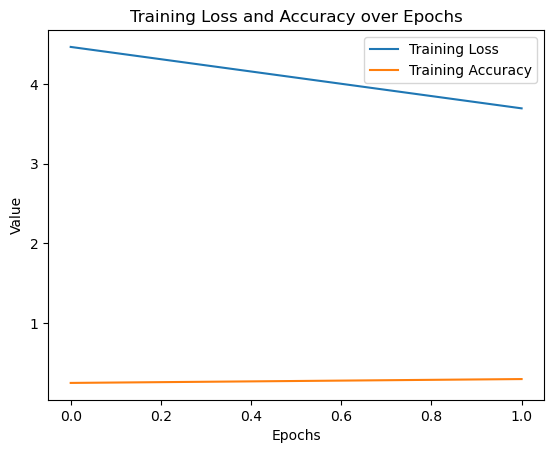

In [32]:
# Plotting Loss and Accuracy
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.title('Training Loss and Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()


In [33]:
if not os.path.exists("models2"):
    os.mkdir("models2")
steps = get_steps_per_epoch(train_descriptions)
dataset = data_generator(train_descriptions, train_features, tokenizer, max_length)
history = model.fit(dataset,epochs=4,steps_per_epoch=steps,verbose=1)
model.save("models2/model_image_caption_final.h5")

Epoch 1/4
9596/9596 ━━━━━━━━━━━━━━━━━━━━ 2144s 223ms/step - accuracy: 0.3068 - loss: 3.4641
Epoch 2/4
9596/9596 ━━━━━━━━━━━━━━━━━━━━ 1850s 193ms/step - accuracy: 0.3172 - loss: 3.3220
Epoch 3/4
9596/9596 ━━━━━━━━━━━━━━━━━━━━ 1891s 197ms/step - accuracy: 0.3227 - loss: 3.2348
Epoch 4/4
9596/9596 ━━━━━━━━━━━━━━━━━━━━ 2202s 230ms/step - accuracy: 0.3283 - loss: 3.1739


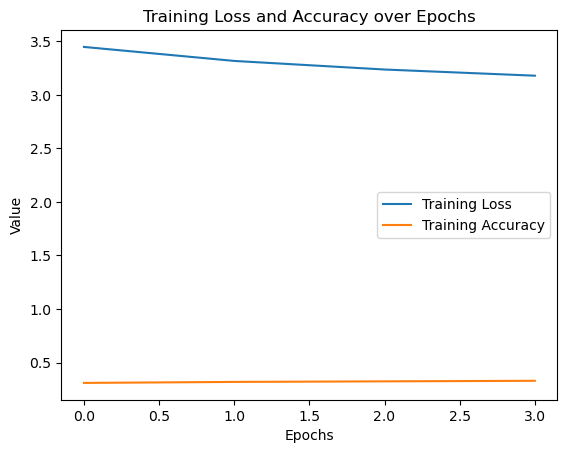

In [34]:
# Plotting Loss and Accuracy
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.title('Training Loss and Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()


In [35]:
if not os.path.exists("models2"):
    os.mkdir("models2")
steps = get_steps_per_epoch(train_descriptions)
dataset = data_generator(train_descriptions, train_features, tokenizer, max_length)
history = model.fit(dataset,epochs=10,steps_per_epoch=steps,verbose=1)
model.save("models2/model_image_caption_final.h5")

Epoch 1/10
9596/9596 ━━━━━━━━━━━━━━━━━━━━ 2182s 227ms/step - accuracy: 0.3321 - loss: 3.1357
Epoch 2/10
9596/9596 ━━━━━━━━━━━━━━━━━━━━ 2191s 228ms/step - accuracy: 0.3344 - loss: 3.1080
Epoch 3/10
9596/9596 ━━━━━━━━━━━━━━━━━━━━ 2059s 215ms/step - accuracy: 0.3370 - loss: 3.0853
Epoch 4/10
9596/9596 ━━━━━━━━━━━━━━━━━━━━ 2015s 210ms/step - accuracy: 0.3398 - loss: 3.0685
Epoch 5/10
9596/9596 ━━━━━━━━━━━━━━━━━━━━ 2044s 213ms/step - accuracy: 0.3401 - loss: 3.0558
Epoch 6/10
9596/9596 ━━━━━━━━━━━━━━━━━━━━ 2043s 213ms/step - accuracy: 0.3416 - loss: 3.0480
Epoch 7/10
9596/9596 ━━━━━━━━━━━━━━━━━━━━ 2080s 217ms/step - accuracy: 0.3422 - loss: 3.0406
Epoch 8/10
9596/9596 ━━━━━━━━━━━━━━━━━━━━ 2126s 222ms/step - accuracy: 0.3440 - loss: 3.0317
Epoch 9/10
9596/9596 ━━━━━━━━━━━━━━━━━━━━ 2167s 226ms/step - accuracy: 0.3435 - loss: 3.0297
Epoch 10/10
9596/9596 ━━━━━━━━━━━━━━━━━━━━ 2342s 244ms/step - accuracy: 0.3443 - loss: 3.0273


In [36]:
if not os.path.exists("models2"):
    os.mkdir("models2")
steps = get_steps_per_epoch(train_descriptions)
dataset = data_generator(train_descriptions, train_features, tokenizer, max_length)
history = model.fit(dataset,epochs=5,steps_per_epoch=steps,verbose=1)
model.save("models2/model_image_caption_final1.h5")

Epoch 1/5
9596/9596 ━━━━━━━━━━━━━━━━━━━━ 2537s 264ms/step - accuracy: 0.3448 - loss: 3.0232
Epoch 2/5
9596/9596 ━━━━━━━━━━━━━━━━━━━━ 2258s 235ms/step - accuracy: 0.3448 - loss: 3.0219
Epoch 3/5
9596/9596 ━━━━━━━━━━━━━━━━━━━━ 2277s 237ms/step - accuracy: 0.3453 - loss: 3.0209
Epoch 4/5
9596/9596 ━━━━━━━━━━━━━━━━━━━━ 2305s 240ms/step - accuracy: 0.3451 - loss: 3.0236
Epoch 5/5
9596/9596 ━━━━━━━━━━━━━━━━━━━━ 2352s 245ms/step - accuracy: 0.3455 - loss: 3.0207


In [37]:
if not os.path.exists("models2"):
    os.mkdir("models2")
steps = get_steps_per_epoch(train_descriptions)
dataset = data_generator(train_descriptions, train_features, tokenizer, max_length)
history = model.fit(dataset,epochs=5,steps_per_epoch=steps,verbose=1)
model.save("models2/model_image_caption_final1.h5")

Epoch 1/5
9596/9596 ━━━━━━━━━━━━━━━━━━━━ 2717s 283ms/step - accuracy: 0.3450 - loss: 3.0256
Epoch 2/5
9596/9596 ━━━━━━━━━━━━━━━━━━━━ 2511s 262ms/step - accuracy: 0.3449 - loss: 3.0210
Epoch 3/5
9596/9596 ━━━━━━━━━━━━━━━━━━━━ 2413s 251ms/step - accuracy: 0.3447 - loss: 3.0258
Epoch 4/5
9596/9596 ━━━━━━━━━━━━━━━━━━━━ 3234s 337ms/step - accuracy: 0.3456 - loss: 3.0328
Epoch 5/5
9596/9596 ━━━━━━━━━━━━━━━━━━━━ 4041s 421ms/step - accuracy: 0.3449 - loss: 3.0364


In [39]:
if not os.path.exists("models2"):
    os.mkdir("models2")
steps = get_steps_per_epoch(train_descriptions)
dataset = data_generator(train_descriptions, train_features, tokenizer, max_length)
history = model.fit(dataset,epochs=2,steps_per_epoch=steps,verbose=1)
model.save("models2/model_image_caption_final2.h5")

Epoch 1/2
9596/9596 ━━━━━━━━━━━━━━━━━━━━ 2614s 272ms/step - accuracy: 0.3470 - loss: 3.0148
Epoch 2/2
9596/9596 ━━━━━━━━━━━━━━━━━━━━ 3016s 314ms/step - accuracy: 0.3471 - loss: 3.0315


In [40]:
if not os.path.exists("models2"):
    os.mkdir("models2")
steps = get_steps_per_epoch(train_descriptions)
dataset = data_generator(train_descriptions, train_features, tokenizer, max_length)
history = model.fit(dataset,epochs=1,steps_per_epoch=steps,verbose=1)
model.save("models2/model_image_caption_final3.h5")

9596/9596 ━━━━━━━━━━━━━━━━━━━━ 2766s 288ms/step - accuracy: 0.3458 - loss: 3.0425
